# 5 Modeling - Sales Forecast

## Contents
- 5.1 [Introduction](#3.1Introduction)
- 5.2 [Import, Load, Explore](#3.2-Import,Load,Explore)
- 5.3 [HyperParameter Tuning](#3.3.ExploringTemproralPattern)
- 5.4 [Final Model](#3.4.Subset&analyze)
- 5.5 [Summary](#5.5.Summary)


## 5.1. Introduction <a id="3.1Introduction"></a>

In this phase, I'll explore 3 different models to forecast, after evaluating each on the validation set, the final model will be selected. 

## 5.2. Install & Import packages<a id="3.2-Import,Load,Explore"></a>

In [1]:
%%capture
!pip install Cython
!pip install pystan==2.19.1.1
!pip install prophet

In [2]:
import numpy as np
import pandas as pd
import math
import itertools 
from scipy import stats
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

from dateutil import parser
from datetime import datetime, timedelta, date

from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

### 5.2.1 Loading dataset

In [3]:
#Loading training data

sales_df = pd.read_csv('preprocessed_forecast_data.csv')
sales_df

WeekStartDate  Category  CustomerPerCategory  Quantity
0      2011-01-10        -1             40157996     10631
1      2011-01-10         0             67721767     31979
2      2011-01-10         1             21306812      9312
3      2011-01-10         2             19201996      7546
4      2011-01-10         3                66576        96
..            ...       ...                  ...       ...
700    2011-11-28         9              1357822       655
701    2011-11-28        10              4222637      3416
702    2011-11-28        11               450169       677
703    2011-11-28        12              1246700      1819
704    2011-11-28        13               459772       803

[705 rows x 4 columns]

In [4]:
sales_df['WeekStartDate'] = pd.to_datetime(sales_df['WeekStartDate'])
sales_df.drop('CustomerPerCategory', axis = 1, inplace = True)

In [5]:
sales_df.shape

(705, 3)

In [6]:
sales_df

WeekStartDate  Category  Quantity
0      2011-01-10        -1     10631
1      2011-01-10         0     31979
2      2011-01-10         1      9312
3      2011-01-10         2      7546
4      2011-01-10         3        96
..            ...       ...       ...
700    2011-11-28         9       655
701    2011-11-28        10      3416
702    2011-11-28        11       677
703    2011-11-28        12      1819
704    2011-11-28        13       803

[705 rows x 3 columns]

In [7]:
sales_data = sales_df.pivot(index='WeekStartDate', columns='Category', values='Quantity')
sales_data.head()

Category         -1      0      1     2    3     4     5     6     7     8   \
WeekStartDate                                                                 
2011-01-10     10631  31979   9312  7546   96  2267  6870  3332   906  1636   
2011-01-17     12858  29591  81285  4803   93  1555  6035  2103   970  2167   
2011-01-24     11885  24765   5576  4501  100  2044  5668  1364  1796  1730   
2011-01-31      9468  30834   6775  5022   82  1483  6602  1839  1144  1802   
2011-02-07     11072  21686   4475  4004   71  1310  3434  1457   838   903   

Category        9     10   11    12   13  
WeekStartDate                             
2011-01-10     127   917  162   393  185  
2011-01-17     283  1824  287   690  148  
2011-01-24     134  2126  315  1094   45  
2011-01-31     208  1068  699  2254   86  
2011-02-07     158   937  198   916   97

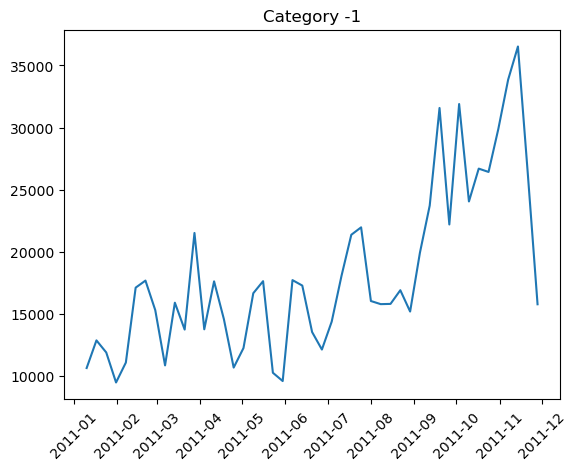

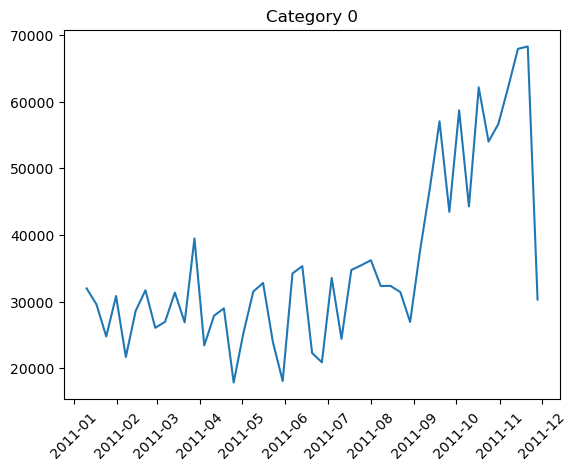

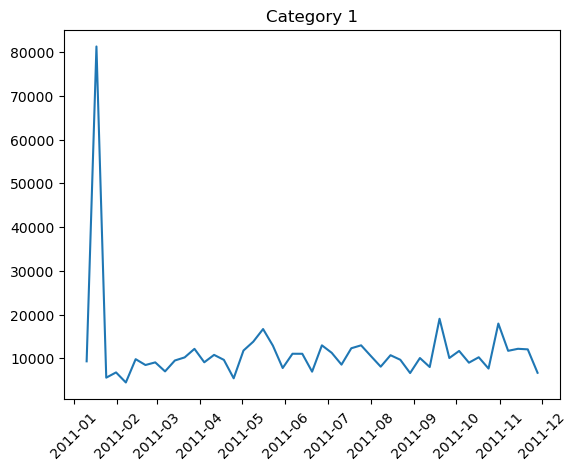

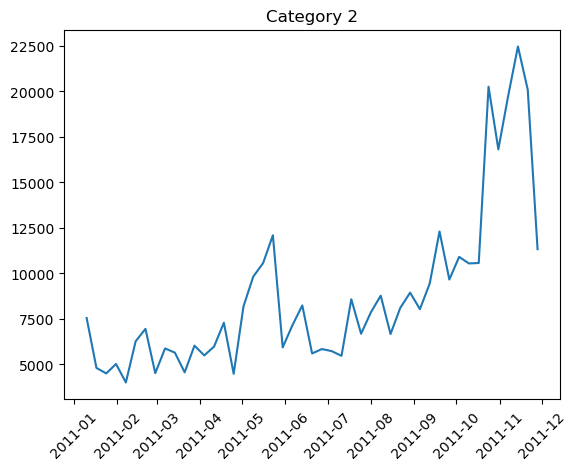

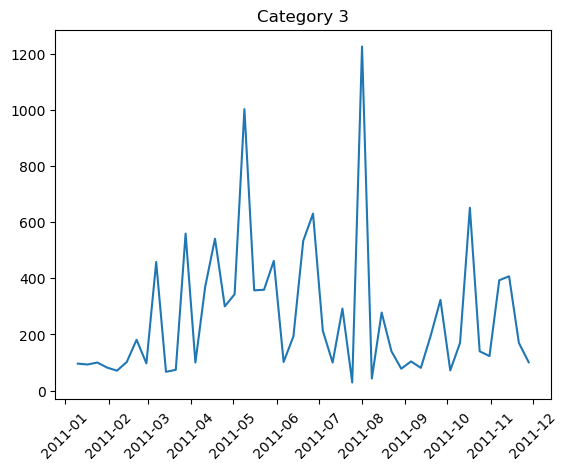

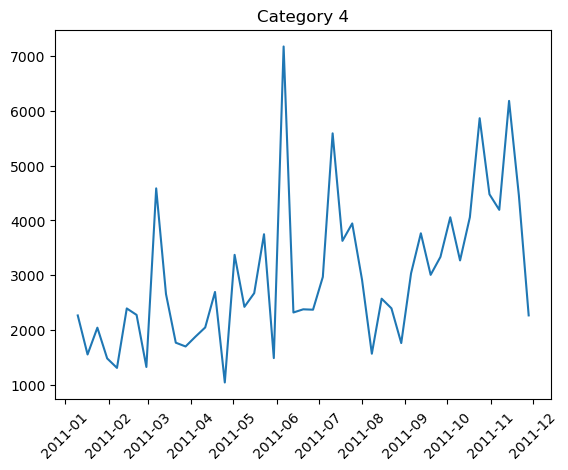

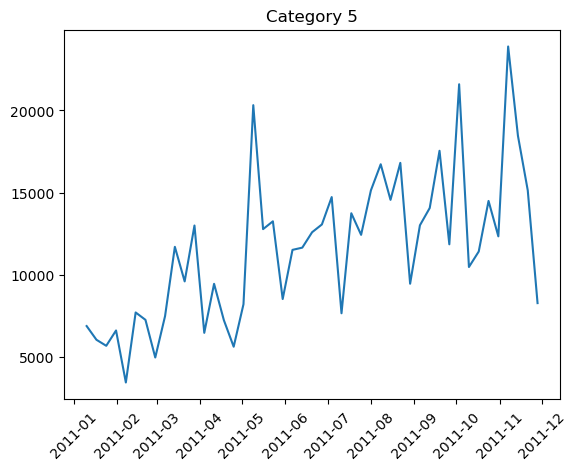

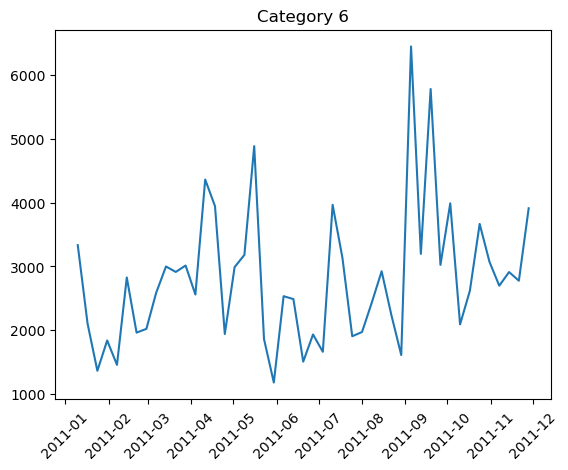

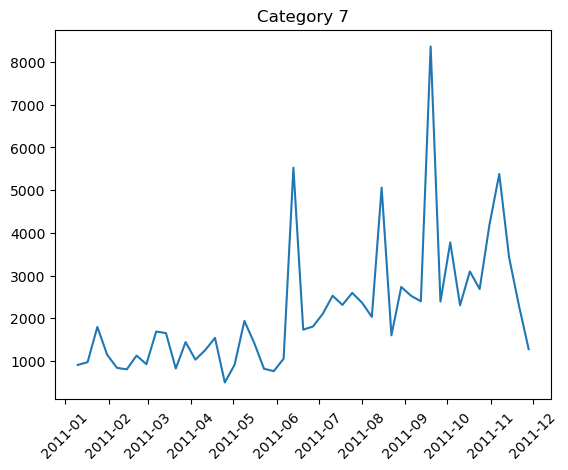

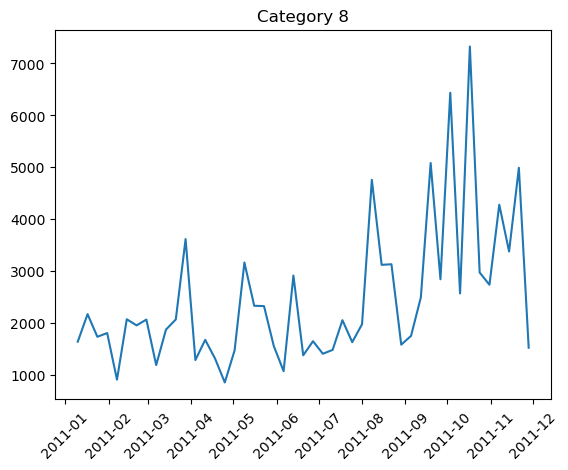

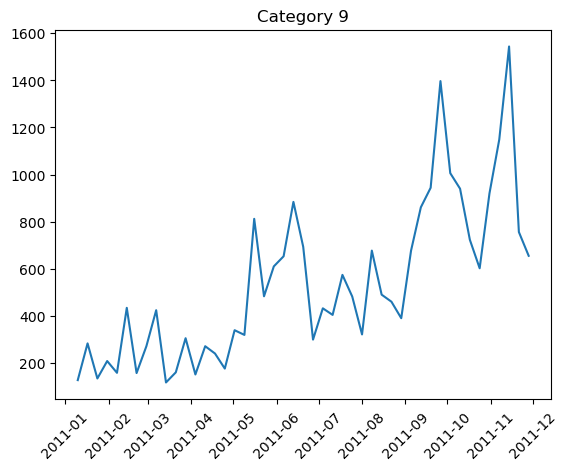

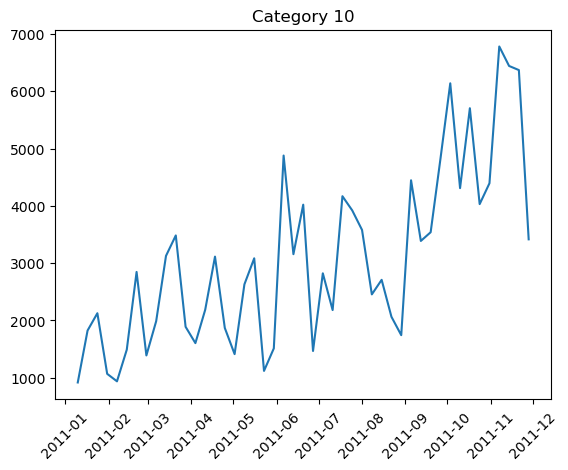

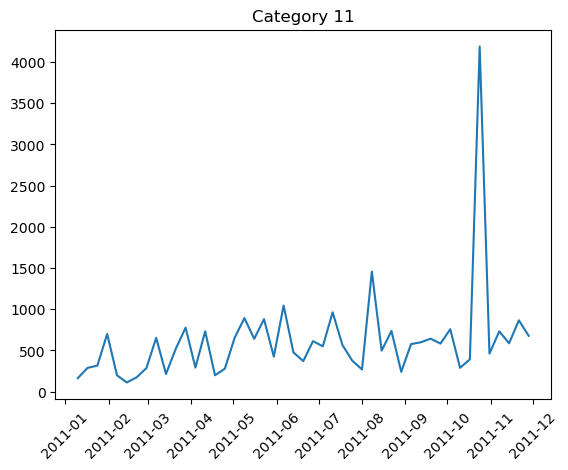

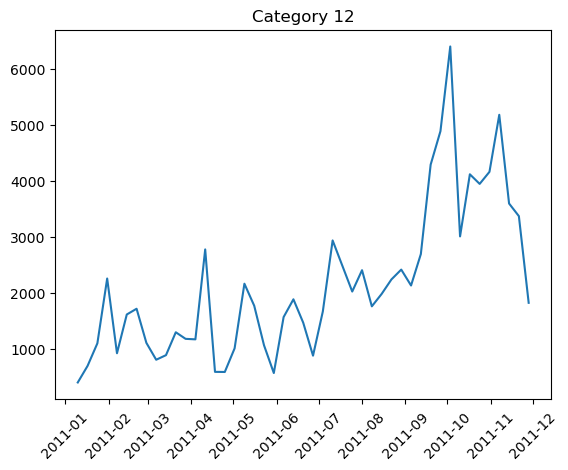

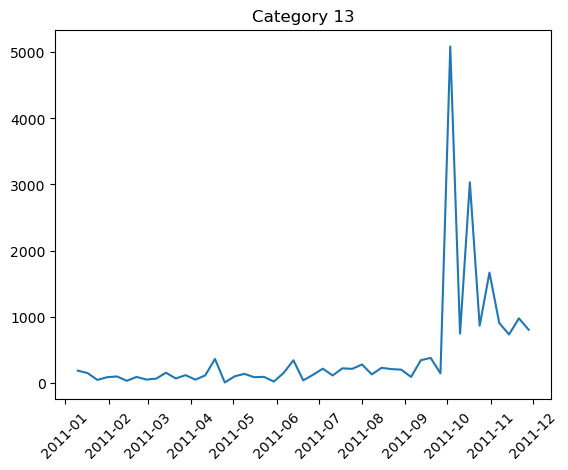

In [8]:
for column in sales_data.columns:
    plt.plot(sales_data[column])
    plt.title(f'Category {column}')
    plt.xticks(rotation = 45)
    plt.show()


## 5.3. Hyperparameter tuning

In [11]:
changepoint_prior_scale_range = np.linspace(0.01, 1, num=5).tolist()
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
seasonality_mode = ['multiplicative', 'additive']

In [12]:
dicts = {}

period_weeks = 4
horizon_weeks = 4
initial_weeks = 42

# Converting weeks to days for the model
period_days = period_weeks * 7
horizon_days = horizon_weeks * 7
initial_days = initial_weeks * 7


for category in sales_data.columns:
  
    category_df = sales_data[category].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range,
        "holidays_prior_scale": holidays_prior_scale_range,
        "seasonality_mode": seasonality_mode
        
    }


    # Creating all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 


    # Evaluating all parameters using cross validation
    for params in all_params:
        m = Prophet(**params).fit(category_df) 
        df_cv = cross_validation(m, initial=f"{initial_days} days", period=f"{period_days} days", horizon=f"{horizon_days} days")
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Finding the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(category)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = category 
    
    dicts[category] = params_dict


14:15:26 - cmdstanpy - INFO - Chain [1] start processing
14:15:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:26 - cmdstanpy - INFO - Chain [1] start processing
14:15:26 - cmdstanpy - INFO - Chain [1] done processing
14:15:26 - cmdstanpy - INFO - Chain [1] start processing
14:15:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:26 - cmdstanpy - INFO - Chain [1] start processing
14:15:26 - cmdstanpy - INFO - Chain [1] done processing
14:15:27 - cmdstanpy - INFO - Chain [1] start processing
14:15:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:27 - cmdstanpy - INFO - Chain [1] start processing
14:15:27 - cmdstanpy - INFO - Chain [1] done processing
14:15:27 - cmdstanpy - INFO - Chain [1] start processing
14:15:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:27 - cmdstanpy - INFO - Chain [1] start processing
14:15:27 - cmdstanpy - INFO - Chain [1] done processing
14:15:28 - cmdstanpy - INFO - Chain [1] start processing
14:15:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:28 - cmdstanpy - INFO - Chain [1] start processing
14:15:28 - cmdstanpy - INFO - Chain [1] done processing
14:15:28 - cmdstanpy - INFO - Chain [1] start processing
14:15:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:28 - cmdstanpy - INFO - Chain [1] start processing
14:15:28 - cmdstanpy - INFO - Chain [1] done processing
14:15:28 - cmdstanpy - INFO - Chain [1] start processing
14:15:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:29 - cmdstanpy - INFO - Chain [1] start processing
14:15:29 - cmdstanpy - INFO - Chain [1] done processing
14:15:29 - cmdstanpy - INFO - Chain [1] start processing
14:15:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:29 - cmdstanpy - INFO - Chain [1] start processing
14:15:29 - cmdstanpy - INFO - Chain [1] done processing
14:15:29 - cmdstanpy - INFO - Chain [1] start processing
14:15:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:29 - cmdstanpy - INFO - Chain [1] start processing
14:15:30 - cmdstanpy - INFO - Chain [1] done processing
14:15:30 - cmdstanpy - INFO - Chain [1] start processing
14:15:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:30 - cmdstanpy - INFO - Chain [1] start processing
14:15:30 - cmdstanpy - INFO - Chain [1] done processing
14:15:30 - cmdstanpy - INFO - Chain [1] start processing
14:15:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:31 - cmdstanpy - INFO - Chain [1] start processing
14:15:31 - cmdstanpy - INFO - Chain [1] done processing
14:15:31 - cmdstanpy - INFO - Chain [1] start processing
14:15:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:31 - cmdstanpy - INFO - Chain [1] start processing
14:15:31 - cmdstanpy - INFO - Chain [1] done processing
14:15:31 - cmdstanpy - INFO - Chain [1] start processing
14:15:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:31 - cmdstanpy - INFO - Chain [1] start processing
14:15:31 - cmdstanpy - INFO - Chain [1] done processing
14:15:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:32 - cmdstanpy - INFO - Chain [1] start processing
14:15:32 - cmdstanpy - INFO - Chain [1] done processing
14:15:32 - cmdstanpy - INFO - Chain [1] start processing
14:15:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:32 - cmdstanpy - INFO - Chain [1] start processing
14:15:33 - cmdstanpy - INFO - Chain [1] done processing
14:15:33 - cmdstanpy - INFO - Chain [1] start processing
14:15:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:33 - cmdstanpy - INFO - Chain [1] start processing
14:15:33 - cmdstanpy - INFO - Chain [1] done processing
14:15:33 - cmdstanpy - INFO - Chain [1] start processing
14:15:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:34 - cmdstanpy - INFO - Chain [1] start processing
14:15:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:34 - cmdstanpy - INFO - Chain [1] start processing
14:15:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:34 - cmdstanpy - INFO - Chain [1] start processing
14:15:34 - cmdstanpy - INFO - Chain [1] done processing
14:15:35 - cmdstanpy - INFO - Chain [1] start processing
14:15:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:35 - cmdstanpy - INFO - Chain [1] start processing
14:15:35 - cmdstanpy - INFO - Chain [1] done processing
14:15:35 - cmdstanpy - INFO - Chain [1] start processing
14:15:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:36 - cmdstanpy - INFO - Chain [1] start processing
14:15:36 - cmdstanpy - INFO - Chain [1] done processing
14:15:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:36 - cmdstanpy - INFO - Chain [1] start processing
14:15:36 - cmdstanpy - INFO - Chain [1] done processing
14:15:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:37 - cmdstanpy - INFO - Chain [1] start processing
14:15:37 - cmdstanpy - INFO - Chain [1] done processing
14:15:37 - cmdstanpy - INFO - Chain [1] start processing
14:15:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:37 - cmdstanpy - INFO - Chain [1] start processing
14:15:37 - cmdstanpy - INFO - Chain [1] done processing
14:15:38 - cmdstanpy - INFO - Chain [1] start processing
14:15:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:38 - cmdstanpy - INFO - Chain [1] start processing
14:15:38 - cmdstanpy - INFO - Chain [1] done processing
14:15:38 - cmdstanpy - INFO - Chain [1] start processing
14:15:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:38 - cmdstanpy - INFO - Chain [1] start processing
14:15:39 - cmdstanpy - INFO - Chain [1] done processing
14:15:39 - cmdstanpy - INFO - Chain [1] start processing
14:15:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:39 - cmdstanpy - INFO - Chain [1] start processing
14:15:39 - cmdstanpy - INFO - Chain [1] done processing
14:15:39 - cmdstanpy - INFO - Chain [1] start processing
14:15:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:40 - cmdstanpy - INFO - Chain [1] start processing
14:15:40 - cmdstanpy - INFO - Chain [1] done processing
14:15:40 - cmdstanpy - INFO - Chain [1] start processing
14:15:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:40 - cmdstanpy - INFO - Chain [1] start processing
14:15:40 - cmdstanpy - INFO - Chain [1] done processing
14:15:40 - cmdstanpy - INFO - Chain [1] start processing
14:15:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:40 - cmdstanpy - INFO - Chain [1] start processing
14:15:41 - cmdstanpy - INFO - Chain [1] done processing
14:15:41 - cmdstanpy - INFO - Chain [1] start processing
14:15:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:41 - cmdstanpy - INFO - Chain [1] start processing
14:15:41 - cmdstanpy - INFO - Chain [1] done processing
14:15:41 - cmdstanpy - INFO - Chain [1] start processing
14:15:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:42 - cmdstanpy - INFO - Chain [1] start processing
14:15:42 - cmdstanpy - INFO - Chain [1] done processing
14:15:42 - cmdstanpy - INFO - Chain [1] start processing
14:15:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:42 - cmdstanpy - INFO - Chain [1] start processing
14:15:42 - cmdstanpy - INFO - Chain [1] done processing
14:15:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:43 - cmdstanpy - INFO - Chain [1] start processing
14:15:43 - cmdstanpy - INFO - Chain [1] done processing
14:15:43 - cmdstanpy - INFO - Chain [1] start processing
14:15:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:43 - cmdstanpy - INFO - Chain [1] start processing
14:15:43 - cmdstanpy - INFO - Chain [1] done processing
14:15:44 - cmdstanpy - INFO - Chain [1] start processing
14:15:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:44 - cmdstanpy - INFO - Chain [1] start processing
14:15:44 - cmdstanpy - INFO - Chain [1] done processing
14:15:44 - cmdstanpy - INFO - Chain [1] start processing
14:15:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:44 - cmdstanpy - INFO - Chain [1] start processing
14:15:44 - cmdstanpy - INFO - Chain [1] done processing
14:15:44 - cmdstanpy - INFO - Chain [1] start processing
14:15:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:45 - cmdstanpy - INFO - Chain [1] start processing
14:15:45 - cmdstanpy - INFO - Chain [1] done processing
14:15:45 - cmdstanpy - INFO - Chain [1] start processing
14:15:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:45 - cmdstanpy - INFO - Chain [1] start processing
14:15:45 - cmdstanpy - INFO - Chain [1] done processing
14:15:45 - cmdstanpy - INFO - Chain [1] start processing
14:15:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] done processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:46 - cmdstanpy - INFO - Chain [1] done processing
14:15:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:47 - cmdstanpy - INFO - Chain [1] done processing
14:15:47 - cmdstanpy - INFO - Chain [1] start processing
14:15:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:47 - cmdstanpy - INFO - Chain [1] start processing
14:15:47 - cmdstanpy - INFO - Chain [1] done processing
14:15:47 - cmdstanpy - INFO - Chain [1] start processing
14:15:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:47 - cmdstanpy - INFO - Chain [1] start processing
14:15:48 - cmdstanpy - INFO - Chain [1] done processing
14:15:48 - cmdstanpy - INFO - Chain [1] start processing
14:15:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:48 - cmdstanpy - INFO - Chain [1] start processing
14:15:48 - cmdstanpy - INFO - Chain [1] done processing
14:15:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:49 - cmdstanpy - INFO - Chain [1] start processing
14:15:49 - cmdstanpy - INFO - Chain [1] done processing
14:15:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:49 - cmdstanpy - INFO - Chain [1] start processing
14:15:49 - cmdstanpy - INFO - Chain [1] done processing
14:15:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:50 - cmdstanpy - INFO - Chain [1] start processing
14:15:50 - cmdstanpy - INFO - Chain [1] done processing
14:15:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:51 - cmdstanpy - INFO - Chain [1] start processing
14:15:51 - cmdstanpy - INFO - Chain [1] done processing
14:15:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:51 - cmdstanpy - INFO - Chain [1] start processing
14:15:52 - cmdstanpy - INFO - Chain [1] done processing
14:15:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:52 - cmdstanpy - INFO - Chain [1] start processing
14:15:52 - cmdstanpy - INFO - Chain [1] done processing
14:15:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  7.940455e+07  8910.923137  7934.618116  0.313682  0.295219   

      smape  coverage  
0  0.302593      0.25  


14:15:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:53 - cmdstanpy - INFO - Chain [1] start processing
14:15:53 - cmdstanpy - INFO - Chain [1] done processing
14:15:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:15:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:54 - cmdstanpy - INFO - Chain [1] start processing
14:15:54 - cmdstanpy - INFO - Chain [1] done processing
14:15:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:15:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:54 - cmdstanpy - INFO - Chain [1] start processing
14:15:54 - cmdstanpy - INFO - Chain [1] done processing
14:15:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:15:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:55 - cmdstanpy - INFO - Chain [1] start processing
14:15:55 - cmdstanpy - INFO - Chain [1] done processing
14:15:55 - cmdstanpy - INFO - Chain [1] start processing
14:15:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:56 - cmdstanpy - INFO - Chain [1] start processing
14:15:56 - cmdstanpy - INFO - Chain [1] done processing
14:15:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:15:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:56 - cmdstanpy - INFO - Chain [1] start processing
14:15:56 - cmdstanpy - INFO - Chain [1] done processing
14:15:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:15:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:57 - cmdstanpy - INFO - Chain [1] start processing
14:15:57 - cmdstanpy - INFO - Chain [1] done processing
14:15:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:15:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:57 - cmdstanpy - INFO - Chain [1] start processing
14:15:57 - cmdstanpy - INFO - Chain [1] done processing
14:15:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:15:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:58 - cmdstanpy - INFO - Chain [1] start processing
14:15:58 - cmdstanpy - INFO - Chain [1] done processing
14:15:58 - cmdstanpy - INFO - Chain [1] start processing
14:15:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:58 - cmdstanpy - INFO - Chain [1] start processing
14:15:58 - cmdstanpy - INFO - Chain [1] done processing
14:15:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:15:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:59 - cmdstanpy - INFO - Chain [1] start processing
14:15:59 - cmdstanpy - INFO - Chain [1] done processing
14:15:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:15:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:15:59 - cmdstanpy - INFO - Chain [1] start processing
14:15:59 - cmdstanpy - INFO - Chain [1] done processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] done processing
14:16:00 - cmdstanpy - INFO - Chain [1] start processing
14:16:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:01 - cmdstanpy - INFO - Chain [1] start processing
14:16:01 - cmdstanpy - INFO - Chain [1] done processing
14:16:01 - cmdstanpy - INFO - Chain [1] start processing
14:16:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:01 - cmdstanpy - INFO - Chain [1] start processing
14:16:01 - cmdstanpy - INFO - Chain [1] done processing
14:16:01 - cmdstanpy - INFO - Chain [1] start processing
14:16:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:02 - cmdstanpy - INFO - Chain [1] start processing
14:16:02 - cmdstanpy - INFO - Chain [1] done processing
14:16:02 - cmdstanpy - INFO - Chain [1] start processing
14:16:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:02 - cmdstanpy - INFO - Chain [1] start processing
14:16:02 - cmdstanpy - INFO - Chain [1] done processing
14:16:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:03 - cmdstanpy - INFO - Chain [1] done processing
14:16:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:04 - cmdstanpy - INFO - Chain [1] start processing
14:16:04 - cmdstanpy - INFO - Chain [1] done processing
14:16:04 - cmdstanpy - INFO - Chain [1] start processing
14:16:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:04 - cmdstanpy - INFO - Chain [1] start processing
14:16:04 - cmdstanpy - INFO - Chain [1] done processing
14:16:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:16:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:05 - cmdstanpy - INFO - Chain [1] start processing
14:16:05 - cmdstanpy - INFO - Chain [1] done processing
14:16:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:16:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:05 - cmdstanpy - INFO - Chain [1] start processing
14:16:06 - cmdstanpy - INFO - Chain [1] done processing
14:16:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:06 - cmdstanpy - INFO - Chain [1] start processing
14:16:06 - cmdstanpy - INFO - Chain [1] done processing
14:16:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:16:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:07 - cmdstanpy - INFO - Chain [1] start processing
14:16:07 - cmdstanpy - INFO - Chain [1] done processing
14:16:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:16:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:07 - cmdstanpy - INFO - Chain [1] start processing
14:16:07 - cmdstanpy - INFO - Chain [1] done processing
14:16:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:08 - cmdstanpy - INFO - Chain [1] start processing
14:16:08 - cmdstanpy - INFO - Chain [1] done processing
14:16:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:08 - cmdstanpy - INFO - Chain [1] start processing
14:16:09 - cmdstanpy - INFO - Chain [1] done processing
14:16:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:09 - cmdstanpy - INFO - Chain [1] start processing
14:16:09 - cmdstanpy - INFO - Chain [1] done processing
14:16:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:10 - cmdstanpy - INFO - Chain [1] start processing
14:16:10 - cmdstanpy - INFO - Chain [1] done processing
14:16:10 - cmdstanpy - INFO - Chain [1] start processing
14:16:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:10 - cmdstanpy - INFO - Chain [1] start processing
14:16:10 - cmdstanpy - INFO - Chain [1] done processing
14:16:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:11 - cmdstanpy - INFO - Chain [1] start processing
14:16:11 - cmdstanpy - INFO - Chain [1] done processing
14:16:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:11 - cmdstanpy - INFO - Chain [1] start processing
14:16:11 - cmdstanpy - INFO - Chain [1] done processing
14:16:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:16:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:12 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing
14:16:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:16:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:13 - cmdstanpy - INFO - Chain [1] start processing
14:16:13 - cmdstanpy - INFO - Chain [1] done processing
14:16:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:13 - cmdstanpy - INFO - Chain [1] start processing
14:16:13 - cmdstanpy - INFO - Chain [1] done processing
14:16:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:14 - cmdstanpy - INFO - Chain [1] start processing
14:16:14 - cmdstanpy - INFO - Chain [1] done processing
14:16:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:15 - cmdstanpy - INFO - Chain [1] start processing
14:16:15 - cmdstanpy - INFO - Chain [1] done processing
14:16:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:15 - cmdstanpy - INFO - Chain [1] start processing
14:16:16 - cmdstanpy - INFO - Chain [1] done processing
14:16:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:16 - cmdstanpy - INFO - Chain [1] start processing
14:16:16 - cmdstanpy - INFO - Chain [1] done processing
14:16:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:17 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:17 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:16:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:18 - cmdstanpy - INFO - Chain [1] start processing
14:16:18 - cmdstanpy - INFO - Chain [1] done processing
14:16:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:16:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:19 - cmdstanpy - INFO - Chain [1] start processing
14:16:19 - cmdstanpy - INFO - Chain [1] done processing
14:16:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:16:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:19 - cmdstanpy - INFO - Chain [1] start processing
14:16:20 - cmdstanpy - INFO - Chain [1] done processing
14:16:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:20 - cmdstanpy - INFO - Chain [1] start processing
14:16:20 - cmdstanpy - INFO - Chain [1] done processing
14:16:20 - cmdstanpy - INFO - Chain [1] start processing
14:16:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:21 - cmdstanpy - INFO - Chain [1] start processing
14:16:21 - cmdstanpy - INFO - Chain [1] done processing
14:16:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:21 - cmdstanpy - INFO - Chain [1] start processing
14:16:21 - cmdstanpy - INFO - Chain [1] done processing
14:16:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:22 - cmdstanpy - INFO - Chain [1] start processing
14:16:22 - cmdstanpy - INFO - Chain [1] done processing
14:16:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641       0.0  


14:16:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:22 - cmdstanpy - INFO - Chain [1] start processing
14:16:22 - cmdstanpy - INFO - Chain [1] done processing
14:16:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.287714e+07  9103.687991  7873.348886  0.370298  0.172986   

      smape  coverage  
0  0.292641      0.25  


14:16:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:23 - cmdstanpy - INFO - Chain [1] start processing
14:16:23 - cmdstanpy - INFO - Chain [1] done processing
14:16:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:24 - cmdstanpy - INFO - Chain [1] start processing
14:16:24 - cmdstanpy - INFO - Chain [1] done processing
14:16:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:25 - cmdstanpy - INFO - Chain [1] start processing
14:16:25 - cmdstanpy - INFO - Chain [1] done processing
14:16:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:25 - cmdstanpy - INFO - Chain [1] start processing
14:16:25 - cmdstanpy - INFO - Chain [1] done processing
14:16:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:26 - cmdstanpy - INFO - Chain [1] start processing
14:16:26 - cmdstanpy - INFO - Chain [1] done processing
14:16:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:27 - cmdstanpy - INFO - Chain [1] start processing
14:16:27 - cmdstanpy - INFO - Chain [1] done processing
14:16:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:27 - cmdstanpy - INFO - Chain [1] start processing
14:16:27 - cmdstanpy - INFO - Chain [1] done processing
14:16:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:28 - cmdstanpy - INFO - Chain [1] start processing
14:16:28 - cmdstanpy - INFO - Chain [1] done processing
14:16:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:29 - cmdstanpy - INFO - Chain [1] start processing
14:16:29 - cmdstanpy - INFO - Chain [1] done processing
14:16:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:30 - cmdstanpy - INFO - Chain [1] done processing
14:16:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:31 - cmdstanpy - INFO - Chain [1] done processing
14:16:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:31 - cmdstanpy - INFO - Chain [1] start processing
14:16:31 - cmdstanpy - INFO - Chain [1] done processing
14:16:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:32 - cmdstanpy - INFO - Chain [1] start processing
14:16:32 - cmdstanpy - INFO - Chain [1] done processing
14:16:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:32 - cmdstanpy - INFO - Chain [1] start processing
14:16:33 - cmdstanpy - INFO - Chain [1] done processing
14:16:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:33 - cmdstanpy - INFO - Chain [1] start processing
14:16:33 - cmdstanpy - INFO - Chain [1] done processing
14:16:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:34 - cmdstanpy - INFO - Chain [1] start processing
14:16:34 - cmdstanpy - INFO - Chain [1] done processing
14:16:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:34 - cmdstanpy - INFO - Chain [1] start processing
14:16:35 - cmdstanpy - INFO - Chain [1] done processing
14:16:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:35 - cmdstanpy - INFO - Chain [1] start processing
14:16:35 - cmdstanpy - INFO - Chain [1] done processing
14:16:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:36 - cmdstanpy - INFO - Chain [1] start processing
14:16:36 - cmdstanpy - INFO - Chain [1] done processing
14:16:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:36 - cmdstanpy - INFO - Chain [1] start processing
14:16:36 - cmdstanpy - INFO - Chain [1] done processing
14:16:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:37 - cmdstanpy - INFO - Chain [1] start processing
14:16:37 - cmdstanpy - INFO - Chain [1] done processing
14:16:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:38 - cmdstanpy - INFO - Chain [1] start processing
14:16:38 - cmdstanpy - INFO - Chain [1] done processing
14:16:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:38 - cmdstanpy - INFO - Chain [1] start processing
14:16:38 - cmdstanpy - INFO - Chain [1] done processing
14:16:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:39 - cmdstanpy - INFO - Chain [1] start processing
14:16:39 - cmdstanpy - INFO - Chain [1] done processing
14:16:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:40 - cmdstanpy - INFO - Chain [1] start processing
14:16:40 - cmdstanpy - INFO - Chain [1] done processing
14:16:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:40 - cmdstanpy - INFO - Chain [1] start processing
14:16:41 - cmdstanpy - INFO - Chain [1] done processing
14:16:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:41 - cmdstanpy - INFO - Chain [1] start processing
14:16:41 - cmdstanpy - INFO - Chain [1] done processing
14:16:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:42 - cmdstanpy - INFO - Chain [1] start processing
14:16:42 - cmdstanpy - INFO - Chain [1] done processing
14:16:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:42 - cmdstanpy - INFO - Chain [1] start processing
14:16:43 - cmdstanpy - INFO - Chain [1] done processing
14:16:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:43 - cmdstanpy - INFO - Chain [1] start processing
14:16:43 - cmdstanpy - INFO - Chain [1] done processing
14:16:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:44 - cmdstanpy - INFO - Chain [1] start processing
14:16:44 - cmdstanpy - INFO - Chain [1] done processing
14:16:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:44 - cmdstanpy - INFO - Chain [1] start processing
14:16:45 - cmdstanpy - INFO - Chain [1] done processing
14:16:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:45 - cmdstanpy - INFO - Chain [1] start processing
14:16:45 - cmdstanpy - INFO - Chain [1] done processing
14:16:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:46 - cmdstanpy - INFO - Chain [1] start processing
14:16:46 - cmdstanpy - INFO - Chain [1] done processing
14:16:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:46 - cmdstanpy - INFO - Chain [1] start processing
14:16:46 - cmdstanpy - INFO - Chain [1] done processing
14:16:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:47 - cmdstanpy - INFO - Chain [1] start processing
14:16:47 - cmdstanpy - INFO - Chain [1] done processing
14:16:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:48 - cmdstanpy - INFO - Chain [1] start processing
14:16:48 - cmdstanpy - INFO - Chain [1] done processing
14:16:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:48 - cmdstanpy - INFO - Chain [1] start processing
14:16:48 - cmdstanpy - INFO - Chain [1] done processing
14:16:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:49 - cmdstanpy - INFO - Chain [1] start processing
14:16:49 - cmdstanpy - INFO - Chain [1] done processing
14:16:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:50 - cmdstanpy - INFO - Chain [1] start processing
14:16:50 - cmdstanpy - INFO - Chain [1] done processing
14:16:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:50 - cmdstanpy - INFO - Chain [1] start processing
14:16:50 - cmdstanpy - INFO - Chain [1] done processing
14:16:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:51 - cmdstanpy - INFO - Chain [1] start processing
14:16:51 - cmdstanpy - INFO - Chain [1] done processing
14:16:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:51 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] done processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] done processing
14:16:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:53 - cmdstanpy - INFO - Chain [1] start processing
14:16:53 - cmdstanpy - INFO - Chain [1] done processing
14:16:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:54 - cmdstanpy - INFO - Chain [1] start processing
14:16:54 - cmdstanpy - INFO - Chain [1] done processing
14:16:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:54 - cmdstanpy - INFO - Chain [1] start processing
14:16:54 - cmdstanpy - INFO - Chain [1] done processing
14:16:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:55 - cmdstanpy - INFO - Chain [1] start processing
14:16:55 - cmdstanpy - INFO - Chain [1] done processing
14:16:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:56 - cmdstanpy - INFO - Chain [1] start processing
14:16:56 - cmdstanpy - INFO - Chain [1] done processing
14:16:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:56 - cmdstanpy - INFO - Chain [1] start processing
14:16:57 - cmdstanpy - INFO - Chain [1] done processing
14:16:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  9.533234e+07  9763.828172  8065.237305  0.395978  0.184417   

      smape  coverage  
0  0.295718      0.25  


14:16:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:57 - cmdstanpy - INFO - Chain [1] start processing
14:16:58 - cmdstanpy - INFO - Chain [1] done processing
14:16:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:16:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:16:59 - cmdstanpy - INFO - Chain [1] done processing
14:16:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:16:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:16:59 - cmdstanpy - INFO - Chain [1] start processing
14:16:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:00 - cmdstanpy - INFO - Chain [1] start processing
14:17:00 - cmdstanpy - INFO - Chain [1] done processing
14:17:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:01 - cmdstanpy - INFO - Chain [1] start processing
14:17:01 - cmdstanpy - INFO - Chain [1] done processing
14:17:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:02 - cmdstanpy - INFO - Chain [1] start processing
14:17:02 - cmdstanpy - INFO - Chain [1] done processing
14:17:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:03 - cmdstanpy - INFO - Chain [1] start processing
14:17:03 - cmdstanpy - INFO - Chain [1] done processing
14:17:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:04 - cmdstanpy - INFO - Chain [1] start processing
14:17:04 - cmdstanpy - INFO - Chain [1] done processing
14:17:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:05 - cmdstanpy - INFO - Chain [1] start processing
14:17:05 - cmdstanpy - INFO - Chain [1] done processing
14:17:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:06 - cmdstanpy - INFO - Chain [1] start processing
14:17:06 - cmdstanpy - INFO - Chain [1] done processing
14:17:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:06 - cmdstanpy - INFO - Chain [1] start processing
14:17:07 - cmdstanpy - INFO - Chain [1] done processing
14:17:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:07 - cmdstanpy - INFO - Chain [1] start processing
14:17:08 - cmdstanpy - INFO - Chain [1] done processing
14:17:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:08 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] done processing
14:17:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] done processing
14:17:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:10 - cmdstanpy - INFO - Chain [1] start processing
14:17:10 - cmdstanpy - INFO - Chain [1] done processing
14:17:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:11 - cmdstanpy - INFO - Chain [1] start processing
14:17:11 - cmdstanpy - INFO - Chain [1] done processing
14:17:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:12 - cmdstanpy - INFO - Chain [1] start processing
14:17:12 - cmdstanpy - INFO - Chain [1] done processing
14:17:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:13 - cmdstanpy - INFO - Chain [1] start processing
14:17:13 - cmdstanpy - INFO - Chain [1] done processing
14:17:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:14 - cmdstanpy - INFO - Chain [1] start processing
14:17:14 - cmdstanpy - INFO - Chain [1] done processing
14:17:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:15 - cmdstanpy - INFO - Chain [1] start processing
14:17:15 - cmdstanpy - INFO - Chain [1] done processing
14:17:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] done processing
14:17:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:17 - cmdstanpy - INFO - Chain [1] start processing
14:17:17 - cmdstanpy - INFO - Chain [1] done processing
14:17:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:18 - cmdstanpy - INFO - Chain [1] start processing
14:17:18 - cmdstanpy - INFO - Chain [1] done processing
14:17:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:19 - cmdstanpy - INFO - Chain [1] start processing
14:17:19 - cmdstanpy - INFO - Chain [1] done processing
14:17:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:20 - cmdstanpy - INFO - Chain [1] start processing
14:17:20 - cmdstanpy - INFO - Chain [1] done processing
14:17:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:21 - cmdstanpy - INFO - Chain [1] start processing
14:17:21 - cmdstanpy - INFO - Chain [1] done processing
14:17:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:22 - cmdstanpy - INFO - Chain [1] start processing
14:17:22 - cmdstanpy - INFO - Chain [1] done processing
14:17:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:23 - cmdstanpy - INFO - Chain [1] start processing
14:17:23 - cmdstanpy - INFO - Chain [1] done processing
14:17:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:24 - cmdstanpy - INFO - Chain [1] start processing
14:17:24 - cmdstanpy - INFO - Chain [1] done processing
14:17:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:25 - cmdstanpy - INFO - Chain [1] start processing
14:17:25 - cmdstanpy - INFO - Chain [1] done processing
14:17:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:26 - cmdstanpy - INFO - Chain [1] start processing
14:17:26 - cmdstanpy - INFO - Chain [1] done processing
14:17:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:27 - cmdstanpy - INFO - Chain [1] start processing
14:17:27 - cmdstanpy - INFO - Chain [1] done processing
14:17:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:28 - cmdstanpy - INFO - Chain [1] start processing
14:17:28 - cmdstanpy - INFO - Chain [1] done processing
14:17:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:29 - cmdstanpy - INFO - Chain [1] start processing
14:17:30 - cmdstanpy - INFO - Chain [1] done processing
14:17:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:31 - cmdstanpy - INFO - Chain [1] start processing
14:17:31 - cmdstanpy - INFO - Chain [1] done processing
14:17:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:32 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:33 - cmdstanpy - INFO - Chain [1] start processing
14:17:33 - cmdstanpy - INFO - Chain [1] done processing
14:17:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:34 - cmdstanpy - INFO - Chain [1] start processing
14:17:34 - cmdstanpy - INFO - Chain [1] done processing
14:17:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:35 - cmdstanpy - INFO - Chain [1] start processing
14:17:35 - cmdstanpy - INFO - Chain [1] done processing
14:17:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:36 - cmdstanpy - INFO - Chain [1] start processing
14:17:36 - cmdstanpy - INFO - Chain [1] done processing
14:17:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:37 - cmdstanpy - INFO - Chain [1] start processing
14:17:37 - cmdstanpy - INFO - Chain [1] done processing
14:17:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:38 - cmdstanpy - INFO - Chain [1] start processing
14:17:38 - cmdstanpy - INFO - Chain [1] done processing
14:17:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:39 - cmdstanpy - INFO - Chain [1] start processing
14:17:39 - cmdstanpy - INFO - Chain [1] done processing
14:17:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:40 - cmdstanpy - INFO - Chain [1] done processing
14:17:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:40 - cmdstanpy - INFO - Chain [1] start processing
14:17:41 - cmdstanpy - INFO - Chain [1] done processing
14:17:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:41 - cmdstanpy - INFO - Chain [1] start processing
14:17:42 - cmdstanpy - INFO - Chain [1] done processing
14:17:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:42 - cmdstanpy - INFO - Chain [1] start processing
14:17:42 - cmdstanpy - INFO - Chain [1] done processing
14:17:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:43 - cmdstanpy - INFO - Chain [1] start processing
14:17:43 - cmdstanpy - INFO - Chain [1] done processing
14:17:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:44 - cmdstanpy - INFO - Chain [1] start processing
14:17:44 - cmdstanpy - INFO - Chain [1] done processing
14:17:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:45 - cmdstanpy - INFO - Chain [1] start processing
14:17:45 - cmdstanpy - INFO - Chain [1] done processing
14:17:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.019468e+08  10096.872128  8147.251053  0.406649  0.189158   

      smape  coverage  
0  0.296864      0.25  


14:17:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:46 - cmdstanpy - INFO - Chain [1] start processing
14:17:46 - cmdstanpy - INFO - Chain [1] done processing
14:17:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:47 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [1] done processing
14:17:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:48 - cmdstanpy - INFO - Chain [1] start processing
14:17:48 - cmdstanpy - INFO - Chain [1] done processing
14:17:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:48 - cmdstanpy - INFO - Chain [1] start processing
14:17:49 - cmdstanpy - INFO - Chain [1] done processing
14:17:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:49 - cmdstanpy - INFO - Chain [1] start processing
14:17:49 - cmdstanpy - INFO - Chain [1] done processing
14:17:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:50 - cmdstanpy - INFO - Chain [1] start processing
14:17:50 - cmdstanpy - INFO - Chain [1] done processing
14:17:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:51 - cmdstanpy - INFO - Chain [1] start processing
14:17:51 - cmdstanpy - INFO - Chain [1] done processing
14:17:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:52 - cmdstanpy - INFO - Chain [1] start processing
14:17:52 - cmdstanpy - INFO - Chain [1] done processing
14:17:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:52 - cmdstanpy - INFO - Chain [1] start processing
14:17:53 - cmdstanpy - INFO - Chain [1] done processing
14:17:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:53 - cmdstanpy - INFO - Chain [1] start processing
14:17:54 - cmdstanpy - INFO - Chain [1] done processing
14:17:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:54 - cmdstanpy - INFO - Chain [1] start processing
14:17:54 - cmdstanpy - INFO - Chain [1] done processing
14:17:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:55 - cmdstanpy - INFO - Chain [1] start processing
14:17:55 - cmdstanpy - INFO - Chain [1] done processing
14:17:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:56 - cmdstanpy - INFO - Chain [1] start processing
14:17:57 - cmdstanpy - INFO - Chain [1] done processing
14:17:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:57 - cmdstanpy - INFO - Chain [1] start processing
14:17:58 - cmdstanpy - INFO - Chain [1] done processing
14:17:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:58 - cmdstanpy - INFO - Chain [1] start processing
14:17:59 - cmdstanpy - INFO - Chain [1] done processing
14:17:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:17:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:17:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:00 - cmdstanpy - INFO - Chain [1] done processing
14:18:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:00 - cmdstanpy - INFO - Chain [1] start processing
14:18:01 - cmdstanpy - INFO - Chain [1] done processing
14:18:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:01 - cmdstanpy - INFO - Chain [1] start processing
14:18:02 - cmdstanpy - INFO - Chain [1] done processing
14:18:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:02 - cmdstanpy - INFO - Chain [1] start processing
14:18:02 - cmdstanpy - INFO - Chain [1] done processing
14:18:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:03 - cmdstanpy - INFO - Chain [1] start processing
14:18:03 - cmdstanpy - INFO - Chain [1] done processing
14:18:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:04 - cmdstanpy - INFO - Chain [1] start processing
14:18:04 - cmdstanpy - INFO - Chain [1] done processing
14:18:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:05 - cmdstanpy - INFO - Chain [1] start processing
14:18:05 - cmdstanpy - INFO - Chain [1] done processing
14:18:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
14:18:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:07 - cmdstanpy - INFO - Chain [1] done processing
14:18:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:08 - cmdstanpy - INFO - Chain [1] start processing
14:18:08 - cmdstanpy - INFO - Chain [1] done processing
14:18:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:09 - cmdstanpy - INFO - Chain [1] start processing
14:18:09 - cmdstanpy - INFO - Chain [1] done processing
14:18:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:10 - cmdstanpy - INFO - Chain [1] start processing
14:18:11 - cmdstanpy - INFO - Chain [1] done processing
14:18:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:12 - cmdstanpy - INFO - Chain [1] start processing
14:18:12 - cmdstanpy - INFO - Chain [1] done processing
14:18:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:14 - cmdstanpy - INFO - Chain [1] done processing
14:18:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:14 - cmdstanpy - INFO - Chain [1] start processing
14:18:15 - cmdstanpy - INFO - Chain [1] done processing
14:18:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:15 - cmdstanpy - INFO - Chain [1] start processing
14:18:16 - cmdstanpy - INFO - Chain [1] done processing
14:18:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:16 - cmdstanpy - INFO - Chain [1] start processing
14:18:17 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] done processing
14:18:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:19 - cmdstanpy - INFO - Chain [1] start processing
14:18:19 - cmdstanpy - INFO - Chain [1] done processing
14:18:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:20 - cmdstanpy - INFO - Chain [1] start processing
14:18:20 - cmdstanpy - INFO - Chain [1] done processing
14:18:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:21 - cmdstanpy - INFO - Chain [1] start processing
14:18:21 - cmdstanpy - INFO - Chain [1] done processing
14:18:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:22 - cmdstanpy - INFO - Chain [1] start processing
14:18:22 - cmdstanpy - INFO - Chain [1] done processing
14:18:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:23 - cmdstanpy - INFO - Chain [1] done processing
14:18:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:24 - cmdstanpy - INFO - Chain [1] start processing
14:18:24 - cmdstanpy - INFO - Chain [1] done processing
14:18:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:25 - cmdstanpy - INFO - Chain [1] start processing
14:18:25 - cmdstanpy - INFO - Chain [1] done processing
14:18:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:26 - cmdstanpy - INFO - Chain [1] start processing
14:18:26 - cmdstanpy - INFO - Chain [1] done processing
14:18:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:27 - cmdstanpy - INFO - Chain [1] start processing
14:18:27 - cmdstanpy - INFO - Chain [1] done processing
14:18:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] done processing
14:18:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:29 - cmdstanpy - INFO - Chain [1] start processing
14:18:30 - cmdstanpy - INFO - Chain [1] done processing
14:18:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:30 - cmdstanpy - INFO - Chain [1] start processing
14:18:31 - cmdstanpy - INFO - Chain [1] done processing
14:18:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:31 - cmdstanpy - INFO - Chain [1] start processing
14:18:32 - cmdstanpy - INFO - Chain [1] done processing
14:18:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:32 - cmdstanpy - INFO - Chain [1] start processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing
14:18:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:33 - cmdstanpy - INFO - Chain [1] start processing
14:18:34 - cmdstanpy - INFO - Chain [1] done processing
14:18:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:34 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] done processing
14:18:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  


14:18:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:36 - cmdstanpy - INFO - Chain [1] start processing
14:18:36 - cmdstanpy - INFO - Chain [1] done processing
14:18:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae     mape     mdape  \
0 28 days  1.039435e+08  10195.268369  8165.625375  0.40954  0.190458   

      smape  coverage  
0  0.297011      0.25  
-1
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.313682  
1         additive  0.313682  
2   multiplicative  0.313682  
3         additive  0.313682  
4   multiplicative  0.313682  


14:18:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] done processing
14:18:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


14:18:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] done processing
14:18:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


14:18:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:38 - cmdstanpy - INFO - Chain [1] start processing
14:18:38 - cmdstanpy - INFO - Chain [1] done processing
14:18:38 - cmdstanpy - INFO - Chain [1] start processing
14:18:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:38 - cmdstanpy - INFO - Chain [1] start processing
14:18:38 - cmdstanpy - INFO - Chain [1] done processing
14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing
14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:39 - cmdstanpy - INFO - Chain [1] start processing
14:18:39 - cmdstanpy - INFO - Chain [1] done processing
14:18:40 - cmdstanpy - INFO - Chain [1] start processing
14:18:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:40 - cmdstanpy - INFO - Chain [1] start processing
14:18:40 - cmdstanpy - INFO - Chain [1] done processing
14:18:40 - cmdstanpy - INFO - Chain [1] start processing
14:18:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:40 - cmdstanpy - INFO - Chain [1] start processing
14:18:40 - cmdstanpy - INFO - Chain [1] done processing
14:18:40 - cmdstanpy - INFO - Chain [1] start processing
14:18:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:41 - cmdstanpy - INFO - Chain [1] start processing
14:18:41 - cmdstanpy - INFO - Chain [1] done processing
14:18:41 - cmdstanpy - INFO - Chain [1] start processing
14:18:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:41 - cmdstanpy - INFO - Chain [1] start processing
14:18:41 - cmdstanpy - INFO - Chain [1] done processing
14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing
14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing
14:18:43 - cmdstanpy - INFO - Chain [1] start processing
14:18:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:43 - cmdstanpy - INFO - Chain [1] start processing
14:18:43 - cmdstanpy - INFO - Chain [1] done processing
14:18:43 - cmdstanpy - INFO - Chain [1] start processing
14:18:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:43 - cmdstanpy - INFO - Chain [1] start processing
14:18:43 - cmdstanpy - INFO - Chain [1] done processing
14:18:43 - cmdstanpy - INFO - Chain [1] start processing
14:18:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:44 - cmdstanpy - INFO - Chain [1] start processing
14:18:44 - cmdstanpy - INFO - Chain [1] done processing
14:18:44 - cmdstanpy - INFO - Chain [1] start processing
14:18:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:44 - cmdstanpy - INFO - Chain [1] start processing
14:18:44 - cmdstanpy - INFO - Chain [1] done processing
14:18:44 - cmdstanpy - INFO - Chain [1] start processing
14:18:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] done processing
14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] done processing
14:18:45 - cmdstanpy - INFO - Chain [1] start processing
14:18:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:46 - cmdstanpy - INFO - Chain [1] start processing
14:18:46 - cmdstanpy - INFO - Chain [1] done processing
14:18:46 - cmdstanpy - INFO - Chain [1] start processing
14:18:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:46 - cmdstanpy - INFO - Chain [1] start processing
14:18:46 - cmdstanpy - INFO - Chain [1] done processing
14:18:46 - cmdstanpy - INFO - Chain [1] start processing
14:18:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:47 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing
14:18:47 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:47 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing
14:18:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


14:18:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:48 - cmdstanpy - INFO - Chain [1] start processing
14:18:48 - cmdstanpy - INFO - Chain [1] done processing
14:18:48 - cmdstanpy - INFO - Chain [1] start processing
14:18:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:48 - cmdstanpy - INFO - Chain [1] start processing
14:18:48 - cmdstanpy - INFO - Chain [1] done processing
14:18:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


14:18:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:49 - cmdstanpy - INFO - Chain [1] start processing
14:18:49 - cmdstanpy - INFO - Chain [1] done processing
14:18:49 - cmdstanpy - INFO - Chain [1] start processing
14:18:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:49 - cmdstanpy - INFO - Chain [1] start processing
14:18:49 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:50 - cmdstanpy - INFO - Chain [1] done processing
14:18:51 - cmdstanpy - INFO - Chain [1] start processing
14:18:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:51 - cmdstanpy - INFO - Chain [1] start processing
14:18:51 - cmdstanpy - INFO - Chain [1] done processing
14:18:51 - cmdstanpy - INFO - Chain [1] start processing
14:18:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:51 - cmdstanpy - INFO - Chain [1] start processing
14:18:51 - cmdstanpy - INFO - Chain [1] done processing
14:18:52 - cmdstanpy - INFO - Chain [1] start processing
14:18:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:52 - cmdstanpy - INFO - Chain [1] start processing
14:18:52 - cmdstanpy - INFO - Chain [1] done processing
14:18:52 - cmdstanpy - INFO - Chain [1] start processing
14:18:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:52 - cmdstanpy - INFO - Chain [1] start processing
14:18:52 - cmdstanpy - INFO - Chain [1] done processing
14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing
14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing
14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:54 - cmdstanpy - INFO - Chain [1] start processing
14:18:54 - cmdstanpy - INFO - Chain [1] done processing
14:18:54 - cmdstanpy - INFO - Chain [1] start processing
14:18:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:54 - cmdstanpy - INFO - Chain [1] start processing
14:18:54 - cmdstanpy - INFO - Chain [1] done processing
14:18:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


14:18:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing
14:18:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


14:18:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] done processing
14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:56 - cmdstanpy - INFO - Chain [1] start processing
14:18:56 - cmdstanpy - INFO - Chain [1] done processing
14:18:57 - cmdstanpy - INFO - Chain [1] start processing
14:18:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:57 - cmdstanpy - INFO - Chain [1] start processing
14:18:57 - cmdstanpy - INFO - Chain [1] done processing
14:18:57 - cmdstanpy - INFO - Chain [1] start processing
14:18:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:57 - cmdstanpy - INFO - Chain [1] start processing
14:18:57 - cmdstanpy - INFO - Chain [1] done processing
14:18:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


14:18:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:58 - cmdstanpy - INFO - Chain [1] start processing
14:18:58 - cmdstanpy - INFO - Chain [1] done processing
14:18:58 - cmdstanpy - INFO - Chain [1] start processing
14:18:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:58 - cmdstanpy - INFO - Chain [1] start processing
14:18:58 - cmdstanpy - INFO - Chain [1] done processing
14:18:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


14:18:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:59 - cmdstanpy - INFO - Chain [1] done processing
14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:59 - cmdstanpy - INFO - Chain [1] done processing
14:19:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


14:19:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:00 - cmdstanpy - INFO - Chain [1] start processing
14:19:00 - cmdstanpy - INFO - Chain [1] done processing
14:19:00 - cmdstanpy - INFO - Chain [1] start processing
14:19:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:00 - cmdstanpy - INFO - Chain [1] start processing
14:19:01 - cmdstanpy - INFO - Chain [1] done processing
14:19:01 - cmdstanpy - INFO - Chain [1] start processing
14:19:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:01 - cmdstanpy - INFO - Chain [1] start processing
14:19:01 - cmdstanpy - INFO - Chain [1] done processing
14:19:01 - cmdstanpy - INFO - Chain [1] start processing
14:19:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:01 - cmdstanpy - INFO - Chain [1] start processing
14:19:01 - cmdstanpy - INFO - Chain [1] done processing
14:19:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.645754e+08  19093.857927  18961.397989  0.364212  0.310525   

      smape  coverage  
0  0.369979       0.0  


14:19:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:02 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1] done processing
14:19:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:03 - cmdstanpy - INFO - Chain [1] start processing
14:19:03 - cmdstanpy - INFO - Chain [1] done processing
14:19:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:03 - cmdstanpy - INFO - Chain [1] start processing
14:19:04 - cmdstanpy - INFO - Chain [1] done processing
14:19:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:04 - cmdstanpy - INFO - Chain [1] start processing
14:19:05 - cmdstanpy - INFO - Chain [1] done processing
14:19:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:05 - cmdstanpy - INFO - Chain [1] start processing
14:19:05 - cmdstanpy - INFO - Chain [1] done processing
14:19:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:06 - cmdstanpy - INFO - Chain [1] start processing
14:19:06 - cmdstanpy - INFO - Chain [1] done processing
14:19:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:07 - cmdstanpy - INFO - Chain [1] start processing
14:19:07 - cmdstanpy - INFO - Chain [1] done processing
14:19:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:09 - cmdstanpy - INFO - Chain [1] start processing
14:19:09 - cmdstanpy - INFO - Chain [1] done processing
14:19:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:10 - cmdstanpy - INFO - Chain [1] start processing
14:19:10 - cmdstanpy - INFO - Chain [1] done processing
14:19:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:10 - cmdstanpy - INFO - Chain [1] start processing
14:19:11 - cmdstanpy - INFO - Chain [1] done processing
14:19:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:11 - cmdstanpy - INFO - Chain [1] start processing
14:19:11 - cmdstanpy - INFO - Chain [1] done processing
14:19:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:12 - cmdstanpy - INFO - Chain [1] start processing
14:19:12 - cmdstanpy - INFO - Chain [1] done processing
14:19:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:13 - cmdstanpy - INFO - Chain [1] start processing
14:19:13 - cmdstanpy - INFO - Chain [1] done processing
14:19:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:13 - cmdstanpy - INFO - Chain [1] start processing
14:19:14 - cmdstanpy - INFO - Chain [1] done processing
14:19:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:14 - cmdstanpy - INFO - Chain [1] start processing
14:19:14 - cmdstanpy - INFO - Chain [1] done processing
14:19:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:15 - cmdstanpy - INFO - Chain [1] start processing
14:19:16 - cmdstanpy - INFO - Chain [1] done processing
14:19:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:16 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] done processing
14:19:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] done processing
14:19:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:19 - cmdstanpy - INFO - Chain [1] start processing
14:19:19 - cmdstanpy - INFO - Chain [1] done processing
14:19:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:21 - cmdstanpy - INFO - Chain [1] done processing
14:19:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:21 - cmdstanpy - INFO - Chain [1] start processing
14:19:21 - cmdstanpy - INFO - Chain [1] done processing
14:19:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:23 - cmdstanpy - INFO - Chain [1] done processing
14:19:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:23 - cmdstanpy - INFO - Chain [1] start processing
14:19:23 - cmdstanpy - INFO - Chain [1] done processing
14:19:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:24 - cmdstanpy - INFO - Chain [1] start processing
14:19:24 - cmdstanpy - INFO - Chain [1] done processing
14:19:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418       0.5  


14:19:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:24 - cmdstanpy - INFO - Chain [1] start processing
14:19:25 - cmdstanpy - INFO - Chain [1] done processing
14:19:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:25 - cmdstanpy - INFO - Chain [1] done processing
14:19:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:26 - cmdstanpy - INFO - Chain [1] start processing
14:19:26 - cmdstanpy - INFO - Chain [1] done processing
14:19:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:26 - cmdstanpy - INFO - Chain [1] start processing
14:19:26 - cmdstanpy - INFO - Chain [1] done processing
14:19:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:27 - cmdstanpy - INFO - Chain [1] done processing
14:19:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:28 - cmdstanpy - INFO - Chain [1] start processing
14:19:28 - cmdstanpy - INFO - Chain [1] done processing
14:19:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:28 - cmdstanpy - INFO - Chain [1] start processing
14:19:28 - cmdstanpy - INFO - Chain [1] done processing
14:19:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:29 - cmdstanpy - INFO - Chain [1] start processing
14:19:29 - cmdstanpy - INFO - Chain [1] done processing
14:19:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:30 - cmdstanpy - INFO - Chain [1] done processing
14:19:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:30 - cmdstanpy - INFO - Chain [1] start processing
14:19:31 - cmdstanpy - INFO - Chain [1] done processing
14:19:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:31 - cmdstanpy - INFO - Chain [1] start processing
14:19:31 - cmdstanpy - INFO - Chain [1] done processing
14:19:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing
14:19:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:33 - cmdstanpy - INFO - Chain [1] done processing
14:19:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:33 - cmdstanpy - INFO - Chain [1] start processing
14:19:33 - cmdstanpy - INFO - Chain [1] done processing
14:19:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
14:19:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:35 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:36 - cmdstanpy - INFO - Chain [1] start processing
14:19:36 - cmdstanpy - INFO - Chain [1] done processing
14:19:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:36 - cmdstanpy - INFO - Chain [1] start processing
14:19:37 - cmdstanpy - INFO - Chain [1] done processing
14:19:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:37 - cmdstanpy - INFO - Chain [1] start processing
14:19:37 - cmdstanpy - INFO - Chain [1] done processing
14:19:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:38 - cmdstanpy - INFO - Chain [1] start processing
14:19:38 - cmdstanpy - INFO - Chain [1] done processing
14:19:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.259639e+08  18054.469231  12371.314771  0.343027  0.085093   

      smape  coverage  
0  0.239418      0.75  


14:19:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:39 - cmdstanpy - INFO - Chain [1] start processing
14:19:39 - cmdstanpy - INFO - Chain [1] done processing
14:19:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:39 - cmdstanpy - INFO - Chain [1] start processing
14:19:40 - cmdstanpy - INFO - Chain [1] done processing
14:19:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:40 - cmdstanpy - INFO - Chain [1] start processing
14:19:40 - cmdstanpy - INFO - Chain [1] done processing
14:19:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:41 - cmdstanpy - INFO - Chain [1] start processing
14:19:41 - cmdstanpy - INFO - Chain [1] done processing
14:19:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:42 - cmdstanpy - INFO - Chain [1] start processing
14:19:42 - cmdstanpy - INFO - Chain [1] done processing
14:19:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:42 - cmdstanpy - INFO - Chain [1] start processing
14:19:42 - cmdstanpy - INFO - Chain [1] done processing
14:19:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:43 - cmdstanpy - INFO - Chain [1] start processing
14:19:43 - cmdstanpy - INFO - Chain [1] done processing
14:19:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:44 - cmdstanpy - INFO - Chain [1] start processing
14:19:44 - cmdstanpy - INFO - Chain [1] done processing
14:19:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:45 - cmdstanpy - INFO - Chain [1] start processing
14:19:45 - cmdstanpy - INFO - Chain [1] done processing
14:19:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:45 - cmdstanpy - INFO - Chain [1] start processing
14:19:45 - cmdstanpy - INFO - Chain [1] done processing
14:19:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:46 - cmdstanpy - INFO - Chain [1] start processing
14:19:46 - cmdstanpy - INFO - Chain [1] done processing
14:19:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:47 - cmdstanpy - INFO - Chain [1] start processing
14:19:47 - cmdstanpy - INFO - Chain [1] done processing
14:19:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:48 - cmdstanpy - INFO - Chain [1] start processing
14:19:48 - cmdstanpy - INFO - Chain [1] done processing
14:19:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:49 - cmdstanpy - INFO - Chain [1] start processing
14:19:49 - cmdstanpy - INFO - Chain [1] done processing
14:19:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:49 - cmdstanpy - INFO - Chain [1] start processing
14:19:50 - cmdstanpy - INFO - Chain [1] done processing
14:19:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:50 - cmdstanpy - INFO - Chain [1] start processing
14:19:50 - cmdstanpy - INFO - Chain [1] done processing
14:19:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:51 - cmdstanpy - INFO - Chain [1] start processing
14:19:51 - cmdstanpy - INFO - Chain [1] done processing
14:19:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:52 - cmdstanpy - INFO - Chain [1] start processing
14:19:52 - cmdstanpy - INFO - Chain [1] done processing
14:19:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:53 - cmdstanpy - INFO - Chain [1] start processing
14:19:53 - cmdstanpy - INFO - Chain [1] done processing
14:19:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:54 - cmdstanpy - INFO - Chain [1] start processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:55 - cmdstanpy - INFO - Chain [1] start processing
14:19:55 - cmdstanpy - INFO - Chain [1] done processing
14:19:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:55 - cmdstanpy - INFO - Chain [1] start processing
14:19:56 - cmdstanpy - INFO - Chain [1] done processing
14:19:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:56 - cmdstanpy - INFO - Chain [1] start processing
14:19:56 - cmdstanpy - INFO - Chain [1] done processing
14:19:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing
14:19:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:58 - cmdstanpy - INFO - Chain [1] start processing
14:19:58 - cmdstanpy - INFO - Chain [1] done processing
14:19:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:59 - cmdstanpy - INFO - Chain [1] start processing
14:19:59 - cmdstanpy - INFO - Chain [1] done processing
14:19:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:19:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:19:59 - cmdstanpy - INFO - Chain [1] start processing
14:20:00 - cmdstanpy - INFO - Chain [1] done processing
14:20:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:00 - cmdstanpy - INFO - Chain [1] start processing
14:20:00 - cmdstanpy - INFO - Chain [1] done processing
14:20:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:01 - cmdstanpy - INFO - Chain [1] start processing
14:20:01 - cmdstanpy - INFO - Chain [1] done processing
14:20:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:02 - cmdstanpy - INFO - Chain [1] start processing
14:20:02 - cmdstanpy - INFO - Chain [1] done processing
14:20:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:03 - cmdstanpy - INFO - Chain [1] start processing
14:20:03 - cmdstanpy - INFO - Chain [1] done processing
14:20:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:04 - cmdstanpy - INFO - Chain [1] start processing
14:20:04 - cmdstanpy - INFO - Chain [1] done processing
14:20:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:05 - cmdstanpy - INFO - Chain [1] start processing
14:20:05 - cmdstanpy - INFO - Chain [1] done processing
14:20:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:05 - cmdstanpy - INFO - Chain [1] start processing
14:20:06 - cmdstanpy - INFO - Chain [1] done processing
14:20:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:06 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1] done processing
14:20:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:07 - cmdstanpy - INFO - Chain [1] start processing
14:20:07 - cmdstanpy - INFO - Chain [1] done processing
14:20:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:08 - cmdstanpy - INFO - Chain [1] start processing
14:20:08 - cmdstanpy - INFO - Chain [1] done processing
14:20:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:09 - cmdstanpy - INFO - Chain [1] start processing
14:20:09 - cmdstanpy - INFO - Chain [1] done processing
14:20:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:10 - cmdstanpy - INFO - Chain [1] start processing
14:20:11 - cmdstanpy - INFO - Chain [1] done processing
14:20:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:11 - cmdstanpy - INFO - Chain [1] start processing
14:20:11 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:12 - cmdstanpy - INFO - Chain [1] start processing
14:20:12 - cmdstanpy - INFO - Chain [1] done processing
14:20:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:13 - cmdstanpy - INFO - Chain [1] start processing
14:20:13 - cmdstanpy - INFO - Chain [1] done processing
14:20:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:14 - cmdstanpy - INFO - Chain [1] start processing
14:20:14 - cmdstanpy - INFO - Chain [1] done processing
14:20:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:15 - cmdstanpy - INFO - Chain [1] start processing
14:20:15 - cmdstanpy - INFO - Chain [1] done processing
14:20:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1] done processing
14:20:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:17 - cmdstanpy - INFO - Chain [1] start processing
14:20:17 - cmdstanpy - INFO - Chain [1] done processing
14:20:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:18 - cmdstanpy - INFO - Chain [1] start processing
14:20:18 - cmdstanpy - INFO - Chain [1] done processing
14:20:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:19 - cmdstanpy - INFO - Chain [1] start processing
14:20:19 - cmdstanpy - INFO - Chain [1] done processing
14:20:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:20 - cmdstanpy - INFO - Chain [1] start processing
14:20:20 - cmdstanpy - INFO - Chain [1] done processing
14:20:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:20 - cmdstanpy - INFO - Chain [1] start processing
14:20:20 - cmdstanpy - INFO - Chain [1] done processing
14:20:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.650952e+08  19107.465098  11387.708044  0.340926  0.049747   

      smape  coverage  
0  0.221501      0.75  


14:20:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:21 - cmdstanpy - INFO - Chain [1] start processing
14:20:21 - cmdstanpy - INFO - Chain [1] done processing
14:20:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:22 - cmdstanpy - INFO - Chain [1] start processing
14:20:22 - cmdstanpy - INFO - Chain [1] done processing
14:20:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:22 - cmdstanpy - INFO - Chain [1] start processing
14:20:23 - cmdstanpy - INFO - Chain [1] done processing
14:20:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:23 - cmdstanpy - INFO - Chain [1] start processing
14:20:24 - cmdstanpy - INFO - Chain [1] done processing
14:20:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:24 - cmdstanpy - INFO - Chain [1] start processing
14:20:24 - cmdstanpy - INFO - Chain [1] done processing
14:20:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:25 - cmdstanpy - INFO - Chain [1] start processing
14:20:25 - cmdstanpy - INFO - Chain [1] done processing
14:20:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:26 - cmdstanpy - INFO - Chain [1] start processing
14:20:26 - cmdstanpy - INFO - Chain [1] done processing
14:20:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:27 - cmdstanpy - INFO - Chain [1] start processing
14:20:27 - cmdstanpy - INFO - Chain [1] done processing
14:20:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:28 - cmdstanpy - INFO - Chain [1] start processing
14:20:28 - cmdstanpy - INFO - Chain [1] done processing
14:20:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:29 - cmdstanpy - INFO - Chain [1] start processing
14:20:29 - cmdstanpy - INFO - Chain [1] done processing
14:20:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:29 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] done processing
14:20:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:31 - cmdstanpy - INFO - Chain [1] start processing
14:20:31 - cmdstanpy - INFO - Chain [1] done processing
14:20:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:31 - cmdstanpy - INFO - Chain [1] start processing
14:20:32 - cmdstanpy - INFO - Chain [1] done processing
14:20:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:32 - cmdstanpy - INFO - Chain [1] start processing
14:20:32 - cmdstanpy - INFO - Chain [1] done processing
14:20:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:33 - cmdstanpy - INFO - Chain [1] start processing
14:20:33 - cmdstanpy - INFO - Chain [1] done processing
14:20:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] done processing
14:20:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:34 - cmdstanpy - INFO - Chain [1] done processing
14:20:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:35 - cmdstanpy - INFO - Chain [1] start processing
14:20:35 - cmdstanpy - INFO - Chain [1] done processing
14:20:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:36 - cmdstanpy - INFO - Chain [1] start processing
14:20:36 - cmdstanpy - INFO - Chain [1] done processing
14:20:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:36 - cmdstanpy - INFO - Chain [1] start processing
14:20:37 - cmdstanpy - INFO - Chain [1] done processing
14:20:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:37 - cmdstanpy - INFO - Chain [1] start processing
14:20:38 - cmdstanpy - INFO - Chain [1] done processing
14:20:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:38 - cmdstanpy - INFO - Chain [1] start processing
14:20:38 - cmdstanpy - INFO - Chain [1] done processing
14:20:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:39 - cmdstanpy - INFO - Chain [1] start processing
14:20:39 - cmdstanpy - INFO - Chain [1] done processing
14:20:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:40 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1] done processing
14:20:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:41 - cmdstanpy - INFO - Chain [1] start processing
14:20:41 - cmdstanpy - INFO - Chain [1] done processing
14:20:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:42 - cmdstanpy - INFO - Chain [1] start processing
14:20:43 - cmdstanpy - INFO - Chain [1] done processing
14:20:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] done processing
14:20:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:45 - cmdstanpy - INFO - Chain [1] done processing
14:20:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:45 - cmdstanpy - INFO - Chain [1] start processing
14:20:45 - cmdstanpy - INFO - Chain [1] done processing
14:20:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:46 - cmdstanpy - INFO - Chain [1] start processing
14:20:46 - cmdstanpy - INFO - Chain [1] done processing
14:20:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:47 - cmdstanpy - INFO - Chain [1] start processing
14:20:47 - cmdstanpy - INFO - Chain [1] done processing
14:20:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:47 - cmdstanpy - INFO - Chain [1] start processing
14:20:48 - cmdstanpy - INFO - Chain [1] done processing
14:20:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:48 - cmdstanpy - INFO - Chain [1] start processing
14:20:48 - cmdstanpy - INFO - Chain [1] done processing
14:20:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:49 - cmdstanpy - INFO - Chain [1] start processing
14:20:49 - cmdstanpy - INFO - Chain [1] done processing
14:20:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:50 - cmdstanpy - INFO - Chain [1] start processing
14:20:50 - cmdstanpy - INFO - Chain [1] done processing
14:20:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:50 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing
14:20:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing
14:20:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:52 - cmdstanpy - INFO - Chain [1] start processing
14:20:52 - cmdstanpy - INFO - Chain [1] done processing
14:20:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:53 - cmdstanpy - INFO - Chain [1] start processing
14:20:53 - cmdstanpy - INFO - Chain [1] done processing
14:20:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:53 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
14:20:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:55 - cmdstanpy - INFO - Chain [1] start processing
14:20:55 - cmdstanpy - INFO - Chain [1] done processing
14:20:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:56 - cmdstanpy - INFO - Chain [1] start processing
14:20:56 - cmdstanpy - INFO - Chain [1] done processing
14:20:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] done processing
14:20:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:58 - cmdstanpy - INFO - Chain [1] start processing
14:20:58 - cmdstanpy - INFO - Chain [1] done processing
14:20:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:58 - cmdstanpy - INFO - Chain [1] start processing
14:20:59 - cmdstanpy - INFO - Chain [1] done processing
14:20:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:20:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:20:59 - cmdstanpy - INFO - Chain [1] start processing
14:20:59 - cmdstanpy - INFO - Chain [1] done processing
14:21:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:21:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:00 - cmdstanpy - INFO - Chain [1] start processing
14:21:00 - cmdstanpy - INFO - Chain [1] done processing
14:21:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:21:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:01 - cmdstanpy - INFO - Chain [1] start processing
14:21:01 - cmdstanpy - INFO - Chain [1] done processing
14:21:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:21:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:02 - cmdstanpy - INFO - Chain [1] start processing
14:21:02 - cmdstanpy - INFO - Chain [1] done processing
14:21:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  3.800518e+08  19494.917524  11074.713112  0.340264  0.038488   

      smape  coverage  
0  0.215887      0.75  


14:21:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:03 - cmdstanpy - INFO - Chain [1] start processing
14:21:03 - cmdstanpy - INFO - Chain [1] done processing
14:21:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:03 - cmdstanpy - INFO - Chain [1] start processing
14:21:04 - cmdstanpy - INFO - Chain [1] done processing
14:21:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:04 - cmdstanpy - INFO - Chain [1] start processing
14:21:04 - cmdstanpy - INFO - Chain [1] done processing
14:21:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:05 - cmdstanpy - INFO - Chain [1] start processing
14:21:05 - cmdstanpy - INFO - Chain [1] done processing
14:21:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:06 - cmdstanpy - INFO - Chain [1] start processing
14:21:06 - cmdstanpy - INFO - Chain [1] done processing
14:21:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:07 - cmdstanpy - INFO - Chain [1] start processing
14:21:07 - cmdstanpy - INFO - Chain [1] done processing
14:21:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:07 - cmdstanpy - INFO - Chain [1] start processing
14:21:08 - cmdstanpy - INFO - Chain [1] done processing
14:21:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:08 - cmdstanpy - INFO - Chain [1] start processing
14:21:08 - cmdstanpy - INFO - Chain [1] done processing
14:21:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:09 - cmdstanpy - INFO - Chain [1] start processing
14:21:09 - cmdstanpy - INFO - Chain [1] done processing
14:21:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:10 - cmdstanpy - INFO - Chain [1] start processing
14:21:10 - cmdstanpy - INFO - Chain [1] done processing
14:21:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:11 - cmdstanpy - INFO - Chain [1] start processing
14:21:11 - cmdstanpy - INFO - Chain [1] done processing
14:21:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:11 - cmdstanpy - INFO - Chain [1] start processing
14:21:12 - cmdstanpy - INFO - Chain [1] done processing
14:21:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:12 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] done processing
14:21:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:13 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] done processing
14:21:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:14 - cmdstanpy - INFO - Chain [1] start processing
14:21:14 - cmdstanpy - INFO - Chain [1] done processing
14:21:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:15 - cmdstanpy - INFO - Chain [1] start processing
14:21:15 - cmdstanpy - INFO - Chain [1] done processing
14:21:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:16 - cmdstanpy - INFO - Chain [1] start processing
14:21:16 - cmdstanpy - INFO - Chain [1] done processing
14:21:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:17 - cmdstanpy - INFO - Chain [1] start processing
14:21:17 - cmdstanpy - INFO - Chain [1] done processing
14:21:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:17 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] done processing
14:21:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:18 - cmdstanpy - INFO - Chain [1] start processing
14:21:18 - cmdstanpy - INFO - Chain [1] done processing
14:21:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:19 - cmdstanpy - INFO - Chain [1] start processing
14:21:19 - cmdstanpy - INFO - Chain [1] done processing
14:21:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:20 - cmdstanpy - INFO - Chain [1] start processing
14:21:20 - cmdstanpy - INFO - Chain [1] done processing
14:21:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:21 - cmdstanpy - INFO - Chain [1] start processing
14:21:21 - cmdstanpy - INFO - Chain [1] done processing
14:21:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:22 - cmdstanpy - INFO - Chain [1] start processing
14:21:22 - cmdstanpy - INFO - Chain [1] done processing
14:21:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:24 - cmdstanpy - INFO - Chain [1] start processing
14:21:24 - cmdstanpy - INFO - Chain [1] done processing
14:21:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:25 - cmdstanpy - INFO - Chain [1] start processing
14:21:25 - cmdstanpy - INFO - Chain [1] done processing
14:21:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:25 - cmdstanpy - INFO - Chain [1] start processing
14:21:26 - cmdstanpy - INFO - Chain [1] done processing
14:21:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:26 - cmdstanpy - INFO - Chain [1] start processing
14:21:27 - cmdstanpy - INFO - Chain [1] done processing
14:21:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:28 - cmdstanpy - INFO - Chain [1] start processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:29 - cmdstanpy - INFO - Chain [1] start processing
14:21:29 - cmdstanpy - INFO - Chain [1] done processing
14:21:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:30 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing
14:21:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] done processing
14:21:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:32 - cmdstanpy - INFO - Chain [1] start processing
14:21:32 - cmdstanpy - INFO - Chain [1] done processing
14:21:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:33 - cmdstanpy - INFO - Chain [1] start processing
14:21:33 - cmdstanpy - INFO - Chain [1] done processing
14:21:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:34 - cmdstanpy - INFO - Chain [1] start processing
14:21:34 - cmdstanpy - INFO - Chain [1] done processing
14:21:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:35 - cmdstanpy - INFO - Chain [1] start processing
14:21:35 - cmdstanpy - INFO - Chain [1] done processing
14:21:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:35 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] done processing
14:21:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:36 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] done processing
14:21:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:37 - cmdstanpy - INFO - Chain [1] start processing
14:21:37 - cmdstanpy - INFO - Chain [1] done processing
14:21:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:38 - cmdstanpy - INFO - Chain [1] start processing
14:21:38 - cmdstanpy - INFO - Chain [1] done processing
14:21:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing
14:21:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:40 - cmdstanpy - INFO - Chain [1] start processing
14:21:40 - cmdstanpy - INFO - Chain [1] done processing
14:21:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:40 - cmdstanpy - INFO - Chain [1] start processing
14:21:41 - cmdstanpy - INFO - Chain [1] done processing
14:21:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:41 - cmdstanpy - INFO - Chain [1] start processing
14:21:42 - cmdstanpy - INFO - Chain [1] done processing
14:21:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:42 - cmdstanpy - INFO - Chain [1] start processing
14:21:42 - cmdstanpy - INFO - Chain [1] done processing
14:21:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:43 - cmdstanpy - INFO - Chain [1] start processing
14:21:43 - cmdstanpy - INFO - Chain [1] done processing
14:21:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] done processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] done processing
14:21:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  


14:21:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:46 - cmdstanpy - INFO - Chain [1] start processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
14:21:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse       mae      mape     mdape     smape  \
0 28 days  3.879122e+08  19695.48615  10936.25  0.340206  0.032902  0.213387   

   coverage  
0      0.75  
0
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.364212  
1         additive  0.364212  
2   multiplicative  0.364212  
3         additive  0.364212  
4   multiplicative  0.364212  


14:21:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:46 - cmdstanpy - INFO - Chain [1] start processing
14:21:47 - cmdstanpy - INFO - Chain [1] done processing
14:21:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:47 - cmdstanpy - INFO - Chain [1] start processing
14:21:47 - cmdstanpy - INFO - Chain [1] done processing
14:21:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:48 - cmdstanpy - INFO - Chain [1] start processing
14:21:48 - cmdstanpy - INFO - Chain [1] done processing
14:21:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:48 - cmdstanpy - INFO - Chain [1] start processing
14:21:48 - cmdstanpy - INFO - Chain [1] done processing
14:21:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:49 - cmdstanpy - INFO - Chain [1] done processing
14:21:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:49 - cmdstanpy - INFO - Chain [1] done processing
14:21:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] done processing
14:21:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:51 - cmdstanpy - INFO - Chain [1] start processing
14:21:51 - cmdstanpy - INFO - Chain [1] done processing
14:21:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:51 - cmdstanpy - INFO - Chain [1] start processing
14:21:51 - cmdstanpy - INFO - Chain [1] done processing
14:21:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:52 - cmdstanpy - INFO - Chain [1] done processing
14:21:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:53 - cmdstanpy - INFO - Chain [1] start processing
14:21:53 - cmdstanpy - INFO - Chain [1] done processing
14:21:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:53 - cmdstanpy - INFO - Chain [1] start processing
14:21:53 - cmdstanpy - INFO - Chain [1] done processing
14:21:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:54 - cmdstanpy - INFO - Chain [1] start processing
14:21:54 - cmdstanpy - INFO - Chain [1] done processing
14:21:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:54 - cmdstanpy - INFO - Chain [1] start processing
14:21:54 - cmdstanpy - INFO - Chain [1] done processing
14:21:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:55 - cmdstanpy - INFO - Chain [1] start processing
14:21:55 - cmdstanpy - INFO - Chain [1] done processing
14:21:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:55 - cmdstanpy - INFO - Chain [1] start processing
14:21:56 - cmdstanpy - INFO - Chain [1] done processing
14:21:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:56 - cmdstanpy - INFO - Chain [1] start processing
14:21:56 - cmdstanpy - INFO - Chain [1] done processing
14:21:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing
14:21:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing
14:21:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:58 - cmdstanpy - INFO - Chain [1] start processing
14:21:58 - cmdstanpy - INFO - Chain [1] done processing
14:21:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:59 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1] done processing
14:21:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:21:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:21:59 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1] done processing
14:22:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:00 - cmdstanpy - INFO - Chain [1] start processing
14:22:00 - cmdstanpy - INFO - Chain [1] done processing
14:22:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:01 - cmdstanpy - INFO - Chain [1] start processing
14:22:01 - cmdstanpy - INFO - Chain [1] done processing
14:22:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:01 - cmdstanpy - INFO - Chain [1] start processing
14:22:01 - cmdstanpy - INFO - Chain [1] done processing
14:22:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing
14:22:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:03 - cmdstanpy - INFO - Chain [1] done processing
14:22:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:03 - cmdstanpy - INFO - Chain [1] start processing
14:22:03 - cmdstanpy - INFO - Chain [1] done processing
14:22:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing
14:22:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:05 - cmdstanpy - INFO - Chain [1] start processing
14:22:05 - cmdstanpy - INFO - Chain [1] done processing
14:22:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:05 - cmdstanpy - INFO - Chain [1] start processing
14:22:05 - cmdstanpy - INFO - Chain [1] done processing
14:22:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:06 - cmdstanpy - INFO - Chain [1] start processing
14:22:06 - cmdstanpy - INFO - Chain [1] done processing
14:22:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:07 - cmdstanpy - INFO - Chain [1] done processing
14:22:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:08 - cmdstanpy - INFO - Chain [1] start processing
14:22:08 - cmdstanpy - INFO - Chain [1] done processing
14:22:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:08 - cmdstanpy - INFO - Chain [1] start processing
14:22:08 - cmdstanpy - INFO - Chain [1] done processing
14:22:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:09 - cmdstanpy - INFO - Chain [1] start processing
14:22:09 - cmdstanpy - INFO - Chain [1] done processing
14:22:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:09 - cmdstanpy - INFO - Chain [1] start processing
14:22:09 - cmdstanpy - INFO - Chain [1] done processing
14:22:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:10 - cmdstanpy - INFO - Chain [1] start processing
14:22:10 - cmdstanpy - INFO - Chain [1] done processing
14:22:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:10 - cmdstanpy - INFO - Chain [1] start processing
14:22:11 - cmdstanpy - INFO - Chain [1] done processing
14:22:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:11 - cmdstanpy - INFO - Chain [1] start processing
14:22:11 - cmdstanpy - INFO - Chain [1] done processing
14:22:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:12 - cmdstanpy - INFO - Chain [1] start processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:12 - cmdstanpy - INFO - Chain [1] start processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing
14:22:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:13 - cmdstanpy - INFO - Chain [1] start processing
14:22:13 - cmdstanpy - INFO - Chain [1] done processing
14:22:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:13 - cmdstanpy - INFO - Chain [1] start processing
14:22:13 - cmdstanpy - INFO - Chain [1] done processing
14:22:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:14 - cmdstanpy - INFO - Chain [1] start processing
14:22:14 - cmdstanpy - INFO - Chain [1] done processing
14:22:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:15 - cmdstanpy - INFO - Chain [1] start processing
14:22:15 - cmdstanpy - INFO - Chain [1] done processing
14:22:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:15 - cmdstanpy - INFO - Chain [1] start processing
14:22:15 - cmdstanpy - INFO - Chain [1] done processing
14:22:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:16 - cmdstanpy - INFO - Chain [1] start processing
14:22:16 - cmdstanpy - INFO - Chain [1] done processing
14:22:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  8.979248e+06  2996.539397  2905.530132  0.270555  0.271544   

      smape  coverage  
0  0.296569       1.0  


14:22:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:16 - cmdstanpy - INFO - Chain [1] start processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing
14:22:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:17 - cmdstanpy - INFO - Chain [1] start processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing
14:22:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:18 - cmdstanpy - INFO - Chain [1] start processing
14:22:18 - cmdstanpy - INFO - Chain [1] done processing
14:22:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:18 - cmdstanpy - INFO - Chain [1] start processing
14:22:18 - cmdstanpy - INFO - Chain [1] done processing
14:22:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:19 - cmdstanpy - INFO - Chain [1] start processing
14:22:19 - cmdstanpy - INFO - Chain [1] done processing
14:22:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:19 - cmdstanpy - INFO - Chain [1] start processing
14:22:20 - cmdstanpy - INFO - Chain [1] done processing
14:22:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:20 - cmdstanpy - INFO - Chain [1] start processing
14:22:20 - cmdstanpy - INFO - Chain [1] done processing
14:22:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:21 - cmdstanpy - INFO - Chain [1] start processing
14:22:21 - cmdstanpy - INFO - Chain [1] done processing
14:22:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] done processing
14:22:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] done processing
14:22:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:23 - cmdstanpy - INFO - Chain [1] start processing
14:22:23 - cmdstanpy - INFO - Chain [1] done processing
14:22:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:23 - cmdstanpy - INFO - Chain [1] start processing
14:22:24 - cmdstanpy - INFO - Chain [1] done processing
14:22:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:24 - cmdstanpy - INFO - Chain [1] start processing
14:22:24 - cmdstanpy - INFO - Chain [1] done processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:25 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing
14:22:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:26 - cmdstanpy - INFO - Chain [1] start processing
14:22:26 - cmdstanpy - INFO - Chain [1] done processing
14:22:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:26 - cmdstanpy - INFO - Chain [1] start processing
14:22:26 - cmdstanpy - INFO - Chain [1] done processing
14:22:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:27 - cmdstanpy - INFO - Chain [1] start processing
14:22:27 - cmdstanpy - INFO - Chain [1] done processing
14:22:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:28 - cmdstanpy - INFO - Chain [1] start processing
14:22:28 - cmdstanpy - INFO - Chain [1] done processing
14:22:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:28 - cmdstanpy - INFO - Chain [1] start processing
14:22:28 - cmdstanpy - INFO - Chain [1] done processing
14:22:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:29 - cmdstanpy - INFO - Chain [1] start processing
14:22:29 - cmdstanpy - INFO - Chain [1] done processing
14:22:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:30 - cmdstanpy - INFO - Chain [1] start processing
14:22:30 - cmdstanpy - INFO - Chain [1] done processing
14:22:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:31 - cmdstanpy - INFO - Chain [1] start processing
14:22:31 - cmdstanpy - INFO - Chain [1] done processing
14:22:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:32 - cmdstanpy - INFO - Chain [1] start processing
14:22:32 - cmdstanpy - INFO - Chain [1] done processing
14:22:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1] done processing
14:22:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:34 - cmdstanpy - INFO - Chain [1] done processing
14:22:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:34 - cmdstanpy - INFO - Chain [1] start processing
14:22:34 - cmdstanpy - INFO - Chain [1] done processing
14:22:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:35 - cmdstanpy - INFO - Chain [1] start processing
14:22:35 - cmdstanpy - INFO - Chain [1] done processing
14:22:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:35 - cmdstanpy - INFO - Chain [1] start processing
14:22:36 - cmdstanpy - INFO - Chain [1] done processing
14:22:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:36 - cmdstanpy - INFO - Chain [1] start processing
14:22:36 - cmdstanpy - INFO - Chain [1] done processing
14:22:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:37 - cmdstanpy - INFO - Chain [1] start processing
14:22:37 - cmdstanpy - INFO - Chain [1] done processing
14:22:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:37 - cmdstanpy - INFO - Chain [1] start processing
14:22:38 - cmdstanpy - INFO - Chain [1] done processing
14:22:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:38 - cmdstanpy - INFO - Chain [1] start processing
14:22:38 - cmdstanpy - INFO - Chain [1] done processing
14:22:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:40 - cmdstanpy - INFO - Chain [1] start processing
14:22:40 - cmdstanpy - INFO - Chain [1] done processing
14:22:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:40 - cmdstanpy - INFO - Chain [1] start processing
14:22:40 - cmdstanpy - INFO - Chain [1] done processing
14:22:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:41 - cmdstanpy - INFO - Chain [1] start processing
14:22:41 - cmdstanpy - INFO - Chain [1] done processing
14:22:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:42 - cmdstanpy - INFO - Chain [1] start processing
14:22:42 - cmdstanpy - INFO - Chain [1] done processing
14:22:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:42 - cmdstanpy - INFO - Chain [1] start processing
14:22:43 - cmdstanpy - INFO - Chain [1] done processing
14:22:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:43 - cmdstanpy - INFO - Chain [1] start processing
14:22:43 - cmdstanpy - INFO - Chain [1] done processing
14:22:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:44 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:44 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] done processing
14:22:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:45 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] done processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:46 - cmdstanpy - INFO - Chain [1] done processing
14:22:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:22:47 - cmdstanpy - INFO - Chain [1] done processing
14:22:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:47 - cmdstanpy - INFO - Chain [1] start processing
14:22:47 - cmdstanpy - INFO - Chain [1] done processing
14:22:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:48 - cmdstanpy - INFO - Chain [1] start processing
14:22:48 - cmdstanpy - INFO - Chain [1] done processing
14:22:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:48 - cmdstanpy - INFO - Chain [1] start processing
14:22:49 - cmdstanpy - INFO - Chain [1] done processing
14:22:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:49 - cmdstanpy - INFO - Chain [1] start processing
14:22:49 - cmdstanpy - INFO - Chain [1] done processing
14:22:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.215302e+06  2493.050663  2479.300486  0.252225  0.211072   

      smape  coverage  
0  0.251304       1.0  


14:22:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:50 - cmdstanpy - INFO - Chain [1] start processing
14:22:50 - cmdstanpy - INFO - Chain [1] done processing
14:22:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:50 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
14:22:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
14:22:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:52 - cmdstanpy - INFO - Chain [1] start processing
14:22:52 - cmdstanpy - INFO - Chain [1] done processing
14:22:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:52 - cmdstanpy - INFO - Chain [1] start processing
14:22:53 - cmdstanpy - INFO - Chain [1] done processing
14:22:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:53 - cmdstanpy - INFO - Chain [1] start processing
14:22:53 - cmdstanpy - INFO - Chain [1] done processing
14:22:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:54 - cmdstanpy - INFO - Chain [1] start processing
14:22:54 - cmdstanpy - INFO - Chain [1] done processing
14:22:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:55 - cmdstanpy - INFO - Chain [1] start processing
14:22:55 - cmdstanpy - INFO - Chain [1] done processing
14:22:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:56 - cmdstanpy - INFO - Chain [1] start processing
14:22:56 - cmdstanpy - INFO - Chain [1] done processing
14:22:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:56 - cmdstanpy - INFO - Chain [1] start processing
14:22:57 - cmdstanpy - INFO - Chain [1] done processing
14:22:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:57 - cmdstanpy - INFO - Chain [1] start processing
14:22:57 - cmdstanpy - INFO - Chain [1] done processing
14:22:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:58 - cmdstanpy - INFO - Chain [1] start processing
14:22:58 - cmdstanpy - INFO - Chain [1] done processing
14:22:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:59 - cmdstanpy - INFO - Chain [1] start processing
14:22:59 - cmdstanpy - INFO - Chain [1] done processing
14:22:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:22:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:22:59 - cmdstanpy - INFO - Chain [1] start processing
14:23:00 - cmdstanpy - INFO - Chain [1] done processing
14:23:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:00 - cmdstanpy - INFO - Chain [1] start processing
14:23:00 - cmdstanpy - INFO - Chain [1] done processing
14:23:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:01 - cmdstanpy - INFO - Chain [1] start processing
14:23:01 - cmdstanpy - INFO - Chain [1] done processing
14:23:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:01 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1] done processing
14:23:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:02 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1] done processing
14:23:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:03 - cmdstanpy - INFO - Chain [1] start processing
14:23:03 - cmdstanpy - INFO - Chain [1] done processing
14:23:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:04 - cmdstanpy - INFO - Chain [1] start processing
14:23:04 - cmdstanpy - INFO - Chain [1] done processing
14:23:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:04 - cmdstanpy - INFO - Chain [1] start processing
14:23:05 - cmdstanpy - INFO - Chain [1] done processing
14:23:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:05 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] done processing
14:23:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:06 - cmdstanpy - INFO - Chain [1] done processing
14:23:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:07 - cmdstanpy - INFO - Chain [1] start processing
14:23:07 - cmdstanpy - INFO - Chain [1] done processing
14:23:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] done processing
14:23:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:09 - cmdstanpy - INFO - Chain [1] done processing
14:23:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:09 - cmdstanpy - INFO - Chain [1] start processing
14:23:10 - cmdstanpy - INFO - Chain [1] done processing
14:23:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:10 - cmdstanpy - INFO - Chain [1] start processing
14:23:10 - cmdstanpy - INFO - Chain [1] done processing
14:23:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing
14:23:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:12 - cmdstanpy - INFO - Chain [1] done processing
14:23:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:12 - cmdstanpy - INFO - Chain [1] start processing
14:23:12 - cmdstanpy - INFO - Chain [1] done processing
14:23:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:13 - cmdstanpy - INFO - Chain [1] start processing
14:23:13 - cmdstanpy - INFO - Chain [1] done processing
14:23:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:13 - cmdstanpy - INFO - Chain [1] start processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:14 - cmdstanpy - INFO - Chain [1] start processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
14:23:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:15 - cmdstanpy - INFO - Chain [1] start processing
14:23:15 - cmdstanpy - INFO - Chain [1] done processing
14:23:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:15 - cmdstanpy - INFO - Chain [1] start processing
14:23:16 - cmdstanpy - INFO - Chain [1] done processing
14:23:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:16 - cmdstanpy - INFO - Chain [1] start processing
14:23:16 - cmdstanpy - INFO - Chain [1] done processing
14:23:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:17 - cmdstanpy - INFO - Chain [1] start processing
14:23:17 - cmdstanpy - INFO - Chain [1] done processing
14:23:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:18 - cmdstanpy - INFO - Chain [1] start processing
14:23:18 - cmdstanpy - INFO - Chain [1] done processing
14:23:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:18 - cmdstanpy - INFO - Chain [1] start processing
14:23:18 - cmdstanpy - INFO - Chain [1] done processing
14:23:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1] done processing
14:23:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:20 - cmdstanpy - INFO - Chain [1] start processing
14:23:20 - cmdstanpy - INFO - Chain [1] done processing
14:23:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:21 - cmdstanpy - INFO - Chain [1] start processing
14:23:21 - cmdstanpy - INFO - Chain [1] done processing
14:23:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:21 - cmdstanpy - INFO - Chain [1] start processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:22 - cmdstanpy - INFO - Chain [1] start processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:23 - cmdstanpy - INFO - Chain [1] start processing
14:23:23 - cmdstanpy - INFO - Chain [1] done processing
14:23:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:23 - cmdstanpy - INFO - Chain [1] start processing
14:23:24 - cmdstanpy - INFO - Chain [1] done processing
14:23:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:24 - cmdstanpy - INFO - Chain [1] start processing
14:23:24 - cmdstanpy - INFO - Chain [1] done processing
14:23:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
14:23:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.446175e+06  2333.704201  1838.229905  0.224433  0.093768   

      smape  coverage  
0  0.188022       1.0  


14:23:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:26 - cmdstanpy - INFO - Chain [1] start processing
14:23:26 - cmdstanpy - INFO - Chain [1] done processing
14:23:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:27 - cmdstanpy - INFO - Chain [1] start processing
14:23:27 - cmdstanpy - INFO - Chain [1] done processing
14:23:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:27 - cmdstanpy - INFO - Chain [1] start processing
14:23:27 - cmdstanpy - INFO - Chain [1] done processing
14:23:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:28 - cmdstanpy - INFO - Chain [1] start processing
14:23:28 - cmdstanpy - INFO - Chain [1] done processing
14:23:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:29 - cmdstanpy - INFO - Chain [1] start processing
14:23:29 - cmdstanpy - INFO - Chain [1] done processing
14:23:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:29 - cmdstanpy - INFO - Chain [1] start processing
14:23:29 - cmdstanpy - INFO - Chain [1] done processing
14:23:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:30 - cmdstanpy - INFO - Chain [1] start processing
14:23:30 - cmdstanpy - INFO - Chain [1] done processing
14:23:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1] done processing
14:23:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1] done processing
14:23:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:32 - cmdstanpy - INFO - Chain [1] start processing
14:23:32 - cmdstanpy - INFO - Chain [1] done processing
14:23:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:33 - cmdstanpy - INFO - Chain [1] start processing
14:23:33 - cmdstanpy - INFO - Chain [1] done processing
14:23:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:33 - cmdstanpy - INFO - Chain [1] start processing
14:23:33 - cmdstanpy - INFO - Chain [1] done processing
14:23:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] done processing
14:23:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:35 - cmdstanpy - INFO - Chain [1] done processing
14:23:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:35 - cmdstanpy - INFO - Chain [1] start processing
14:23:35 - cmdstanpy - INFO - Chain [1] done processing
14:23:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:36 - cmdstanpy - INFO - Chain [1] start processing
14:23:36 - cmdstanpy - INFO - Chain [1] done processing
14:23:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:37 - cmdstanpy - INFO - Chain [1] start processing
14:23:37 - cmdstanpy - INFO - Chain [1] done processing
14:23:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:37 - cmdstanpy - INFO - Chain [1] start processing
14:23:37 - cmdstanpy - INFO - Chain [1] done processing
14:23:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:38 - cmdstanpy - INFO - Chain [1] start processing
14:23:38 - cmdstanpy - INFO - Chain [1] done processing
14:23:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:39 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
14:23:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:39 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
14:23:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:40 - cmdstanpy - INFO - Chain [1] start processing
14:23:40 - cmdstanpy - INFO - Chain [1] done processing
14:23:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:41 - cmdstanpy - INFO - Chain [1] start processing
14:23:41 - cmdstanpy - INFO - Chain [1] done processing
14:23:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:41 - cmdstanpy - INFO - Chain [1] start processing
14:23:41 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:42 - cmdstanpy - INFO - Chain [1] start processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:42 - cmdstanpy - INFO - Chain [1] start processing
14:23:43 - cmdstanpy - INFO - Chain [1] done processing
14:23:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:43 - cmdstanpy - INFO - Chain [1] start processing
14:23:43 - cmdstanpy - INFO - Chain [1] done processing
14:23:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] done processing
14:23:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
14:23:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:46 - cmdstanpy - INFO - Chain [1] start processing
14:23:46 - cmdstanpy - INFO - Chain [1] done processing
14:23:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:46 - cmdstanpy - INFO - Chain [1] start processing
14:23:47 - cmdstanpy - INFO - Chain [1] done processing
14:23:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:47 - cmdstanpy - INFO - Chain [1] start processing
14:23:47 - cmdstanpy - INFO - Chain [1] done processing
14:23:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:48 - cmdstanpy - INFO - Chain [1] done processing
14:23:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:49 - cmdstanpy - INFO - Chain [1] done processing
14:23:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:49 - cmdstanpy - INFO - Chain [1] start processing
14:23:49 - cmdstanpy - INFO - Chain [1] done processing
14:23:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:50 - cmdstanpy - INFO - Chain [1] start processing
14:23:50 - cmdstanpy - INFO - Chain [1] done processing
14:23:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:50 - cmdstanpy - INFO - Chain [1] start processing
14:23:50 - cmdstanpy - INFO - Chain [1] done processing
14:23:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:51 - cmdstanpy - INFO - Chain [1] start processing
14:23:51 - cmdstanpy - INFO - Chain [1] done processing
14:23:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:52 - cmdstanpy - INFO - Chain [1] start processing
14:23:52 - cmdstanpy - INFO - Chain [1] done processing
14:23:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing
14:23:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:54 - cmdstanpy - INFO - Chain [1] done processing
14:23:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:54 - cmdstanpy - INFO - Chain [1] start processing
14:23:54 - cmdstanpy - INFO - Chain [1] done processing
14:23:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
14:23:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:56 - cmdstanpy - INFO - Chain [1] done processing
14:23:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:56 - cmdstanpy - INFO - Chain [1] start processing
14:23:56 - cmdstanpy - INFO - Chain [1] done processing
14:23:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:57 - cmdstanpy - INFO - Chain [1] start processing
14:23:57 - cmdstanpy - INFO - Chain [1] done processing
14:23:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:57 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing
14:23:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing
14:23:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:59 - cmdstanpy - INFO - Chain [1] start processing
14:23:59 - cmdstanpy - INFO - Chain [1] done processing
14:23:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape    mdape     smape  \
0 28 days  5.895148e+06  2427.992672  1669.52703  0.216929  0.06337  0.172303   

   coverage  
0       1.0  


14:23:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:23:59 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1] done processing
14:24:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:00 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1] done processing
14:24:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:01 - cmdstanpy - INFO - Chain [1] start processing
14:24:01 - cmdstanpy - INFO - Chain [1] done processing
14:24:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:02 - cmdstanpy - INFO - Chain [1] start processing
14:24:02 - cmdstanpy - INFO - Chain [1] done processing
14:24:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:02 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
14:24:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:04 - cmdstanpy - INFO - Chain [1] start processing
14:24:04 - cmdstanpy - INFO - Chain [1] done processing
14:24:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:05 - cmdstanpy - INFO - Chain [1] start processing
14:24:05 - cmdstanpy - INFO - Chain [1] done processing
14:24:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:05 - cmdstanpy - INFO - Chain [1] start processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:06 - cmdstanpy - INFO - Chain [1] start processing
14:24:06 - cmdstanpy - INFO - Chain [1] done processing
14:24:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:07 - cmdstanpy - INFO - Chain [1] start processing
14:24:07 - cmdstanpy - INFO - Chain [1] done processing
14:24:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:09 - cmdstanpy - INFO - Chain [1] start processing
14:24:09 - cmdstanpy - INFO - Chain [1] done processing
14:24:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:09 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1] done processing
14:24:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:10 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1] done processing
14:24:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:11 - cmdstanpy - INFO - Chain [1] start processing
14:24:11 - cmdstanpy - INFO - Chain [1] done processing
14:24:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:12 - cmdstanpy - INFO - Chain [1] start processing
14:24:12 - cmdstanpy - INFO - Chain [1] done processing
14:24:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:12 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing
14:24:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:13 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing
14:24:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:14 - cmdstanpy - INFO - Chain [1] start processing
14:24:14 - cmdstanpy - INFO - Chain [1] done processing
14:24:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:15 - cmdstanpy - INFO - Chain [1] done processing
14:24:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:16 - cmdstanpy - INFO - Chain [1] done processing
14:24:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:16 - cmdstanpy - INFO - Chain [1] start processing
14:24:16 - cmdstanpy - INFO - Chain [1] done processing
14:24:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:17 - cmdstanpy - INFO - Chain [1] start processing
14:24:17 - cmdstanpy - INFO - Chain [1] done processing
14:24:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:18 - cmdstanpy - INFO - Chain [1] start processing
14:24:18 - cmdstanpy - INFO - Chain [1] done processing
14:24:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:18 - cmdstanpy - INFO - Chain [1] start processing
14:24:19 - cmdstanpy - INFO - Chain [1] done processing
14:24:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:19 - cmdstanpy - INFO - Chain [1] start processing
14:24:19 - cmdstanpy - INFO - Chain [1] done processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] done processing
14:24:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:21 - cmdstanpy - INFO - Chain [1] start processing
14:24:21 - cmdstanpy - INFO - Chain [1] done processing
14:24:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:21 - cmdstanpy - INFO - Chain [1] start processing
14:24:22 - cmdstanpy - INFO - Chain [1] done processing
14:24:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:22 - cmdstanpy - INFO - Chain [1] start processing
14:24:22 - cmdstanpy - INFO - Chain [1] done processing
14:24:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:23 - cmdstanpy - INFO - Chain [1] start processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing
14:24:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:24 - cmdstanpy - INFO - Chain [1] start processing
14:24:24 - cmdstanpy - INFO - Chain [1] done processing
14:24:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:24 - cmdstanpy - INFO - Chain [1] start processing
14:24:25 - cmdstanpy - INFO - Chain [1] done processing
14:24:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:25 - cmdstanpy - INFO - Chain [1] start processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
14:24:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:26 - cmdstanpy - INFO - Chain [1] start processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
14:24:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:27 - cmdstanpy - INFO - Chain [1] start processing
14:24:27 - cmdstanpy - INFO - Chain [1] done processing
14:24:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:27 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing
14:24:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:28 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing
14:24:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:29 - cmdstanpy - INFO - Chain [1] start processing
14:24:29 - cmdstanpy - INFO - Chain [1] done processing
14:24:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:30 - cmdstanpy - INFO - Chain [1] start processing
14:24:30 - cmdstanpy - INFO - Chain [1] done processing
14:24:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:31 - cmdstanpy - INFO - Chain [1] done processing
14:24:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:32 - cmdstanpy - INFO - Chain [1] done processing
14:24:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:32 - cmdstanpy - INFO - Chain [1] start processing
14:24:32 - cmdstanpy - INFO - Chain [1] done processing
14:24:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:33 - cmdstanpy - INFO - Chain [1] start processing
14:24:33 - cmdstanpy - INFO - Chain [1] done processing
14:24:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
14:24:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:35 - cmdstanpy - INFO - Chain [1] done processing
14:24:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:35 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] done processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] done processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  


14:24:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:37 - cmdstanpy - INFO - Chain [1] start processing
14:24:37 - cmdstanpy - INFO - Chain [1] done processing
14:24:37 - cmdstanpy - INFO - Chain [1] start processing
14:24:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.992354e+06  2447.928429  1641.275744  0.215635  0.058371   

      smape  coverage  
0  0.169711       1.0  
1
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.270555  
1         additive  0.270555  
2   multiplicative  0.270555  
3         additive  0.270555  
4   multiplicative  0.270555  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:37 - cmdstanpy - INFO - Chain [1] start processing
14:24:37 - cmdstanpy - INFO - Chain [1] done processing
14:24:38 - cmdstanpy - INFO - Chain [1] start processing
14:24:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:38 - cmdstanpy - INFO - Chain [1] start processing
14:24:38 - cmdstanpy - INFO - Chain [1] done processing
14:24:38 - cmdstanpy - INFO - Chain [1] start processing
14:24:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:38 - cmdstanpy - INFO - Chain [1] start processing
14:24:38 - cmdstanpy - INFO - Chain [1] done processing
14:24:38 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:39 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:39 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:39 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing
14:24:41 - cmdstanpy - INFO - Chain [1] start processing
14:24:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:41 - cmdstanpy - INFO - Chain [1] start processing
14:24:41 - cmdstanpy - INFO - Chain [1] done processing
14:24:41 - cmdstanpy - INFO - Chain [1] start processing
14:24:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:41 - cmdstanpy - INFO - Chain [1] start processing
14:24:41 - cmdstanpy - INFO - Chain [1] done processing
14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] done processing
14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] done processing
14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:43 - cmdstanpy - INFO - Chain [1] done processing
14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:43 - cmdstanpy - INFO - Chain [1] done processing
14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:43 - cmdstanpy - INFO - Chain [1] done processing
14:24:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


14:24:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:44 - cmdstanpy - INFO - Chain [1] start processing
14:24:44 - cmdstanpy - INFO - Chain [1] done processing
14:24:44 - cmdstanpy - INFO - Chain [1] start processing
14:24:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:44 - cmdstanpy - INFO - Chain [1] start processing
14:24:44 - cmdstanpy - INFO - Chain [1] done processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing
14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:46 - cmdstanpy - INFO - Chain [1] start processing
14:24:46 - cmdstanpy - INFO - Chain [1] done processing
14:24:46 - cmdstanpy - INFO - Chain [1] start processing
14:24:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:46 - cmdstanpy - INFO - Chain [1] start processing
14:24:46 - cmdstanpy - INFO - Chain [1] done processing
14:24:46 - cmdstanpy - INFO - Chain [1] start processing
14:24:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:46 - cmdstanpy - INFO - Chain [1] start processing
14:24:46 - cmdstanpy - INFO - Chain [1] done processing
14:24:47 - cmdstanpy - INFO - Chain [1] start processing
14:24:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:47 - cmdstanpy - INFO - Chain [1] start processing
14:24:47 - cmdstanpy - INFO - Chain [1] done processing
14:24:47 - cmdstanpy - INFO - Chain [1] start processing
14:24:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:47 - cmdstanpy - INFO - Chain [1] start processing
14:24:47 - cmdstanpy - INFO - Chain [1] done processing
14:24:47 - cmdstanpy - INFO - Chain [1] start processing
14:24:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:48 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing
14:24:48 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:48 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing
14:24:48 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:48 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing
14:24:49 - cmdstanpy - INFO - Chain [1] start processing
14:24:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:49 - cmdstanpy - INFO - Chain [1] start processing
14:24:49 - cmdstanpy - INFO - Chain [1] done processing
14:24:49 - cmdstanpy - INFO - Chain [1] start processing
14:24:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:49 - cmdstanpy - INFO - Chain [1] start processing
14:24:49 - cmdstanpy - INFO - Chain [1] done processing
14:24:49 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing
14:24:51 - cmdstanpy - INFO - Chain [1] start processing
14:24:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:51 - cmdstanpy - INFO - Chain [1] start processing
14:24:51 - cmdstanpy - INFO - Chain [1] done processing
14:24:51 - cmdstanpy - INFO - Chain [1] start processing
14:24:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:51 - cmdstanpy - INFO - Chain [1] start processing
14:24:51 - cmdstanpy - INFO - Chain [1] done processing
14:24:52 - cmdstanpy - INFO - Chain [1] start processing
14:24:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:52 - cmdstanpy - INFO - Chain [1] start processing
14:24:52 - cmdstanpy - INFO - Chain [1] done processing
14:24:52 - cmdstanpy - INFO - Chain [1] start processing
14:24:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:52 - cmdstanpy - INFO - Chain [1] start processing
14:24:52 - cmdstanpy - INFO - Chain [1] done processing
14:24:52 - cmdstanpy - INFO - Chain [1] start processing
14:24:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing
14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing
14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing
14:24:54 - cmdstanpy - INFO - Chain [1] start processing
14:24:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:54 - cmdstanpy - INFO - Chain [1] start processing
14:24:54 - cmdstanpy - INFO - Chain [1] done processing
14:24:54 - cmdstanpy - INFO - Chain [1] start processing
14:24:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:54 - cmdstanpy - INFO - Chain [1] start processing
14:24:54 - cmdstanpy - INFO - Chain [1] done processing
14:24:54 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing
14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing
14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:56 - cmdstanpy - INFO - Chain [1] start processing
14:24:56 - cmdstanpy - INFO - Chain [1] done processing
14:24:56 - cmdstanpy - INFO - Chain [1] start processing
14:24:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:56 - cmdstanpy - INFO - Chain [1] start processing
14:24:56 - cmdstanpy - INFO - Chain [1] done processing
14:24:56 - cmdstanpy - INFO - Chain [1] start processing
14:24:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:57 - cmdstanpy - INFO - Chain [1] start processing
14:24:57 - cmdstanpy - INFO - Chain [1] done processing
14:24:57 - cmdstanpy - INFO - Chain [1] start processing
14:24:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:57 - cmdstanpy - INFO - Chain [1] start processing
14:24:57 - cmdstanpy - INFO - Chain [1] done processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


14:24:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing
14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing
14:24:59 - cmdstanpy - INFO - Chain [1] start processing
14:24:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:59 - cmdstanpy - INFO - Chain [1] start processing
14:24:59 - cmdstanpy - INFO - Chain [1] done processing
14:24:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.115871e+07  7820.403694  6915.162877  0.340135  0.406013   

      smape  coverage  
0  0.427866      0.25  


14:24:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:24:59 - cmdstanpy - INFO - Chain [1] start processing
14:24:59 - cmdstanpy - INFO - Chain [1] done processing
14:25:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:00 - cmdstanpy - INFO - Chain [1] start processing
14:25:00 - cmdstanpy - INFO - Chain [1] done processing
14:25:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:01 - cmdstanpy - INFO - Chain [1] start processing
14:25:01 - cmdstanpy - INFO - Chain [1] done processing
14:25:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:01 - cmdstanpy - INFO - Chain [1] start processing
14:25:02 - cmdstanpy - INFO - Chain [1] done processing
14:25:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:02 - cmdstanpy - INFO - Chain [1] start processing
14:25:02 - cmdstanpy - INFO - Chain [1] done processing
14:25:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:03 - cmdstanpy - INFO - Chain [1] start processing
14:25:03 - cmdstanpy - INFO - Chain [1] done processing
14:25:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:03 - cmdstanpy - INFO - Chain [1] start processing
14:25:04 - cmdstanpy - INFO - Chain [1] done processing
14:25:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:04 - cmdstanpy - INFO - Chain [1] start processing
14:25:04 - cmdstanpy - INFO - Chain [1] done processing
14:25:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:05 - cmdstanpy - INFO - Chain [1] start processing
14:25:05 - cmdstanpy - INFO - Chain [1] done processing
14:25:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:05 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing
14:25:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing
14:25:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:07 - cmdstanpy - INFO - Chain [1] start processing
14:25:07 - cmdstanpy - INFO - Chain [1] done processing
14:25:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:07 - cmdstanpy - INFO - Chain [1] start processing
14:25:08 - cmdstanpy - INFO - Chain [1] done processing
14:25:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:08 - cmdstanpy - INFO - Chain [1] start processing
14:25:08 - cmdstanpy - INFO - Chain [1] done processing
14:25:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:09 - cmdstanpy - INFO - Chain [1] start processing
14:25:09 - cmdstanpy - INFO - Chain [1] done processing
14:25:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:10 - cmdstanpy - INFO - Chain [1] start processing
14:25:10 - cmdstanpy - INFO - Chain [1] done processing
14:25:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:10 - cmdstanpy - INFO - Chain [1] start processing
14:25:10 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
14:25:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:12 - cmdstanpy - INFO - Chain [1] start processing
14:25:12 - cmdstanpy - INFO - Chain [1] done processing
14:25:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:12 - cmdstanpy - INFO - Chain [1] start processing
14:25:13 - cmdstanpy - INFO - Chain [1] done processing
14:25:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:13 - cmdstanpy - INFO - Chain [1] start processing
14:25:14 - cmdstanpy - INFO - Chain [1] done processing
14:25:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:14 - cmdstanpy - INFO - Chain [1] start processing
14:25:14 - cmdstanpy - INFO - Chain [1] done processing
14:25:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:15 - cmdstanpy - INFO - Chain [1] start processing
14:25:15 - cmdstanpy - INFO - Chain [1] done processing
14:25:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:15 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] done processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] done processing
14:25:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] done processing
14:25:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:18 - cmdstanpy - INFO - Chain [1] start processing
14:25:18 - cmdstanpy - INFO - Chain [1] done processing
14:25:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:18 - cmdstanpy - INFO - Chain [1] start processing
14:25:18 - cmdstanpy - INFO - Chain [1] done processing
14:25:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:19 - cmdstanpy - INFO - Chain [1] start processing
14:25:19 - cmdstanpy - INFO - Chain [1] done processing
14:25:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:20 - cmdstanpy - INFO - Chain [1] start processing
14:25:20 - cmdstanpy - INFO - Chain [1] done processing
14:25:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:20 - cmdstanpy - INFO - Chain [1] start processing
14:25:20 - cmdstanpy - INFO - Chain [1] done processing
14:25:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:21 - cmdstanpy - INFO - Chain [1] start processing
14:25:21 - cmdstanpy - INFO - Chain [1] done processing
14:25:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:22 - cmdstanpy - INFO - Chain [1] done processing
14:25:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:23 - cmdstanpy - INFO - Chain [1] done processing
14:25:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:23 - cmdstanpy - INFO - Chain [1] start processing
14:25:23 - cmdstanpy - INFO - Chain [1] done processing
14:25:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1] done processing
14:25:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:25 - cmdstanpy - INFO - Chain [1] done processing
14:25:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:25 - cmdstanpy - INFO - Chain [1] start processing
14:25:25 - cmdstanpy - INFO - Chain [1] done processing
14:25:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] done processing
14:25:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:27 - cmdstanpy - INFO - Chain [1] done processing
14:25:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:27 - cmdstanpy - INFO - Chain [1] start processing
14:25:27 - cmdstanpy - INFO - Chain [1] done processing
14:25:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:28 - cmdstanpy - INFO - Chain [1] start processing
14:25:28 - cmdstanpy - INFO - Chain [1] done processing
14:25:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:29 - cmdstanpy - INFO - Chain [1] start processing
14:25:29 - cmdstanpy - INFO - Chain [1] done processing
14:25:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:30 - cmdstanpy - INFO - Chain [1] start processing
14:25:30 - cmdstanpy - INFO - Chain [1] done processing
14:25:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:31 - cmdstanpy - INFO - Chain [1] start processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
14:25:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:31 - cmdstanpy - INFO - Chain [1] start processing
14:25:32 - cmdstanpy - INFO - Chain [1] done processing
14:25:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:32 - cmdstanpy - INFO - Chain [1] start processing
14:25:32 - cmdstanpy - INFO - Chain [1] done processing
14:25:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:33 - cmdstanpy - INFO - Chain [1] start processing
14:25:33 - cmdstanpy - INFO - Chain [1] done processing
14:25:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:33 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [1] done processing
14:25:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:34 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [1] done processing
14:25:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.791003e+07  5282.994152  5158.537723  0.304157  0.264191   

      smape  coverage  
0  0.303659       0.0  


14:25:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:35 - cmdstanpy - INFO - Chain [1] start processing
14:25:35 - cmdstanpy - INFO - Chain [1] done processing
14:25:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:35 - cmdstanpy - INFO - Chain [1] start processing
14:25:35 - cmdstanpy - INFO - Chain [1] done processing
14:25:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:36 - cmdstanpy - INFO - Chain [1] start processing
14:25:36 - cmdstanpy - INFO - Chain [1] done processing
14:25:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:36 - cmdstanpy - INFO - Chain [1] start processing
14:25:37 - cmdstanpy - INFO - Chain [1] done processing
14:25:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:37 - cmdstanpy - INFO - Chain [1] start processing
14:25:37 - cmdstanpy - INFO - Chain [1] done processing
14:25:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:38 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] done processing
14:25:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:38 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] done processing
14:25:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:39 - cmdstanpy - INFO - Chain [1] done processing
14:25:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:40 - cmdstanpy - INFO - Chain [1] done processing
14:25:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:40 - cmdstanpy - INFO - Chain [1] start processing
14:25:40 - cmdstanpy - INFO - Chain [1] done processing
14:25:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
14:25:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
14:25:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:42 - cmdstanpy - INFO - Chain [1] start processing
14:25:42 - cmdstanpy - INFO - Chain [1] done processing
14:25:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:42 - cmdstanpy - INFO - Chain [1] start processing
14:25:43 - cmdstanpy - INFO - Chain [1] done processing
14:25:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:43 - cmdstanpy - INFO - Chain [1] start processing
14:25:43 - cmdstanpy - INFO - Chain [1] done processing
14:25:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:44 - cmdstanpy - INFO - Chain [1] done processing
14:25:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:45 - cmdstanpy - INFO - Chain [1] done processing
14:25:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:45 - cmdstanpy - INFO - Chain [1] start processing
14:25:45 - cmdstanpy - INFO - Chain [1] done processing
14:25:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:47 - cmdstanpy - INFO - Chain [1] done processing
14:25:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:47 - cmdstanpy - INFO - Chain [1] start processing
14:25:47 - cmdstanpy - INFO - Chain [1] done processing
14:25:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:48 - cmdstanpy - INFO - Chain [1] start processing
14:25:48 - cmdstanpy - INFO - Chain [1] done processing
14:25:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:48 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
14:25:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
14:25:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:50 - cmdstanpy - INFO - Chain [1] start processing
14:25:50 - cmdstanpy - INFO - Chain [1] done processing
14:25:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:50 - cmdstanpy - INFO - Chain [1] start processing
14:25:50 - cmdstanpy - INFO - Chain [1] done processing
14:25:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:51 - cmdstanpy - INFO - Chain [1] done processing
14:25:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] done processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] done processing
14:25:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:53 - cmdstanpy - INFO - Chain [1] start processing
14:25:53 - cmdstanpy - INFO - Chain [1] done processing
14:25:53 - cmdstanpy - INFO - Chain [1] start processing
14:25:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:53 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1] done processing
14:25:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1] done processing
14:25:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:55 - cmdstanpy - INFO - Chain [1] start processing
14:25:55 - cmdstanpy - INFO - Chain [1] done processing
14:25:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:55 - cmdstanpy - INFO - Chain [1] start processing
14:25:55 - cmdstanpy - INFO - Chain [1] done processing
14:25:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:56 - cmdstanpy - INFO - Chain [1] start processing
14:25:56 - cmdstanpy - INFO - Chain [1] done processing
14:25:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:25:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:56 - cmdstanpy - INFO - Chain [1] start processing
14:25:57 - cmdstanpy - INFO - Chain [1] done processing
14:25:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:57 - cmdstanpy - INFO - Chain [1] start processing
14:25:57 - cmdstanpy - INFO - Chain [1] done processing
14:25:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:58 - cmdstanpy - INFO - Chain [1] start processing
14:25:58 - cmdstanpy - INFO - Chain [1] done processing
14:25:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] done processing
14:25:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:25:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:00 - cmdstanpy - INFO - Chain [1] start processing
14:26:00 - cmdstanpy - INFO - Chain [1] done processing
14:26:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:26:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:00 - cmdstanpy - INFO - Chain [1] start processing
14:26:01 - cmdstanpy - INFO - Chain [1] done processing
14:26:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:26:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:01 - cmdstanpy - INFO - Chain [1] start processing
14:26:01 - cmdstanpy - INFO - Chain [1] done processing
14:26:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:26:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:02 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1] done processing
14:26:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:26:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:02 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1] done processing
14:26:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:26:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:03 - cmdstanpy - INFO - Chain [1] start processing
14:26:03 - cmdstanpy - INFO - Chain [1] done processing
14:26:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:26:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:04 - cmdstanpy - INFO - Chain [1] start processing
14:26:04 - cmdstanpy - INFO - Chain [1] done processing
14:26:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:26:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:04 - cmdstanpy - INFO - Chain [1] start processing
14:26:04 - cmdstanpy - INFO - Chain [1] done processing
14:26:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:26:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:05 - cmdstanpy - INFO - Chain [1] start processing
14:26:05 - cmdstanpy - INFO - Chain [1] done processing
14:26:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934      0.25  


14:26:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:05 - cmdstanpy - INFO - Chain [1] start processing
14:26:05 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:26:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:06 - cmdstanpy - INFO - Chain [1] start processing
14:26:06 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.529408e+07  5029.321692  4686.259241  0.295699  0.215622   

      smape  coverage  
0  0.272934       0.0  


14:26:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:07 - cmdstanpy - INFO - Chain [1] start processing
14:26:07 - cmdstanpy - INFO - Chain [1] done processing
14:26:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:07 - cmdstanpy - INFO - Chain [1] start processing
14:26:08 - cmdstanpy - INFO - Chain [1] done processing
14:26:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:08 - cmdstanpy - INFO - Chain [1] start processing
14:26:08 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:09 - cmdstanpy - INFO - Chain [1] start processing
14:26:09 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:10 - cmdstanpy - INFO - Chain [1] start processing
14:26:10 - cmdstanpy - INFO - Chain [1] done processing
14:26:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:10 - cmdstanpy - INFO - Chain [1] start processing
14:26:11 - cmdstanpy - INFO - Chain [1] done processing
14:26:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:11 - cmdstanpy - INFO - Chain [1] start processing
14:26:11 - cmdstanpy - INFO - Chain [1] done processing
14:26:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:12 - cmdstanpy - INFO - Chain [1] start processing
14:26:12 - cmdstanpy - INFO - Chain [1] done processing
14:26:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:13 - cmdstanpy - INFO - Chain [1] start processing
14:26:13 - cmdstanpy - INFO - Chain [1] done processing
14:26:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:14 - cmdstanpy - INFO - Chain [1] start processing
14:26:14 - cmdstanpy - INFO - Chain [1] done processing
14:26:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:14 - cmdstanpy - INFO - Chain [1] start processing
14:26:15 - cmdstanpy - INFO - Chain [1] done processing
14:26:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:15 - cmdstanpy - INFO - Chain [1] start processing
14:26:16 - cmdstanpy - INFO - Chain [1] done processing
14:26:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:16 - cmdstanpy - INFO - Chain [1] start processing
14:26:16 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:18 - cmdstanpy - INFO - Chain [1] start processing
14:26:18 - cmdstanpy - INFO - Chain [1] done processing
14:26:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:20 - cmdstanpy - INFO - Chain [1] done processing
14:26:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:20 - cmdstanpy - INFO - Chain [1] start processing
14:26:20 - cmdstanpy - INFO - Chain [1] done processing
14:26:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:21 - cmdstanpy - INFO - Chain [1] start processing
14:26:21 - cmdstanpy - INFO - Chain [1] done processing
14:26:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:22 - cmdstanpy - INFO - Chain [1] start processing
14:26:22 - cmdstanpy - INFO - Chain [1] done processing
14:26:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:23 - cmdstanpy - INFO - Chain [1] start processing
14:26:23 - cmdstanpy - INFO - Chain [1] done processing
14:26:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:23 - cmdstanpy - INFO - Chain [1] start processing
14:26:24 - cmdstanpy - INFO - Chain [1] done processing
14:26:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:24 - cmdstanpy - INFO - Chain [1] start processing
14:26:24 - cmdstanpy - INFO - Chain [1] done processing
14:26:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:25 - cmdstanpy - INFO - Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1] done processing
14:26:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:26 - cmdstanpy - INFO - Chain [1] start processing
14:26:26 - cmdstanpy - INFO - Chain [1] done processing
14:26:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:27 - cmdstanpy - INFO - Chain [1] start processing
14:26:27 - cmdstanpy - INFO - Chain [1] done processing
14:26:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:27 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [1] done processing
14:26:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:28 - cmdstanpy - INFO - Chain [1] start processing
14:26:29 - cmdstanpy - INFO - Chain [1] done processing
14:26:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:29 - cmdstanpy - INFO - Chain [1] start processing
14:26:30 - cmdstanpy - INFO - Chain [1] done processing
14:26:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:31 - cmdstanpy - INFO - Chain [1] done processing
14:26:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:31 - cmdstanpy - INFO - Chain [1] start processing
14:26:32 - cmdstanpy - INFO - Chain [1] done processing
14:26:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:32 - cmdstanpy - INFO - Chain [1] start processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing
14:26:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:33 - cmdstanpy - INFO - Chain [1] start processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing
14:26:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:34 - cmdstanpy - INFO - Chain [1] start processing
14:26:34 - cmdstanpy - INFO - Chain [1] done processing
14:26:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:35 - cmdstanpy - INFO - Chain [1] start processing
14:26:35 - cmdstanpy - INFO - Chain [1] done processing
14:26:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] done processing
14:26:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:36 - cmdstanpy - INFO - Chain [1] start processing
14:26:37 - cmdstanpy - INFO - Chain [1] done processing
14:26:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:37 - cmdstanpy - INFO - Chain [1] start processing
14:26:37 - cmdstanpy - INFO - Chain [1] done processing
14:26:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:38 - cmdstanpy - INFO - Chain [1] start processing
14:26:38 - cmdstanpy - INFO - Chain [1] done processing
14:26:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:39 - cmdstanpy - INFO - Chain [1] start processing
14:26:39 - cmdstanpy - INFO - Chain [1] done processing
14:26:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:39 - cmdstanpy - INFO - Chain [1] start processing
14:26:40 - cmdstanpy - INFO - Chain [1] done processing
14:26:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:40 - cmdstanpy - INFO - Chain [1] start processing
14:26:41 - cmdstanpy - INFO - Chain [1] done processing
14:26:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:41 - cmdstanpy - INFO - Chain [1] start processing
14:26:41 - cmdstanpy - INFO - Chain [1] done processing
14:26:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:42 - cmdstanpy - INFO - Chain [1] start processing
14:26:42 - cmdstanpy - INFO - Chain [1] done processing
14:26:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:43 - cmdstanpy - INFO - Chain [1] done processing
14:26:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:44 - cmdstanpy - INFO - Chain [1] done processing
14:26:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:44 - cmdstanpy - INFO - Chain [1] start processing
14:26:44 - cmdstanpy - INFO - Chain [1] done processing
14:26:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:45 - cmdstanpy - INFO - Chain [1] start processing
14:26:45 - cmdstanpy - INFO - Chain [1] done processing
14:26:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:47 - cmdstanpy - INFO - Chain [1] done processing
14:26:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.502830e+07  5002.829451  4552.883468  0.293079  0.202077   

      smape  coverage  
0  0.264495      0.25  


14:26:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:47 - cmdstanpy - INFO - Chain [1] start processing
14:26:48 - cmdstanpy - INFO - Chain [1] done processing
14:26:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:48 - cmdstanpy - INFO - Chain [1] start processing
14:26:48 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:49 - cmdstanpy - INFO - Chain [1] start processing
14:26:49 - cmdstanpy - INFO - Chain [1] done processing
14:26:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:50 - cmdstanpy - INFO - Chain [1] start processing
14:26:50 - cmdstanpy - INFO - Chain [1] done processing
14:26:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:50 - cmdstanpy - INFO - Chain [1] start processing
14:26:51 - cmdstanpy - INFO - Chain [1] done processing
14:26:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:51 - cmdstanpy - INFO - Chain [1] start processing
14:26:51 - cmdstanpy - INFO - Chain [1] done processing
14:26:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:52 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1] done processing
14:26:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:53 - cmdstanpy - INFO - Chain [1] start processing
14:26:53 - cmdstanpy - INFO - Chain [1] done processing
14:26:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:53 - cmdstanpy - INFO - Chain [1] start processing
14:26:54 - cmdstanpy - INFO - Chain [1] done processing
14:26:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:54 - cmdstanpy - INFO - Chain [1] start processing
14:26:54 - cmdstanpy - INFO - Chain [1] done processing
14:26:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:55 - cmdstanpy - INFO - Chain [1] start processing
14:26:55 - cmdstanpy - INFO - Chain [1] done processing
14:26:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:55 - cmdstanpy - INFO - Chain [1] start processing
14:26:56 - cmdstanpy - INFO - Chain [1] done processing
14:26:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:56 - cmdstanpy - INFO - Chain [1] start processing
14:26:56 - cmdstanpy - INFO - Chain [1] done processing
14:26:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:57 - cmdstanpy - INFO - Chain [1] start processing
14:26:57 - cmdstanpy - INFO - Chain [1] done processing
14:26:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:26:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:26:59 - cmdstanpy - INFO - Chain [1] start processing
14:26:59 - cmdstanpy - INFO - Chain [1] done processing
14:26:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:00 - cmdstanpy - INFO - Chain [1] start processing
14:27:00 - cmdstanpy - INFO - Chain [1] done processing
14:27:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:00 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:01 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:02 - cmdstanpy - INFO - Chain [1] start processing
14:27:02 - cmdstanpy - INFO - Chain [1] done processing
14:27:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:03 - cmdstanpy - INFO - Chain [1] start processing
14:27:03 - cmdstanpy - INFO - Chain [1] done processing
14:27:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:03 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:05 - cmdstanpy - INFO - Chain [1] start processing
14:27:05 - cmdstanpy - INFO - Chain [1] done processing
14:27:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:06 - cmdstanpy - INFO - Chain [1] start processing
14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:06 - cmdstanpy - INFO - Chain [1] start processing
14:27:07 - cmdstanpy - INFO - Chain [1] done processing
14:27:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:07 - cmdstanpy - INFO - Chain [1] start processing
14:27:07 - cmdstanpy - INFO - Chain [1] done processing
14:27:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:08 - cmdstanpy - INFO - Chain [1] start processing
14:27:08 - cmdstanpy - INFO - Chain [1] done processing
14:27:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:10 - cmdstanpy - INFO - Chain [1] start processing
14:27:10 - cmdstanpy - INFO - Chain [1] done processing
14:27:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:12 - cmdstanpy - INFO - Chain [1] done processing
14:27:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:12 - cmdstanpy - INFO - Chain [1] start processing
14:27:12 - cmdstanpy - INFO - Chain [1] done processing
14:27:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:13 - cmdstanpy - INFO - Chain [1] start processing
14:27:13 - cmdstanpy - INFO - Chain [1] done processing
14:27:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:14 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] done processing
14:27:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:14 - cmdstanpy - INFO - Chain [1] start processing
14:27:15 - cmdstanpy - INFO - Chain [1] done processing
14:27:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:15 - cmdstanpy - INFO - Chain [1] start processing
14:27:15 - cmdstanpy - INFO - Chain [1] done processing
14:27:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:16 - cmdstanpy - INFO - Chain [1] start processing
14:27:16 - cmdstanpy - INFO - Chain [1] done processing
14:27:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:16 - cmdstanpy - INFO - Chain [1] start processing
14:27:17 - cmdstanpy - INFO - Chain [1] done processing
14:27:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:17 - cmdstanpy - INFO - Chain [1] start processing
14:27:17 - cmdstanpy - INFO - Chain [1] done processing
14:27:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:18 - cmdstanpy - INFO - Chain [1] start processing
14:27:18 - cmdstanpy - INFO - Chain [1] done processing
14:27:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:20 - cmdstanpy - INFO - Chain [1] done processing
14:27:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:20 - cmdstanpy - INFO - Chain [1] start processing
14:27:20 - cmdstanpy - INFO - Chain [1] done processing
14:27:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:21 - cmdstanpy - INFO - Chain [1] start processing
14:27:21 - cmdstanpy - INFO - Chain [1] done processing
14:27:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:22 - cmdstanpy - INFO - Chain [1] start processing
14:27:22 - cmdstanpy - INFO - Chain [1] done processing
14:27:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] done processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  


14:27:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing
14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.496636e+07  4996.634712  4511.276822  0.292163  0.197924   

      smape  coverage  
0  0.261896      0.25  
2
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.340135  
1         additive  0.340135  
2   multiplicative  0.340135  
3         additive  0.340135  
4   multiplicative  0.340135  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:26 - cmdstanpy - INFO - Chain [1] start processing
14:27:26 - cmdstanpy - INFO - Chain [1] done processing
14:27:26 - cmdstanpy - INFO - Chain [1] start processing
14:27:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:26 - cmdstanpy - INFO - Chain [1] start processing
14:27:26 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


14:27:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:27 - cmdstanpy - INFO - Chain [1] start processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] start processing
14:27:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:28 - cmdstanpy - INFO - Chain [1] start processing
14:27:28 - cmdstanpy - INFO - Chain [1] done processing
14:27:28 - cmdstanpy - INFO - Chain [1] start processing
14:27:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:28 - cmdstanpy - INFO - Chain [1] start processing
14:27:28 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:30 - cmdstanpy - INFO - Chain [1] done processing
14:27:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


14:27:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:30 - cmdstanpy - INFO - Chain [1] start processing
14:27:30 - cmdstanpy - INFO - Chain [1] done processing
14:27:30 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing
14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing
14:27:32 - cmdstanpy - INFO - Chain [1] start processing
14:27:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:32 - cmdstanpy - INFO - Chain [1] start processing
14:27:32 - cmdstanpy - INFO - Chain [1] done processing
14:27:32 - cmdstanpy - INFO - Chain [1] start processing
14:27:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:32 - cmdstanpy - INFO - Chain [1] start processing
14:27:32 - cmdstanpy - INFO - Chain [1] done processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:34 - cmdstanpy - INFO - Chain [1] start processing
14:27:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:34 - cmdstanpy - INFO - Chain [1] start processing
14:27:34 - cmdstanpy - INFO - Chain [1] done processing
14:27:34 - cmdstanpy - INFO - Chain [1] start processing
14:27:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:34 - cmdstanpy - INFO - Chain [1] start processing
14:27:34 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:36 - cmdstanpy - INFO - Chain [1] done processing
14:27:36 - cmdstanpy - INFO - Chain [1] start processing
14:27:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:36 - cmdstanpy - INFO - Chain [1] start processing
14:27:36 - cmdstanpy - INFO - Chain [1] done processing
14:27:36 - cmdstanpy - INFO - Chain [1] start processing
14:27:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:37 - cmdstanpy - INFO - Chain [1] start processing
14:27:37 - cmdstanpy - INFO - Chain [1] done processing
14:27:37 - cmdstanpy - INFO - Chain [1] start processing
14:27:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:37 - cmdstanpy - INFO - Chain [1] start processing
14:27:37 - cmdstanpy - INFO - Chain [1] done processing
14:27:37 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:38 - cmdstanpy - INFO - Chain [1] done processing
14:27:39 - cmdstanpy - INFO - Chain [1] start processing
14:27:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:39 - cmdstanpy - INFO - Chain [1] start processing
14:27:39 - cmdstanpy - INFO - Chain [1] done processing
14:27:39 - cmdstanpy - INFO - Chain [1] start processing
14:27:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:39 - cmdstanpy - INFO - Chain [1] start processing
14:27:39 - cmdstanpy - INFO - Chain [1] done processing
14:27:40 - cmdstanpy - INFO - Chain [1] start processing
14:27:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:40 - cmdstanpy - INFO - Chain [1] start processing
14:27:40 - cmdstanpy - INFO - Chain [1] done processing
14:27:40 - cmdstanpy - INFO - Chain [1] start processing
14:27:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:40 - cmdstanpy - INFO - Chain [1] start processing
14:27:40 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:42 - cmdstanpy - INFO - Chain [1] done processing
14:27:42 - cmdstanpy - INFO - Chain [1] start processing
14:27:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:42 - cmdstanpy - INFO - Chain [1] start processing
14:27:42 - cmdstanpy - INFO - Chain [1] done processing
14:27:42 - cmdstanpy - INFO - Chain [1] start processing
14:27:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:42 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] done processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] done processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:44 - cmdstanpy - INFO - Chain [1] done processing
14:27:44 - cmdstanpy - INFO - Chain [1] start processing
14:27:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:44 - cmdstanpy - INFO - Chain [1] start processing
14:27:44 - cmdstanpy - INFO - Chain [1] done processing
14:27:44 - cmdstanpy - INFO - Chain [1] start processing
14:27:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:44 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:46 - cmdstanpy - INFO - Chain [1] done processing
14:27:46 - cmdstanpy - INFO - Chain [1] start processing
14:27:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:46 - cmdstanpy - INFO - Chain [1] start processing
14:27:46 - cmdstanpy - INFO - Chain [1] done processing
14:27:46 - cmdstanpy - INFO - Chain [1] start processing
14:27:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing
14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing
14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:49 - cmdstanpy - INFO - Chain [1] start processing
14:27:49 - cmdstanpy - INFO - Chain [1] done processing
14:27:49 - cmdstanpy - INFO - Chain [1] start processing
14:27:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:49 - cmdstanpy - INFO - Chain [1] start processing
14:27:49 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:51 - cmdstanpy - INFO - Chain [1] start processing
14:27:51 - cmdstanpy - INFO - Chain [1] done processing
14:27:51 - cmdstanpy - INFO - Chain [1] start processing
14:27:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:51 - cmdstanpy - INFO - Chain [1] start processing
14:27:52 - cmdstanpy - INFO - Chain [1] done processing
14:27:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse        rmse         mae    mape     mdape     smape  \
0 28 days  18909.81259  137.512954  133.654136  0.7841  0.496046  0.536251   

   coverage  
0       1.0  


14:27:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:52 - cmdstanpy - INFO - Chain [1] start processing
14:27:52 - cmdstanpy - INFO - Chain [1] done processing
14:27:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:27:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:53 - cmdstanpy - INFO - Chain [1] start processing
14:27:53 - cmdstanpy - INFO - Chain [1] done processing
14:27:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:27:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:53 - cmdstanpy - INFO - Chain [1] start processing
14:27:53 - cmdstanpy - INFO - Chain [1] done processing
14:27:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:27:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:54 - cmdstanpy - INFO - Chain [1] done processing
14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:54 - cmdstanpy - INFO - Chain [1] done processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:27:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] done processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:27:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:56 - cmdstanpy - INFO - Chain [1] done processing
14:27:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:27:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:56 - cmdstanpy - INFO - Chain [1] start processing
14:27:56 - cmdstanpy - INFO - Chain [1] done processing
14:27:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:27:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:57 - cmdstanpy - INFO - Chain [1] start processing
14:27:57 - cmdstanpy - INFO - Chain [1] done processing
14:27:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:27:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:57 - cmdstanpy - INFO - Chain [1] start processing
14:27:57 - cmdstanpy - INFO - Chain [1] done processing
14:27:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:27:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:58 - cmdstanpy - INFO - Chain [1] start processing
14:27:58 - cmdstanpy - INFO - Chain [1] done processing
14:27:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:27:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:58 - cmdstanpy - INFO - Chain [1] start processing
14:27:58 - cmdstanpy - INFO - Chain [1] done processing
14:27:58 - cmdstanpy - INFO - Chain [1] start processing
14:27:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:59 - cmdstanpy - INFO - Chain [1] start processing
14:27:59 - cmdstanpy - INFO - Chain [1] done processing
14:27:59 - cmdstanpy - INFO - Chain [1] start processing
14:27:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:59 - cmdstanpy - INFO - Chain [1] start processing
14:27:59 - cmdstanpy - INFO - Chain [1] done processing
14:27:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:01 - cmdstanpy - INFO - Chain [1] start processing
14:28:01 - cmdstanpy - INFO - Chain [1] done processing
14:28:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:01 - cmdstanpy - INFO - Chain [1] start processing
14:28:01 - cmdstanpy - INFO - Chain [1] done processing
14:28:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing
14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing
14:28:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:03 - cmdstanpy - INFO - Chain [1] start processing
14:28:03 - cmdstanpy - INFO - Chain [1] done processing
14:28:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:03 - cmdstanpy - INFO - Chain [1] start processing
14:28:04 - cmdstanpy - INFO - Chain [1] done processing
14:28:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:04 - cmdstanpy - INFO - Chain [1] start processing
14:28:04 - cmdstanpy - INFO - Chain [1] done processing
14:28:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:04 - cmdstanpy - INFO - Chain [1] start processing
14:28:05 - cmdstanpy - INFO - Chain [1] done processing
14:28:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:05 - cmdstanpy - INFO - Chain [1] start processing
14:28:05 - cmdstanpy - INFO - Chain [1] done processing
14:28:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:06 - cmdstanpy - INFO - Chain [1] start processing
14:28:06 - cmdstanpy - INFO - Chain [1] done processing
14:28:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:06 - cmdstanpy - INFO - Chain [1] start processing
14:28:06 - cmdstanpy - INFO - Chain [1] done processing
14:28:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:07 - cmdstanpy - INFO - Chain [1] start processing
14:28:07 - cmdstanpy - INFO - Chain [1] done processing
14:28:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:07 - cmdstanpy - INFO - Chain [1] start processing
14:28:07 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:08 - cmdstanpy - INFO - Chain [1] start processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:09 - cmdstanpy - INFO - Chain [1] start processing
14:28:09 - cmdstanpy - INFO - Chain [1] done processing
14:28:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:09 - cmdstanpy - INFO - Chain [1] start processing
14:28:09 - cmdstanpy - INFO - Chain [1] done processing
14:28:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:10 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing
14:28:10 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:10 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing
14:28:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] done processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] done processing
14:28:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:12 - cmdstanpy - INFO - Chain [1] start processing
14:28:12 - cmdstanpy - INFO - Chain [1] done processing
14:28:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:12 - cmdstanpy - INFO - Chain [1] start processing
14:28:12 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:14 - cmdstanpy - INFO - Chain [1] done processing
14:28:14 - cmdstanpy - INFO - Chain [1] start processing
14:28:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:14 - cmdstanpy - INFO - Chain [1] start processing
14:28:14 - cmdstanpy - INFO - Chain [1] done processing
14:28:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:14 - cmdstanpy - INFO - Chain [1] start processing
14:28:15 - cmdstanpy - INFO - Chain [1] done processing
14:28:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:15 - cmdstanpy - INFO - Chain [1] start processing
14:28:15 - cmdstanpy - INFO - Chain [1] done processing
14:28:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing
14:28:16 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:17 - cmdstanpy - INFO - Chain [1] start processing
14:28:17 - cmdstanpy - INFO - Chain [1] done processing
14:28:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:17 - cmdstanpy - INFO - Chain [1] start processing
14:28:17 - cmdstanpy - INFO - Chain [1] done processing
14:28:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
14:28:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:18 - cmdstanpy - INFO - Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
14:28:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:19 - cmdstanpy - INFO - Chain [1] start processing
14:28:19 - cmdstanpy - INFO - Chain [1] done processing
14:28:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  18936.502293  137.609964  127.86644  0.575458  0.431827  0.521841   

   coverage  
0       1.0  


14:28:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:19 - cmdstanpy - INFO - Chain [1] start processing
14:28:19 - cmdstanpy - INFO - Chain [1] done processing
14:28:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:20 - cmdstanpy - INFO - Chain [1] start processing
14:28:20 - cmdstanpy - INFO - Chain [1] done processing
14:28:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:22 - cmdstanpy - INFO - Chain [1] done processing
14:28:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:22 - cmdstanpy - INFO - Chain [1] start processing
14:28:22 - cmdstanpy - INFO - Chain [1] done processing
14:28:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:24 - cmdstanpy - INFO - Chain [1] start processing
14:28:24 - cmdstanpy - INFO - Chain [1] done processing
14:28:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:24 - cmdstanpy - INFO - Chain [1] start processing
14:28:25 - cmdstanpy - INFO - Chain [1] done processing
14:28:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:25 - cmdstanpy - INFO - Chain [1] start processing
14:28:25 - cmdstanpy - INFO - Chain [1] done processing
14:28:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:26 - cmdstanpy - INFO - Chain [1] start processing
14:28:26 - cmdstanpy - INFO - Chain [1] done processing
14:28:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:26 - cmdstanpy - INFO - Chain [1] start processing
14:28:27 - cmdstanpy - INFO - Chain [1] done processing
14:28:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:27 - cmdstanpy - INFO - Chain [1] start processing
14:28:27 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] done processing
14:28:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:29 - cmdstanpy - INFO - Chain [1] done processing
14:28:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:30 - cmdstanpy - INFO - Chain [1] start processing
14:28:30 - cmdstanpy - INFO - Chain [1] done processing
14:28:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:32 - cmdstanpy - INFO - Chain [1] done processing
14:28:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:32 - cmdstanpy - INFO - Chain [1] start processing
14:28:32 - cmdstanpy - INFO - Chain [1] done processing
14:28:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:33 - cmdstanpy - INFO - Chain [1] start processing
14:28:33 - cmdstanpy - INFO - Chain [1] done processing
14:28:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:33 - cmdstanpy - INFO - Chain [1] start processing
14:28:33 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:35 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:36 - cmdstanpy - INFO - Chain [1] start processing
14:28:36 - cmdstanpy - INFO - Chain [1] done processing
14:28:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:36 - cmdstanpy - INFO - Chain [1] start processing
14:28:37 - cmdstanpy - INFO - Chain [1] done processing
14:28:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:37 - cmdstanpy - INFO - Chain [1] start processing
14:28:37 - cmdstanpy - INFO - Chain [1] done processing
14:28:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:38 - cmdstanpy - INFO - Chain [1] start processing
14:28:38 - cmdstanpy - INFO - Chain [1] done processing
14:28:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:38 - cmdstanpy - INFO - Chain [1] start processing
14:28:39 - cmdstanpy - INFO - Chain [1] done processing
14:28:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:39 - cmdstanpy - INFO - Chain [1] start processing
14:28:39 - cmdstanpy - INFO - Chain [1] done processing
14:28:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:40 - cmdstanpy - INFO - Chain [1] start processing
14:28:40 - cmdstanpy - INFO - Chain [1] done processing
14:28:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:40 - cmdstanpy - INFO - Chain [1] start processing
14:28:41 - cmdstanpy - INFO - Chain [1] done processing
14:28:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:41 - cmdstanpy - INFO - Chain [1] start processing
14:28:41 - cmdstanpy - INFO - Chain [1] done processing
14:28:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:42 - cmdstanpy - INFO - Chain [1] start processing
14:28:42 - cmdstanpy - INFO - Chain [1] done processing
14:28:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:42 - cmdstanpy - INFO - Chain [1] start processing
14:28:43 - cmdstanpy - INFO - Chain [1] done processing
14:28:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:43 - cmdstanpy - INFO - Chain [1] start processing
14:28:43 - cmdstanpy - INFO - Chain [1] done processing
14:28:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:44 - cmdstanpy - INFO - Chain [1] start processing
14:28:45 - cmdstanpy - INFO - Chain [1] done processing
14:28:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:45 - cmdstanpy - INFO - Chain [1] start processing
14:28:45 - cmdstanpy - INFO - Chain [1] done processing
14:28:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:48 - cmdstanpy - INFO - Chain [1] done processing
14:28:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:48 - cmdstanpy - INFO - Chain [1] start processing
14:28:48 - cmdstanpy - INFO - Chain [1] done processing
14:28:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:50 - cmdstanpy - INFO - Chain [1] start processing
14:28:50 - cmdstanpy - INFO - Chain [1] done processing
14:28:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:50 - cmdstanpy - INFO - Chain [1] start processing
14:28:51 - cmdstanpy - INFO - Chain [1] done processing
14:28:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:51 - cmdstanpy - INFO - Chain [1] start processing
14:28:51 - cmdstanpy - INFO - Chain [1] done processing
14:28:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25146.566874  158.576691  125.280685  0.423438  0.549968  0.495325   

   coverage  
0       1.0  


14:28:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing
14:28:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:28:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing
14:28:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:28:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:54 - cmdstanpy - INFO - Chain [1] start processing
14:28:54 - cmdstanpy - INFO - Chain [1] done processing
14:28:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:28:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:54 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:28:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:55 - cmdstanpy - INFO - Chain [1] done processing
14:28:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:28:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:56 - cmdstanpy - INFO - Chain [1] start processing
14:28:56 - cmdstanpy - INFO - Chain [1] done processing
14:28:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:28:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:28:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:58 - cmdstanpy - INFO - Chain [1] start processing
14:28:58 - cmdstanpy - INFO - Chain [1] done processing
14:28:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:28:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:58 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:28:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:01 - cmdstanpy - INFO - Chain [1] done processing
14:29:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:01 - cmdstanpy - INFO - Chain [1] start processing
14:29:01 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:03 - cmdstanpy - INFO - Chain [1] done processing
14:29:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:03 - cmdstanpy - INFO - Chain [1] start processing
14:29:03 - cmdstanpy - INFO - Chain [1] done processing
14:29:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:04 - cmdstanpy - INFO - Chain [1] start processing
14:29:04 - cmdstanpy - INFO - Chain [1] done processing
14:29:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:06 - cmdstanpy - INFO - Chain [1] done processing
14:29:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:06 - cmdstanpy - INFO - Chain [1] start processing
14:29:06 - cmdstanpy - INFO - Chain [1] done processing
14:29:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:07 - cmdstanpy - INFO - Chain [1] done processing
14:29:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:09 - cmdstanpy - INFO - Chain [1] start processing
14:29:09 - cmdstanpy - INFO - Chain [1] done processing
14:29:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
14:29:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:12 - cmdstanpy - INFO - Chain [1] done processing
14:29:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:12 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:13 - cmdstanpy - INFO - Chain [1] start processing
14:29:13 - cmdstanpy - INFO - Chain [1] done processing
14:29:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:14 - cmdstanpy - INFO - Chain [1] start processing
14:29:14 - cmdstanpy - INFO - Chain [1] done processing
14:29:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing
14:29:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:19 - cmdstanpy - INFO - Chain [1] done processing
14:29:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:19 - cmdstanpy - INFO - Chain [1] start processing
14:29:19 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:21 - cmdstanpy - INFO - Chain [1] start processing
14:29:21 - cmdstanpy - INFO - Chain [1] done processing
14:29:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:22 - cmdstanpy - INFO - Chain [1] start processing
14:29:22 - cmdstanpy - INFO - Chain [1] done processing
14:29:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:25 - cmdstanpy - INFO - Chain [1] start processing
14:29:25 - cmdstanpy - INFO - Chain [1] done processing
14:29:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:27 - cmdstanpy - INFO - Chain [1] done processing
14:29:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:27 - cmdstanpy - INFO - Chain [1] start processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processing
14:29:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:28 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] done processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:30 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 28 days  28304.051014  168.238078  132.688307  0.422426  0.483869  0.53058   

   coverage  
0       1.0  


14:29:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing
14:29:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:34 - cmdstanpy - INFO - Chain [1] start processing
14:29:34 - cmdstanpy - INFO - Chain [1] done processing
14:29:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:34 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:37 - cmdstanpy - INFO - Chain [1] done processing
14:29:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:39 - cmdstanpy - INFO - Chain [1] done processing
14:29:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:39 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processing
14:29:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:42 - cmdstanpy - INFO - Chain [1] done processing
14:29:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:42 - cmdstanpy - INFO - Chain [1] start processing
14:29:42 - cmdstanpy - INFO - Chain [1] done processing
14:29:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:43 - cmdstanpy - INFO - Chain [1] done processing
14:29:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
14:29:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:45 - cmdstanpy - INFO - Chain [1] done processing
14:29:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:45 - cmdstanpy - INFO - Chain [1] start processing
14:29:45 - cmdstanpy - INFO - Chain [1] done processing
14:29:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:46 - cmdstanpy - INFO - Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] done processing
14:29:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:48 - cmdstanpy - INFO - Chain [1] start processing
14:29:48 - cmdstanpy - INFO - Chain [1] done processing
14:29:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing
14:29:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing
14:29:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:50 - cmdstanpy - INFO - Chain [1] start processing
14:29:50 - cmdstanpy - INFO - Chain [1] done processing
14:29:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:51 - cmdstanpy - INFO - Chain [1] start processing
14:29:51 - cmdstanpy - INFO - Chain [1] done processing
14:29:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:54 - cmdstanpy - INFO - Chain [1] done processing
14:29:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:54 - cmdstanpy - INFO - Chain [1] start processing
14:29:54 - cmdstanpy - INFO - Chain [1] done processing
14:29:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:56 - cmdstanpy - INFO - Chain [1] done processing
14:29:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:56 - cmdstanpy - INFO - Chain [1] start processing
14:29:56 - cmdstanpy - INFO - Chain [1] done processing
14:29:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:57 - cmdstanpy - INFO - Chain [1] start processing
14:29:57 - cmdstanpy - INFO - Chain [1] done processing
14:29:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:57 - cmdstanpy - INFO - Chain [1] start processing
14:29:57 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing
14:29:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:29:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing
14:30:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:30:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing
14:30:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:30:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] done processing
14:30:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:30:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:02 - cmdstanpy - INFO - Chain [1] done processing
14:30:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:30:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:02 - cmdstanpy - INFO - Chain [1] start processing
14:30:02 - cmdstanpy - INFO - Chain [1] done processing
14:30:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:30:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:03 - cmdstanpy - INFO - Chain [1] start processing
14:30:03 - cmdstanpy - INFO - Chain [1] done processing
14:30:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:30:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:03 - cmdstanpy - INFO - Chain [1] start processing
14:30:03 - cmdstanpy - INFO - Chain [1] done processing
14:30:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:30:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:04 - cmdstanpy - INFO - Chain [1] start processing
14:30:04 - cmdstanpy - INFO - Chain [1] done processing
14:30:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:30:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:05 - cmdstanpy - INFO - Chain [1] start processing
14:30:05 - cmdstanpy - INFO - Chain [1] done processing
14:30:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:30:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:05 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  


14:30:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  29911.387025  172.949088  136.028042  0.421899  0.45098  0.546599   

   coverage  
0       1.0  
3
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode    mape  
0   multiplicative  0.7841  
1         additive  0.7841  
2   multiplicative  0.7841  
3         additive  0.7841  
4   multiplicative  0.7841  


14:30:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:07 - cmdstanpy - INFO - Chain [1] start processing
14:30:07 - cmdstanpy - INFO - Chain [1] done processing
14:30:07 - cmdstanpy - INFO - Chain [1] start processing
14:30:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:07 - cmdstanpy - INFO - Chain [1] start processing
14:30:07 - cmdstanpy - INFO - Chain [1] done processing
14:30:07 - cmdstanpy - INFO - Chain [1] start processing
14:30:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:08 - cmdstanpy - INFO - Chain [1] start processing
14:30:08 - cmdstanpy - INFO - Chain [1] done processing
14:30:08 - cmdstanpy - INFO - Chain [1] start processing
14:30:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:08 - cmdstanpy - INFO - Chain [1] start processing
14:30:08 - cmdstanpy - INFO - Chain [1] done processing
14:30:08 - cmdstanpy - INFO - Chain [1] start processing
14:30:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] done processing
14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] done processing
14:30:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


14:30:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:09 - cmdstanpy - INFO - Chain [1] start processing
14:30:10 - cmdstanpy - INFO - Chain [1] done processing
14:30:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


14:30:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:10 - cmdstanpy - INFO - Chain [1] start processing
14:30:10 - cmdstanpy - INFO - Chain [1] done processing
14:30:10 - cmdstanpy - INFO - Chain [1] start processing
14:30:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing
14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing
14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:11 - cmdstanpy - INFO - Chain [1] start processing
14:30:12 - cmdstanpy - INFO - Chain [1] done processing
14:30:12 - cmdstanpy - INFO - Chain [1] start processing
14:30:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:12 - cmdstanpy - INFO - Chain [1] start processing
14:30:12 - cmdstanpy - INFO - Chain [1] done processing
14:30:12 - cmdstanpy - INFO - Chain [1] start processing
14:30:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:12 - cmdstanpy - INFO - Chain [1] start processing
14:30:12 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:14 - cmdstanpy - INFO - Chain [1] start processing
14:30:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:14 - cmdstanpy - INFO - Chain [1] start processing
14:30:14 - cmdstanpy - INFO - Chain [1] done processing
14:30:14 - cmdstanpy - INFO - Chain [1] start processing
14:30:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:14 - cmdstanpy - INFO - Chain [1] start processing
14:30:14 - cmdstanpy - INFO - Chain [1] done processing
14:30:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


14:30:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:15 - cmdstanpy - INFO - Chain [1] start processing
14:30:15 - cmdstanpy - INFO - Chain [1] done processing
14:30:15 - cmdstanpy - INFO - Chain [1] start processing
14:30:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:15 - cmdstanpy - INFO - Chain [1] start processing
14:30:15 - cmdstanpy - INFO - Chain [1] done processing
14:30:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


14:30:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1] done processing
14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:17 - cmdstanpy - INFO - Chain [1] done processing
14:30:17 - cmdstanpy - INFO - Chain [1] start processing
14:30:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:17 - cmdstanpy - INFO - Chain [1] start processing
14:30:17 - cmdstanpy - INFO - Chain [1] done processing
14:30:17 - cmdstanpy - INFO - Chain [1] start processing
14:30:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] done processing
14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] done processing
14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] done processing
14:30:20 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:20 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] done processing
14:30:20 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:20 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] done processing
14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing
14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing
14:30:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


14:30:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:22 - cmdstanpy - INFO - Chain [1] start processing
14:30:22 - cmdstanpy - INFO - Chain [1] done processing
14:30:22 - cmdstanpy - INFO - Chain [1] start processing
14:30:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:22 - cmdstanpy - INFO - Chain [1] start processing
14:30:22 - cmdstanpy - INFO - Chain [1] done processing
14:30:22 - cmdstanpy - INFO - Chain [1] start processing
14:30:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:24 - cmdstanpy - INFO - Chain [1] start processing
14:30:24 - cmdstanpy - INFO - Chain [1] done processing
14:30:24 - cmdstanpy - INFO - Chain [1] start processing
14:30:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:24 - cmdstanpy - INFO - Chain [1] start processing
14:30:24 - cmdstanpy - INFO - Chain [1] done processing
14:30:24 - cmdstanpy - INFO - Chain [1] start processing
14:30:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:26 - cmdstanpy - INFO - Chain [1] done processing
14:30:26 - cmdstanpy - INFO - Chain [1] start processing
14:30:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:26 - cmdstanpy - INFO - Chain [1] start processing
14:30:26 - cmdstanpy - INFO - Chain [1] done processing
14:30:26 - cmdstanpy - INFO - Chain [1] start processing
14:30:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:26 - cmdstanpy - INFO - Chain [1] start processing
14:30:26 - cmdstanpy - INFO - Chain [1] done processing
14:30:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


14:30:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:28 - cmdstanpy - INFO - Chain [1] start processing
14:30:28 - cmdstanpy - INFO - Chain [1] done processing
14:30:28 - cmdstanpy - INFO - Chain [1] start processing
14:30:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:28 - cmdstanpy - INFO - Chain [1] start processing
14:30:28 - cmdstanpy - INFO - Chain [1] done processing
14:30:28 - cmdstanpy - INFO - Chain [1] start processing
14:30:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:29 - cmdstanpy - INFO - Chain [1] start processing
14:30:29 - cmdstanpy - INFO - Chain [1] done processing
14:30:29 - cmdstanpy - INFO - Chain [1] start processing
14:30:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:29 - cmdstanpy - INFO - Chain [1] start processing
14:30:29 - cmdstanpy - INFO - Chain [1] done processing
14:30:29 - cmdstanpy - INFO - Chain [1] start processing
14:30:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:29 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


14:30:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape    mdape     smape  \
0 28 days  2.075896e+06  1440.79716  1155.658935  0.326671  0.21795  0.287166   

   coverage  
0       0.5  


14:30:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:31 - cmdstanpy - INFO - Chain [1] start processing
14:30:31 - cmdstanpy - INFO - Chain [1] done processing
14:30:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:33 - cmdstanpy - INFO - Chain [1] start processing
14:30:33 - cmdstanpy - INFO - Chain [1] done processing
14:30:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:34 - cmdstanpy - INFO - Chain [1] start processing
14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:34 - cmdstanpy - INFO - Chain [1] start processing
14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] done processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:36 - cmdstanpy - INFO - Chain [1] done processing
14:30:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:36 - cmdstanpy - INFO - Chain [1] start processing
14:30:36 - cmdstanpy - INFO - Chain [1] done processing
14:30:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:38 - cmdstanpy - INFO - Chain [1] start processing
14:30:38 - cmdstanpy - INFO - Chain [1] done processing
14:30:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:38 - cmdstanpy - INFO - Chain [1] start processing
14:30:39 - cmdstanpy - INFO - Chain [1] done processing
14:30:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:39 - cmdstanpy - INFO - Chain [1] start processing
14:30:39 - cmdstanpy - INFO - Chain [1] done processing
14:30:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:40 - cmdstanpy - INFO - Chain [1] start processing
14:30:40 - cmdstanpy - INFO - Chain [1] done processing
14:30:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:40 - cmdstanpy - INFO - Chain [1] start processing
14:30:40 - cmdstanpy - INFO - Chain [1] done processing
14:30:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:41 - cmdstanpy - INFO - Chain [1] start processing
14:30:41 - cmdstanpy - INFO - Chain [1] done processing
14:30:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:41 - cmdstanpy - INFO - Chain [1] start processing
14:30:42 - cmdstanpy - INFO - Chain [1] done processing
14:30:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:42 - cmdstanpy - INFO - Chain [1] start processing
14:30:42 - cmdstanpy - INFO - Chain [1] done processing
14:30:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:43 - cmdstanpy - INFO - Chain [1] start processing
14:30:43 - cmdstanpy - INFO - Chain [1] done processing
14:30:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:43 - cmdstanpy - INFO - Chain [1] start processing
14:30:43 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:45 - cmdstanpy - INFO - Chain [1] start processing
14:30:45 - cmdstanpy - INFO - Chain [1] done processing
14:30:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:45 - cmdstanpy - INFO - Chain [1] start processing
14:30:45 - cmdstanpy - INFO - Chain [1] done processing
14:30:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:46 - cmdstanpy - INFO - Chain [1] start processing
14:30:46 - cmdstanpy - INFO - Chain [1] done processing
14:30:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:47 - cmdstanpy - INFO - Chain [1] start processing
14:30:47 - cmdstanpy - INFO - Chain [1] done processing
14:30:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:47 - cmdstanpy - INFO - Chain [1] start processing
14:30:48 - cmdstanpy - INFO - Chain [1] done processing
14:30:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:48 - cmdstanpy - INFO - Chain [1] start processing
14:30:49 - cmdstanpy - INFO - Chain [1] done processing
14:30:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:49 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:30:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:50 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:30:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] done processing
14:30:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:52 - cmdstanpy - INFO - Chain [1] done processing
14:30:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:52 - cmdstanpy - INFO - Chain [1] start processing
14:30:52 - cmdstanpy - INFO - Chain [1] done processing
14:30:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:53 - cmdstanpy - INFO - Chain [1] start processing
14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:54 - cmdstanpy - INFO - Chain [1] start processing
14:30:54 - cmdstanpy - INFO - Chain [1] done processing
14:30:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:55 - cmdstanpy - INFO - Chain [1] start processing
14:30:55 - cmdstanpy - INFO - Chain [1] done processing
14:30:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:55 - cmdstanpy - INFO - Chain [1] start processing
14:30:55 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:57 - cmdstanpy - INFO - Chain [1] done processing
14:30:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:57 - cmdstanpy - INFO - Chain [1] start processing
14:30:57 - cmdstanpy - INFO - Chain [1] done processing
14:30:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:58 - cmdstanpy - INFO - Chain [1] start processing
14:30:58 - cmdstanpy - INFO - Chain [1] done processing
14:30:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:59 - cmdstanpy - INFO - Chain [1] start processing
14:30:59 - cmdstanpy - INFO - Chain [1] done processing
14:30:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:30:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:30:59 - cmdstanpy - INFO - Chain [1] start processing
14:30:59 - cmdstanpy - INFO - Chain [1] done processing
14:30:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:31:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:00 - cmdstanpy - INFO - Chain [1] start processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:31:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:00 - cmdstanpy - INFO - Chain [1] start processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:31:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:01 - cmdstanpy - INFO - Chain [1] start processing
14:31:01 - cmdstanpy - INFO - Chain [1] done processing
14:31:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:31:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:02 - cmdstanpy - INFO - Chain [1] start processing
14:31:02 - cmdstanpy - INFO - Chain [1] done processing
14:31:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:31:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:02 - cmdstanpy - INFO - Chain [1] start processing
14:31:02 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:31:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:31:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:04 - cmdstanpy - INFO - Chain [1] start processing
14:31:04 - cmdstanpy - INFO - Chain [1] done processing
14:31:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.074941e+06  1440.465549  1154.493974  0.326578  0.217477   

      smape  coverage  
0  0.286866       0.5  


14:31:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:04 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:06 - cmdstanpy - INFO - Chain [1] start processing
14:31:06 - cmdstanpy - INFO - Chain [1] done processing
14:31:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:07 - cmdstanpy - INFO - Chain [1] start processing
14:31:07 - cmdstanpy - INFO - Chain [1] done processing
14:31:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:07 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:09 - cmdstanpy - INFO - Chain [1] start processing
14:31:09 - cmdstanpy - INFO - Chain [1] done processing
14:31:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:10 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:10 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:11 - cmdstanpy - INFO - Chain [1] start processing
14:31:11 - cmdstanpy - INFO - Chain [1] done processing
14:31:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:12 - cmdstanpy - INFO - Chain [1] start processing
14:31:13 - cmdstanpy - INFO - Chain [1] done processing
14:31:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:13 - cmdstanpy - INFO - Chain [1] start processing
14:31:13 - cmdstanpy - INFO - Chain [1] done processing
14:31:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:15 - cmdstanpy - INFO - Chain [1] done processing
14:31:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:15 - cmdstanpy - INFO - Chain [1] start processing
14:31:15 - cmdstanpy - INFO - Chain [1] done processing
14:31:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:16 - cmdstanpy - INFO - Chain [1] start processing
14:31:16 - cmdstanpy - INFO - Chain [1] done processing
14:31:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:17 - cmdstanpy - INFO - Chain [1] start processing
14:31:17 - cmdstanpy - INFO - Chain [1] done processing
14:31:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:17 - cmdstanpy - INFO - Chain [1] start processing
14:31:17 - cmdstanpy - INFO - Chain [1] done processing
14:31:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:18 - cmdstanpy - INFO - Chain [1] start processing
14:31:18 - cmdstanpy - INFO - Chain [1] done processing
14:31:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:19 - cmdstanpy - INFO - Chain [1] done processing
14:31:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:20 - cmdstanpy - INFO - Chain [1] done processing
14:31:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:20 - cmdstanpy - INFO - Chain [1] start processing
14:31:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:22 - cmdstanpy - INFO - Chain [1] start processing
14:31:22 - cmdstanpy - INFO - Chain [1] done processing
14:31:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:23 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:25 - cmdstanpy - INFO - Chain [1] start processing
14:31:25 - cmdstanpy - INFO - Chain [1] done processing
14:31:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:27 - cmdstanpy - INFO - Chain [1] start processing
14:31:27 - cmdstanpy - INFO - Chain [1] done processing
14:31:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:28 - cmdstanpy - INFO - Chain [1] start processing
14:31:28 - cmdstanpy - INFO - Chain [1] done processing
14:31:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:28 - cmdstanpy - INFO - Chain [1] start processing
14:31:28 - cmdstanpy - INFO - Chain [1] done processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:29 - cmdstanpy - INFO - Chain [1] done processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:30 - cmdstanpy - INFO - Chain [1] start processing
14:31:30 - cmdstanpy - INFO - Chain [1] done processing
14:31:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:31 - cmdstanpy - INFO - Chain [1] start processing
14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:32 - cmdstanpy - INFO - Chain [1] start processing
14:31:32 - cmdstanpy - INFO - Chain [1] done processing
14:31:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:32 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:34 - cmdstanpy - INFO - Chain [1] start processing
14:31:34 - cmdstanpy - INFO - Chain [1] done processing
14:31:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:35 - cmdstanpy - INFO - Chain [1] start processing
14:31:35 - cmdstanpy - INFO - Chain [1] done processing
14:31:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:35 - cmdstanpy - INFO - Chain [1] start processing
14:31:36 - cmdstanpy - INFO - Chain [1] done processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:36 - cmdstanpy - INFO - Chain [1] start processing
14:31:36 - cmdstanpy - INFO - Chain [1] done processing
14:31:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:37 - cmdstanpy - INFO - Chain [1] start processing
14:31:37 - cmdstanpy - INFO - Chain [1] done processing
14:31:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:39 - cmdstanpy - INFO - Chain [1] start processing
14:31:39 - cmdstanpy - INFO - Chain [1] done processing
14:31:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:39 - cmdstanpy - INFO - Chain [1] start processing
14:31:39 - cmdstanpy - INFO - Chain [1] done processing
14:31:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:40 - cmdstanpy - INFO - Chain [1] start processing
14:31:40 - cmdstanpy - INFO - Chain [1] done processing
14:31:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:42 - cmdstanpy - INFO - Chain [1] done processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape   mdape     smape  \
0 28 days  2.072096e+06  1439.477593  1071.280979  0.323111  0.1782  0.265477   

   coverage  
0       0.5  


14:31:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:43 - cmdstanpy - INFO - Chain [1] done processing
14:31:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:43 - cmdstanpy - INFO - Chain [1] start processing
14:31:43 - cmdstanpy - INFO - Chain [1] done processing
14:31:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:45 - cmdstanpy - INFO - Chain [1] start processing
14:31:45 - cmdstanpy - INFO - Chain [1] done processing
14:31:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:45 - cmdstanpy - INFO - Chain [1] start processing
14:31:45 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:46 - cmdstanpy - INFO - Chain [1] start processing
14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:47 - cmdstanpy - INFO - Chain [1] start processing
14:31:47 - cmdstanpy - INFO - Chain [1] done processing
14:31:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:47 - cmdstanpy - INFO - Chain [1] start processing
14:31:48 - cmdstanpy - INFO - Chain [1] done processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:48 - cmdstanpy - INFO - Chain [1] start processing
14:31:48 - cmdstanpy - INFO - Chain [1] done processing
14:31:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:49 - cmdstanpy - INFO - Chain [1] start processing
14:31:49 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:51 - cmdstanpy - INFO - Chain [1] start processing
14:31:51 - cmdstanpy - INFO - Chain [1] done processing
14:31:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:53 - cmdstanpy - INFO - Chain [1] start processing
14:31:53 - cmdstanpy - INFO - Chain [1] done processing
14:31:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:54 - cmdstanpy - INFO - Chain [1] start processing
14:31:54 - cmdstanpy - INFO - Chain [1] done processing
14:31:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:54 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:56 - cmdstanpy - INFO - Chain [1] start processing
14:31:56 - cmdstanpy - INFO - Chain [1] done processing
14:31:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:58 - cmdstanpy - INFO - Chain [1] start processing
14:31:58 - cmdstanpy - INFO - Chain [1] done processing
14:31:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:59 - cmdstanpy - INFO - Chain [1] start processing
14:31:59 - cmdstanpy - INFO - Chain [1] done processing
14:31:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:31:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:59 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:01 - cmdstanpy - INFO - Chain [1] start processing
14:32:01 - cmdstanpy - INFO - Chain [1] done processing
14:32:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:03 - cmdstanpy - INFO - Chain [1] start processing
14:32:03 - cmdstanpy - INFO - Chain [1] done processing
14:32:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:04 - cmdstanpy - INFO - Chain [1] start processing
14:32:04 - cmdstanpy - INFO - Chain [1] done processing
14:32:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:04 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:06 - cmdstanpy - INFO - Chain [1] start processing
14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:08 - cmdstanpy - INFO - Chain [1] start processing
14:32:08 - cmdstanpy - INFO - Chain [1] done processing
14:32:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] done processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:10 - cmdstanpy - INFO - Chain [1] start processing
14:32:10 - cmdstanpy - INFO - Chain [1] done processing
14:32:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:11 - cmdstanpy - INFO - Chain [1] start processing
14:32:11 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:13 - cmdstanpy - INFO - Chain [1] start processing
14:32:14 - cmdstanpy - INFO - Chain [1] done processing
14:32:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:14 - cmdstanpy - INFO - Chain [1] start processing
14:32:14 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:16 - cmdstanpy - INFO - Chain [1] start processing
14:32:16 - cmdstanpy - INFO - Chain [1] done processing
14:32:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:17 - cmdstanpy - INFO - Chain [1] start processing
14:32:17 - cmdstanpy - INFO - Chain [1] done processing
14:32:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:17 - cmdstanpy - INFO - Chain [1] start processing
14:32:17 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:19 - cmdstanpy - INFO - Chain [1] start processing
14:32:19 - cmdstanpy - INFO - Chain [1] done processing
14:32:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:20 - cmdstanpy - INFO - Chain [1] start processing
14:32:20 - cmdstanpy - INFO - Chain [1] done processing
14:32:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:20 - cmdstanpy - INFO - Chain [1] start processing
14:32:21 - cmdstanpy - INFO - Chain [1] done processing
14:32:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:21 - cmdstanpy - INFO - Chain [1] start processing
14:32:21 - cmdstanpy - INFO - Chain [1] done processing
14:32:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:22 - cmdstanpy - INFO - Chain [1] start processing
14:32:22 - cmdstanpy - INFO - Chain [1] done processing
14:32:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:23 - cmdstanpy - INFO - Chain [1] start processing
14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae     mape     mdape     smape  \
0 28 days  2.392709e+06  1546.83847  1201.654526  0.38951  0.161141  0.290005   

   coverage  
0       0.5  


14:32:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:23 - cmdstanpy - INFO - Chain [1] start processing
14:32:24 - cmdstanpy - INFO - Chain [1] done processing
14:32:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:24 - cmdstanpy - INFO - Chain [1] start processing
14:32:24 - cmdstanpy - INFO - Chain [1] done processing
14:32:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:25 - cmdstanpy - INFO - Chain [1] start processing
14:32:25 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:26 - cmdstanpy - INFO - Chain [1] start processing
14:32:26 - cmdstanpy - INFO - Chain [1] done processing
14:32:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:27 - cmdstanpy - INFO - Chain [1] start processing
14:32:27 - cmdstanpy - INFO - Chain [1] done processing
14:32:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:28 - cmdstanpy - INFO - Chain [1] start processing
14:32:28 - cmdstanpy - INFO - Chain [1] done processing
14:32:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:30 - cmdstanpy - INFO - Chain [1] start processing
14:32:30 - cmdstanpy - INFO - Chain [1] done processing
14:32:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:31 - cmdstanpy - INFO - Chain [1] start processing
14:32:31 - cmdstanpy - INFO - Chain [1] done processing
14:32:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:32 - cmdstanpy - INFO - Chain [1] start processing
14:32:32 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:33 - cmdstanpy - INFO - Chain [1] start processing
14:32:33 - cmdstanpy - INFO - Chain [1] done processing
14:32:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:33 - cmdstanpy - INFO - Chain [1] start processing
14:32:33 - cmdstanpy - INFO - Chain [1] done processing
14:32:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:34 - cmdstanpy - INFO - Chain [1] start processing
14:32:34 - cmdstanpy - INFO - Chain [1] done processing
14:32:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] done processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:36 - cmdstanpy - INFO - Chain [1] start processing
14:32:36 - cmdstanpy - INFO - Chain [1] done processing
14:32:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:36 - cmdstanpy - INFO - Chain [1] start processing
14:32:36 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:37 - cmdstanpy - INFO - Chain [1] start processing
14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:38 - cmdstanpy - INFO - Chain [1] start processing
14:32:38 - cmdstanpy - INFO - Chain [1] done processing
14:32:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:38 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:39 - cmdstanpy - INFO - Chain [1] start processing
14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:40 - cmdstanpy - INFO - Chain [1] start processing
14:32:40 - cmdstanpy - INFO - Chain [1] done processing
14:32:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:41 - cmdstanpy - INFO - Chain [1] start processing
14:32:41 - cmdstanpy - INFO - Chain [1] done processing
14:32:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:42 - cmdstanpy - INFO - Chain [1] start processing
14:32:42 - cmdstanpy - INFO - Chain [1] done processing
14:32:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:42 - cmdstanpy - INFO - Chain [1] start processing
14:32:43 - cmdstanpy - INFO - Chain [1] done processing
14:32:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:43 - cmdstanpy - INFO - Chain [1] start processing
14:32:43 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:45 - cmdstanpy - INFO - Chain [1] start processing
14:32:45 - cmdstanpy - INFO - Chain [1] done processing
14:32:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:46 - cmdstanpy - INFO - Chain [1] start processing
14:32:47 - cmdstanpy - INFO - Chain [1] done processing
14:32:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:47 - cmdstanpy - INFO - Chain [1] start processing
14:32:47 - cmdstanpy - INFO - Chain [1] done processing
14:32:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:48 - cmdstanpy - INFO - Chain [1] start processing
14:32:48 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:49 - cmdstanpy - INFO - Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:50 - cmdstanpy - INFO - Chain [1] start processing
14:32:50 - cmdstanpy - INFO - Chain [1] done processing
14:32:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:50 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [1] done processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:32:51 - cmdstanpy - INFO - Chain [1] done processing
14:32:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:52 - cmdstanpy - INFO - Chain [1] start processing
14:32:52 - cmdstanpy - INFO - Chain [1] done processing
14:32:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:53 - cmdstanpy - INFO - Chain [1] start processing
14:32:53 - cmdstanpy - INFO - Chain [1] done processing
14:32:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:53 - cmdstanpy - INFO - Chain [1] start processing
14:32:54 - cmdstanpy - INFO - Chain [1] done processing
14:32:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:54 - cmdstanpy - INFO - Chain [1] start processing
14:32:54 - cmdstanpy - INFO - Chain [1] done processing
14:32:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:55 - cmdstanpy - INFO - Chain [1] start processing
14:32:55 - cmdstanpy - INFO - Chain [1] done processing
14:32:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:57 - cmdstanpy - INFO - Chain [1] start processing
14:32:57 - cmdstanpy - INFO - Chain [1] done processing
14:32:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:32:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:57 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:32:59 - cmdstanpy - INFO - Chain [1] start processing
14:32:59 - cmdstanpy - INFO - Chain [1] done processing
14:32:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:32:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  


14:33:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] done processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:33:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:01 - cmdstanpy - INFO - Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:33:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:02 - cmdstanpy - INFO - Chain [1] start processing
14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666       0.5  


14:33:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:03 - cmdstanpy - INFO - Chain [1] start processing
14:33:03 - cmdstanpy - INFO - Chain [1] done processing
14:33:03 - cmdstanpy - INFO - Chain [1] start processing
14:33:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.692561e+06  1640.902618  1316.704253  0.433168  0.170184   

      smape  coverage  
0  0.311666      0.75  
4
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.326671  
1         additive  0.326671  
2   multiplicative  0.326671  
3         additive  0.326671  
4   multiplicative  0.326671  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:03 - cmdstanpy - INFO - Chain [1] start processing
14:33:03 - cmdstanpy - INFO - Chain [1] done processing
14:33:03 - cmdstanpy - INFO - Chain [1] start processing
14:33:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:04 - cmdstanpy - INFO - Chain [1] start processing
14:33:04 - cmdstanpy - INFO - Chain [1] done processing
14:33:04 - cmdstanpy - INFO - Chain [1] start processing
14:33:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:04 - cmdstanpy - INFO - Chain [1] start processing
14:33:04 - cmdstanpy - INFO - Chain [1] done processing
14:33:04 - cmdstanpy - INFO - Chain [1] start processing
14:33:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:06 - cmdstanpy - INFO - Chain [1] start processing
14:33:06 - cmdstanpy - INFO - Chain [1] done processing
14:33:06 - cmdstanpy - INFO - Chain [1] start processing
14:33:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:06 - cmdstanpy - INFO - Chain [1] start processing
14:33:06 - cmdstanpy - INFO - Chain [1] done processing
14:33:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] done processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] done processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:09 - cmdstanpy - INFO - Chain [1] start processing
14:33:09 - cmdstanpy - INFO - Chain [1] done processing
14:33:09 - cmdstanpy - INFO - Chain [1] start processing
14:33:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:09 - cmdstanpy - INFO - Chain [1] start processing
14:33:09 - cmdstanpy - INFO - Chain [1] done processing
14:33:09 - cmdstanpy - INFO - Chain [1] start processing
14:33:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:11 - cmdstanpy - INFO - Chain [1] done processing
14:33:11 - cmdstanpy - INFO - Chain [1] start processing
14:33:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:11 - cmdstanpy - INFO - Chain [1] start processing
14:33:11 - cmdstanpy - INFO - Chain [1] done processing
14:33:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:13 - cmdstanpy - INFO - Chain [1] start processing
14:33:13 - cmdstanpy - INFO - Chain [1] done processing
14:33:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:13 - cmdstanpy - INFO - Chain [1] start processing
14:33:14 - cmdstanpy - INFO - Chain [1] done processing
14:33:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:14 - cmdstanpy - INFO - Chain [1] start processing
14:33:14 - cmdstanpy - INFO - Chain [1] done processing
14:33:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] done processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:15 - cmdstanpy - INFO - Chain [1] done processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:16 - cmdstanpy - INFO - Chain [1] start processing
14:33:16 - cmdstanpy - INFO - Chain [1] done processing
14:33:16 - cmdstanpy - INFO - Chain [1] start processing
14:33:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:16 - cmdstanpy - INFO - Chain [1] start processing
14:33:16 - cmdstanpy - INFO - Chain [1] done processing
14:33:16 - cmdstanpy - INFO - Chain [1] start processing
14:33:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:16 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:17 - cmdstanpy - INFO - Chain [1] start processing
14:33:18 - cmdstanpy - INFO - Chain [1] done processing
14:33:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:18 - cmdstanpy - INFO - Chain [1] start processing
14:33:18 - cmdstanpy - INFO - Chain [1] done processing
14:33:18 - cmdstanpy - INFO - Chain [1] start processing
14:33:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:18 - cmdstanpy - INFO - Chain [1] start processing
14:33:19 - cmdstanpy - INFO - Chain [1] done processing
14:33:19 - cmdstanpy - INFO - Chain [1] start processing
14:33:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:19 - cmdstanpy - INFO - Chain [1] start processing
14:33:19 - cmdstanpy - INFO - Chain [1] done processing
14:33:19 - cmdstanpy - INFO - Chain [1] start processing
14:33:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:19 - cmdstanpy - INFO - Chain [1] start processing
14:33:19 - cmdstanpy - INFO - Chain [1] done processing
14:33:20 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:20 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing
14:33:20 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:20 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing
14:33:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:21 - cmdstanpy - INFO - Chain [1] start processing
14:33:21 - cmdstanpy - INFO - Chain [1] done processing
14:33:21 - cmdstanpy - INFO - Chain [1] start processing
14:33:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:21 - cmdstanpy - INFO - Chain [1] start processing
14:33:21 - cmdstanpy - INFO - Chain [1] done processing
14:33:21 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] done processing
14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:22 - cmdstanpy - INFO - Chain [1] done processing
14:33:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:23 - cmdstanpy - INFO - Chain [1] start processing
14:33:23 - cmdstanpy - INFO - Chain [1] done processing
14:33:23 - cmdstanpy - INFO - Chain [1] start processing
14:33:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:23 - cmdstanpy - INFO - Chain [1] start processing
14:33:23 - cmdstanpy - INFO - Chain [1] done processing
14:33:23 - cmdstanpy - INFO - Chain [1] start processing
14:33:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:26 - cmdstanpy - INFO - Chain [1] done processing
14:33:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:26 - cmdstanpy - INFO - Chain [1] start processing
14:33:26 - cmdstanpy - INFO - Chain [1] done processing
14:33:26 - cmdstanpy - INFO - Chain [1] start processing
14:33:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:28 - cmdstanpy - INFO - Chain [1] start processing
14:33:28 - cmdstanpy - INFO - Chain [1] done processing
14:33:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  3.488748e+07  5906.562098  4957.451541  0.38726  0.227789   

      smape  coverage  
0  0.320254       0.5  


14:33:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:28 - cmdstanpy - INFO - Chain [1] start processing
14:33:28 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:30 - cmdstanpy - INFO - Chain [1] start processing
14:33:30 - cmdstanpy - INFO - Chain [1] done processing
14:33:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:32 - cmdstanpy - INFO - Chain [1] start processing
14:33:32 - cmdstanpy - INFO - Chain [1] done processing
14:33:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:33 - cmdstanpy - INFO - Chain [1] start processing
14:33:33 - cmdstanpy - INFO - Chain [1] done processing
14:33:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:33 - cmdstanpy - INFO - Chain [1] start processing
14:33:33 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:34 - cmdstanpy - INFO - Chain [1] start processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:35 - cmdstanpy - INFO - Chain [1] start processing
14:33:35 - cmdstanpy - INFO - Chain [1] done processing
14:33:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:35 - cmdstanpy - INFO - Chain [1] start processing
14:33:35 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:36 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:37 - cmdstanpy - INFO - Chain [1] start processing
14:33:37 - cmdstanpy - INFO - Chain [1] done processing
14:33:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:37 - cmdstanpy - INFO - Chain [1] start processing
14:33:37 - cmdstanpy - INFO - Chain [1] done processing
14:33:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:38 - cmdstanpy - INFO - Chain [1] start processing
14:33:38 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:38 - cmdstanpy - INFO - Chain [1] start processing
14:33:39 - cmdstanpy - INFO - Chain [1] done processing
14:33:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:39 - cmdstanpy - INFO - Chain [1] start processing
14:33:39 - cmdstanpy - INFO - Chain [1] done processing
14:33:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:40 - cmdstanpy - INFO - Chain [1] start processing
14:33:40 - cmdstanpy - INFO - Chain [1] done processing
14:33:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:42 - cmdstanpy - INFO - Chain [1] done processing
14:33:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:42 - cmdstanpy - INFO - Chain [1] start processing
14:33:42 - cmdstanpy - INFO - Chain [1] done processing
14:33:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:43 - cmdstanpy - INFO - Chain [1] start processing
14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:43 - cmdstanpy - INFO - Chain [1] start processing
14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:44 - cmdstanpy - INFO - Chain [1] start processing
14:33:44 - cmdstanpy - INFO - Chain [1] done processing
14:33:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:45 - cmdstanpy - INFO - Chain [1] start processing
14:33:45 - cmdstanpy - INFO - Chain [1] done processing
14:33:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:47 - cmdstanpy - INFO - Chain [1] start processing
14:33:47 - cmdstanpy - INFO - Chain [1] done processing
14:33:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:49 - cmdstanpy - INFO - Chain [1] done processing
14:33:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:49 - cmdstanpy - INFO - Chain [1] start processing
14:33:49 - cmdstanpy - INFO - Chain [1] done processing
14:33:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:50 - cmdstanpy - INFO - Chain [1] start processing
14:33:50 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:51 - cmdstanpy - INFO - Chain [1] start processing
14:33:51 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:52 - cmdstanpy - INFO - Chain [1] start processing
14:33:52 - cmdstanpy - INFO - Chain [1] done processing
14:33:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:53 - cmdstanpy - INFO - Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:53 - cmdstanpy - INFO - Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:54 - cmdstanpy - INFO - Chain [1] start processing
14:33:54 - cmdstanpy - INFO - Chain [1] done processing
14:33:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:54 - cmdstanpy - INFO - Chain [1] start processing
14:33:54 - cmdstanpy - INFO - Chain [1] done processing
14:33:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:55 - cmdstanpy - INFO - Chain [1] start processing
14:33:55 - cmdstanpy - INFO - Chain [1] done processing
14:33:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:56 - cmdstanpy - INFO - Chain [1] start processing
14:33:56 - cmdstanpy - INFO - Chain [1] done processing
14:33:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:56 - cmdstanpy - INFO - Chain [1] start processing
14:33:56 - cmdstanpy - INFO - Chain [1] done processing
14:33:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:57 - cmdstanpy - INFO - Chain [1] start processing
14:33:57 - cmdstanpy - INFO - Chain [1] done processing
14:33:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:57 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] done processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] done processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] done processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:33:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] done processing
14:34:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:34:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:00 - cmdstanpy - INFO - Chain [1] start processing
14:34:00 - cmdstanpy - INFO - Chain [1] done processing
14:34:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:34:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:01 - cmdstanpy - INFO - Chain [1] start processing
14:34:01 - cmdstanpy - INFO - Chain [1] done processing
14:34:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:34:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:02 - cmdstanpy - INFO - Chain [1] start processing
14:34:02 - cmdstanpy - INFO - Chain [1] done processing
14:34:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:34:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:02 - cmdstanpy - INFO - Chain [1] start processing
14:34:02 - cmdstanpy - INFO - Chain [1] done processing
14:34:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.477895e+07  5897.368293  4908.727867  0.370118  0.253956   

      smape  coverage  
0  0.318349       0.5  


14:34:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:03 - cmdstanpy - INFO - Chain [1] done processing
14:34:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:04 - cmdstanpy - INFO - Chain [1] done processing
14:34:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:04 - cmdstanpy - INFO - Chain [1] start processing
14:34:04 - cmdstanpy - INFO - Chain [1] done processing
14:34:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:05 - cmdstanpy - INFO - Chain [1] start processing
14:34:05 - cmdstanpy - INFO - Chain [1] done processing
14:34:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:06 - cmdstanpy - INFO - Chain [1] start processing
14:34:06 - cmdstanpy - INFO - Chain [1] done processing
14:34:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:06 - cmdstanpy - INFO - Chain [1] start processing
14:34:07 - cmdstanpy - INFO - Chain [1] done processing
14:34:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:07 - cmdstanpy - INFO - Chain [1] start processing
14:34:07 - cmdstanpy - INFO - Chain [1] done processing
14:34:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:08 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:09 - cmdstanpy - INFO - Chain [1] done processing
14:34:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:09 - cmdstanpy - INFO - Chain [1] start processing
14:34:09 - cmdstanpy - INFO - Chain [1] done processing
14:34:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] done processing
14:34:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:11 - cmdstanpy - INFO - Chain [1] done processing
14:34:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:11 - cmdstanpy - INFO - Chain [1] start processing
14:34:11 - cmdstanpy - INFO - Chain [1] done processing
14:34:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:12 - cmdstanpy - INFO - Chain [1] start processing
14:34:12 - cmdstanpy - INFO - Chain [1] done processing
14:34:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:13 - cmdstanpy - INFO - Chain [1] done processing
14:34:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:14 - cmdstanpy - INFO - Chain [1] done processing
14:34:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:14 - cmdstanpy - INFO - Chain [1] start processing
14:34:14 - cmdstanpy - INFO - Chain [1] done processing
14:34:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:15 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing
14:34:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:16 - cmdstanpy - INFO - Chain [1] start processing
14:34:16 - cmdstanpy - INFO - Chain [1] done processing
14:34:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:16 - cmdstanpy - INFO - Chain [1] start processing
14:34:17 - cmdstanpy - INFO - Chain [1] done processing
14:34:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:17 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1] done processing
14:34:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:18 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1] done processing
14:34:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:19 - cmdstanpy - INFO - Chain [1] start processing
14:34:19 - cmdstanpy - INFO - Chain [1] done processing
14:34:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:19 - cmdstanpy - INFO - Chain [1] start processing
14:34:20 - cmdstanpy - INFO - Chain [1] done processing
14:34:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:20 - cmdstanpy - INFO - Chain [1] start processing
14:34:20 - cmdstanpy - INFO - Chain [1] done processing
14:34:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:21 - cmdstanpy - INFO - Chain [1] start processing
14:34:21 - cmdstanpy - INFO - Chain [1] done processing
14:34:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:22 - cmdstanpy - INFO - Chain [1] start processing
14:34:22 - cmdstanpy - INFO - Chain [1] done processing
14:34:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:22 - cmdstanpy - INFO - Chain [1] start processing
14:34:22 - cmdstanpy - INFO - Chain [1] done processing
14:34:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:23 - cmdstanpy - INFO - Chain [1] start processing
14:34:23 - cmdstanpy - INFO - Chain [1] done processing
14:34:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:24 - cmdstanpy - INFO - Chain [1] start processing
14:34:24 - cmdstanpy - INFO - Chain [1] done processing
14:34:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:24 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] done processing
14:34:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:25 - cmdstanpy - INFO - Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] done processing
14:34:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1] done processing
14:34:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:27 - cmdstanpy - INFO - Chain [1] start processing
14:34:27 - cmdstanpy - INFO - Chain [1] done processing
14:34:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:28 - cmdstanpy - INFO - Chain [1] start processing
14:34:28 - cmdstanpy - INFO - Chain [1] done processing
14:34:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:29 - cmdstanpy - INFO - Chain [1] done processing
14:34:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:30 - cmdstanpy - INFO - Chain [1] done processing
14:34:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:30 - cmdstanpy - INFO - Chain [1] start processing
14:34:31 - cmdstanpy - INFO - Chain [1] done processing
14:34:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:31 - cmdstanpy - INFO - Chain [1] start processing
14:34:31 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:33 - cmdstanpy - INFO - Chain [1] start processing
14:34:33 - cmdstanpy - INFO - Chain [1] done processing
14:34:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:34 - cmdstanpy - INFO - Chain [1] start processing
14:34:34 - cmdstanpy - INFO - Chain [1] done processing
14:34:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:35 - cmdstanpy - INFO - Chain [1] start processing
14:34:35 - cmdstanpy - INFO - Chain [1] done processing
14:34:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:35 - cmdstanpy - INFO - Chain [1] start processing
14:34:36 - cmdstanpy - INFO - Chain [1] done processing
14:34:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:36 - cmdstanpy - INFO - Chain [1] start processing
14:34:36 - cmdstanpy - INFO - Chain [1] done processing
14:34:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:37 - cmdstanpy - INFO - Chain [1] start processing
14:34:37 - cmdstanpy - INFO - Chain [1] done processing
14:34:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:37 - cmdstanpy - INFO - Chain [1] start processing
14:34:38 - cmdstanpy - INFO - Chain [1] done processing
14:34:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:38 - cmdstanpy - INFO - Chain [1] start processing
14:34:38 - cmdstanpy - INFO - Chain [1] done processing
14:34:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198      0.25  


14:34:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:39 - cmdstanpy - INFO - Chain [1] start processing
14:34:39 - cmdstanpy - INFO - Chain [1] done processing
14:34:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.578754e+07  5982.269004  4962.128283  0.352862  0.292374   

      smape  coverage  
0  0.323198       0.5  


14:34:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:40 - cmdstanpy - INFO - Chain [1] start processing
14:34:40 - cmdstanpy - INFO - Chain [1] done processing
14:34:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:41 - cmdstanpy - INFO - Chain [1] start processing
14:34:41 - cmdstanpy - INFO - Chain [1] done processing
14:34:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] done processing
14:34:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:43 - cmdstanpy - INFO - Chain [1] done processing
14:34:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:43 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] done processing
14:34:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:45 - cmdstanpy - INFO - Chain [1] done processing
14:34:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:45 - cmdstanpy - INFO - Chain [1] start processing
14:34:46 - cmdstanpy - INFO - Chain [1] done processing
14:34:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:46 - cmdstanpy - INFO - Chain [1] start processing
14:34:47 - cmdstanpy - INFO - Chain [1] done processing
14:34:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:47 - cmdstanpy - INFO - Chain [1] start processing
14:34:48 - cmdstanpy - INFO - Chain [1] done processing
14:34:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:48 - cmdstanpy - INFO - Chain [1] start processing
14:34:49 - cmdstanpy - INFO - Chain [1] done processing
14:34:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:49 - cmdstanpy - INFO - Chain [1] start processing
14:34:50 - cmdstanpy - INFO - Chain [1] done processing
14:34:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:50 - cmdstanpy - INFO - Chain [1] start processing
14:34:51 - cmdstanpy - INFO - Chain [1] done processing
14:34:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:51 - cmdstanpy - INFO - Chain [1] start processing
14:34:52 - cmdstanpy - INFO - Chain [1] done processing
14:34:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:52 - cmdstanpy - INFO - Chain [1] start processing
14:34:53 - cmdstanpy - INFO - Chain [1] done processing
14:34:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:53 - cmdstanpy - INFO - Chain [1] start processing
14:34:54 - cmdstanpy - INFO - Chain [1] done processing
14:34:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:54 - cmdstanpy - INFO - Chain [1] start processing
14:34:55 - cmdstanpy - INFO - Chain [1] done processing
14:34:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:55 - cmdstanpy - INFO - Chain [1] start processing
14:34:56 - cmdstanpy - INFO - Chain [1] done processing
14:34:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:57 - cmdstanpy - INFO - Chain [1] done processing
14:34:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:57 - cmdstanpy - INFO - Chain [1] start processing
14:34:58 - cmdstanpy - INFO - Chain [1] done processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:59 - cmdstanpy - INFO - Chain [1] done processing
14:34:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:34:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:34:59 - cmdstanpy - INFO - Chain [1] start processing
14:35:00 - cmdstanpy - INFO - Chain [1] done processing
14:35:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:00 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1] done processing
14:35:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:01 - cmdstanpy - INFO - Chain [1] start processing
14:35:02 - cmdstanpy - INFO - Chain [1] done processing
14:35:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:02 - cmdstanpy - INFO - Chain [1] start processing
14:35:03 - cmdstanpy - INFO - Chain [1] done processing
14:35:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:03 - cmdstanpy - INFO - Chain [1] start processing
14:35:04 - cmdstanpy - INFO - Chain [1] done processing
14:35:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:04 - cmdstanpy - INFO - Chain [1] start processing
14:35:05 - cmdstanpy - INFO - Chain [1] done processing
14:35:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:05 - cmdstanpy - INFO - Chain [1] start processing
14:35:06 - cmdstanpy - INFO - Chain [1] done processing
14:35:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:06 - cmdstanpy - INFO - Chain [1] start processing
14:35:07 - cmdstanpy - INFO - Chain [1] done processing
14:35:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:07 - cmdstanpy - INFO - Chain [1] start processing
14:35:07 - cmdstanpy - INFO - Chain [1] done processing
14:35:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:08 - cmdstanpy - INFO - Chain [1] start processing
14:35:08 - cmdstanpy - INFO - Chain [1] done processing
14:35:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:09 - cmdstanpy - INFO - Chain [1] start processing
14:35:09 - cmdstanpy - INFO - Chain [1] done processing
14:35:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:10 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
14:35:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:11 - cmdstanpy - INFO - Chain [1] start processing
14:35:11 - cmdstanpy - INFO - Chain [1] done processing
14:35:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:12 - cmdstanpy - INFO - Chain [1] start processing
14:35:12 - cmdstanpy - INFO - Chain [1] done processing
14:35:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:12 - cmdstanpy - INFO - Chain [1] start processing
14:35:13 - cmdstanpy - INFO - Chain [1] done processing
14:35:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:13 - cmdstanpy - INFO - Chain [1] start processing
14:35:14 - cmdstanpy - INFO - Chain [1] done processing
14:35:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:15 - cmdstanpy - INFO - Chain [1] done processing
14:35:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:15 - cmdstanpy - INFO - Chain [1] start processing
14:35:15 - cmdstanpy - INFO - Chain [1] done processing
14:35:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:16 - cmdstanpy - INFO - Chain [1] start processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing
14:35:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:17 - cmdstanpy - INFO - Chain [1] start processing
14:35:17 - cmdstanpy - INFO - Chain [1] done processing
14:35:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:18 - cmdstanpy - INFO - Chain [1] start processing
14:35:18 - cmdstanpy - INFO - Chain [1] done processing
14:35:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:19 - cmdstanpy - INFO - Chain [1] start processing
14:35:19 - cmdstanpy - INFO - Chain [1] done processing
14:35:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:20 - cmdstanpy - INFO - Chain [1] start processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing
14:35:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:21 - cmdstanpy - INFO - Chain [1] start processing
14:35:22 - cmdstanpy - INFO - Chain [1] done processing
14:35:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:22 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1] done processing
14:35:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:23 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1] done processing
14:35:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:24 - cmdstanpy - INFO - Chain [1] start processing
14:35:24 - cmdstanpy - INFO - Chain [1] done processing
14:35:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:25 - cmdstanpy - INFO - Chain [1] start processing
14:35:25 - cmdstanpy - INFO - Chain [1] done processing
14:35:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:26 - cmdstanpy - INFO - Chain [1] start processing
14:35:26 - cmdstanpy - INFO - Chain [1] done processing
14:35:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:27 - cmdstanpy - INFO - Chain [1] start processing
14:35:27 - cmdstanpy - INFO - Chain [1] done processing
14:35:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.738089e+07  6113.991469  5230.98426  0.355207  0.320143   

      smape  coverage  
0  0.342116      0.25  


14:35:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:27 - cmdstanpy - INFO - Chain [1] start processing
14:35:28 - cmdstanpy - INFO - Chain [1] done processing
14:35:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:28 - cmdstanpy - INFO - Chain [1] start processing
14:35:28 - cmdstanpy - INFO - Chain [1] done processing
14:35:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:29 - cmdstanpy - INFO - Chain [1] start processing
14:35:29 - cmdstanpy - INFO - Chain [1] done processing
14:35:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:30 - cmdstanpy - INFO - Chain [1] start processing
14:35:30 - cmdstanpy - INFO - Chain [1] done processing
14:35:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:31 - cmdstanpy - INFO - Chain [1] start processing
14:35:31 - cmdstanpy - INFO - Chain [1] done processing
14:35:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:31 - cmdstanpy - INFO - Chain [1] start processing
14:35:31 - cmdstanpy - INFO - Chain [1] done processing
14:35:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:32 - cmdstanpy - INFO - Chain [1] start processing
14:35:32 - cmdstanpy - INFO - Chain [1] done processing
14:35:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:33 - cmdstanpy - INFO - Chain [1] start processing
14:35:33 - cmdstanpy - INFO - Chain [1] done processing
14:35:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:33 - cmdstanpy - INFO - Chain [1] start processing
14:35:34 - cmdstanpy - INFO - Chain [1] done processing
14:35:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:34 - cmdstanpy - INFO - Chain [1] start processing
14:35:34 - cmdstanpy - INFO - Chain [1] done processing
14:35:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:35 - cmdstanpy - INFO - Chain [1] start processing
14:35:35 - cmdstanpy - INFO - Chain [1] done processing
14:35:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] done processing
14:35:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:37 - cmdstanpy - INFO - Chain [1] start processing
14:35:37 - cmdstanpy - INFO - Chain [1] done processing
14:35:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:37 - cmdstanpy - INFO - Chain [1] start processing
14:35:38 - cmdstanpy - INFO - Chain [1] done processing
14:35:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:38 - cmdstanpy - INFO - Chain [1] start processing
14:35:38 - cmdstanpy - INFO - Chain [1] done processing
14:35:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:35:39 - cmdstanpy - INFO - Chain [1] done processing
14:35:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:40 - cmdstanpy - INFO - Chain [1] start processing
14:35:40 - cmdstanpy - INFO - Chain [1] done processing
14:35:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:42 - cmdstanpy - INFO - Chain [1] done processing
14:35:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:42 - cmdstanpy - INFO - Chain [1] start processing
14:35:42 - cmdstanpy - INFO - Chain [1] done processing
14:35:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:43 - cmdstanpy - INFO - Chain [1] start processing
14:35:43 - cmdstanpy - INFO - Chain [1] done processing
14:35:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:45 - cmdstanpy - INFO - Chain [1] done processing
14:35:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:45 - cmdstanpy - INFO - Chain [1] start processing
14:35:45 - cmdstanpy - INFO - Chain [1] done processing
14:35:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:47 - cmdstanpy - INFO - Chain [1] start processing
14:35:47 - cmdstanpy - INFO - Chain [1] done processing
14:35:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:47 - cmdstanpy - INFO - Chain [1] start processing
14:35:48 - cmdstanpy - INFO - Chain [1] done processing
14:35:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:48 - cmdstanpy - INFO - Chain [1] start processing
14:35:48 - cmdstanpy - INFO - Chain [1] done processing
14:35:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:49 - cmdstanpy - INFO - Chain [1] start processing
14:35:49 - cmdstanpy - INFO - Chain [1] done processing
14:35:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] done processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:51 - cmdstanpy - INFO - Chain [1] done processing
14:35:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:51 - cmdstanpy - INFO - Chain [1] start processing
14:35:52 - cmdstanpy - INFO - Chain [1] done processing
14:35:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:52 - cmdstanpy - INFO - Chain [1] start processing
14:35:53 - cmdstanpy - INFO - Chain [1] done processing
14:35:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:53 - cmdstanpy - INFO - Chain [1] start processing
14:35:54 - cmdstanpy - INFO - Chain [1] done processing
14:35:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:54 - cmdstanpy - INFO - Chain [1] start processing
14:35:54 - cmdstanpy - INFO - Chain [1] done processing
14:35:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:55 - cmdstanpy - INFO - Chain [1] start processing
14:35:55 - cmdstanpy - INFO - Chain [1] done processing
14:35:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:57 - cmdstanpy - INFO - Chain [1] done processing
14:35:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:57 - cmdstanpy - INFO - Chain [1] start processing
14:35:57 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:58 - cmdstanpy - INFO - Chain [1] start processing
14:35:58 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:35:59 - cmdstanpy - INFO - Chain [1] start processing
14:35:59 - cmdstanpy - INFO - Chain [1] done processing
14:35:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:35:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:00 - cmdstanpy - INFO - Chain [1] start processing
14:36:00 - cmdstanpy - INFO - Chain [1] done processing
14:36:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:36:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:00 - cmdstanpy - INFO - Chain [1] start processing
14:36:01 - cmdstanpy - INFO - Chain [1] done processing
14:36:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:36:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:01 - cmdstanpy - INFO - Chain [1] start processing
14:36:01 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:36:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:36:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:03 - cmdstanpy - INFO - Chain [1] start processing
14:36:03 - cmdstanpy - INFO - Chain [1] done processing
14:36:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:36:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:03 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:36:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:04 - cmdstanpy - INFO - Chain [1] done processing
14:36:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:36:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:05 - cmdstanpy - INFO - Chain [1] start processing
14:36:05 - cmdstanpy - INFO - Chain [1] done processing
14:36:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  


14:36:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing
14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  3.806221e+07  6169.45753  5314.12883  0.356078  0.328642  0.348033   

   coverage  
0      0.25  
5
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode     mape  
0   multiplicative  0.38726  
1         additive  0.38726  
2   multiplicative  0.38726  
3         additive  0.38726  
4   multiplicative  0.38726  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:07 - cmdstanpy - INFO - Chain [1] done processing
14:36:07 - cmdstanpy - INFO - Chain [1] start processing
14:36:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:07 - cmdstanpy - INFO - Chain [1] start processing
14:36:07 - cmdstanpy - INFO - Chain [1] done processing
14:36:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:08 - cmdstanpy - INFO - Chain [1] start processing
14:36:08 - cmdstanpy - INFO - Chain [1] done processing
14:36:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:08 - cmdstanpy - INFO - Chain [1] start processing
14:36:08 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:10 - cmdstanpy - INFO - Chain [1] done processing
14:36:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:10 - cmdstanpy - INFO - Chain [1] start processing
14:36:10 - cmdstanpy - INFO - Chain [1] done processing
14:36:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:11 - cmdstanpy - INFO - Chain [1] start processing
14:36:11 - cmdstanpy - INFO - Chain [1] done processing
14:36:11 - cmdstanpy - INFO - Chain [1] start processing
14:36:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:11 - cmdstanpy - INFO - Chain [1] start processing
14:36:11 - cmdstanpy - INFO - Chain [1] done processing
14:36:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:12 - cmdstanpy - INFO - Chain [1] start processing
14:36:12 - cmdstanpy - INFO - Chain [1] done processing
14:36:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:13 - cmdstanpy - INFO - Chain [1] start processing
14:36:13 - cmdstanpy - INFO - Chain [1] done processing
14:36:13 - cmdstanpy - INFO - Chain [1] start processing
14:36:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:13 - cmdstanpy - INFO - Chain [1] start processing
14:36:13 - cmdstanpy - INFO - Chain [1] done processing
14:36:13 - cmdstanpy - INFO - Chain [1] start processing
14:36:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:14 - cmdstanpy - INFO - Chain [1] start processing
14:36:14 - cmdstanpy - INFO - Chain [1] done processing
14:36:14 - cmdstanpy - INFO - Chain [1] start processing
14:36:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:14 - cmdstanpy - INFO - Chain [1] start processing
14:36:14 - cmdstanpy - INFO - Chain [1] done processing
14:36:14 - cmdstanpy - INFO - Chain [1] start processing
14:36:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:15 - cmdstanpy - INFO - Chain [1] start processing
14:36:15 - cmdstanpy - INFO - Chain [1] done processing
14:36:15 - cmdstanpy - INFO - Chain [1] start processing
14:36:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:15 - cmdstanpy - INFO - Chain [1] start processing
14:36:15 - cmdstanpy - INFO - Chain [1] done processing
14:36:15 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:16 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing
14:36:16 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:16 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing
14:36:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:17 - cmdstanpy - INFO - Chain [1] start processing
14:36:17 - cmdstanpy - INFO - Chain [1] done processing
14:36:17 - cmdstanpy - INFO - Chain [1] start processing
14:36:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:17 - cmdstanpy - INFO - Chain [1] start processing
14:36:18 - cmdstanpy - INFO - Chain [1] done processing
14:36:18 - cmdstanpy - INFO - Chain [1] start processing
14:36:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:18 - cmdstanpy - INFO - Chain [1] start processing
14:36:18 - cmdstanpy - INFO - Chain [1] done processing
14:36:18 - cmdstanpy - INFO - Chain [1] start processing
14:36:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:18 - cmdstanpy - INFO - Chain [1] start processing
14:36:19 - cmdstanpy - INFO - Chain [1] done processing
14:36:19 - cmdstanpy - INFO - Chain [1] start processing
14:36:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:19 - cmdstanpy - INFO - Chain [1] start processing
14:36:19 - cmdstanpy - INFO - Chain [1] done processing
14:36:19 - cmdstanpy - INFO - Chain [1] start processing
14:36:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:20 - cmdstanpy - INFO - Chain [1] start processing
14:36:20 - cmdstanpy - INFO - Chain [1] done processing
14:36:20 - cmdstanpy - INFO - Chain [1] start processing
14:36:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:20 - cmdstanpy - INFO - Chain [1] start processing
14:36:20 - cmdstanpy - INFO - Chain [1] done processing
14:36:20 - cmdstanpy - INFO - Chain [1] start processing
14:36:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:21 - cmdstanpy - INFO - Chain [1] start processing
14:36:21 - cmdstanpy - INFO - Chain [1] done processing
14:36:21 - cmdstanpy - INFO - Chain [1] start processing
14:36:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:21 - cmdstanpy - INFO - Chain [1] start processing
14:36:21 - cmdstanpy - INFO - Chain [1] done processing
14:36:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:22 - cmdstanpy - INFO - Chain [1] start processing
14:36:22 - cmdstanpy - INFO - Chain [1] done processing
14:36:22 - cmdstanpy - INFO - Chain [1] start processing
14:36:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:22 - cmdstanpy - INFO - Chain [1] start processing
14:36:22 - cmdstanpy - INFO - Chain [1] done processing
14:36:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:23 - cmdstanpy - INFO - Chain [1] start processing
14:36:23 - cmdstanpy - INFO - Chain [1] done processing
14:36:23 - cmdstanpy - INFO - Chain [1] start processing
14:36:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:23 - cmdstanpy - INFO - Chain [1] start processing
14:36:24 - cmdstanpy - INFO - Chain [1] done processing
14:36:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:24 - cmdstanpy - INFO - Chain [1] start processing
14:36:24 - cmdstanpy - INFO - Chain [1] done processing
14:36:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:25 - cmdstanpy - INFO - Chain [1] start processing
14:36:25 - cmdstanpy - INFO - Chain [1] done processing
14:36:25 - cmdstanpy - INFO - Chain [1] start processing
14:36:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:25 - cmdstanpy - INFO - Chain [1] start processing
14:36:25 - cmdstanpy - INFO - Chain [1] done processing
14:36:26 - cmdstanpy - INFO - Chain [1] start processing
14:36:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:26 - cmdstanpy - INFO - Chain [1] start processing
14:36:26 - cmdstanpy - INFO - Chain [1] done processing
14:36:26 - cmdstanpy - INFO - Chain [1] start processing
14:36:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:27 - cmdstanpy - INFO - Chain [1] start processing
14:36:27 - cmdstanpy - INFO - Chain [1] done processing
14:36:27 - cmdstanpy - INFO - Chain [1] start processing
14:36:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:27 - cmdstanpy - INFO - Chain [1] start processing
14:36:27 - cmdstanpy - INFO - Chain [1] done processing
14:36:27 - cmdstanpy - INFO - Chain [1] start processing
14:36:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:28 - cmdstanpy - INFO - Chain [1] start processing
14:36:28 - cmdstanpy - INFO - Chain [1] done processing
14:36:28 - cmdstanpy - INFO - Chain [1] start processing
14:36:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:28 - cmdstanpy - INFO - Chain [1] start processing
14:36:28 - cmdstanpy - INFO - Chain [1] done processing
14:36:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:29 - cmdstanpy - INFO - Chain [1] start processing
14:36:29 - cmdstanpy - INFO - Chain [1] done processing
14:36:29 - cmdstanpy - INFO - Chain [1] start processing
14:36:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:29 - cmdstanpy - INFO - Chain [1] start processing
14:36:29 - cmdstanpy - INFO - Chain [1] done processing
14:36:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:30 - cmdstanpy - INFO - Chain [1] start processing
14:36:30 - cmdstanpy - INFO - Chain [1] done processing
14:36:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:31 - cmdstanpy - INFO - Chain [1] start processing
14:36:31 - cmdstanpy - INFO - Chain [1] done processing
14:36:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:31 - cmdstanpy - INFO - Chain [1] start processing
14:36:32 - cmdstanpy - INFO - Chain [1] done processing
14:36:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:32 - cmdstanpy - INFO - Chain [1] start processing
14:36:32 - cmdstanpy - INFO - Chain [1] done processing
14:36:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:33 - cmdstanpy - INFO - Chain [1] start processing
14:36:33 - cmdstanpy - INFO - Chain [1] done processing
14:36:33 - cmdstanpy - INFO - Chain [1] start processing
14:36:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:34 - cmdstanpy - INFO - Chain [1] start processing
14:36:34 - cmdstanpy - INFO - Chain [1] done processing
14:36:34 - cmdstanpy - INFO - Chain [1] start processing
14:36:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:34 - cmdstanpy - INFO - Chain [1] start processing
14:36:34 - cmdstanpy - INFO - Chain [1] done processing
14:36:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:35 - cmdstanpy - INFO - Chain [1] start processing
14:36:35 - cmdstanpy - INFO - Chain [1] done processing
14:36:35 - cmdstanpy - INFO - Chain [1] start processing
14:36:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:35 - cmdstanpy - INFO - Chain [1] start processing
14:36:35 - cmdstanpy - INFO - Chain [1] done processing
14:36:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  295951.482199  544.01423  539.119269  0.180408  0.179412  0.169333   

   coverage  
0       1.0  


14:36:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:36 - cmdstanpy - INFO - Chain [1] start processing
14:36:36 - cmdstanpy - INFO - Chain [1] done processing
14:36:36 - cmdstanpy - INFO - Chain [1] start processing
14:36:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:36 - cmdstanpy - INFO - Chain [1] start processing
14:36:36 - cmdstanpy - INFO - Chain [1] done processing
14:36:36 - cmdstanpy - INFO - Chain [1] start processing
14:36:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:37 - cmdstanpy - INFO - Chain [1] start processing
14:36:37 - cmdstanpy - INFO - Chain [1] done processing
14:36:37 - cmdstanpy - INFO - Chain [1] start processing
14:36:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:37 - cmdstanpy - INFO - Chain [1] start processing
14:36:37 - cmdstanpy - INFO - Chain [1] done processing
14:36:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:38 - cmdstanpy - INFO - Chain [1] start processing
14:36:38 - cmdstanpy - INFO - Chain [1] done processing
14:36:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:38 - cmdstanpy - INFO - Chain [1] start processing
14:36:39 - cmdstanpy - INFO - Chain [1] done processing
14:36:39 - cmdstanpy - INFO - Chain [1] start processing
14:36:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:39 - cmdstanpy - INFO - Chain [1] start processing
14:36:39 - cmdstanpy - INFO - Chain [1] done processing
14:36:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:40 - cmdstanpy - INFO - Chain [1] start processing
14:36:40 - cmdstanpy - INFO - Chain [1] done processing
14:36:40 - cmdstanpy - INFO - Chain [1] start processing
14:36:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:40 - cmdstanpy - INFO - Chain [1] start processing
14:36:40 - cmdstanpy - INFO - Chain [1] done processing
14:36:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:41 - cmdstanpy - INFO - Chain [1] start processing
14:36:41 - cmdstanpy - INFO - Chain [1] done processing
14:36:41 - cmdstanpy - INFO - Chain [1] start processing
14:36:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:41 - cmdstanpy - INFO - Chain [1] start processing
14:36:41 - cmdstanpy - INFO - Chain [1] done processing
14:36:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:42 - cmdstanpy - INFO - Chain [1] start processing
14:36:42 - cmdstanpy - INFO - Chain [1] done processing
14:36:42 - cmdstanpy - INFO - Chain [1] start processing
14:36:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:42 - cmdstanpy - INFO - Chain [1] start processing
14:36:42 - cmdstanpy - INFO - Chain [1] done processing
14:36:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:43 - cmdstanpy - INFO - Chain [1] start processing
14:36:43 - cmdstanpy - INFO - Chain [1] done processing
14:36:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:43 - cmdstanpy - INFO - Chain [1] start processing
14:36:43 - cmdstanpy - INFO - Chain [1] done processing
14:36:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:44 - cmdstanpy - INFO - Chain [1] start processing
14:36:44 - cmdstanpy - INFO - Chain [1] done processing
14:36:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:45 - cmdstanpy - INFO - Chain [1] start processing
14:36:45 - cmdstanpy - INFO - Chain [1] done processing
14:36:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:45 - cmdstanpy - INFO - Chain [1] start processing
14:36:45 - cmdstanpy - INFO - Chain [1] done processing
14:36:46 - cmdstanpy - INFO - Chain [1] start processing
14:36:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:46 - cmdstanpy - INFO - Chain [1] start processing
14:36:46 - cmdstanpy - INFO - Chain [1] done processing
14:36:46 - cmdstanpy - INFO - Chain [1] start processing
14:36:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:46 - cmdstanpy - INFO - Chain [1] start processing
14:36:46 - cmdstanpy - INFO - Chain [1] done processing
14:36:46 - cmdstanpy - INFO - Chain [1] start processing
14:36:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:47 - cmdstanpy - INFO - Chain [1] start processing
14:36:47 - cmdstanpy - INFO - Chain [1] done processing
14:36:47 - cmdstanpy - INFO - Chain [1] start processing
14:36:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:47 - cmdstanpy - INFO - Chain [1] start processing
14:36:47 - cmdstanpy - INFO - Chain [1] done processing
14:36:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:48 - cmdstanpy - INFO - Chain [1] start processing
14:36:48 - cmdstanpy - INFO - Chain [1] done processing
14:36:48 - cmdstanpy - INFO - Chain [1] start processing
14:36:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:48 - cmdstanpy - INFO - Chain [1] start processing
14:36:48 - cmdstanpy - INFO - Chain [1] done processing
14:36:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:49 - cmdstanpy - INFO - Chain [1] start processing
14:36:49 - cmdstanpy - INFO - Chain [1] done processing
14:36:49 - cmdstanpy - INFO - Chain [1] start processing
14:36:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:49 - cmdstanpy - INFO - Chain [1] start processing
14:36:49 - cmdstanpy - INFO - Chain [1] done processing
14:36:49 - cmdstanpy - INFO - Chain [1] start processing
14:36:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:50 - cmdstanpy - INFO - Chain [1] start processing
14:36:50 - cmdstanpy - INFO - Chain [1] done processing
14:36:50 - cmdstanpy - INFO - Chain [1] start processing
14:36:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:50 - cmdstanpy - INFO - Chain [1] start processing
14:36:50 - cmdstanpy - INFO - Chain [1] done processing
14:36:50 - cmdstanpy - INFO - Chain [1] start processing
14:36:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:51 - cmdstanpy - INFO - Chain [1] start processing
14:36:51 - cmdstanpy - INFO - Chain [1] done processing
14:36:51 - cmdstanpy - INFO - Chain [1] start processing
14:36:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:51 - cmdstanpy - INFO - Chain [1] start processing
14:36:51 - cmdstanpy - INFO - Chain [1] done processing
14:36:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:52 - cmdstanpy - INFO - Chain [1] start processing
14:36:52 - cmdstanpy - INFO - Chain [1] done processing
14:36:52 - cmdstanpy - INFO - Chain [1] start processing
14:36:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:52 - cmdstanpy - INFO - Chain [1] start processing
14:36:52 - cmdstanpy - INFO - Chain [1] done processing
14:36:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:53 - cmdstanpy - INFO - Chain [1] start processing
14:36:53 - cmdstanpy - INFO - Chain [1] done processing
14:36:53 - cmdstanpy - INFO - Chain [1] start processing
14:36:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:53 - cmdstanpy - INFO - Chain [1] start processing
14:36:53 - cmdstanpy - INFO - Chain [1] done processing
14:36:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:54 - cmdstanpy - INFO - Chain [1] start processing
14:36:54 - cmdstanpy - INFO - Chain [1] done processing
14:36:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:54 - cmdstanpy - INFO - Chain [1] start processing
14:36:54 - cmdstanpy - INFO - Chain [1] done processing
14:36:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:55 - cmdstanpy - INFO - Chain [1] start processing
14:36:55 - cmdstanpy - INFO - Chain [1] done processing
14:36:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:55 - cmdstanpy - INFO - Chain [1] start processing
14:36:55 - cmdstanpy - INFO - Chain [1] done processing
14:36:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:56 - cmdstanpy - INFO - Chain [1] start processing
14:36:56 - cmdstanpy - INFO - Chain [1] done processing
14:36:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:57 - cmdstanpy - INFO - Chain [1] start processing
14:36:57 - cmdstanpy - INFO - Chain [1] done processing
14:36:57 - cmdstanpy - INFO - Chain [1] start processing
14:36:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:57 - cmdstanpy - INFO - Chain [1] start processing
14:36:57 - cmdstanpy - INFO - Chain [1] done processing
14:36:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:36:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:58 - cmdstanpy - INFO - Chain [1] start processing
14:36:58 - cmdstanpy - INFO - Chain [1] done processing
14:36:58 - cmdstanpy - INFO - Chain [1] start processing
14:36:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:58 - cmdstanpy - INFO - Chain [1] start processing
14:36:58 - cmdstanpy - INFO - Chain [1] done processing
14:36:58 - cmdstanpy - INFO - Chain [1] start processing
14:36:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:59 - cmdstanpy - INFO - Chain [1] start processing
14:36:59 - cmdstanpy - INFO - Chain [1] done processing
14:36:59 - cmdstanpy - INFO - Chain [1] start processing
14:36:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:36:59 - cmdstanpy - INFO - Chain [1] start processing
14:36:59 - cmdstanpy - INFO - Chain [1] done processing
14:36:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:37:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:00 - cmdstanpy - INFO - Chain [1] start processing
14:37:00 - cmdstanpy - INFO - Chain [1] done processing
14:37:00 - cmdstanpy - INFO - Chain [1] start processing
14:37:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:00 - cmdstanpy - INFO - Chain [1] start processing
14:37:00 - cmdstanpy - INFO - Chain [1] done processing
14:37:00 - cmdstanpy - INFO - Chain [1] start processing
14:37:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:01 - cmdstanpy - INFO - Chain [1] start processing
14:37:01 - cmdstanpy - INFO - Chain [1] done processing
14:37:01 - cmdstanpy - INFO - Chain [1] start processing
14:37:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:01 - cmdstanpy - INFO - Chain [1] start processing
14:37:01 - cmdstanpy - INFO - Chain [1] done processing
14:37:01 - cmdstanpy - INFO - Chain [1] start processing
14:37:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:02 - cmdstanpy - INFO - Chain [1] start processing
14:37:02 - cmdstanpy - INFO - Chain [1] done processing
14:37:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  298765.979215  546.594895  541.614844  0.18147  0.181455  0.170079   

   coverage  
0       1.0  


14:37:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:02 - cmdstanpy - INFO - Chain [1] start processing
14:37:02 - cmdstanpy - INFO - Chain [1] done processing
14:37:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:03 - cmdstanpy - INFO - Chain [1] start processing
14:37:03 - cmdstanpy - INFO - Chain [1] done processing
14:37:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:03 - cmdstanpy - INFO - Chain [1] start processing
14:37:03 - cmdstanpy - INFO - Chain [1] done processing
14:37:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:04 - cmdstanpy - INFO - Chain [1] start processing
14:37:04 - cmdstanpy - INFO - Chain [1] done processing
14:37:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:04 - cmdstanpy - INFO - Chain [1] start processing
14:37:04 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:05 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:06 - cmdstanpy - INFO - Chain [1] done processing
14:37:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:06 - cmdstanpy - INFO - Chain [1] start processing
14:37:06 - cmdstanpy - INFO - Chain [1] done processing
14:37:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:07 - cmdstanpy - INFO - Chain [1] start processing
14:37:07 - cmdstanpy - INFO - Chain [1] done processing
14:37:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:07 - cmdstanpy - INFO - Chain [1] start processing
14:37:07 - cmdstanpy - INFO - Chain [1] done processing
14:37:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:08 - cmdstanpy - INFO - Chain [1] start processing
14:37:08 - cmdstanpy - INFO - Chain [1] done processing
14:37:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:08 - cmdstanpy - INFO - Chain [1] start processing
14:37:08 - cmdstanpy - INFO - Chain [1] done processing
14:37:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:09 - cmdstanpy - INFO - Chain [1] start processing
14:37:09 - cmdstanpy - INFO - Chain [1] done processing
14:37:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:09 - cmdstanpy - INFO - Chain [1] start processing
14:37:09 - cmdstanpy - INFO - Chain [1] done processing
14:37:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:10 - cmdstanpy - INFO - Chain [1] start processing
14:37:10 - cmdstanpy - INFO - Chain [1] done processing
14:37:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:10 - cmdstanpy - INFO - Chain [1] start processing
14:37:10 - cmdstanpy - INFO - Chain [1] done processing
14:37:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:11 - cmdstanpy - INFO - Chain [1] start processing
14:37:11 - cmdstanpy - INFO - Chain [1] done processing
14:37:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:12 - cmdstanpy - INFO - Chain [1] start processing
14:37:12 - cmdstanpy - INFO - Chain [1] done processing
14:37:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:13 - cmdstanpy - INFO - Chain [1] start processing
14:37:13 - cmdstanpy - INFO - Chain [1] done processing
14:37:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:13 - cmdstanpy - INFO - Chain [1] start processing
14:37:13 - cmdstanpy - INFO - Chain [1] done processing
14:37:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:14 - cmdstanpy - INFO - Chain [1] start processing
14:37:14 - cmdstanpy - INFO - Chain [1] done processing
14:37:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:14 - cmdstanpy - INFO - Chain [1] start processing
14:37:15 - cmdstanpy - INFO - Chain [1] done processing
14:37:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:15 - cmdstanpy - INFO - Chain [1] start processing
14:37:15 - cmdstanpy - INFO - Chain [1] done processing
14:37:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:16 - cmdstanpy - INFO - Chain [1] start processing
14:37:16 - cmdstanpy - INFO - Chain [1] done processing
14:37:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:16 - cmdstanpy - INFO - Chain [1] start processing
14:37:16 - cmdstanpy - INFO - Chain [1] done processing
14:37:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:17 - cmdstanpy - INFO - Chain [1] start processing
14:37:17 - cmdstanpy - INFO - Chain [1] done processing
14:37:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:18 - cmdstanpy - INFO - Chain [1] start processing
14:37:18 - cmdstanpy - INFO - Chain [1] done processing
14:37:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:18 - cmdstanpy - INFO - Chain [1] start processing
14:37:18 - cmdstanpy - INFO - Chain [1] done processing
14:37:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:19 - cmdstanpy - INFO - Chain [1] start processing
14:37:19 - cmdstanpy - INFO - Chain [1] done processing
14:37:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:20 - cmdstanpy - INFO - Chain [1] start processing
14:37:20 - cmdstanpy - INFO - Chain [1] done processing
14:37:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:20 - cmdstanpy - INFO - Chain [1] start processing
14:37:20 - cmdstanpy - INFO - Chain [1] done processing
14:37:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:21 - cmdstanpy - INFO - Chain [1] start processing
14:37:21 - cmdstanpy - INFO - Chain [1] done processing
14:37:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:21 - cmdstanpy - INFO - Chain [1] start processing
14:37:21 - cmdstanpy - INFO - Chain [1] done processing
14:37:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:22 - cmdstanpy - INFO - Chain [1] start processing
14:37:22 - cmdstanpy - INFO - Chain [1] done processing
14:37:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:23 - cmdstanpy - INFO - Chain [1] start processing
14:37:23 - cmdstanpy - INFO - Chain [1] done processing
14:37:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:23 - cmdstanpy - INFO - Chain [1] start processing
14:37:23 - cmdstanpy - INFO - Chain [1] done processing
14:37:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:24 - cmdstanpy - INFO - Chain [1] start processing
14:37:24 - cmdstanpy - INFO - Chain [1] done processing
14:37:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:25 - cmdstanpy - INFO - Chain [1] start processing
14:37:25 - cmdstanpy - INFO - Chain [1] done processing
14:37:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:25 - cmdstanpy - INFO - Chain [1] start processing
14:37:25 - cmdstanpy - INFO - Chain [1] done processing
14:37:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:26 - cmdstanpy - INFO - Chain [1] start processing
14:37:26 - cmdstanpy - INFO - Chain [1] done processing
14:37:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:26 - cmdstanpy - INFO - Chain [1] start processing
14:37:27 - cmdstanpy - INFO - Chain [1] done processing
14:37:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:27 - cmdstanpy - INFO - Chain [1] start processing
14:37:27 - cmdstanpy - INFO - Chain [1] done processing
14:37:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:28 - cmdstanpy - INFO - Chain [1] start processing
14:37:28 - cmdstanpy - INFO - Chain [1] done processing
14:37:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:28 - cmdstanpy - INFO - Chain [1] start processing
14:37:28 - cmdstanpy - INFO - Chain [1] done processing
14:37:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:29 - cmdstanpy - INFO - Chain [1] start processing
14:37:29 - cmdstanpy - INFO - Chain [1] done processing
14:37:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:30 - cmdstanpy - INFO - Chain [1] start processing
14:37:30 - cmdstanpy - INFO - Chain [1] done processing
14:37:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:30 - cmdstanpy - INFO - Chain [1] start processing
14:37:31 - cmdstanpy - INFO - Chain [1] done processing
14:37:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:31 - cmdstanpy - INFO - Chain [1] start processing
14:37:31 - cmdstanpy - INFO - Chain [1] done processing
14:37:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:32 - cmdstanpy - INFO - Chain [1] start processing
14:37:32 - cmdstanpy - INFO - Chain [1] done processing
14:37:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:32 - cmdstanpy - INFO - Chain [1] start processing
14:37:32 - cmdstanpy - INFO - Chain [1] done processing
14:37:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  349248.296123  590.972331  579.296616  0.197438  0.211838   

      smape  coverage  
0  0.181176       1.0  


14:37:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:33 - cmdstanpy - INFO - Chain [1] start processing
14:37:33 - cmdstanpy - INFO - Chain [1] done processing
14:37:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:33 - cmdstanpy - INFO - Chain [1] start processing
14:37:34 - cmdstanpy - INFO - Chain [1] done processing
14:37:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:34 - cmdstanpy - INFO - Chain [1] start processing
14:37:34 - cmdstanpy - INFO - Chain [1] done processing
14:37:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:35 - cmdstanpy - INFO - Chain [1] start processing
14:37:35 - cmdstanpy - INFO - Chain [1] done processing
14:37:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:35 - cmdstanpy - INFO - Chain [1] start processing
14:37:35 - cmdstanpy - INFO - Chain [1] done processing
14:37:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:36 - cmdstanpy - INFO - Chain [1] start processing
14:37:36 - cmdstanpy - INFO - Chain [1] done processing
14:37:36 - cmdstanpy - INFO - Chain [1] start processing
14:37:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:36 - cmdstanpy - INFO - Chain [1] start processing
14:37:36 - cmdstanpy - INFO - Chain [1] done processing
14:37:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:37 - cmdstanpy - INFO - Chain [1] start processing
14:37:37 - cmdstanpy - INFO - Chain [1] done processing
14:37:37 - cmdstanpy - INFO - Chain [1] start processing
14:37:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:37 - cmdstanpy - INFO - Chain [1] start processing
14:37:37 - cmdstanpy - INFO - Chain [1] done processing
14:37:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:38 - cmdstanpy - INFO - Chain [1] start processing
14:37:38 - cmdstanpy - INFO - Chain [1] done processing
14:37:38 - cmdstanpy - INFO - Chain [1] start processing
14:37:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:38 - cmdstanpy - INFO - Chain [1] start processing
14:37:38 - cmdstanpy - INFO - Chain [1] done processing
14:37:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:39 - cmdstanpy - INFO - Chain [1] start processing
14:37:39 - cmdstanpy - INFO - Chain [1] done processing
14:37:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:39 - cmdstanpy - INFO - Chain [1] start processing
14:37:40 - cmdstanpy - INFO - Chain [1] done processing
14:37:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:40 - cmdstanpy - INFO - Chain [1] start processing
14:37:40 - cmdstanpy - INFO - Chain [1] done processing
14:37:40 - cmdstanpy - INFO - Chain [1] start processing
14:37:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:40 - cmdstanpy - INFO - Chain [1] start processing
14:37:41 - cmdstanpy - INFO - Chain [1] done processing
14:37:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:41 - cmdstanpy - INFO - Chain [1] start processing
14:37:41 - cmdstanpy - INFO - Chain [1] done processing
14:37:41 - cmdstanpy - INFO - Chain [1] start processing
14:37:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:42 - cmdstanpy - INFO - Chain [1] start processing
14:37:42 - cmdstanpy - INFO - Chain [1] done processing
14:37:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:42 - cmdstanpy - INFO - Chain [1] start processing
14:37:42 - cmdstanpy - INFO - Chain [1] done processing
14:37:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:43 - cmdstanpy - INFO - Chain [1] start processing
14:37:43 - cmdstanpy - INFO - Chain [1] done processing
14:37:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:43 - cmdstanpy - INFO - Chain [1] start processing
14:37:43 - cmdstanpy - INFO - Chain [1] done processing
14:37:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:44 - cmdstanpy - INFO - Chain [1] start processing
14:37:44 - cmdstanpy - INFO - Chain [1] done processing
14:37:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:45 - cmdstanpy - INFO - Chain [1] start processing
14:37:45 - cmdstanpy - INFO - Chain [1] done processing
14:37:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:45 - cmdstanpy - INFO - Chain [1] start processing
14:37:45 - cmdstanpy - INFO - Chain [1] done processing
14:37:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:46 - cmdstanpy - INFO - Chain [1] start processing
14:37:46 - cmdstanpy - INFO - Chain [1] done processing
14:37:46 - cmdstanpy - INFO - Chain [1] start processing
14:37:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:46 - cmdstanpy - INFO - Chain [1] start processing
14:37:47 - cmdstanpy - INFO - Chain [1] done processing
14:37:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:47 - cmdstanpy - INFO - Chain [1] start processing
14:37:47 - cmdstanpy - INFO - Chain [1] done processing
14:37:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:48 - cmdstanpy - INFO - Chain [1] start processing
14:37:48 - cmdstanpy - INFO - Chain [1] done processing
14:37:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:48 - cmdstanpy - INFO - Chain [1] start processing
14:37:48 - cmdstanpy - INFO - Chain [1] done processing
14:37:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:49 - cmdstanpy - INFO - Chain [1] start processing
14:37:49 - cmdstanpy - INFO - Chain [1] done processing
14:37:49 - cmdstanpy - INFO - Chain [1] start processing
14:37:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:49 - cmdstanpy - INFO - Chain [1] start processing
14:37:49 - cmdstanpy - INFO - Chain [1] done processing
14:37:49 - cmdstanpy - INFO - Chain [1] start processing
14:37:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:50 - cmdstanpy - INFO - Chain [1] start processing
14:37:50 - cmdstanpy - INFO - Chain [1] done processing
14:37:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:50 - cmdstanpy - INFO - Chain [1] start processing
14:37:50 - cmdstanpy - INFO - Chain [1] done processing
14:37:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:51 - cmdstanpy - INFO - Chain [1] start processing
14:37:51 - cmdstanpy - INFO - Chain [1] done processing
14:37:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:51 - cmdstanpy - INFO - Chain [1] start processing
14:37:52 - cmdstanpy - INFO - Chain [1] done processing
14:37:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:52 - cmdstanpy - INFO - Chain [1] start processing
14:37:52 - cmdstanpy - INFO - Chain [1] done processing
14:37:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:53 - cmdstanpy - INFO - Chain [1] start processing
14:37:53 - cmdstanpy - INFO - Chain [1] done processing
14:37:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:53 - cmdstanpy - INFO - Chain [1] start processing
14:37:53 - cmdstanpy - INFO - Chain [1] done processing
14:37:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:55 - cmdstanpy - INFO - Chain [1] start processing
14:37:55 - cmdstanpy - INFO - Chain [1] done processing
14:37:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:55 - cmdstanpy - INFO - Chain [1] start processing
14:37:55 - cmdstanpy - INFO - Chain [1] done processing
14:37:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:56 - cmdstanpy - INFO - Chain [1] start processing
14:37:56 - cmdstanpy - INFO - Chain [1] done processing
14:37:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:56 - cmdstanpy - INFO - Chain [1] start processing
14:37:56 - cmdstanpy - INFO - Chain [1] done processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] done processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:58 - cmdstanpy - INFO - Chain [1] done processing
14:37:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:58 - cmdstanpy - INFO - Chain [1] start processing
14:37:58 - cmdstanpy - INFO - Chain [1] done processing
14:37:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:37:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:59 - cmdstanpy - INFO - Chain [1] start processing
14:37:59 - cmdstanpy - INFO - Chain [1] done processing
14:37:59 - cmdstanpy - INFO - Chain [1] start processing
14:37:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:37:59 - cmdstanpy - INFO - Chain [1] start processing
14:37:59 - cmdstanpy - INFO - Chain [1] done processing
14:38:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:38:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:00 - cmdstanpy - INFO - Chain [1] start processing
14:38:00 - cmdstanpy - INFO - Chain [1] done processing
14:38:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:38:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:01 - cmdstanpy - INFO - Chain [1] start processing
14:38:01 - cmdstanpy - INFO - Chain [1] done processing
14:38:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  492253.817952  701.608023  652.13939  0.228553  0.272349  0.201804   

   coverage  
0       1.0  


14:38:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:02 - cmdstanpy - INFO - Chain [1] start processing
14:38:02 - cmdstanpy - INFO - Chain [1] done processing
14:38:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:03 - cmdstanpy - INFO - Chain [1] start processing
14:38:03 - cmdstanpy - INFO - Chain [1] done processing
14:38:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:03 - cmdstanpy - INFO - Chain [1] start processing
14:38:04 - cmdstanpy - INFO - Chain [1] done processing
14:38:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:04 - cmdstanpy - INFO - Chain [1] start processing
14:38:04 - cmdstanpy - INFO - Chain [1] done processing
14:38:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:05 - cmdstanpy - INFO - Chain [1] start processing
14:38:05 - cmdstanpy - INFO - Chain [1] done processing
14:38:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:05 - cmdstanpy - INFO - Chain [1] start processing
14:38:06 - cmdstanpy - INFO - Chain [1] done processing
14:38:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:06 - cmdstanpy - INFO - Chain [1] start processing
14:38:06 - cmdstanpy - INFO - Chain [1] done processing
14:38:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:07 - cmdstanpy - INFO - Chain [1] start processing
14:38:07 - cmdstanpy - INFO - Chain [1] done processing
14:38:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:08 - cmdstanpy - INFO - Chain [1] start processing
14:38:08 - cmdstanpy - INFO - Chain [1] done processing
14:38:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:08 - cmdstanpy - INFO - Chain [1] start processing
14:38:09 - cmdstanpy - INFO - Chain [1] done processing
14:38:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:09 - cmdstanpy - INFO - Chain [1] start processing
14:38:09 - cmdstanpy - INFO - Chain [1] done processing
14:38:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:10 - cmdstanpy - INFO - Chain [1] start processing
14:38:10 - cmdstanpy - INFO - Chain [1] done processing
14:38:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:10 - cmdstanpy - INFO - Chain [1] start processing
14:38:11 - cmdstanpy - INFO - Chain [1] done processing
14:38:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:11 - cmdstanpy - INFO - Chain [1] start processing
14:38:11 - cmdstanpy - INFO - Chain [1] done processing
14:38:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:12 - cmdstanpy - INFO - Chain [1] start processing
14:38:12 - cmdstanpy - INFO - Chain [1] done processing
14:38:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:12 - cmdstanpy - INFO - Chain [1] start processing
14:38:13 - cmdstanpy - INFO - Chain [1] done processing
14:38:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:13 - cmdstanpy - INFO - Chain [1] start processing
14:38:13 - cmdstanpy - INFO - Chain [1] done processing
14:38:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:14 - cmdstanpy - INFO - Chain [1] start processing
14:38:14 - cmdstanpy - INFO - Chain [1] done processing
14:38:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:14 - cmdstanpy - INFO - Chain [1] start processing
14:38:14 - cmdstanpy - INFO - Chain [1] done processing
14:38:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:15 - cmdstanpy - INFO - Chain [1] start processing
14:38:15 - cmdstanpy - INFO - Chain [1] done processing
14:38:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:16 - cmdstanpy - INFO - Chain [1] start processing
14:38:16 - cmdstanpy - INFO - Chain [1] done processing
14:38:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:17 - cmdstanpy - INFO - Chain [1] start processing
14:38:17 - cmdstanpy - INFO - Chain [1] done processing
14:38:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:18 - cmdstanpy - INFO - Chain [1] start processing
14:38:18 - cmdstanpy - INFO - Chain [1] done processing
14:38:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:18 - cmdstanpy - INFO - Chain [1] start processing
14:38:18 - cmdstanpy - INFO - Chain [1] done processing
14:38:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:19 - cmdstanpy - INFO - Chain [1] start processing
14:38:19 - cmdstanpy - INFO - Chain [1] done processing
14:38:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:20 - cmdstanpy - INFO - Chain [1] start processing
14:38:20 - cmdstanpy - INFO - Chain [1] done processing
14:38:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:20 - cmdstanpy - INFO - Chain [1] start processing
14:38:21 - cmdstanpy - INFO - Chain [1] done processing
14:38:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:21 - cmdstanpy - INFO - Chain [1] start processing
14:38:21 - cmdstanpy - INFO - Chain [1] done processing
14:38:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:22 - cmdstanpy - INFO - Chain [1] start processing
14:38:22 - cmdstanpy - INFO - Chain [1] done processing
14:38:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:23 - cmdstanpy - INFO - Chain [1] start processing
14:38:23 - cmdstanpy - INFO - Chain [1] done processing
14:38:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:23 - cmdstanpy - INFO - Chain [1] start processing
14:38:24 - cmdstanpy - INFO - Chain [1] done processing
14:38:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:24 - cmdstanpy - INFO - Chain [1] start processing
14:38:24 - cmdstanpy - INFO - Chain [1] done processing
14:38:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:25 - cmdstanpy - INFO - Chain [1] start processing
14:38:25 - cmdstanpy - INFO - Chain [1] done processing
14:38:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:25 - cmdstanpy - INFO - Chain [1] start processing
14:38:26 - cmdstanpy - INFO - Chain [1] done processing
14:38:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:26 - cmdstanpy - INFO - Chain [1] start processing
14:38:26 - cmdstanpy - INFO - Chain [1] done processing
14:38:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:27 - cmdstanpy - INFO - Chain [1] start processing
14:38:27 - cmdstanpy - INFO - Chain [1] done processing
14:38:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:28 - cmdstanpy - INFO - Chain [1] start processing
14:38:28 - cmdstanpy - INFO - Chain [1] done processing
14:38:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:28 - cmdstanpy - INFO - Chain [1] start processing
14:38:29 - cmdstanpy - INFO - Chain [1] done processing
14:38:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:29 - cmdstanpy - INFO - Chain [1] start processing
14:38:29 - cmdstanpy - INFO - Chain [1] done processing
14:38:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:30 - cmdstanpy - INFO - Chain [1] start processing
14:38:30 - cmdstanpy - INFO - Chain [1] done processing
14:38:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:31 - cmdstanpy - INFO - Chain [1] start processing
14:38:31 - cmdstanpy - INFO - Chain [1] done processing
14:38:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:31 - cmdstanpy - INFO - Chain [1] start processing
14:38:31 - cmdstanpy - INFO - Chain [1] done processing
14:38:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:32 - cmdstanpy - INFO - Chain [1] start processing
14:38:32 - cmdstanpy - INFO - Chain [1] done processing
14:38:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:33 - cmdstanpy - INFO - Chain [1] start processing
14:38:33 - cmdstanpy - INFO - Chain [1] done processing
14:38:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:34 - cmdstanpy - INFO - Chain [1] done processing
14:38:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:34 - cmdstanpy - INFO - Chain [1] start processing
14:38:35 - cmdstanpy - INFO - Chain [1] done processing
14:38:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:35 - cmdstanpy - INFO - Chain [1] start processing
14:38:35 - cmdstanpy - INFO - Chain [1] done processing
14:38:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:36 - cmdstanpy - INFO - Chain [1] start processing
14:38:36 - cmdstanpy - INFO - Chain [1] done processing
14:38:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:36 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  


14:38:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:37 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  597696.264933  773.108184  692.59648  0.245848  0.303644  0.212814   

   coverage  
0       1.0  
6
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.180408  
1         additive  0.180408  
2   multiplicative  0.180408  
3         additive  0.180408  
4   multiplicative  0.180408  


14:38:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:38 - cmdstanpy - INFO - Chain [1] start processing
14:38:38 - cmdstanpy - INFO - Chain [1] done processing
14:38:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798       0.5  


14:38:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:39 - cmdstanpy - INFO - Chain [1] start processing
14:38:39 - cmdstanpy - INFO - Chain [1] done processing
14:38:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:39 - cmdstanpy - INFO - Chain [1] start processing
14:38:39 - cmdstanpy - INFO - Chain [1] done processing
14:38:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:40 - cmdstanpy - INFO - Chain [1] start processing
14:38:40 - cmdstanpy - INFO - Chain [1] done processing
14:38:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:41 - cmdstanpy - INFO - Chain [1] done processing
14:38:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:42 - cmdstanpy - INFO - Chain [1] done processing
14:38:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:42 - cmdstanpy - INFO - Chain [1] start processing
14:38:42 - cmdstanpy - INFO - Chain [1] done processing
14:38:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] done processing
14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] done processing
14:38:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:44 - cmdstanpy - INFO - Chain [1] start processing
14:38:44 - cmdstanpy - INFO - Chain [1] done processing
14:38:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798       0.5  


14:38:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:45 - cmdstanpy - INFO - Chain [1] start processing
14:38:45 - cmdstanpy - INFO - Chain [1] done processing
14:38:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798       0.5  


14:38:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:45 - cmdstanpy - INFO - Chain [1] start processing
14:38:46 - cmdstanpy - INFO - Chain [1] done processing
14:38:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:46 - cmdstanpy - INFO - Chain [1] start processing
14:38:46 - cmdstanpy - INFO - Chain [1] done processing
14:38:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:47 - cmdstanpy - INFO - Chain [1] start processing
14:38:47 - cmdstanpy - INFO - Chain [1] done processing
14:38:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:47 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] done processing
14:38:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:48 - cmdstanpy - INFO - Chain [1] start processing
14:38:48 - cmdstanpy - INFO - Chain [1] done processing
14:38:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:49 - cmdstanpy - INFO - Chain [1] start processing
14:38:49 - cmdstanpy - INFO - Chain [1] done processing
14:38:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:50 - cmdstanpy - INFO - Chain [1] start processing
14:38:50 - cmdstanpy - INFO - Chain [1] done processing
14:38:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:50 - cmdstanpy - INFO - Chain [1] start processing
14:38:51 - cmdstanpy - INFO - Chain [1] done processing
14:38:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:51 - cmdstanpy - INFO - Chain [1] start processing
14:38:51 - cmdstanpy - INFO - Chain [1] done processing
14:38:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:52 - cmdstanpy - INFO - Chain [1] done processing
14:38:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:53 - cmdstanpy - INFO - Chain [1] done processing
14:38:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:53 - cmdstanpy - INFO - Chain [1] start processing
14:38:53 - cmdstanpy - INFO - Chain [1] done processing
14:38:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:54 - cmdstanpy - INFO - Chain [1] start processing
14:38:54 - cmdstanpy - INFO - Chain [1] done processing
14:38:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:54 - cmdstanpy - INFO - Chain [1] start processing
14:38:55 - cmdstanpy - INFO - Chain [1] done processing
14:38:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:55 - cmdstanpy - INFO - Chain [1] start processing
14:38:55 - cmdstanpy - INFO - Chain [1] done processing
14:38:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798       0.5  


14:38:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:56 - cmdstanpy - INFO - Chain [1] start processing
14:38:56 - cmdstanpy - INFO - Chain [1] done processing
14:38:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:56 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] done processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] done processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:58 - cmdstanpy - INFO - Chain [1] start processing
14:38:58 - cmdstanpy - INFO - Chain [1] done processing
14:38:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:58 - cmdstanpy - INFO - Chain [1] start processing
14:38:59 - cmdstanpy - INFO - Chain [1] done processing
14:38:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:38:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:38:59 - cmdstanpy - INFO - Chain [1] start processing
14:38:59 - cmdstanpy - INFO - Chain [1] done processing
14:39:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:00 - cmdstanpy - INFO - Chain [1] start processing
14:39:00 - cmdstanpy - INFO - Chain [1] done processing
14:39:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:01 - cmdstanpy - INFO - Chain [1] start processing
14:39:01 - cmdstanpy - INFO - Chain [1] done processing
14:39:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798       0.5  


14:39:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:01 - cmdstanpy - INFO - Chain [1] start processing
14:39:01 - cmdstanpy - INFO - Chain [1] done processing
14:39:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798       0.5  


14:39:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:02 - cmdstanpy - INFO - Chain [1] start processing
14:39:02 - cmdstanpy - INFO - Chain [1] done processing
14:39:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:03 - cmdstanpy - INFO - Chain [1] start processing
14:39:03 - cmdstanpy - INFO - Chain [1] done processing
14:39:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:04 - cmdstanpy - INFO - Chain [1] start processing
14:39:04 - cmdstanpy - INFO - Chain [1] done processing
14:39:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:04 - cmdstanpy - INFO - Chain [1] start processing
14:39:05 - cmdstanpy - INFO - Chain [1] done processing
14:39:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:05 - cmdstanpy - INFO - Chain [1] start processing
14:39:06 - cmdstanpy - INFO - Chain [1] done processing
14:39:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:06 - cmdstanpy - INFO - Chain [1] start processing
14:39:06 - cmdstanpy - INFO - Chain [1] done processing
14:39:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:07 - cmdstanpy - INFO - Chain [1] start processing
14:39:07 - cmdstanpy - INFO - Chain [1] done processing
14:39:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:07 - cmdstanpy - INFO - Chain [1] start processing
14:39:08 - cmdstanpy - INFO - Chain [1] done processing
14:39:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:08 - cmdstanpy - INFO - Chain [1] start processing
14:39:08 - cmdstanpy - INFO - Chain [1] done processing
14:39:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:09 - cmdstanpy - INFO - Chain [1] start processing
14:39:09 - cmdstanpy - INFO - Chain [1] done processing
14:39:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:09 - cmdstanpy - INFO - Chain [1] start processing
14:39:10 - cmdstanpy - INFO - Chain [1] done processing
14:39:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:10 - cmdstanpy - INFO - Chain [1] start processing
14:39:10 - cmdstanpy - INFO - Chain [1] done processing
14:39:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798       0.5  


14:39:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:11 - cmdstanpy - INFO - Chain [1] done processing
14:39:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.097337e+06  1759.925199  1559.773846  0.793101  0.493316   

      smape  coverage  
0  0.497798      0.25  


14:39:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:13 - cmdstanpy - INFO - Chain [1] start processing
14:39:13 - cmdstanpy - INFO - Chain [1] done processing
14:39:13 - cmdstanpy - INFO - Chain [1] start processing
14:39:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:13 - cmdstanpy - INFO - Chain [1] start processing
14:39:13 - cmdstanpy - INFO - Chain [1] done processing
14:39:14 - cmdstanpy - INFO - Chain [1] start processing
14:39:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:14 - cmdstanpy - INFO - Chain [1] start processing
14:39:14 - cmdstanpy - INFO - Chain [1] done processing
14:39:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


14:39:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:14 - cmdstanpy - INFO - Chain [1] start processing
14:39:14 - cmdstanpy - INFO - Chain [1] done processing
14:39:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:15 - cmdstanpy - INFO - Chain [1] start processing
14:39:15 - cmdstanpy - INFO - Chain [1] done processing
14:39:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:15 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing
14:39:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


14:39:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:17 - cmdstanpy - INFO - Chain [1] done processing
14:39:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:17 - cmdstanpy - INFO - Chain [1] start processing
14:39:17 - cmdstanpy - INFO - Chain [1] done processing
14:39:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:18 - cmdstanpy - INFO - Chain [1] start processing
14:39:18 - cmdstanpy - INFO - Chain [1] done processing
14:39:18 - cmdstanpy - INFO - Chain [1] start processing
14:39:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:18 - cmdstanpy - INFO - Chain [1] start processing
14:39:18 - cmdstanpy - INFO - Chain [1] done processing
14:39:18 - cmdstanpy - INFO - Chain [1] start processing
14:39:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:19 - cmdstanpy - INFO - Chain [1] start processing
14:39:19 - cmdstanpy - INFO - Chain [1] done processing
14:39:19 - cmdstanpy - INFO - Chain [1] start processing
14:39:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:19 - cmdstanpy - INFO - Chain [1] start processing
14:39:19 - cmdstanpy - INFO - Chain [1] done processing
14:39:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:20 - cmdstanpy - INFO - Chain [1] start processing
14:39:20 - cmdstanpy - INFO - Chain [1] done processing
14:39:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:20 - cmdstanpy - INFO - Chain [1] start processing
14:39:20 - cmdstanpy - INFO - Chain [1] done processing
14:39:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:21 - cmdstanpy - INFO - Chain [1] start processing
14:39:21 - cmdstanpy - INFO - Chain [1] done processing
14:39:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:21 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:23 - cmdstanpy - INFO - Chain [1] start processing
14:39:23 - cmdstanpy - INFO - Chain [1] done processing
14:39:23 - cmdstanpy - INFO - Chain [1] start processing
14:39:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:23 - cmdstanpy - INFO - Chain [1] start processing
14:39:23 - cmdstanpy - INFO - Chain [1] done processing
14:39:23 - cmdstanpy - INFO - Chain [1] start processing
14:39:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:24 - cmdstanpy - INFO - Chain [1] start processing
14:39:24 - cmdstanpy - INFO - Chain [1] done processing
14:39:24 - cmdstanpy - INFO - Chain [1] start processing
14:39:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:24 - cmdstanpy - INFO - Chain [1] start processing
14:39:24 - cmdstanpy - INFO - Chain [1] done processing
14:39:24 - cmdstanpy - INFO - Chain [1] start processing
14:39:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:25 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:25 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] done processing
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] done processing
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:27 - cmdstanpy - INFO - Chain [1] start processing
14:39:27 - cmdstanpy - INFO - Chain [1] done processing
14:39:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:27 - cmdstanpy - INFO - Chain [1] start processing
14:39:27 - cmdstanpy - INFO - Chain [1] done processing
14:39:27 - cmdstanpy - INFO - Chain [1] start processing
14:39:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:28 - cmdstanpy - INFO - Chain [1] start processing
14:39:28 - cmdstanpy - INFO - Chain [1] done processing
14:39:28 - cmdstanpy - INFO - Chain [1] start processing
14:39:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:28 - cmdstanpy - INFO - Chain [1] start processing
14:39:28 - cmdstanpy - INFO - Chain [1] done processing
14:39:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:29 - cmdstanpy - INFO - Chain [1] start processing
14:39:29 - cmdstanpy - INFO - Chain [1] done processing
14:39:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:29 - cmdstanpy - INFO - Chain [1] start processing
14:39:29 - cmdstanpy - INFO - Chain [1] done processing
14:39:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:30 - cmdstanpy - INFO - Chain [1] start processing
14:39:30 - cmdstanpy - INFO - Chain [1] done processing
14:39:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing
14:39:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


14:39:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing
14:39:31 - cmdstanpy - INFO - Chain [1] start processing
14:39:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:32 - cmdstanpy - INFO - Chain [1] start processing
14:39:32 - cmdstanpy - INFO - Chain [1] done processing
14:39:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:32 - cmdstanpy - INFO - Chain [1] start processing
14:39:32 - cmdstanpy - INFO - Chain [1] done processing
14:39:32 - cmdstanpy - INFO - Chain [1] start processing
14:39:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:33 - cmdstanpy - INFO - Chain [1] start processing
14:39:33 - cmdstanpy - INFO - Chain [1] done processing
14:39:33 - cmdstanpy - INFO - Chain [1] start processing
14:39:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:33 - cmdstanpy - INFO - Chain [1] start processing
14:39:33 - cmdstanpy - INFO - Chain [1] done processing
14:39:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


14:39:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:35 - cmdstanpy - INFO - Chain [1] start processing
14:39:35 - cmdstanpy - INFO - Chain [1] done processing
14:39:35 - cmdstanpy - INFO - Chain [1] start processing
14:39:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:35 - cmdstanpy - INFO - Chain [1] start processing
14:39:35 - cmdstanpy - INFO - Chain [1] done processing
14:39:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:36 - cmdstanpy - INFO - Chain [1] start processing
14:39:36 - cmdstanpy - INFO - Chain [1] done processing
14:39:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:36 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] done processing
14:39:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:37 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] done processing
14:39:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:39 - cmdstanpy - INFO - Chain [1] start processing
14:39:39 - cmdstanpy - INFO - Chain [1] done processing
14:39:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604       0.5  


14:39:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:39 - cmdstanpy - INFO - Chain [1] start processing
14:39:39 - cmdstanpy - INFO - Chain [1] done processing
14:39:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.042894e+06  1744.389375  1540.570773  0.780396  0.488545   

      smape  coverage  
0  0.493604      0.25  


14:39:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:40 - cmdstanpy - INFO - Chain [1] start processing
14:39:40 - cmdstanpy - INFO - Chain [1] done processing
14:39:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:40 - cmdstanpy - INFO - Chain [1] start processing
14:39:40 - cmdstanpy - INFO - Chain [1] done processing
14:39:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894       0.5  


14:39:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:41 - cmdstanpy - INFO - Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [1] done processing
14:39:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:41 - cmdstanpy - INFO - Chain [1] start processing
14:39:42 - cmdstanpy - INFO - Chain [1] done processing
14:39:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:42 - cmdstanpy - INFO - Chain [1] start processing
14:39:42 - cmdstanpy - INFO - Chain [1] done processing
14:39:42 - cmdstanpy - INFO - Chain [1] start processing
14:39:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:42 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] done processing
14:39:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:43 - cmdstanpy - INFO - Chain [1] start processing
14:39:43 - cmdstanpy - INFO - Chain [1] done processing
14:39:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:44 - cmdstanpy - INFO - Chain [1] start processing
14:39:44 - cmdstanpy - INFO - Chain [1] done processing
14:39:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:44 - cmdstanpy - INFO - Chain [1] start processing
14:39:44 - cmdstanpy - INFO - Chain [1] done processing
14:39:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:45 - cmdstanpy - INFO - Chain [1] start processing
14:39:45 - cmdstanpy - INFO - Chain [1] done processing
14:39:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:45 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:46 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894       0.5  


14:39:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:47 - cmdstanpy - INFO - Chain [1] start processing
14:39:47 - cmdstanpy - INFO - Chain [1] done processing
14:39:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:47 - cmdstanpy - INFO - Chain [1] start processing
14:39:47 - cmdstanpy - INFO - Chain [1] done processing
14:39:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:48 - cmdstanpy - INFO - Chain [1] start processing
14:39:48 - cmdstanpy - INFO - Chain [1] done processing
14:39:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:48 - cmdstanpy - INFO - Chain [1] start processing
14:39:49 - cmdstanpy - INFO - Chain [1] done processing
14:39:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:49 - cmdstanpy - INFO - Chain [1] start processing
14:39:49 - cmdstanpy - INFO - Chain [1] done processing
14:39:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:50 - cmdstanpy - INFO - Chain [1] start processing
14:39:50 - cmdstanpy - INFO - Chain [1] done processing
14:39:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:50 - cmdstanpy - INFO - Chain [1] start processing
14:39:50 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:52 - cmdstanpy - INFO - Chain [1] start processing
14:39:52 - cmdstanpy - INFO - Chain [1] done processing
14:39:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:52 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] done processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:55 - cmdstanpy - INFO - Chain [1] start processing
14:39:55 - cmdstanpy - INFO - Chain [1] done processing
14:39:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:55 - cmdstanpy - INFO - Chain [1] start processing
14:39:55 - cmdstanpy - INFO - Chain [1] done processing
14:39:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:56 - cmdstanpy - INFO - Chain [1] start processing
14:39:56 - cmdstanpy - INFO - Chain [1] done processing
14:39:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:56 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:57 - cmdstanpy - INFO - Chain [1] done processing
14:39:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:58 - cmdstanpy - INFO - Chain [1] start processing
14:39:58 - cmdstanpy - INFO - Chain [1] done processing
14:39:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:58 - cmdstanpy - INFO - Chain [1] start processing
14:39:59 - cmdstanpy - INFO - Chain [1] done processing
14:39:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:39:59 - cmdstanpy - INFO - Chain [1] start processing
14:39:59 - cmdstanpy - INFO - Chain [1] done processing
14:39:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:39:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:01 - cmdstanpy - INFO - Chain [1] start processing
14:40:01 - cmdstanpy - INFO - Chain [1] done processing
14:40:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:01 - cmdstanpy - INFO - Chain [1] start processing
14:40:02 - cmdstanpy - INFO - Chain [1] done processing
14:40:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:02 - cmdstanpy - INFO - Chain [1] start processing
14:40:02 - cmdstanpy - INFO - Chain [1] done processing
14:40:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:03 - cmdstanpy - INFO - Chain [1] start processing
14:40:03 - cmdstanpy - INFO - Chain [1] done processing
14:40:03 - cmdstanpy - INFO - Chain [1] start processing
14:40:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:03 - cmdstanpy - INFO - Chain [1] start processing
14:40:03 - cmdstanpy - INFO - Chain [1] done processing
14:40:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:04 - cmdstanpy - INFO - Chain [1] start processing
14:40:04 - cmdstanpy - INFO - Chain [1] done processing
14:40:04 - cmdstanpy - INFO - Chain [1] start processing
14:40:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:04 - cmdstanpy - INFO - Chain [1] start processing
14:40:05 - cmdstanpy - INFO - Chain [1] done processing
14:40:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:05 - cmdstanpy - INFO - Chain [1] start processing
14:40:05 - cmdstanpy - INFO - Chain [1] done processing
14:40:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:06 - cmdstanpy - INFO - Chain [1] start processing
14:40:06 - cmdstanpy - INFO - Chain [1] done processing
14:40:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:06 - cmdstanpy - INFO - Chain [1] start processing
14:40:06 - cmdstanpy - INFO - Chain [1] done processing
14:40:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894       0.5  


14:40:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:07 - cmdstanpy - INFO - Chain [1] start processing
14:40:07 - cmdstanpy - INFO - Chain [1] done processing
14:40:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:08 - cmdstanpy - INFO - Chain [1] start processing
14:40:08 - cmdstanpy - INFO - Chain [1] done processing
14:40:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:08 - cmdstanpy - INFO - Chain [1] start processing
14:40:09 - cmdstanpy - INFO - Chain [1] done processing
14:40:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:09 - cmdstanpy - INFO - Chain [1] start processing
14:40:09 - cmdstanpy - INFO - Chain [1] done processing
14:40:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894       0.5  


14:40:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:11 - cmdstanpy - INFO - Chain [1] done processing
14:40:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.353823e+06  1831.344589  1635.893565  0.842045  0.512989   

      smape  coverage  
0  0.513894      0.25  


14:40:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:11 - cmdstanpy - INFO - Chain [1] start processing
14:40:11 - cmdstanpy - INFO - Chain [1] done processing
14:40:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1] done processing
14:40:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:13 - cmdstanpy - INFO - Chain [1] done processing
14:40:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:13 - cmdstanpy - INFO - Chain [1] start processing
14:40:13 - cmdstanpy - INFO - Chain [1] done processing
14:40:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:14 - cmdstanpy - INFO - Chain [1] start processing
14:40:14 - cmdstanpy - INFO - Chain [1] done processing
14:40:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654       0.5  


14:40:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:15 - cmdstanpy - INFO - Chain [1] start processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing
14:40:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:15 - cmdstanpy - INFO - Chain [1] start processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing
14:40:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:16 - cmdstanpy - INFO - Chain [1] start processing
14:40:16 - cmdstanpy - INFO - Chain [1] done processing
14:40:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:17 - cmdstanpy - INFO - Chain [1] start processing
14:40:17 - cmdstanpy - INFO - Chain [1] done processing
14:40:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654       0.5  


14:40:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:17 - cmdstanpy - INFO - Chain [1] start processing
14:40:17 - cmdstanpy - INFO - Chain [1] done processing
14:40:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:18 - cmdstanpy - INFO - Chain [1] start processing
14:40:18 - cmdstanpy - INFO - Chain [1] done processing
14:40:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654       0.5  


14:40:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:19 - cmdstanpy - INFO - Chain [1] start processing
14:40:19 - cmdstanpy - INFO - Chain [1] done processing
14:40:19 - cmdstanpy - INFO - Chain [1] start processing
14:40:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:19 - cmdstanpy - INFO - Chain [1] start processing
14:40:19 - cmdstanpy - INFO - Chain [1] done processing
14:40:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:20 - cmdstanpy - INFO - Chain [1] start processing
14:40:20 - cmdstanpy - INFO - Chain [1] done processing
14:40:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:20 - cmdstanpy - INFO - Chain [1] start processing
14:40:21 - cmdstanpy - INFO - Chain [1] done processing
14:40:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654       0.5  


14:40:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:21 - cmdstanpy - INFO - Chain [1] start processing
14:40:21 - cmdstanpy - INFO - Chain [1] done processing
14:40:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:22 - cmdstanpy - INFO - Chain [1] start processing
14:40:22 - cmdstanpy - INFO - Chain [1] done processing
14:40:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:22 - cmdstanpy - INFO - Chain [1] start processing
14:40:23 - cmdstanpy - INFO - Chain [1] done processing
14:40:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:23 - cmdstanpy - INFO - Chain [1] start processing
14:40:23 - cmdstanpy - INFO - Chain [1] done processing
14:40:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:24 - cmdstanpy - INFO - Chain [1] start processing
14:40:24 - cmdstanpy - INFO - Chain [1] done processing
14:40:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:25 - cmdstanpy - INFO - Chain [1] start processing
14:40:25 - cmdstanpy - INFO - Chain [1] done processing
14:40:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:25 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] done processing
14:40:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] done processing
14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:27 - cmdstanpy - INFO - Chain [1] start processing
14:40:27 - cmdstanpy - INFO - Chain [1] done processing
14:40:27 - cmdstanpy - INFO - Chain [1] start processing
14:40:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:27 - cmdstanpy - INFO - Chain [1] start processing
14:40:27 - cmdstanpy - INFO - Chain [1] done processing
14:40:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:28 - cmdstanpy - INFO - Chain [1] start processing
14:40:28 - cmdstanpy - INFO - Chain [1] done processing
14:40:28 - cmdstanpy - INFO - Chain [1] start processing
14:40:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:29 - cmdstanpy - INFO - Chain [1] start processing
14:40:29 - cmdstanpy - INFO - Chain [1] done processing
14:40:29 - cmdstanpy - INFO - Chain [1] start processing
14:40:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:29 - cmdstanpy - INFO - Chain [1] start processing
14:40:29 - cmdstanpy - INFO - Chain [1] done processing
14:40:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654       0.5  


14:40:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:30 - cmdstanpy - INFO - Chain [1] start processing
14:40:30 - cmdstanpy - INFO - Chain [1] done processing
14:40:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:30 - cmdstanpy - INFO - Chain [1] start processing
14:40:31 - cmdstanpy - INFO - Chain [1] done processing
14:40:31 - cmdstanpy - INFO - Chain [1] start processing
14:40:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:31 - cmdstanpy - INFO - Chain [1] start processing
14:40:31 - cmdstanpy - INFO - Chain [1] done processing
14:40:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:32 - cmdstanpy - INFO - Chain [1] start processing
14:40:32 - cmdstanpy - INFO - Chain [1] done processing
14:40:32 - cmdstanpy - INFO - Chain [1] start processing
14:40:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:32 - cmdstanpy - INFO - Chain [1] start processing
14:40:32 - cmdstanpy - INFO - Chain [1] done processing
14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:33 - cmdstanpy - INFO - Chain [1] done processing
14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:34 - cmdstanpy - INFO - Chain [1] done processing
14:40:34 - cmdstanpy - INFO - Chain [1] start processing
14:40:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:34 - cmdstanpy - INFO - Chain [1] start processing
14:40:34 - cmdstanpy - INFO - Chain [1] done processing
14:40:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:35 - cmdstanpy - INFO - Chain [1] start processing
14:40:35 - cmdstanpy - INFO - Chain [1] done processing
14:40:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654       0.5  


14:40:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:36 - cmdstanpy - INFO - Chain [1] start processing
14:40:36 - cmdstanpy - INFO - Chain [1] done processing
14:40:36 - cmdstanpy - INFO - Chain [1] start processing
14:40:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:36 - cmdstanpy - INFO - Chain [1] start processing
14:40:36 - cmdstanpy - INFO - Chain [1] done processing
14:40:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:37 - cmdstanpy - INFO - Chain [1] start processing
14:40:37 - cmdstanpy - INFO - Chain [1] done processing
14:40:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:37 - cmdstanpy - INFO - Chain [1] start processing
14:40:38 - cmdstanpy - INFO - Chain [1] done processing
14:40:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654       0.5  


14:40:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:38 - cmdstanpy - INFO - Chain [1] start processing
14:40:38 - cmdstanpy - INFO - Chain [1] done processing
14:40:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:39 - cmdstanpy - INFO - Chain [1] start processing
14:40:39 - cmdstanpy - INFO - Chain [1] done processing
14:40:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] done processing
14:40:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:41 - cmdstanpy - INFO - Chain [1] done processing
14:40:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654       0.5  


14:40:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:41 - cmdstanpy - INFO - Chain [1] start processing
14:40:42 - cmdstanpy - INFO - Chain [1] done processing
14:40:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654       0.5  


14:40:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:42 - cmdstanpy - INFO - Chain [1] start processing
14:40:42 - cmdstanpy - INFO - Chain [1] done processing
14:40:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654       0.5  


14:40:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:43 - cmdstanpy - INFO - Chain [1] start processing
14:40:43 - cmdstanpy - INFO - Chain [1] done processing
14:40:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:43 - cmdstanpy - INFO - Chain [1] start processing
14:40:44 - cmdstanpy - INFO - Chain [1] done processing
14:40:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:44 - cmdstanpy - INFO - Chain [1] start processing
14:40:44 - cmdstanpy - INFO - Chain [1] done processing
14:40:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.476318e+06  1864.488703  1669.172282  0.863582  0.521515   

      smape  coverage  
0  0.520654      0.25  


14:40:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:45 - cmdstanpy - INFO - Chain [1] start processing
14:40:45 - cmdstanpy - INFO - Chain [1] done processing
14:40:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:40:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:46 - cmdstanpy - INFO - Chain [1] start processing
14:40:46 - cmdstanpy - INFO - Chain [1] done processing
14:40:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:40:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:46 - cmdstanpy - INFO - Chain [1] start processing
14:40:47 - cmdstanpy - INFO - Chain [1] done processing
14:40:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:40:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:47 - cmdstanpy - INFO - Chain [1] start processing
14:40:47 - cmdstanpy - INFO - Chain [1] done processing
14:40:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:40:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:48 - cmdstanpy - INFO - Chain [1] start processing
14:40:48 - cmdstanpy - INFO - Chain [1] done processing
14:40:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:40:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:49 - cmdstanpy - INFO - Chain [1] start processing
14:40:49 - cmdstanpy - INFO - Chain [1] done processing
14:40:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:40:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:49 - cmdstanpy - INFO - Chain [1] start processing
14:40:50 - cmdstanpy - INFO - Chain [1] done processing
14:40:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:40:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:50 - cmdstanpy - INFO - Chain [1] start processing
14:40:50 - cmdstanpy - INFO - Chain [1] done processing
14:40:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:40:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:51 - cmdstanpy - INFO - Chain [1] start processing
14:40:51 - cmdstanpy - INFO - Chain [1] done processing
14:40:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:40:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:52 - cmdstanpy - INFO - Chain [1] start processing
14:40:52 - cmdstanpy - INFO - Chain [1] done processing
14:40:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:40:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:52 - cmdstanpy - INFO - Chain [1] start processing
14:40:53 - cmdstanpy - INFO - Chain [1] done processing
14:40:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:40:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:53 - cmdstanpy - INFO - Chain [1] start processing
14:40:53 - cmdstanpy - INFO - Chain [1] done processing
14:40:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:40:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:54 - cmdstanpy - INFO - Chain [1] start processing
14:40:54 - cmdstanpy - INFO - Chain [1] done processing
14:40:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:40:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:55 - cmdstanpy - INFO - Chain [1] start processing
14:40:55 - cmdstanpy - INFO - Chain [1] done processing
14:40:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:40:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:55 - cmdstanpy - INFO - Chain [1] start processing
14:40:56 - cmdstanpy - INFO - Chain [1] done processing
14:40:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:40:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:56 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] done processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:40:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:58 - cmdstanpy - INFO - Chain [1] done processing
14:40:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:40:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:40:58 - cmdstanpy - INFO - Chain [1] start processing
14:40:59 - cmdstanpy - INFO - Chain [1] done processing
14:40:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:40:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:00 - cmdstanpy - INFO - Chain [1] start processing
14:41:00 - cmdstanpy - INFO - Chain [1] done processing
14:41:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:41:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:01 - cmdstanpy - INFO - Chain [1] start processing
14:41:01 - cmdstanpy - INFO - Chain [1] done processing
14:41:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:41:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:02 - cmdstanpy - INFO - Chain [1] start processing
14:41:02 - cmdstanpy - INFO - Chain [1] done processing
14:41:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:41:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:03 - cmdstanpy - INFO - Chain [1] start processing
14:41:03 - cmdstanpy - INFO - Chain [1] done processing
14:41:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:04 - cmdstanpy - INFO - Chain [1] start processing
14:41:04 - cmdstanpy - INFO - Chain [1] done processing
14:41:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:41:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:05 - cmdstanpy - INFO - Chain [1] start processing
14:41:06 - cmdstanpy - INFO - Chain [1] done processing
14:41:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:06 - cmdstanpy - INFO - Chain [1] start processing
14:41:07 - cmdstanpy - INFO - Chain [1] done processing
14:41:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:07 - cmdstanpy - INFO - Chain [1] start processing
14:41:07 - cmdstanpy - INFO - Chain [1] done processing
14:41:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:08 - cmdstanpy - INFO - Chain [1] start processing
14:41:08 - cmdstanpy - INFO - Chain [1] done processing
14:41:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:09 - cmdstanpy - INFO - Chain [1] start processing
14:41:09 - cmdstanpy - INFO - Chain [1] done processing
14:41:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:09 - cmdstanpy - INFO - Chain [1] start processing
14:41:10 - cmdstanpy - INFO - Chain [1] done processing
14:41:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:41:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:10 - cmdstanpy - INFO - Chain [1] start processing
14:41:10 - cmdstanpy - INFO - Chain [1] done processing
14:41:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:41:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:11 - cmdstanpy - INFO - Chain [1] start processing
14:41:11 - cmdstanpy - INFO - Chain [1] done processing
14:41:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:41:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:12 - cmdstanpy - INFO - Chain [1] start processing
14:41:12 - cmdstanpy - INFO - Chain [1] done processing
14:41:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:41:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:13 - cmdstanpy - INFO - Chain [1] start processing
14:41:13 - cmdstanpy - INFO - Chain [1] done processing
14:41:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:13 - cmdstanpy - INFO - Chain [1] start processing
14:41:14 - cmdstanpy - INFO - Chain [1] done processing
14:41:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:41:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:14 - cmdstanpy - INFO - Chain [1] start processing
14:41:14 - cmdstanpy - INFO - Chain [1] done processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:15 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] done processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:16 - cmdstanpy - INFO - Chain [1] start processing
14:41:16 - cmdstanpy - INFO - Chain [1] done processing
14:41:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:16 - cmdstanpy - INFO - Chain [1] start processing
14:41:17 - cmdstanpy - INFO - Chain [1] done processing
14:41:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:17 - cmdstanpy - INFO - Chain [1] start processing
14:41:17 - cmdstanpy - INFO - Chain [1] done processing
14:41:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:18 - cmdstanpy - INFO - Chain [1] start processing
14:41:18 - cmdstanpy - INFO - Chain [1] done processing
14:41:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:19 - cmdstanpy - INFO - Chain [1] start processing
14:41:19 - cmdstanpy - INFO - Chain [1] done processing
14:41:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:41:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:19 - cmdstanpy - INFO - Chain [1] start processing
14:41:20 - cmdstanpy - INFO - Chain [1] done processing
14:41:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:20 - cmdstanpy - INFO - Chain [1] start processing
14:41:20 - cmdstanpy - INFO - Chain [1] done processing
14:41:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:21 - cmdstanpy - INFO - Chain [1] start processing
14:41:21 - cmdstanpy - INFO - Chain [1] done processing
14:41:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:22 - cmdstanpy - INFO - Chain [1] start processing
14:41:22 - cmdstanpy - INFO - Chain [1] done processing
14:41:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:22 - cmdstanpy - INFO - Chain [1] start processing
14:41:23 - cmdstanpy - INFO - Chain [1] done processing
14:41:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618       0.5  


14:41:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:23 - cmdstanpy - INFO - Chain [1] start processing
14:41:23 - cmdstanpy - INFO - Chain [1] done processing
14:41:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:24 - cmdstanpy - INFO - Chain [1] start processing
14:41:24 - cmdstanpy - INFO - Chain [1] done processing
14:41:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:25 - cmdstanpy - INFO - Chain [1] start processing
14:41:25 - cmdstanpy - INFO - Chain [1] done processing
14:41:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  


14:41:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:26 - cmdstanpy - INFO - Chain [1] start processing
14:41:26 - cmdstanpy - INFO - Chain [1] done processing
14:41:26 - cmdstanpy - INFO - Chain [1] start processing
14:41:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.533287e+06  1879.704013  1684.01238  0.873189  0.525315   

      smape  coverage  
0  0.523618      0.25  
7
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.793101  
1         additive  0.793101  
2   multiplicative  0.793101  
3         additive  0.793101  
4   multiplicative  0.793101  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:26 - cmdstanpy - INFO - Chain [1] start processing
14:41:27 - cmdstanpy - INFO - Chain [1] done processing
14:41:27 - cmdstanpy - INFO - Chain [1] start processing
14:41:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:27 - cmdstanpy - INFO - Chain [1] start processing
14:41:27 - cmdstanpy - INFO - Chain [1] done processing
14:41:27 - cmdstanpy - INFO - Chain [1] start processing
14:41:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:27 - cmdstanpy - INFO - Chain [1] start processing
14:41:28 - cmdstanpy - INFO - Chain [1] done processing
14:41:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:28 - cmdstanpy - INFO - Chain [1] start processing
14:41:28 - cmdstanpy - INFO - Chain [1] done processing
14:41:28 - cmdstanpy - INFO - Chain [1] start processing
14:41:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:28 - cmdstanpy - INFO - Chain [1] start processing
14:41:28 - cmdstanpy - INFO - Chain [1] done processing
14:41:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:29 - cmdstanpy - INFO - Chain [1] start processing
14:41:29 - cmdstanpy - INFO - Chain [1] done processing
14:41:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:30 - cmdstanpy - INFO - Chain [1] start processing
14:41:30 - cmdstanpy - INFO - Chain [1] done processing
14:41:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:30 - cmdstanpy - INFO - Chain [1] start processing
14:41:30 - cmdstanpy - INFO - Chain [1] done processing
14:41:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:31 - cmdstanpy - INFO - Chain [1] start processing
14:41:31 - cmdstanpy - INFO - Chain [1] done processing
14:41:31 - cmdstanpy - INFO - Chain [1] start processing
14:41:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:32 - cmdstanpy - INFO - Chain [1] start processing
14:41:32 - cmdstanpy - INFO - Chain [1] done processing
14:41:32 - cmdstanpy - INFO - Chain [1] start processing
14:41:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:32 - cmdstanpy - INFO - Chain [1] start processing
14:41:32 - cmdstanpy - INFO - Chain [1] done processing
14:41:32 - cmdstanpy - INFO - Chain [1] start processing
14:41:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:32 - cmdstanpy - INFO - Chain [1] start processing
14:41:32 - cmdstanpy - INFO - Chain [1] done processing
14:41:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:33 - cmdstanpy - INFO - Chain [1] start processing
14:41:33 - cmdstanpy - INFO - Chain [1] done processing
14:41:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:34 - cmdstanpy - INFO - Chain [1] start processing
14:41:34 - cmdstanpy - INFO - Chain [1] done processing
14:41:34 - cmdstanpy - INFO - Chain [1] start processing
14:41:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:34 - cmdstanpy - INFO - Chain [1] start processing
14:41:34 - cmdstanpy - INFO - Chain [1] done processing
14:41:34 - cmdstanpy - INFO - Chain [1] start processing
14:41:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:35 - cmdstanpy - INFO - Chain [1] start processing
14:41:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:35 - cmdstanpy - INFO - Chain [1] start processing
14:41:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:35 - cmdstanpy - INFO - Chain [1] start processing
14:41:36 - cmdstanpy - INFO - Chain [1] done processing
14:41:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:36 - cmdstanpy - INFO - Chain [1] start processing
14:41:36 - cmdstanpy - INFO - Chain [1] done processing
14:41:36 - cmdstanpy - INFO - Chain [1] start processing
14:41:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:37 - cmdstanpy - INFO - Chain [1] start processing
14:41:37 - cmdstanpy - INFO - Chain [1] done processing
14:41:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:37 - cmdstanpy - INFO - Chain [1] start processing
14:41:37 - cmdstanpy - INFO - Chain [1] done processing
14:41:37 - cmdstanpy - INFO - Chain [1] start processing
14:41:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:38 - cmdstanpy - INFO - Chain [1] start processing
14:41:38 - cmdstanpy - INFO - Chain [1] done processing
14:41:38 - cmdstanpy - INFO - Chain [1] start processing
14:41:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:38 - cmdstanpy - INFO - Chain [1] start processing
14:41:38 - cmdstanpy - INFO - Chain [1] done processing
14:41:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:39 - cmdstanpy - INFO - Chain [1] start processing
14:41:39 - cmdstanpy - INFO - Chain [1] done processing
14:41:39 - cmdstanpy - INFO - Chain [1] start processing
14:41:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:39 - cmdstanpy - INFO - Chain [1] start processing
14:41:39 - cmdstanpy - INFO - Chain [1] done processing
14:41:39 - cmdstanpy - INFO - Chain [1] start processing
14:41:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:40 - cmdstanpy - INFO - Chain [1] start processing
14:41:40 - cmdstanpy - INFO - Chain [1] done processing
14:41:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:40 - cmdstanpy - INFO - Chain [1] start processing
14:41:40 - cmdstanpy - INFO - Chain [1] done processing
14:41:40 - cmdstanpy - INFO - Chain [1] start processing
14:41:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:41 - cmdstanpy - INFO - Chain [1] start processing
14:41:41 - cmdstanpy - INFO - Chain [1] done processing
14:41:41 - cmdstanpy - INFO - Chain [1] start processing
14:41:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:41 - cmdstanpy - INFO - Chain [1] start processing
14:41:41 - cmdstanpy - INFO - Chain [1] done processing
14:41:41 - cmdstanpy - INFO - Chain [1] start processing
14:41:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:42 - cmdstanpy - INFO - Chain [1] start processing
14:41:42 - cmdstanpy - INFO - Chain [1] done processing
14:41:42 - cmdstanpy - INFO - Chain [1] start processing
14:41:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:42 - cmdstanpy - INFO - Chain [1] start processing
14:41:42 - cmdstanpy - INFO - Chain [1] done processing
14:41:42 - cmdstanpy - INFO - Chain [1] start processing
14:41:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:43 - cmdstanpy - INFO - Chain [1] start processing
14:41:43 - cmdstanpy - INFO - Chain [1] done processing
14:41:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:43 - cmdstanpy - INFO - Chain [1] start processing
14:41:43 - cmdstanpy - INFO - Chain [1] done processing
14:41:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:44 - cmdstanpy - INFO - Chain [1] start processing
14:41:44 - cmdstanpy - INFO - Chain [1] done processing
14:41:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:44 - cmdstanpy - INFO - Chain [1] start processing
14:41:44 - cmdstanpy - INFO - Chain [1] done processing
14:41:45 - cmdstanpy - INFO - Chain [1] start processing
14:41:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:45 - cmdstanpy - INFO - Chain [1] start processing
14:41:45 - cmdstanpy - INFO - Chain [1] done processing
14:41:45 - cmdstanpy - INFO - Chain [1] start processing
14:41:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:45 - cmdstanpy - INFO - Chain [1] start processing
14:41:45 - cmdstanpy - INFO - Chain [1] done processing
14:41:46 - cmdstanpy - INFO - Chain [1] start processing
14:41:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:46 - cmdstanpy - INFO - Chain [1] start processing
14:41:46 - cmdstanpy - INFO - Chain [1] done processing
14:41:46 - cmdstanpy - INFO - Chain [1] start processing
14:41:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:46 - cmdstanpy - INFO - Chain [1] start processing
14:41:46 - cmdstanpy - INFO - Chain [1] done processing
14:41:47 - cmdstanpy - INFO - Chain [1] start processing
14:41:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:47 - cmdstanpy - INFO - Chain [1] start processing
14:41:47 - cmdstanpy - INFO - Chain [1] done processing
14:41:47 - cmdstanpy - INFO - Chain [1] start processing
14:41:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:47 - cmdstanpy - INFO - Chain [1] start processing
14:41:47 - cmdstanpy - INFO - Chain [1] done processing
14:41:48 - cmdstanpy - INFO - Chain [1] start processing
14:41:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:48 - cmdstanpy - INFO - Chain [1] start processing
14:41:48 - cmdstanpy - INFO - Chain [1] done processing
14:41:48 - cmdstanpy - INFO - Chain [1] start processing
14:41:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:48 - cmdstanpy - INFO - Chain [1] start processing
14:41:48 - cmdstanpy - INFO - Chain [1] done processing
14:41:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:49 - cmdstanpy - INFO - Chain [1] start processing
14:41:49 - cmdstanpy - INFO - Chain [1] done processing
14:41:49 - cmdstanpy - INFO - Chain [1] start processing
14:41:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:50 - cmdstanpy - INFO - Chain [1] start processing
14:41:50 - cmdstanpy - INFO - Chain [1] done processing
14:41:50 - cmdstanpy - INFO - Chain [1] start processing
14:41:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:50 - cmdstanpy - INFO - Chain [1] start processing
14:41:50 - cmdstanpy - INFO - Chain [1] done processing
14:41:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:51 - cmdstanpy - INFO - Chain [1] start processing
14:41:51 - cmdstanpy - INFO - Chain [1] done processing
14:41:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:51 - cmdstanpy - INFO - Chain [1] start processing
14:41:51 - cmdstanpy - INFO - Chain [1] done processing
14:41:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:52 - cmdstanpy - INFO - Chain [1] start processing
14:41:52 - cmdstanpy - INFO - Chain [1] done processing
14:41:52 - cmdstanpy - INFO - Chain [1] start processing
14:41:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:53 - cmdstanpy - INFO - Chain [1] start processing
14:41:53 - cmdstanpy - INFO - Chain [1] done processing
14:41:53 - cmdstanpy - INFO - Chain [1] start processing
14:41:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:53 - cmdstanpy - INFO - Chain [1] start processing
14:41:53 - cmdstanpy - INFO - Chain [1] done processing
14:41:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.797827e+06  1340.830605  1120.608502  0.490675  0.213094   

      smape  coverage  
0  0.349275      0.75  


14:41:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:54 - cmdstanpy - INFO - Chain [1] start processing
14:41:54 - cmdstanpy - INFO - Chain [1] done processing
14:41:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:41:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:54 - cmdstanpy - INFO - Chain [1] start processing
14:41:54 - cmdstanpy - INFO - Chain [1] done processing
14:41:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:41:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:55 - cmdstanpy - INFO - Chain [1] start processing
14:41:55 - cmdstanpy - INFO - Chain [1] done processing
14:41:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:41:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:56 - cmdstanpy - INFO - Chain [1] start processing
14:41:56 - cmdstanpy - INFO - Chain [1] done processing
14:41:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:41:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:56 - cmdstanpy - INFO - Chain [1] start processing
14:41:56 - cmdstanpy - INFO - Chain [1] done processing
14:41:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:41:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:57 - cmdstanpy - INFO - Chain [1] start processing
14:41:57 - cmdstanpy - INFO - Chain [1] done processing
14:41:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:41:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:58 - cmdstanpy - INFO - Chain [1] start processing
14:41:58 - cmdstanpy - INFO - Chain [1] done processing
14:41:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:41:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:58 - cmdstanpy - INFO - Chain [1] start processing
14:41:59 - cmdstanpy - INFO - Chain [1] done processing
14:41:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:41:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:41:59 - cmdstanpy - INFO - Chain [1] start processing
14:41:59 - cmdstanpy - INFO - Chain [1] done processing
14:41:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:00 - cmdstanpy - INFO - Chain [1] start processing
14:42:00 - cmdstanpy - INFO - Chain [1] done processing
14:42:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:01 - cmdstanpy - INFO - Chain [1] start processing
14:42:01 - cmdstanpy - INFO - Chain [1] done processing
14:42:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:01 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] done processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] done processing
14:42:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:03 - cmdstanpy - INFO - Chain [1] start processing
14:42:03 - cmdstanpy - INFO - Chain [1] done processing
14:42:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:04 - cmdstanpy - INFO - Chain [1] start processing
14:42:04 - cmdstanpy - INFO - Chain [1] done processing
14:42:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:04 - cmdstanpy - INFO - Chain [1] start processing
14:42:04 - cmdstanpy - INFO - Chain [1] done processing
14:42:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:05 - cmdstanpy - INFO - Chain [1] start processing
14:42:05 - cmdstanpy - INFO - Chain [1] done processing
14:42:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:06 - cmdstanpy - INFO - Chain [1] start processing
14:42:06 - cmdstanpy - INFO - Chain [1] done processing
14:42:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:06 - cmdstanpy - INFO - Chain [1] start processing
14:42:07 - cmdstanpy - INFO - Chain [1] done processing
14:42:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:07 - cmdstanpy - INFO - Chain [1] start processing
14:42:08 - cmdstanpy - INFO - Chain [1] done processing
14:42:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:08 - cmdstanpy - INFO - Chain [1] start processing
14:42:08 - cmdstanpy - INFO - Chain [1] done processing
14:42:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:09 - cmdstanpy - INFO - Chain [1] start processing
14:42:09 - cmdstanpy - INFO - Chain [1] done processing
14:42:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:10 - cmdstanpy - INFO - Chain [1] start processing
14:42:10 - cmdstanpy - INFO - Chain [1] done processing
14:42:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:11 - cmdstanpy - INFO - Chain [1] start processing
14:42:11 - cmdstanpy - INFO - Chain [1] done processing
14:42:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:11 - cmdstanpy - INFO - Chain [1] start processing
14:42:12 - cmdstanpy - INFO - Chain [1] done processing
14:42:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:12 - cmdstanpy - INFO - Chain [1] start processing
14:42:12 - cmdstanpy - INFO - Chain [1] done processing
14:42:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:13 - cmdstanpy - INFO - Chain [1] start processing
14:42:13 - cmdstanpy - INFO - Chain [1] done processing
14:42:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:14 - cmdstanpy - INFO - Chain [1] start processing
14:42:14 - cmdstanpy - INFO - Chain [1] done processing
14:42:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:14 - cmdstanpy - INFO - Chain [1] start processing
14:42:14 - cmdstanpy - INFO - Chain [1] done processing
14:42:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:15 - cmdstanpy - INFO - Chain [1] start processing
14:42:15 - cmdstanpy - INFO - Chain [1] done processing
14:42:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:16 - cmdstanpy - INFO - Chain [1] start processing
14:42:16 - cmdstanpy - INFO - Chain [1] done processing
14:42:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:16 - cmdstanpy - INFO - Chain [1] start processing
14:42:17 - cmdstanpy - INFO - Chain [1] done processing
14:42:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:17 - cmdstanpy - INFO - Chain [1] start processing
14:42:18 - cmdstanpy - INFO - Chain [1] done processing
14:42:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:18 - cmdstanpy - INFO - Chain [1] start processing
14:42:18 - cmdstanpy - INFO - Chain [1] done processing
14:42:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:19 - cmdstanpy - INFO - Chain [1] start processing
14:42:19 - cmdstanpy - INFO - Chain [1] done processing
14:42:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:20 - cmdstanpy - INFO - Chain [1] start processing
14:42:20 - cmdstanpy - INFO - Chain [1] done processing
14:42:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:20 - cmdstanpy - INFO - Chain [1] start processing
14:42:20 - cmdstanpy - INFO - Chain [1] done processing
14:42:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:21 - cmdstanpy - INFO - Chain [1] start processing
14:42:21 - cmdstanpy - INFO - Chain [1] done processing
14:42:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:22 - cmdstanpy - INFO - Chain [1] start processing
14:42:22 - cmdstanpy - INFO - Chain [1] done processing
14:42:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:22 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing
14:42:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing
14:42:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:24 - cmdstanpy - INFO - Chain [1] start processing
14:42:24 - cmdstanpy - INFO - Chain [1] done processing
14:42:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:25 - cmdstanpy - INFO - Chain [1] start processing
14:42:25 - cmdstanpy - INFO - Chain [1] done processing
14:42:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:25 - cmdstanpy - INFO - Chain [1] start processing
14:42:26 - cmdstanpy - INFO - Chain [1] done processing
14:42:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:26 - cmdstanpy - INFO - Chain [1] start processing
14:42:26 - cmdstanpy - INFO - Chain [1] done processing
14:42:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:27 - cmdstanpy - INFO - Chain [1] start processing
14:42:27 - cmdstanpy - INFO - Chain [1] done processing
14:42:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:28 - cmdstanpy - INFO - Chain [1] start processing
14:42:28 - cmdstanpy - INFO - Chain [1] done processing
14:42:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:28 - cmdstanpy - INFO - Chain [1] start processing
14:42:29 - cmdstanpy - INFO - Chain [1] done processing
14:42:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:29 - cmdstanpy - INFO - Chain [1] start processing
14:42:29 - cmdstanpy - INFO - Chain [1] done processing
14:42:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:30 - cmdstanpy - INFO - Chain [1] start processing
14:42:30 - cmdstanpy - INFO - Chain [1] done processing
14:42:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.424447e+06  1557.063661  1147.495494  0.585783  0.191333   

      smape  coverage  
0  0.345944      0.75  


14:42:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:31 - cmdstanpy - INFO - Chain [1] start processing
14:42:31 - cmdstanpy - INFO - Chain [1] done processing
14:42:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:32 - cmdstanpy - INFO - Chain [1] start processing
14:42:32 - cmdstanpy - INFO - Chain [1] done processing
14:42:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:32 - cmdstanpy - INFO - Chain [1] start processing
14:42:33 - cmdstanpy - INFO - Chain [1] done processing
14:42:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:33 - cmdstanpy - INFO - Chain [1] start processing
14:42:34 - cmdstanpy - INFO - Chain [1] done processing
14:42:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:34 - cmdstanpy - INFO - Chain [1] start processing
14:42:34 - cmdstanpy - INFO - Chain [1] done processing
14:42:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:35 - cmdstanpy - INFO - Chain [1] start processing
14:42:35 - cmdstanpy - INFO - Chain [1] done processing
14:42:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:36 - cmdstanpy - INFO - Chain [1] start processing
14:42:36 - cmdstanpy - INFO - Chain [1] done processing
14:42:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:37 - cmdstanpy - INFO - Chain [1] start processing
14:42:37 - cmdstanpy - INFO - Chain [1] done processing
14:42:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:37 - cmdstanpy - INFO - Chain [1] start processing
14:42:38 - cmdstanpy - INFO - Chain [1] done processing
14:42:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:38 - cmdstanpy - INFO - Chain [1] start processing
14:42:38 - cmdstanpy - INFO - Chain [1] done processing
14:42:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:39 - cmdstanpy - INFO - Chain [1] start processing
14:42:39 - cmdstanpy - INFO - Chain [1] done processing
14:42:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:40 - cmdstanpy - INFO - Chain [1] start processing
14:42:40 - cmdstanpy - INFO - Chain [1] done processing
14:42:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:41 - cmdstanpy - INFO - Chain [1] start processing
14:42:41 - cmdstanpy - INFO - Chain [1] done processing
14:42:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:42 - cmdstanpy - INFO - Chain [1] start processing
14:42:42 - cmdstanpy - INFO - Chain [1] done processing
14:42:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:43 - cmdstanpy - INFO - Chain [1] start processing
14:42:43 - cmdstanpy - INFO - Chain [1] done processing
14:42:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:44 - cmdstanpy - INFO - Chain [1] start processing
14:42:44 - cmdstanpy - INFO - Chain [1] done processing
14:42:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:45 - cmdstanpy - INFO - Chain [1] start processing
14:42:45 - cmdstanpy - INFO - Chain [1] done processing
14:42:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:46 - cmdstanpy - INFO - Chain [1] start processing
14:42:46 - cmdstanpy - INFO - Chain [1] done processing
14:42:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:46 - cmdstanpy - INFO - Chain [1] start processing
14:42:47 - cmdstanpy - INFO - Chain [1] done processing
14:42:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:47 - cmdstanpy - INFO - Chain [1] start processing
14:42:47 - cmdstanpy - INFO - Chain [1] done processing
14:42:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:48 - cmdstanpy - INFO - Chain [1] start processing
14:42:48 - cmdstanpy - INFO - Chain [1] done processing
14:42:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:49 - cmdstanpy - INFO - Chain [1] start processing
14:42:49 - cmdstanpy - INFO - Chain [1] done processing
14:42:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:50 - cmdstanpy - INFO - Chain [1] start processing
14:42:50 - cmdstanpy - INFO - Chain [1] done processing
14:42:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:51 - cmdstanpy - INFO - Chain [1] start processing
14:42:51 - cmdstanpy - INFO - Chain [1] done processing
14:42:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:53 - cmdstanpy - INFO - Chain [1] start processing
14:42:53 - cmdstanpy - INFO - Chain [1] done processing
14:42:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:54 - cmdstanpy - INFO - Chain [1] start processing
14:42:55 - cmdstanpy - INFO - Chain [1] done processing
14:42:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:55 - cmdstanpy - INFO - Chain [1] start processing
14:42:56 - cmdstanpy - INFO - Chain [1] done processing
14:42:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:57 - cmdstanpy - INFO - Chain [1] start processing
14:42:57 - cmdstanpy - INFO - Chain [1] done processing
14:42:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:58 - cmdstanpy - INFO - Chain [1] start processing
14:42:58 - cmdstanpy - INFO - Chain [1] done processing
14:42:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:42:59 - cmdstanpy - INFO - Chain [1] start processing
14:42:59 - cmdstanpy - INFO - Chain [1] done processing
14:42:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:42:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:00 - cmdstanpy - INFO - Chain [1] start processing
14:43:00 - cmdstanpy - INFO - Chain [1] done processing
14:43:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:00 - cmdstanpy - INFO - Chain [1] start processing
14:43:01 - cmdstanpy - INFO - Chain [1] done processing
14:43:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:01 - cmdstanpy - INFO - Chain [1] start processing
14:43:02 - cmdstanpy - INFO - Chain [1] done processing
14:43:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:02 - cmdstanpy - INFO - Chain [1] start processing
14:43:03 - cmdstanpy - INFO - Chain [1] done processing
14:43:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:04 - cmdstanpy - INFO - Chain [1] start processing
14:43:04 - cmdstanpy - INFO - Chain [1] done processing
14:43:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:05 - cmdstanpy - INFO - Chain [1] start processing
14:43:05 - cmdstanpy - INFO - Chain [1] done processing
14:43:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:06 - cmdstanpy - INFO - Chain [1] start processing
14:43:06 - cmdstanpy - INFO - Chain [1] done processing
14:43:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:07 - cmdstanpy - INFO - Chain [1] start processing
14:43:07 - cmdstanpy - INFO - Chain [1] done processing
14:43:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:08 - cmdstanpy - INFO - Chain [1] start processing
14:43:08 - cmdstanpy - INFO - Chain [1] done processing
14:43:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:09 - cmdstanpy - INFO - Chain [1] start processing
14:43:09 - cmdstanpy - INFO - Chain [1] done processing
14:43:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:09 - cmdstanpy - INFO - Chain [1] start processing
14:43:10 - cmdstanpy - INFO - Chain [1] done processing
14:43:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:10 - cmdstanpy - INFO - Chain [1] start processing
14:43:10 - cmdstanpy - INFO - Chain [1] done processing
14:43:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:11 - cmdstanpy - INFO - Chain [1] start processing
14:43:11 - cmdstanpy - INFO - Chain [1] done processing
14:43:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:12 - cmdstanpy - INFO - Chain [1] start processing
14:43:12 - cmdstanpy - INFO - Chain [1] done processing
14:43:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:13 - cmdstanpy - INFO - Chain [1] start processing
14:43:13 - cmdstanpy - INFO - Chain [1] done processing
14:43:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:14 - cmdstanpy - INFO - Chain [1] start processing
14:43:15 - cmdstanpy - INFO - Chain [1] done processing
14:43:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:16 - cmdstanpy - INFO - Chain [1] start processing
14:43:16 - cmdstanpy - INFO - Chain [1] done processing
14:43:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:17 - cmdstanpy - INFO - Chain [1] start processing
14:43:17 - cmdstanpy - INFO - Chain [1] done processing
14:43:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:18 - cmdstanpy - INFO - Chain [1] start processing
14:43:18 - cmdstanpy - INFO - Chain [1] done processing
14:43:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:18 - cmdstanpy - INFO - Chain [1] start processing
14:43:18 - cmdstanpy - INFO - Chain [1] done processing
14:43:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.923209e+06  1709.739321  1190.123569  0.633401  0.201116   

     smape  coverage  
0  0.35072      0.75  


14:43:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:19 - cmdstanpy - INFO - Chain [1] start processing
14:43:19 - cmdstanpy - INFO - Chain [1] done processing
14:43:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:20 - cmdstanpy - INFO - Chain [1] start processing
14:43:20 - cmdstanpy - INFO - Chain [1] done processing
14:43:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:21 - cmdstanpy - INFO - Chain [1] start processing
14:43:21 - cmdstanpy - INFO - Chain [1] done processing
14:43:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:22 - cmdstanpy - INFO - Chain [1] start processing
14:43:22 - cmdstanpy - INFO - Chain [1] done processing
14:43:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:23 - cmdstanpy - INFO - Chain [1] start processing
14:43:23 - cmdstanpy - INFO - Chain [1] done processing
14:43:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:24 - cmdstanpy - INFO - Chain [1] start processing
14:43:24 - cmdstanpy - INFO - Chain [1] done processing
14:43:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:25 - cmdstanpy - INFO - Chain [1] start processing
14:43:25 - cmdstanpy - INFO - Chain [1] done processing
14:43:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:26 - cmdstanpy - INFO - Chain [1] start processing
14:43:26 - cmdstanpy - INFO - Chain [1] done processing
14:43:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:26 - cmdstanpy - INFO - Chain [1] start processing
14:43:27 - cmdstanpy - INFO - Chain [1] done processing
14:43:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:27 - cmdstanpy - INFO - Chain [1] start processing
14:43:28 - cmdstanpy - INFO - Chain [1] done processing
14:43:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:28 - cmdstanpy - INFO - Chain [1] start processing
14:43:28 - cmdstanpy - INFO - Chain [1] done processing
14:43:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:29 - cmdstanpy - INFO - Chain [1] start processing
14:43:29 - cmdstanpy - INFO - Chain [1] done processing
14:43:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:30 - cmdstanpy - INFO - Chain [1] start processing
14:43:30 - cmdstanpy - INFO - Chain [1] done processing
14:43:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:31 - cmdstanpy - INFO - Chain [1] start processing
14:43:31 - cmdstanpy - INFO - Chain [1] done processing
14:43:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:32 - cmdstanpy - INFO - Chain [1] start processing
14:43:32 - cmdstanpy - INFO - Chain [1] done processing
14:43:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:33 - cmdstanpy - INFO - Chain [1] start processing
14:43:33 - cmdstanpy - INFO - Chain [1] done processing
14:43:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:33 - cmdstanpy - INFO - Chain [1] start processing
14:43:34 - cmdstanpy - INFO - Chain [1] done processing
14:43:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:34 - cmdstanpy - INFO - Chain [1] start processing
14:43:35 - cmdstanpy - INFO - Chain [1] done processing
14:43:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:35 - cmdstanpy - INFO - Chain [1] start processing
14:43:35 - cmdstanpy - INFO - Chain [1] done processing
14:43:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:36 - cmdstanpy - INFO - Chain [1] start processing
14:43:36 - cmdstanpy - INFO - Chain [1] done processing
14:43:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:37 - cmdstanpy - INFO - Chain [1] start processing
14:43:37 - cmdstanpy - INFO - Chain [1] done processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] done processing
14:43:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:39 - cmdstanpy - INFO - Chain [1] start processing
14:43:39 - cmdstanpy - INFO - Chain [1] done processing
14:43:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:40 - cmdstanpy - INFO - Chain [1] start processing
14:43:40 - cmdstanpy - INFO - Chain [1] done processing
14:43:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:41 - cmdstanpy - INFO - Chain [1] start processing
14:43:41 - cmdstanpy - INFO - Chain [1] done processing
14:43:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:42 - cmdstanpy - INFO - Chain [1] start processing
14:43:43 - cmdstanpy - INFO - Chain [1] done processing
14:43:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:44 - cmdstanpy - INFO - Chain [1] start processing
14:43:44 - cmdstanpy - INFO - Chain [1] done processing
14:43:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:44 - cmdstanpy - INFO - Chain [1] start processing
14:43:45 - cmdstanpy - INFO - Chain [1] done processing
14:43:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:45 - cmdstanpy - INFO - Chain [1] start processing
14:43:45 - cmdstanpy - INFO - Chain [1] done processing
14:43:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:46 - cmdstanpy - INFO - Chain [1] start processing
14:43:46 - cmdstanpy - INFO - Chain [1] done processing
14:43:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:47 - cmdstanpy - INFO - Chain [1] start processing
14:43:47 - cmdstanpy - INFO - Chain [1] done processing
14:43:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:48 - cmdstanpy - INFO - Chain [1] start processing
14:43:48 - cmdstanpy - INFO - Chain [1] done processing
14:43:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:49 - cmdstanpy - INFO - Chain [1] start processing
14:43:49 - cmdstanpy - INFO - Chain [1] done processing
14:43:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:49 - cmdstanpy - INFO - Chain [1] start processing
14:43:50 - cmdstanpy - INFO - Chain [1] done processing
14:43:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:50 - cmdstanpy - INFO - Chain [1] start processing
14:43:50 - cmdstanpy - INFO - Chain [1] done processing
14:43:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:51 - cmdstanpy - INFO - Chain [1] start processing
14:43:52 - cmdstanpy - INFO - Chain [1] done processing
14:43:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:53 - cmdstanpy - INFO - Chain [1] start processing
14:43:53 - cmdstanpy - INFO - Chain [1] done processing
14:43:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:54 - cmdstanpy - INFO - Chain [1] start processing
14:43:54 - cmdstanpy - INFO - Chain [1] done processing
14:43:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:55 - cmdstanpy - INFO - Chain [1] start processing
14:43:55 - cmdstanpy - INFO - Chain [1] done processing
14:43:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:56 - cmdstanpy - INFO - Chain [1] start processing
14:43:56 - cmdstanpy - INFO - Chain [1] done processing
14:43:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:57 - cmdstanpy - INFO - Chain [1] start processing
14:43:57 - cmdstanpy - INFO - Chain [1] done processing
14:43:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:57 - cmdstanpy - INFO - Chain [1] start processing
14:43:58 - cmdstanpy - INFO - Chain [1] done processing
14:43:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:58 - cmdstanpy - INFO - Chain [1] start processing
14:43:58 - cmdstanpy - INFO - Chain [1] done processing
14:43:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:43:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:43:59 - cmdstanpy - INFO - Chain [1] start processing
14:43:59 - cmdstanpy - INFO - Chain [1] done processing
14:44:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:44:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:00 - cmdstanpy - INFO - Chain [1] start processing
14:44:00 - cmdstanpy - INFO - Chain [1] done processing
14:44:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:44:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:01 - cmdstanpy - INFO - Chain [1] start processing
14:44:01 - cmdstanpy - INFO - Chain [1] done processing
14:44:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:44:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:02 - cmdstanpy - INFO - Chain [1] start processing
14:44:02 - cmdstanpy - INFO - Chain [1] done processing
14:44:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:44:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:03 - cmdstanpy - INFO - Chain [1] start processing
14:44:03 - cmdstanpy - INFO - Chain [1] done processing
14:44:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:44:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:03 - cmdstanpy - INFO - Chain [1] start processing
14:44:04 - cmdstanpy - INFO - Chain [1] done processing
14:44:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:44:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:04 - cmdstanpy - INFO - Chain [1] start processing
14:44:04 - cmdstanpy - INFO - Chain [1] done processing
14:44:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.112457e+06  1764.215813  1230.355359  0.654873  0.204247   

      smape  coverage  
0  0.358188      0.75  


14:44:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:05 - cmdstanpy - INFO - Chain [1] start processing
14:44:05 - cmdstanpy - INFO - Chain [1] done processing
14:44:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:06 - cmdstanpy - INFO - Chain [1] start processing
14:44:06 - cmdstanpy - INFO - Chain [1] done processing
14:44:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:06 - cmdstanpy - INFO - Chain [1] start processing
14:44:07 - cmdstanpy - INFO - Chain [1] done processing
14:44:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:07 - cmdstanpy - INFO - Chain [1] start processing
14:44:07 - cmdstanpy - INFO - Chain [1] done processing
14:44:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:08 - cmdstanpy - INFO - Chain [1] start processing
14:44:09 - cmdstanpy - INFO - Chain [1] done processing
14:44:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:09 - cmdstanpy - INFO - Chain [1] start processing
14:44:09 - cmdstanpy - INFO - Chain [1] done processing
14:44:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:10 - cmdstanpy - INFO - Chain [1] start processing
14:44:10 - cmdstanpy - INFO - Chain [1] done processing
14:44:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:11 - cmdstanpy - INFO - Chain [1] start processing
14:44:11 - cmdstanpy - INFO - Chain [1] done processing
14:44:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:12 - cmdstanpy - INFO - Chain [1] start processing
14:44:12 - cmdstanpy - INFO - Chain [1] done processing
14:44:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:13 - cmdstanpy - INFO - Chain [1] start processing
14:44:13 - cmdstanpy - INFO - Chain [1] done processing
14:44:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:13 - cmdstanpy - INFO - Chain [1] start processing
14:44:14 - cmdstanpy - INFO - Chain [1] done processing
14:44:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:14 - cmdstanpy - INFO - Chain [1] start processing
14:44:14 - cmdstanpy - INFO - Chain [1] done processing
14:44:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:15 - cmdstanpy - INFO - Chain [1] start processing
14:44:15 - cmdstanpy - INFO - Chain [1] done processing
14:44:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:16 - cmdstanpy - INFO - Chain [1] start processing
14:44:16 - cmdstanpy - INFO - Chain [1] done processing
14:44:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:17 - cmdstanpy - INFO - Chain [1] start processing
14:44:17 - cmdstanpy - INFO - Chain [1] done processing
14:44:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:17 - cmdstanpy - INFO - Chain [1] start processing
14:44:17 - cmdstanpy - INFO - Chain [1] done processing
14:44:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:18 - cmdstanpy - INFO - Chain [1] start processing
14:44:18 - cmdstanpy - INFO - Chain [1] done processing
14:44:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:19 - cmdstanpy - INFO - Chain [1] start processing
14:44:19 - cmdstanpy - INFO - Chain [1] done processing
14:44:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:20 - cmdstanpy - INFO - Chain [1] start processing
14:44:20 - cmdstanpy - INFO - Chain [1] done processing
14:44:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:21 - cmdstanpy - INFO - Chain [1] start processing
14:44:21 - cmdstanpy - INFO - Chain [1] done processing
14:44:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:21 - cmdstanpy - INFO - Chain [1] start processing
14:44:21 - cmdstanpy - INFO - Chain [1] done processing
14:44:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:22 - cmdstanpy - INFO - Chain [1] start processing
14:44:22 - cmdstanpy - INFO - Chain [1] done processing
14:44:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:23 - cmdstanpy - INFO - Chain [1] start processing
14:44:23 - cmdstanpy - INFO - Chain [1] done processing
14:44:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:24 - cmdstanpy - INFO - Chain [1] start processing
14:44:24 - cmdstanpy - INFO - Chain [1] done processing
14:44:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:25 - cmdstanpy - INFO - Chain [1] start processing
14:44:25 - cmdstanpy - INFO - Chain [1] done processing
14:44:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:25 - cmdstanpy - INFO - Chain [1] start processing
14:44:26 - cmdstanpy - INFO - Chain [1] done processing
14:44:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:26 - cmdstanpy - INFO - Chain [1] start processing
14:44:26 - cmdstanpy - INFO - Chain [1] done processing
14:44:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:27 - cmdstanpy - INFO - Chain [1] start processing
14:44:27 - cmdstanpy - INFO - Chain [1] done processing
14:44:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:28 - cmdstanpy - INFO - Chain [1] start processing
14:44:28 - cmdstanpy - INFO - Chain [1] done processing
14:44:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:29 - cmdstanpy - INFO - Chain [1] start processing
14:44:29 - cmdstanpy - INFO - Chain [1] done processing
14:44:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:30 - cmdstanpy - INFO - Chain [1] start processing
14:44:30 - cmdstanpy - INFO - Chain [1] done processing
14:44:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:31 - cmdstanpy - INFO - Chain [1] start processing
14:44:31 - cmdstanpy - INFO - Chain [1] done processing
14:44:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:32 - cmdstanpy - INFO - Chain [1] start processing
14:44:32 - cmdstanpy - INFO - Chain [1] done processing
14:44:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:33 - cmdstanpy - INFO - Chain [1] start processing
14:44:33 - cmdstanpy - INFO - Chain [1] done processing
14:44:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:34 - cmdstanpy - INFO - Chain [1] start processing
14:44:34 - cmdstanpy - INFO - Chain [1] done processing
14:44:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:34 - cmdstanpy - INFO - Chain [1] start processing
14:44:35 - cmdstanpy - INFO - Chain [1] done processing
14:44:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:35 - cmdstanpy - INFO - Chain [1] start processing
14:44:35 - cmdstanpy - INFO - Chain [1] done processing
14:44:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:36 - cmdstanpy - INFO - Chain [1] start processing
14:44:36 - cmdstanpy - INFO - Chain [1] done processing
14:44:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:37 - cmdstanpy - INFO - Chain [1] start processing
14:44:37 - cmdstanpy - INFO - Chain [1] done processing
14:44:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:38 - cmdstanpy - INFO - Chain [1] start processing
14:44:38 - cmdstanpy - INFO - Chain [1] done processing
14:44:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:38 - cmdstanpy - INFO - Chain [1] start processing
14:44:39 - cmdstanpy - INFO - Chain [1] done processing
14:44:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:39 - cmdstanpy - INFO - Chain [1] start processing
14:44:40 - cmdstanpy - INFO - Chain [1] done processing
14:44:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:41 - cmdstanpy - INFO - Chain [1] start processing
14:44:41 - cmdstanpy - INFO - Chain [1] done processing
14:44:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:42 - cmdstanpy - INFO - Chain [1] start processing
14:44:42 - cmdstanpy - INFO - Chain [1] done processing
14:44:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:43 - cmdstanpy - INFO - Chain [1] start processing
14:44:43 - cmdstanpy - INFO - Chain [1] done processing
14:44:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:44 - cmdstanpy - INFO - Chain [1] start processing
14:44:44 - cmdstanpy - INFO - Chain [1] done processing
14:44:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:44 - cmdstanpy - INFO - Chain [1] start processing
14:44:45 - cmdstanpy - INFO - Chain [1] done processing
14:44:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:45 - cmdstanpy - INFO - Chain [1] start processing
14:44:45 - cmdstanpy - INFO - Chain [1] done processing
14:44:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:46 - cmdstanpy - INFO - Chain [1] start processing
14:44:46 - cmdstanpy - INFO - Chain [1] done processing
14:44:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  


14:44:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:47 - cmdstanpy - INFO - Chain [1] start processing
14:44:47 - cmdstanpy - INFO - Chain [1] done processing
14:44:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.214723e+06  1792.964904  1250.939775  0.665854  0.205851   

      smape  coverage  
0  0.361941      0.75  
8
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.490675  
1         additive  0.490675  
2   multiplicative  0.490675  
3         additive  0.490675  
4   multiplicative  0.490675  


14:44:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:47 - cmdstanpy - INFO - Chain [1] start processing
14:44:47 - cmdstanpy - INFO - Chain [1] done processing
14:44:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:44:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:48 - cmdstanpy - INFO - Chain [1] start processing
14:44:48 - cmdstanpy - INFO - Chain [1] done processing
14:44:48 - cmdstanpy - INFO - Chain [1] start processing
14:44:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:48 - cmdstanpy - INFO - Chain [1] start processing
14:44:48 - cmdstanpy - INFO - Chain [1] done processing
14:44:48 - cmdstanpy - INFO - Chain [1] start processing
14:44:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:49 - cmdstanpy - INFO - Chain [1] start processing
14:44:49 - cmdstanpy - INFO - Chain [1] done processing
14:44:49 - cmdstanpy - INFO - Chain [1] start processing
14:44:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:49 - cmdstanpy - INFO - Chain [1] start processing
14:44:49 - cmdstanpy - INFO - Chain [1] done processing
14:44:50 - cmdstanpy - INFO - Chain [1] start processing
14:44:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:50 - cmdstanpy - INFO - Chain [1] start processing
14:44:50 - cmdstanpy - INFO - Chain [1] done processing
14:44:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:44:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:50 - cmdstanpy - INFO - Chain [1] start processing
14:44:50 - cmdstanpy - INFO - Chain [1] done processing
14:44:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:44:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:51 - cmdstanpy - INFO - Chain [1] start processing
14:44:51 - cmdstanpy - INFO - Chain [1] done processing
14:44:51 - cmdstanpy - INFO - Chain [1] start processing
14:44:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:51 - cmdstanpy - INFO - Chain [1] start processing
14:44:51 - cmdstanpy - INFO - Chain [1] done processing
14:44:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:44:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:52 - cmdstanpy - INFO - Chain [1] start processing
14:44:52 - cmdstanpy - INFO - Chain [1] done processing
14:44:52 - cmdstanpy - INFO - Chain [1] start processing
14:44:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:52 - cmdstanpy - INFO - Chain [1] start processing
14:44:52 - cmdstanpy - INFO - Chain [1] done processing
14:44:53 - cmdstanpy - INFO - Chain [1] start processing
14:44:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:53 - cmdstanpy - INFO - Chain [1] start processing
14:44:53 - cmdstanpy - INFO - Chain [1] done processing
14:44:53 - cmdstanpy - INFO - Chain [1] start processing
14:44:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:53 - cmdstanpy - INFO - Chain [1] start processing
14:44:53 - cmdstanpy - INFO - Chain [1] done processing
14:44:54 - cmdstanpy - INFO - Chain [1] start processing
14:44:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:54 - cmdstanpy - INFO - Chain [1] start processing
14:44:54 - cmdstanpy - INFO - Chain [1] done processing
14:44:54 - cmdstanpy - INFO - Chain [1] start processing
14:44:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:54 - cmdstanpy - INFO - Chain [1] start processing
14:44:54 - cmdstanpy - INFO - Chain [1] done processing
14:44:55 - cmdstanpy - INFO - Chain [1] start processing
14:44:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:55 - cmdstanpy - INFO - Chain [1] start processing
14:44:55 - cmdstanpy - INFO - Chain [1] done processing
14:44:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:44:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:55 - cmdstanpy - INFO - Chain [1] start processing
14:44:56 - cmdstanpy - INFO - Chain [1] done processing
14:44:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:44:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:56 - cmdstanpy - INFO - Chain [1] start processing
14:44:56 - cmdstanpy - INFO - Chain [1] done processing
14:44:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:44:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:57 - cmdstanpy - INFO - Chain [1] start processing
14:44:57 - cmdstanpy - INFO - Chain [1] done processing
14:44:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0       0.5  


14:44:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:58 - cmdstanpy - INFO - Chain [1] start processing
14:44:58 - cmdstanpy - INFO - Chain [1] done processing
14:44:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:44:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:58 - cmdstanpy - INFO - Chain [1] start processing
14:44:59 - cmdstanpy - INFO - Chain [1] done processing
14:44:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:44:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:59 - cmdstanpy - INFO - Chain [1] start processing
14:45:00 - cmdstanpy - INFO - Chain [1] done processing
14:45:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:00 - cmdstanpy - INFO - Chain [1] start processing
14:45:00 - cmdstanpy - INFO - Chain [1] done processing
14:45:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:01 - cmdstanpy - INFO - Chain [1] start processing
14:45:01 - cmdstanpy - INFO - Chain [1] done processing
14:45:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:02 - cmdstanpy - INFO - Chain [1] done processing
14:45:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:03 - cmdstanpy - INFO - Chain [1] done processing
14:45:03 - cmdstanpy - INFO - Chain [1] start processing
14:45:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:03 - cmdstanpy - INFO - Chain [1] start processing
14:45:03 - cmdstanpy - INFO - Chain [1] done processing
14:45:03 - cmdstanpy - INFO - Chain [1] start processing
14:45:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:04 - cmdstanpy - INFO - Chain [1] start processing
14:45:04 - cmdstanpy - INFO - Chain [1] done processing
14:45:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:04 - cmdstanpy - INFO - Chain [1] start processing
14:45:04 - cmdstanpy - INFO - Chain [1] done processing
14:45:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:05 - cmdstanpy - INFO - Chain [1] start processing
14:45:05 - cmdstanpy - INFO - Chain [1] done processing
14:45:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:06 - cmdstanpy - INFO - Chain [1] start processing
14:45:06 - cmdstanpy - INFO - Chain [1] done processing
14:45:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:06 - cmdstanpy - INFO - Chain [1] start processing
14:45:06 - cmdstanpy - INFO - Chain [1] done processing
14:45:06 - cmdstanpy - INFO - Chain [1] start processing
14:45:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:07 - cmdstanpy - INFO - Chain [1] start processing
14:45:07 - cmdstanpy - INFO - Chain [1] done processing
14:45:07 - cmdstanpy - INFO - Chain [1] start processing
14:45:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:07 - cmdstanpy - INFO - Chain [1] start processing
14:45:07 - cmdstanpy - INFO - Chain [1] done processing
14:45:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:08 - cmdstanpy - INFO - Chain [1] start processing
14:45:08 - cmdstanpy - INFO - Chain [1] done processing
14:45:08 - cmdstanpy - INFO - Chain [1] start processing
14:45:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:08 - cmdstanpy - INFO - Chain [1] start processing
14:45:08 - cmdstanpy - INFO - Chain [1] done processing
14:45:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:09 - cmdstanpy - INFO - Chain [1] start processing
14:45:09 - cmdstanpy - INFO - Chain [1] done processing
14:45:09 - cmdstanpy - INFO - Chain [1] start processing
14:45:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:09 - cmdstanpy - INFO - Chain [1] start processing
14:45:09 - cmdstanpy - INFO - Chain [1] done processing
14:45:10 - cmdstanpy - INFO - Chain [1] start processing
14:45:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:10 - cmdstanpy - INFO - Chain [1] start processing
14:45:10 - cmdstanpy - INFO - Chain [1] done processing
14:45:10 - cmdstanpy - INFO - Chain [1] start processing
14:45:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:10 - cmdstanpy - INFO - Chain [1] start processing
14:45:10 - cmdstanpy - INFO - Chain [1] done processing
14:45:11 - cmdstanpy - INFO - Chain [1] start processing
14:45:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:11 - cmdstanpy - INFO - Chain [1] start processing
14:45:11 - cmdstanpy - INFO - Chain [1] done processing
14:45:11 - cmdstanpy - INFO - Chain [1] start processing
14:45:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:11 - cmdstanpy - INFO - Chain [1] start processing
14:45:11 - cmdstanpy - INFO - Chain [1] done processing
14:45:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:12 - cmdstanpy - INFO - Chain [1] start processing
14:45:12 - cmdstanpy - INFO - Chain [1] done processing
14:45:12 - cmdstanpy - INFO - Chain [1] start processing
14:45:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:12 - cmdstanpy - INFO - Chain [1] start processing
14:45:13 - cmdstanpy - INFO - Chain [1] done processing
14:45:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:13 - cmdstanpy - INFO - Chain [1] start processing
14:45:13 - cmdstanpy - INFO - Chain [1] done processing
14:45:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:14 - cmdstanpy - INFO - Chain [1] start processing
14:45:14 - cmdstanpy - INFO - Chain [1] done processing
14:45:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:14 - cmdstanpy - INFO - Chain [1] start processing
14:45:14 - cmdstanpy - INFO - Chain [1] done processing
14:45:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:15 - cmdstanpy - INFO - Chain [1] start processing
14:45:15 - cmdstanpy - INFO - Chain [1] done processing
14:45:15 - cmdstanpy - INFO - Chain [1] start processing
14:45:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:15 - cmdstanpy - INFO - Chain [1] start processing
14:45:15 - cmdstanpy - INFO - Chain [1] done processing
14:45:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:16 - cmdstanpy - INFO - Chain [1] start processing
14:45:16 - cmdstanpy - INFO - Chain [1] done processing
14:45:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape    mdape     smape  \
0 28 days  147675.826718  384.286126  338.346509  0.32307  0.32449  0.334013   

   coverage  
0      0.25  


14:45:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:16 - cmdstanpy - INFO - Chain [1] start processing
14:45:16 - cmdstanpy - INFO - Chain [1] done processing
14:45:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:17 - cmdstanpy - INFO - Chain [1] start processing
14:45:17 - cmdstanpy - INFO - Chain [1] done processing
14:45:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:18 - cmdstanpy - INFO - Chain [1] start processing
14:45:18 - cmdstanpy - INFO - Chain [1] done processing
14:45:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:18 - cmdstanpy - INFO - Chain [1] start processing
14:45:19 - cmdstanpy - INFO - Chain [1] done processing
14:45:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0       0.5  


14:45:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:19 - cmdstanpy - INFO - Chain [1] start processing
14:45:19 - cmdstanpy - INFO - Chain [1] done processing
14:45:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:20 - cmdstanpy - INFO - Chain [1] start processing
14:45:20 - cmdstanpy - INFO - Chain [1] done processing
14:45:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0       0.5  


14:45:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:20 - cmdstanpy - INFO - Chain [1] start processing
14:45:21 - cmdstanpy - INFO - Chain [1] done processing
14:45:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:21 - cmdstanpy - INFO - Chain [1] start processing
14:45:21 - cmdstanpy - INFO - Chain [1] done processing
14:45:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:22 - cmdstanpy - INFO - Chain [1] start processing
14:45:22 - cmdstanpy - INFO - Chain [1] done processing
14:45:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:22 - cmdstanpy - INFO - Chain [1] start processing
14:45:23 - cmdstanpy - INFO - Chain [1] done processing
14:45:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:23 - cmdstanpy - INFO - Chain [1] start processing
14:45:23 - cmdstanpy - INFO - Chain [1] done processing
14:45:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:24 - cmdstanpy - INFO - Chain [1] start processing
14:45:24 - cmdstanpy - INFO - Chain [1] done processing
14:45:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing
14:45:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:26 - cmdstanpy - INFO - Chain [1] done processing
14:45:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:26 - cmdstanpy - INFO - Chain [1] start processing
14:45:26 - cmdstanpy - INFO - Chain [1] done processing
14:45:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:27 - cmdstanpy - INFO - Chain [1] start processing
14:45:27 - cmdstanpy - INFO - Chain [1] done processing
14:45:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:27 - cmdstanpy - INFO - Chain [1] start processing
14:45:28 - cmdstanpy - INFO - Chain [1] done processing
14:45:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:28 - cmdstanpy - INFO - Chain [1] start processing
14:45:28 - cmdstanpy - INFO - Chain [1] done processing
14:45:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:29 - cmdstanpy - INFO - Chain [1] start processing
14:45:29 - cmdstanpy - INFO - Chain [1] done processing
14:45:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:30 - cmdstanpy - INFO - Chain [1] start processing
14:45:30 - cmdstanpy - INFO - Chain [1] done processing
14:45:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:30 - cmdstanpy - INFO - Chain [1] start processing
14:45:31 - cmdstanpy - INFO - Chain [1] done processing
14:45:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:31 - cmdstanpy - INFO - Chain [1] start processing
14:45:31 - cmdstanpy - INFO - Chain [1] done processing
14:45:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:32 - cmdstanpy - INFO - Chain [1] start processing
14:45:32 - cmdstanpy - INFO - Chain [1] done processing
14:45:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:32 - cmdstanpy - INFO - Chain [1] start processing
14:45:33 - cmdstanpy - INFO - Chain [1] done processing
14:45:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:33 - cmdstanpy - INFO - Chain [1] start processing
14:45:33 - cmdstanpy - INFO - Chain [1] done processing
14:45:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:34 - cmdstanpy - INFO - Chain [1] start processing
14:45:34 - cmdstanpy - INFO - Chain [1] done processing
14:45:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:35 - cmdstanpy - INFO - Chain [1] start processing
14:45:35 - cmdstanpy - INFO - Chain [1] done processing
14:45:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:35 - cmdstanpy - INFO - Chain [1] start processing
14:45:35 - cmdstanpy - INFO - Chain [1] done processing
14:45:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:36 - cmdstanpy - INFO - Chain [1] start processing
14:45:36 - cmdstanpy - INFO - Chain [1] done processing
14:45:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:37 - cmdstanpy - INFO - Chain [1] start processing
14:45:37 - cmdstanpy - INFO - Chain [1] done processing
14:45:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:37 - cmdstanpy - INFO - Chain [1] start processing
14:45:38 - cmdstanpy - INFO - Chain [1] done processing
14:45:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:38 - cmdstanpy - INFO - Chain [1] start processing
14:45:38 - cmdstanpy - INFO - Chain [1] done processing
14:45:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:39 - cmdstanpy - INFO - Chain [1] start processing
14:45:39 - cmdstanpy - INFO - Chain [1] done processing
14:45:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:39 - cmdstanpy - INFO - Chain [1] start processing
14:45:40 - cmdstanpy - INFO - Chain [1] done processing
14:45:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:40 - cmdstanpy - INFO - Chain [1] start processing
14:45:40 - cmdstanpy - INFO - Chain [1] done processing
14:45:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:41 - cmdstanpy - INFO - Chain [1] start processing
14:45:41 - cmdstanpy - INFO - Chain [1] done processing
14:45:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:41 - cmdstanpy - INFO - Chain [1] start processing
14:45:42 - cmdstanpy - INFO - Chain [1] done processing
14:45:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:42 - cmdstanpy - INFO - Chain [1] start processing
14:45:42 - cmdstanpy - INFO - Chain [1] done processing
14:45:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:43 - cmdstanpy - INFO - Chain [1] start processing
14:45:43 - cmdstanpy - INFO - Chain [1] done processing
14:45:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:43 - cmdstanpy - INFO - Chain [1] start processing
14:45:44 - cmdstanpy - INFO - Chain [1] done processing
14:45:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:44 - cmdstanpy - INFO - Chain [1] start processing
14:45:45 - cmdstanpy - INFO - Chain [1] done processing
14:45:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:45 - cmdstanpy - INFO - Chain [1] start processing
14:45:46 - cmdstanpy - INFO - Chain [1] done processing
14:45:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:46 - cmdstanpy - INFO - Chain [1] start processing
14:45:47 - cmdstanpy - INFO - Chain [1] done processing
14:45:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:47 - cmdstanpy - INFO - Chain [1] start processing
14:45:47 - cmdstanpy - INFO - Chain [1] done processing
14:45:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:48 - cmdstanpy - INFO - Chain [1] start processing
14:45:48 - cmdstanpy - INFO - Chain [1] done processing
14:45:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:49 - cmdstanpy - INFO - Chain [1] start processing
14:45:49 - cmdstanpy - INFO - Chain [1] done processing
14:45:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:49 - cmdstanpy - INFO - Chain [1] start processing
14:45:49 - cmdstanpy - INFO - Chain [1] done processing
14:45:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:50 - cmdstanpy - INFO - Chain [1] start processing
14:45:50 - cmdstanpy - INFO - Chain [1] done processing
14:45:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:50 - cmdstanpy - INFO - Chain [1] start processing
14:45:51 - cmdstanpy - INFO - Chain [1] done processing
14:45:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:51 - cmdstanpy - INFO - Chain [1] start processing
14:45:51 - cmdstanpy - INFO - Chain [1] done processing
14:45:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape    smape  \
0 28 days  147882.016077  384.554308  338.441796  0.322969  0.325046  0.33412   

   coverage  
0      0.25  


14:45:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:52 - cmdstanpy - INFO - Chain [1] start processing
14:45:53 - cmdstanpy - INFO - Chain [1] done processing
14:45:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:45:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:53 - cmdstanpy - INFO - Chain [1] start processing
14:45:54 - cmdstanpy - INFO - Chain [1] done processing
14:45:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:45:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:54 - cmdstanpy - INFO - Chain [1] start processing
14:45:55 - cmdstanpy - INFO - Chain [1] done processing
14:45:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:45:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:55 - cmdstanpy - INFO - Chain [1] start processing
14:45:56 - cmdstanpy - INFO - Chain [1] done processing
14:45:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:45:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:56 - cmdstanpy - INFO - Chain [1] start processing
14:45:56 - cmdstanpy - INFO - Chain [1] done processing
14:45:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:45:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:57 - cmdstanpy - INFO - Chain [1] start processing
14:45:57 - cmdstanpy - INFO - Chain [1] done processing
14:45:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:45:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:58 - cmdstanpy - INFO - Chain [1] start processing
14:45:58 - cmdstanpy - INFO - Chain [1] done processing
14:45:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:45:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:45:59 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] done processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:01 - cmdstanpy - INFO - Chain [1] done processing
14:46:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:01 - cmdstanpy - INFO - Chain [1] start processing
14:46:02 - cmdstanpy - INFO - Chain [1] done processing
14:46:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:02 - cmdstanpy - INFO - Chain [1] start processing
14:46:03 - cmdstanpy - INFO - Chain [1] done processing
14:46:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:03 - cmdstanpy - INFO - Chain [1] start processing
14:46:04 - cmdstanpy - INFO - Chain [1] done processing
14:46:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:04 - cmdstanpy - INFO - Chain [1] start processing
14:46:05 - cmdstanpy - INFO - Chain [1] done processing
14:46:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:05 - cmdstanpy - INFO - Chain [1] start processing
14:46:06 - cmdstanpy - INFO - Chain [1] done processing
14:46:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:06 - cmdstanpy - INFO - Chain [1] start processing
14:46:07 - cmdstanpy - INFO - Chain [1] done processing
14:46:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:07 - cmdstanpy - INFO - Chain [1] start processing
14:46:08 - cmdstanpy - INFO - Chain [1] done processing
14:46:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0      0.25  


14:46:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:08 - cmdstanpy - INFO - Chain [1] start processing
14:46:09 - cmdstanpy - INFO - Chain [1] done processing
14:46:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:09 - cmdstanpy - INFO - Chain [1] start processing
14:46:10 - cmdstanpy - INFO - Chain [1] done processing
14:46:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:10 - cmdstanpy - INFO - Chain [1] start processing
14:46:11 - cmdstanpy - INFO - Chain [1] done processing
14:46:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:11 - cmdstanpy - INFO - Chain [1] start processing
14:46:12 - cmdstanpy - INFO - Chain [1] done processing
14:46:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:12 - cmdstanpy - INFO - Chain [1] start processing
14:46:13 - cmdstanpy - INFO - Chain [1] done processing
14:46:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:13 - cmdstanpy - INFO - Chain [1] start processing
14:46:14 - cmdstanpy - INFO - Chain [1] done processing
14:46:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:14 - cmdstanpy - INFO - Chain [1] start processing
14:46:15 - cmdstanpy - INFO - Chain [1] done processing
14:46:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:15 - cmdstanpy - INFO - Chain [1] start processing
14:46:16 - cmdstanpy - INFO - Chain [1] done processing
14:46:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:16 - cmdstanpy - INFO - Chain [1] start processing
14:46:17 - cmdstanpy - INFO - Chain [1] done processing
14:46:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:17 - cmdstanpy - INFO - Chain [1] start processing
14:46:18 - cmdstanpy - INFO - Chain [1] done processing
14:46:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:18 - cmdstanpy - INFO - Chain [1] start processing
14:46:19 - cmdstanpy - INFO - Chain [1] done processing
14:46:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:19 - cmdstanpy - INFO - Chain [1] start processing
14:46:20 - cmdstanpy - INFO - Chain [1] done processing
14:46:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:20 - cmdstanpy - INFO - Chain [1] start processing
14:46:21 - cmdstanpy - INFO - Chain [1] done processing
14:46:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:21 - cmdstanpy - INFO - Chain [1] start processing
14:46:22 - cmdstanpy - INFO - Chain [1] done processing
14:46:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:22 - cmdstanpy - INFO - Chain [1] start processing
14:46:23 - cmdstanpy - INFO - Chain [1] done processing
14:46:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:23 - cmdstanpy - INFO - Chain [1] start processing
14:46:24 - cmdstanpy - INFO - Chain [1] done processing
14:46:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:24 - cmdstanpy - INFO - Chain [1] start processing
14:46:25 - cmdstanpy - INFO - Chain [1] done processing
14:46:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:25 - cmdstanpy - INFO - Chain [1] start processing
14:46:26 - cmdstanpy - INFO - Chain [1] done processing
14:46:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:26 - cmdstanpy - INFO - Chain [1] start processing
14:46:27 - cmdstanpy - INFO - Chain [1] done processing
14:46:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:27 - cmdstanpy - INFO - Chain [1] start processing
14:46:28 - cmdstanpy - INFO - Chain [1] done processing
14:46:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:28 - cmdstanpy - INFO - Chain [1] start processing
14:46:29 - cmdstanpy - INFO - Chain [1] done processing
14:46:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:29 - cmdstanpy - INFO - Chain [1] start processing
14:46:30 - cmdstanpy - INFO - Chain [1] done processing
14:46:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0      0.25  


14:46:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:30 - cmdstanpy - INFO - Chain [1] start processing
14:46:31 - cmdstanpy - INFO - Chain [1] done processing
14:46:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:32 - cmdstanpy - INFO - Chain [1] start processing
14:46:32 - cmdstanpy - INFO - Chain [1] done processing
14:46:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:33 - cmdstanpy - INFO - Chain [1] start processing
14:46:33 - cmdstanpy - INFO - Chain [1] done processing
14:46:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:34 - cmdstanpy - INFO - Chain [1] start processing
14:46:34 - cmdstanpy - INFO - Chain [1] done processing
14:46:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:35 - cmdstanpy - INFO - Chain [1] start processing
14:46:35 - cmdstanpy - INFO - Chain [1] done processing
14:46:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:36 - cmdstanpy - INFO - Chain [1] start processing
14:46:37 - cmdstanpy - INFO - Chain [1] done processing
14:46:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:37 - cmdstanpy - INFO - Chain [1] start processing
14:46:38 - cmdstanpy - INFO - Chain [1] done processing
14:46:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:38 - cmdstanpy - INFO - Chain [1] start processing
14:46:39 - cmdstanpy - INFO - Chain [1] done processing
14:46:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:39 - cmdstanpy - INFO - Chain [1] start processing
14:46:40 - cmdstanpy - INFO - Chain [1] done processing
14:46:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:40 - cmdstanpy - INFO - Chain [1] start processing
14:46:41 - cmdstanpy - INFO - Chain [1] done processing
14:46:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:41 - cmdstanpy - INFO - Chain [1] start processing
14:46:42 - cmdstanpy - INFO - Chain [1] done processing
14:46:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:42 - cmdstanpy - INFO - Chain [1] start processing
14:46:43 - cmdstanpy - INFO - Chain [1] done processing
14:46:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  140864.672474  375.319427  343.99922  0.349198  0.338386  0.338931   

   coverage  
0       0.5  


14:46:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:43 - cmdstanpy - INFO - Chain [1] start processing
14:46:44 - cmdstanpy - INFO - Chain [1] done processing
14:46:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:44 - cmdstanpy - INFO - Chain [1] start processing
14:46:44 - cmdstanpy - INFO - Chain [1] done processing
14:46:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:45 - cmdstanpy - INFO - Chain [1] start processing
14:46:45 - cmdstanpy - INFO - Chain [1] done processing
14:46:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:46 - cmdstanpy - INFO - Chain [1] start processing
14:46:46 - cmdstanpy - INFO - Chain [1] done processing
14:46:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:46 - cmdstanpy - INFO - Chain [1] start processing
14:46:47 - cmdstanpy - INFO - Chain [1] done processing
14:46:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:47 - cmdstanpy - INFO - Chain [1] start processing
14:46:47 - cmdstanpy - INFO - Chain [1] done processing
14:46:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:48 - cmdstanpy - INFO - Chain [1] start processing
14:46:48 - cmdstanpy - INFO - Chain [1] done processing
14:46:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:49 - cmdstanpy - INFO - Chain [1] start processing
14:46:49 - cmdstanpy - INFO - Chain [1] done processing
14:46:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:49 - cmdstanpy - INFO - Chain [1] start processing
14:46:50 - cmdstanpy - INFO - Chain [1] done processing
14:46:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:50 - cmdstanpy - INFO - Chain [1] start processing
14:46:50 - cmdstanpy - INFO - Chain [1] done processing
14:46:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:51 - cmdstanpy - INFO - Chain [1] start processing
14:46:51 - cmdstanpy - INFO - Chain [1] done processing
14:46:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:52 - cmdstanpy - INFO - Chain [1] start processing
14:46:52 - cmdstanpy - INFO - Chain [1] done processing
14:46:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:52 - cmdstanpy - INFO - Chain [1] start processing
14:46:53 - cmdstanpy - INFO - Chain [1] done processing
14:46:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:53 - cmdstanpy - INFO - Chain [1] start processing
14:46:53 - cmdstanpy - INFO - Chain [1] done processing
14:46:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:54 - cmdstanpy - INFO - Chain [1] start processing
14:46:54 - cmdstanpy - INFO - Chain [1] done processing
14:46:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:55 - cmdstanpy - INFO - Chain [1] start processing
14:46:55 - cmdstanpy - INFO - Chain [1] done processing
14:46:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:55 - cmdstanpy - INFO - Chain [1] start processing
14:46:55 - cmdstanpy - INFO - Chain [1] done processing
14:46:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:56 - cmdstanpy - INFO - Chain [1] start processing
14:46:56 - cmdstanpy - INFO - Chain [1] done processing
14:46:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:57 - cmdstanpy - INFO - Chain [1] start processing
14:46:57 - cmdstanpy - INFO - Chain [1] done processing
14:46:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:57 - cmdstanpy - INFO - Chain [1] start processing
14:46:58 - cmdstanpy - INFO - Chain [1] done processing
14:46:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:58 - cmdstanpy - INFO - Chain [1] start processing
14:46:58 - cmdstanpy - INFO - Chain [1] done processing
14:46:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:46:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:46:59 - cmdstanpy - INFO - Chain [1] start processing
14:46:59 - cmdstanpy - INFO - Chain [1] done processing
14:46:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:00 - cmdstanpy - INFO - Chain [1] start processing
14:47:00 - cmdstanpy - INFO - Chain [1] done processing
14:47:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:01 - cmdstanpy - INFO - Chain [1] start processing
14:47:01 - cmdstanpy - INFO - Chain [1] done processing
14:47:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:01 - cmdstanpy - INFO - Chain [1] start processing
14:47:01 - cmdstanpy - INFO - Chain [1] done processing
14:47:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:02 - cmdstanpy - INFO - Chain [1] start processing
14:47:02 - cmdstanpy - INFO - Chain [1] done processing
14:47:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:03 - cmdstanpy - INFO - Chain [1] start processing
14:47:03 - cmdstanpy - INFO - Chain [1] done processing
14:47:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:04 - cmdstanpy - INFO - Chain [1] start processing
14:47:04 - cmdstanpy - INFO - Chain [1] done processing
14:47:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:04 - cmdstanpy - INFO - Chain [1] start processing
14:47:05 - cmdstanpy - INFO - Chain [1] done processing
14:47:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:05 - cmdstanpy - INFO - Chain [1] start processing
14:47:06 - cmdstanpy - INFO - Chain [1] done processing
14:47:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:06 - cmdstanpy - INFO - Chain [1] start processing
14:47:06 - cmdstanpy - INFO - Chain [1] done processing
14:47:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:07 - cmdstanpy - INFO - Chain [1] start processing
14:47:07 - cmdstanpy - INFO - Chain [1] done processing
14:47:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:08 - cmdstanpy - INFO - Chain [1] start processing
14:47:08 - cmdstanpy - INFO - Chain [1] done processing
14:47:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:08 - cmdstanpy - INFO - Chain [1] start processing
14:47:09 - cmdstanpy - INFO - Chain [1] done processing
14:47:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:09 - cmdstanpy - INFO - Chain [1] start processing
14:47:09 - cmdstanpy - INFO - Chain [1] done processing
14:47:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:10 - cmdstanpy - INFO - Chain [1] start processing
14:47:10 - cmdstanpy - INFO - Chain [1] done processing
14:47:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:11 - cmdstanpy - INFO - Chain [1] start processing
14:47:11 - cmdstanpy - INFO - Chain [1] done processing
14:47:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:11 - cmdstanpy - INFO - Chain [1] start processing
14:47:12 - cmdstanpy - INFO - Chain [1] done processing
14:47:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:12 - cmdstanpy - INFO - Chain [1] start processing
14:47:13 - cmdstanpy - INFO - Chain [1] done processing
14:47:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:13 - cmdstanpy - INFO - Chain [1] start processing
14:47:13 - cmdstanpy - INFO - Chain [1] done processing
14:47:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:14 - cmdstanpy - INFO - Chain [1] start processing
14:47:14 - cmdstanpy - INFO - Chain [1] done processing
14:47:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:15 - cmdstanpy - INFO - Chain [1] start processing
14:47:15 - cmdstanpy - INFO - Chain [1] done processing
14:47:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:15 - cmdstanpy - INFO - Chain [1] start processing
14:47:15 - cmdstanpy - INFO - Chain [1] done processing
14:47:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:16 - cmdstanpy - INFO - Chain [1] start processing
14:47:16 - cmdstanpy - INFO - Chain [1] done processing
14:47:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:17 - cmdstanpy - INFO - Chain [1] start processing
14:47:17 - cmdstanpy - INFO - Chain [1] done processing
14:47:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:17 - cmdstanpy - INFO - Chain [1] start processing
14:47:18 - cmdstanpy - INFO - Chain [1] done processing
14:47:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:18 - cmdstanpy - INFO - Chain [1] start processing
14:47:18 - cmdstanpy - INFO - Chain [1] done processing
14:47:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:19 - cmdstanpy - INFO - Chain [1] start processing
14:47:19 - cmdstanpy - INFO - Chain [1] done processing
14:47:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:19 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1] done processing
14:47:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:20 - cmdstanpy - INFO - Chain [1] start processing
14:47:21 - cmdstanpy - INFO - Chain [1] done processing
14:47:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  140527.122086  374.869473  348.019404  0.365863  0.352597   

      smape  coverage  
0  0.341904      0.25  


14:47:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:21 - cmdstanpy - INFO - Chain [1] start processing
14:47:22 - cmdstanpy - INFO - Chain [1] done processing
14:47:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:22 - cmdstanpy - INFO - Chain [1] start processing
14:47:22 - cmdstanpy - INFO - Chain [1] done processing
14:47:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:23 - cmdstanpy - INFO - Chain [1] start processing
14:47:23 - cmdstanpy - INFO - Chain [1] done processing
14:47:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:23 - cmdstanpy - INFO - Chain [1] start processing
14:47:24 - cmdstanpy - INFO - Chain [1] done processing
14:47:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:24 - cmdstanpy - INFO - Chain [1] start processing
14:47:25 - cmdstanpy - INFO - Chain [1] done processing
14:47:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:25 - cmdstanpy - INFO - Chain [1] start processing
14:47:25 - cmdstanpy - INFO - Chain [1] done processing
14:47:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:26 - cmdstanpy - INFO - Chain [1] start processing
14:47:26 - cmdstanpy - INFO - Chain [1] done processing
14:47:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:27 - cmdstanpy - INFO - Chain [1] start processing
14:47:27 - cmdstanpy - INFO - Chain [1] done processing
14:47:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:28 - cmdstanpy - INFO - Chain [1] start processing
14:47:28 - cmdstanpy - INFO - Chain [1] done processing
14:47:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:28 - cmdstanpy - INFO - Chain [1] start processing
14:47:29 - cmdstanpy - INFO - Chain [1] done processing
14:47:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:29 - cmdstanpy - INFO - Chain [1] start processing
14:47:29 - cmdstanpy - INFO - Chain [1] done processing
14:47:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:30 - cmdstanpy - INFO - Chain [1] start processing
14:47:31 - cmdstanpy - INFO - Chain [1] done processing
14:47:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:31 - cmdstanpy - INFO - Chain [1] start processing
14:47:31 - cmdstanpy - INFO - Chain [1] done processing
14:47:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:32 - cmdstanpy - INFO - Chain [1] start processing
14:47:32 - cmdstanpy - INFO - Chain [1] done processing
14:47:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:33 - cmdstanpy - INFO - Chain [1] done processing
14:47:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:34 - cmdstanpy - INFO - Chain [1] done processing
14:47:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:34 - cmdstanpy - INFO - Chain [1] start processing
14:47:34 - cmdstanpy - INFO - Chain [1] done processing
14:47:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:35 - cmdstanpy - INFO - Chain [1] start processing
14:47:35 - cmdstanpy - INFO - Chain [1] done processing
14:47:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:36 - cmdstanpy - INFO - Chain [1] start processing
14:47:36 - cmdstanpy - INFO - Chain [1] done processing
14:47:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] done processing
14:47:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:38 - cmdstanpy - INFO - Chain [1] done processing
14:47:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:38 - cmdstanpy - INFO - Chain [1] start processing
14:47:38 - cmdstanpy - INFO - Chain [1] done processing
14:47:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:39 - cmdstanpy - INFO - Chain [1] start processing
14:47:39 - cmdstanpy - INFO - Chain [1] done processing
14:47:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:40 - cmdstanpy - INFO - Chain [1] start processing
14:47:40 - cmdstanpy - INFO - Chain [1] done processing
14:47:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:40 - cmdstanpy - INFO - Chain [1] start processing
14:47:41 - cmdstanpy - INFO - Chain [1] done processing
14:47:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:41 - cmdstanpy - INFO - Chain [1] start processing
14:47:41 - cmdstanpy - INFO - Chain [1] done processing
14:47:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:42 - cmdstanpy - INFO - Chain [1] start processing
14:47:42 - cmdstanpy - INFO - Chain [1] done processing
14:47:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:43 - cmdstanpy - INFO - Chain [1] start processing
14:47:43 - cmdstanpy - INFO - Chain [1] done processing
14:47:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:43 - cmdstanpy - INFO - Chain [1] start processing
14:47:44 - cmdstanpy - INFO - Chain [1] done processing
14:47:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:44 - cmdstanpy - INFO - Chain [1] start processing
14:47:44 - cmdstanpy - INFO - Chain [1] done processing
14:47:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:45 - cmdstanpy - INFO - Chain [1] start processing
14:47:45 - cmdstanpy - INFO - Chain [1] done processing
14:47:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:46 - cmdstanpy - INFO - Chain [1] start processing
14:47:46 - cmdstanpy - INFO - Chain [1] done processing
14:47:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:47 - cmdstanpy - INFO - Chain [1] start processing
14:47:47 - cmdstanpy - INFO - Chain [1] done processing
14:47:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:47 - cmdstanpy - INFO - Chain [1] start processing
14:47:48 - cmdstanpy - INFO - Chain [1] done processing
14:47:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:48 - cmdstanpy - INFO - Chain [1] start processing
14:47:48 - cmdstanpy - INFO - Chain [1] done processing
14:47:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:49 - cmdstanpy - INFO - Chain [1] start processing
14:47:49 - cmdstanpy - INFO - Chain [1] done processing
14:47:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:50 - cmdstanpy - INFO - Chain [1] start processing
14:47:50 - cmdstanpy - INFO - Chain [1] done processing
14:47:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:51 - cmdstanpy - INFO - Chain [1] start processing
14:47:51 - cmdstanpy - INFO - Chain [1] done processing
14:47:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:52 - cmdstanpy - INFO - Chain [1] start processing
14:47:52 - cmdstanpy - INFO - Chain [1] done processing
14:47:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:53 - cmdstanpy - INFO - Chain [1] start processing
14:47:53 - cmdstanpy - INFO - Chain [1] done processing
14:47:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:53 - cmdstanpy - INFO - Chain [1] start processing
14:47:54 - cmdstanpy - INFO - Chain [1] done processing
14:47:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:54 - cmdstanpy - INFO - Chain [1] start processing
14:47:55 - cmdstanpy - INFO - Chain [1] done processing
14:47:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:55 - cmdstanpy - INFO - Chain [1] start processing
14:47:55 - cmdstanpy - INFO - Chain [1] done processing
14:47:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:56 - cmdstanpy - INFO - Chain [1] start processing
14:47:56 - cmdstanpy - INFO - Chain [1] done processing
14:47:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:57 - cmdstanpy - INFO - Chain [1] start processing
14:47:57 - cmdstanpy - INFO - Chain [1] done processing
14:47:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:58 - cmdstanpy - INFO - Chain [1] start processing
14:47:58 - cmdstanpy - INFO - Chain [1] done processing
14:47:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:58 - cmdstanpy - INFO - Chain [1] start processing
14:47:59 - cmdstanpy - INFO - Chain [1] done processing
14:47:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:47:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:47:59 - cmdstanpy - INFO - Chain [1] start processing
14:47:59 - cmdstanpy - INFO - Chain [1] done processing
14:47:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:48:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:00 - cmdstanpy - INFO - Chain [1] start processing
14:48:00 - cmdstanpy - INFO - Chain [1] done processing
14:48:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  


14:48:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:01 - cmdstanpy - INFO - Chain [1] start processing
14:48:01 - cmdstanpy - INFO - Chain [1] done processing
14:48:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  143662.798983  379.028757  353.178242  0.384562  0.368109   

      smape  coverage  
0  0.345422      0.25  
9
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode     mape  
0   multiplicative  0.32307  
1         additive  0.32307  
2   multiplicative  0.32307  
3         additive  0.32307  
4   multiplicative  0.32307  


14:48:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:01 - cmdstanpy - INFO - Chain [1] start processing
14:48:01 - cmdstanpy - INFO - Chain [1] done processing
14:48:01 - cmdstanpy - INFO - Chain [1] start processing
14:48:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:02 - cmdstanpy - INFO - Chain [1] start processing
14:48:02 - cmdstanpy - INFO - Chain [1] done processing
14:48:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


14:48:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:02 - cmdstanpy - INFO - Chain [1] start processing
14:48:02 - cmdstanpy - INFO - Chain [1] done processing
14:48:02 - cmdstanpy - INFO - Chain [1] start processing
14:48:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:03 - cmdstanpy - INFO - Chain [1] start processing
14:48:03 - cmdstanpy - INFO - Chain [1] done processing
14:48:03 - cmdstanpy - INFO - Chain [1] start processing
14:48:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:03 - cmdstanpy - INFO - Chain [1] start processing
14:48:03 - cmdstanpy - INFO - Chain [1] done processing
14:48:04 - cmdstanpy - INFO - Chain [1] start processing
14:48:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:04 - cmdstanpy - INFO - Chain [1] start processing
14:48:04 - cmdstanpy - INFO - Chain [1] done processing
14:48:04 - cmdstanpy - INFO - Chain [1] start processing
14:48:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:04 - cmdstanpy - INFO - Chain [1] start processing
14:48:04 - cmdstanpy - INFO - Chain [1] done processing
14:48:04 - cmdstanpy - INFO - Chain [1] start processing
14:48:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:05 - cmdstanpy - INFO - Chain [1] start processing
14:48:05 - cmdstanpy - INFO - Chain [1] done processing
14:48:05 - cmdstanpy - INFO - Chain [1] start processing
14:48:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:05 - cmdstanpy - INFO - Chain [1] start processing
14:48:05 - cmdstanpy - INFO - Chain [1] done processing
14:48:05 - cmdstanpy - INFO - Chain [1] start processing
14:48:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:06 - cmdstanpy - INFO - Chain [1] start processing
14:48:06 - cmdstanpy - INFO - Chain [1] done processing
14:48:06 - cmdstanpy - INFO - Chain [1] start processing
14:48:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:06 - cmdstanpy - INFO - Chain [1] start processing
14:48:06 - cmdstanpy - INFO - Chain [1] done processing
14:48:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


14:48:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:07 - cmdstanpy - INFO - Chain [1] start processing
14:48:07 - cmdstanpy - INFO - Chain [1] done processing
14:48:07 - cmdstanpy - INFO - Chain [1] start processing
14:48:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:07 - cmdstanpy - INFO - Chain [1] start processing
14:48:07 - cmdstanpy - INFO - Chain [1] done processing
14:48:07 - cmdstanpy - INFO - Chain [1] start processing
14:48:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:08 - cmdstanpy - INFO - Chain [1] start processing
14:48:08 - cmdstanpy - INFO - Chain [1] done processing
14:48:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


14:48:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:08 - cmdstanpy - INFO - Chain [1] start processing
14:48:08 - cmdstanpy - INFO - Chain [1] done processing
14:48:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


14:48:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:09 - cmdstanpy - INFO - Chain [1] start processing
14:48:09 - cmdstanpy - INFO - Chain [1] done processing
14:48:09 - cmdstanpy - INFO - Chain [1] start processing
14:48:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:09 - cmdstanpy - INFO - Chain [1] start processing
14:48:09 - cmdstanpy - INFO - Chain [1] done processing
14:48:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


14:48:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:10 - cmdstanpy - INFO - Chain [1] start processing
14:48:10 - cmdstanpy - INFO - Chain [1] done processing
14:48:10 - cmdstanpy - INFO - Chain [1] start processing
14:48:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:10 - cmdstanpy - INFO - Chain [1] start processing
14:48:10 - cmdstanpy - INFO - Chain [1] done processing
14:48:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


14:48:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:11 - cmdstanpy - INFO - Chain [1] start processing
14:48:11 - cmdstanpy - INFO - Chain [1] done processing
14:48:11 - cmdstanpy - INFO - Chain [1] start processing
14:48:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:11 - cmdstanpy - INFO - Chain [1] start processing
14:48:11 - cmdstanpy - INFO - Chain [1] done processing
14:48:12 - cmdstanpy - INFO - Chain [1] start processing
14:48:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:12 - cmdstanpy - INFO - Chain [1] start processing
14:48:12 - cmdstanpy - INFO - Chain [1] done processing
14:48:12 - cmdstanpy - INFO - Chain [1] start processing
14:48:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:12 - cmdstanpy - INFO - Chain [1] start processing
14:48:12 - cmdstanpy - INFO - Chain [1] done processing
14:48:13 - cmdstanpy - INFO - Chain [1] start processing
14:48:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:13 - cmdstanpy - INFO - Chain [1] start processing
14:48:13 - cmdstanpy - INFO - Chain [1] done processing
14:48:13 - cmdstanpy - INFO - Chain [1] start processing
14:48:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:13 - cmdstanpy - INFO - Chain [1] start processing
14:48:13 - cmdstanpy - INFO - Chain [1] done processing
14:48:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


14:48:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:14 - cmdstanpy - INFO - Chain [1] start processing
14:48:14 - cmdstanpy - INFO - Chain [1] done processing
14:48:14 - cmdstanpy - INFO - Chain [1] start processing
14:48:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:14 - cmdstanpy - INFO - Chain [1] start processing
14:48:14 - cmdstanpy - INFO - Chain [1] done processing
14:48:15 - cmdstanpy - INFO - Chain [1] start processing
14:48:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:15 - cmdstanpy - INFO - Chain [1] start processing
14:48:15 - cmdstanpy - INFO - Chain [1] done processing
14:48:15 - cmdstanpy - INFO - Chain [1] start processing
14:48:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:15 - cmdstanpy - INFO - Chain [1] start processing
14:48:15 - cmdstanpy - INFO - Chain [1] done processing
14:48:15 - cmdstanpy - INFO - Chain [1] start processing
14:48:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:16 - cmdstanpy - INFO - Chain [1] start processing
14:48:16 - cmdstanpy - INFO - Chain [1] done processing
14:48:16 - cmdstanpy - INFO - Chain [1] start processing
14:48:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:16 - cmdstanpy - INFO - Chain [1] start processing
14:48:16 - cmdstanpy - INFO - Chain [1] done processing
14:48:16 - cmdstanpy - INFO - Chain [1] start processing
14:48:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:17 - cmdstanpy - INFO - Chain [1] start processing
14:48:17 - cmdstanpy - INFO - Chain [1] done processing
14:48:17 - cmdstanpy - INFO - Chain [1] start processing
14:48:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:17 - cmdstanpy - INFO - Chain [1] start processing
14:48:17 - cmdstanpy - INFO - Chain [1] done processing
14:48:17 - cmdstanpy - INFO - Chain [1] start processing
14:48:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:17 - cmdstanpy - INFO - Chain [1] start processing
14:48:18 - cmdstanpy - INFO - Chain [1] done processing
14:48:18 - cmdstanpy - INFO - Chain [1] start processing
14:48:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:18 - cmdstanpy - INFO - Chain [1] start processing
14:48:18 - cmdstanpy - INFO - Chain [1] done processing
14:48:18 - cmdstanpy - INFO - Chain [1] start processing
14:48:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:18 - cmdstanpy - INFO - Chain [1] start processing
14:48:18 - cmdstanpy - INFO - Chain [1] done processing
14:48:19 - cmdstanpy - INFO - Chain [1] start processing
14:48:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:19 - cmdstanpy - INFO - Chain [1] start processing
14:48:19 - cmdstanpy - INFO - Chain [1] done processing
14:48:19 - cmdstanpy - INFO - Chain [1] start processing
14:48:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:19 - cmdstanpy - INFO - Chain [1] start processing
14:48:19 - cmdstanpy - INFO - Chain [1] done processing
14:48:20 - cmdstanpy - INFO - Chain [1] start processing
14:48:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:20 - cmdstanpy - INFO - Chain [1] start processing
14:48:20 - cmdstanpy - INFO - Chain [1] done processing
14:48:20 - cmdstanpy - INFO - Chain [1] start processing
14:48:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:20 - cmdstanpy - INFO - Chain [1] start processing
14:48:20 - cmdstanpy - INFO - Chain [1] done processing
14:48:20 - cmdstanpy - INFO - Chain [1] start processing
14:48:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:21 - cmdstanpy - INFO - Chain [1] start processing
14:48:21 - cmdstanpy - INFO - Chain [1] done processing
14:48:21 - cmdstanpy - INFO - Chain [1] start processing
14:48:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:21 - cmdstanpy - INFO - Chain [1] start processing
14:48:21 - cmdstanpy - INFO - Chain [1] done processing
14:48:21 - cmdstanpy - INFO - Chain [1] start processing
14:48:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:22 - cmdstanpy - INFO - Chain [1] start processing
14:48:22 - cmdstanpy - INFO - Chain [1] done processing
14:48:22 - cmdstanpy - INFO - Chain [1] start processing
14:48:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:22 - cmdstanpy - INFO - Chain [1] start processing
14:48:22 - cmdstanpy - INFO - Chain [1] done processing
14:48:22 - cmdstanpy - INFO - Chain [1] start processing
14:48:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:22 - cmdstanpy - INFO - Chain [1] start processing
14:48:23 - cmdstanpy - INFO - Chain [1] done processing
14:48:23 - cmdstanpy - INFO - Chain [1] start processing
14:48:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:23 - cmdstanpy - INFO - Chain [1] start processing
14:48:23 - cmdstanpy - INFO - Chain [1] done processing
14:48:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


14:48:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:24 - cmdstanpy - INFO - Chain [1] start processing
14:48:24 - cmdstanpy - INFO - Chain [1] done processing
14:48:24 - cmdstanpy - INFO - Chain [1] start processing
14:48:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:24 - cmdstanpy - INFO - Chain [1] start processing
14:48:24 - cmdstanpy - INFO - Chain [1] done processing
14:48:24 - cmdstanpy - INFO - Chain [1] start processing
14:48:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:25 - cmdstanpy - INFO - Chain [1] start processing
14:48:25 - cmdstanpy - INFO - Chain [1] done processing
14:48:25 - cmdstanpy - INFO - Chain [1] start processing
14:48:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:25 - cmdstanpy - INFO - Chain [1] start processing
14:48:25 - cmdstanpy - INFO - Chain [1] done processing
14:48:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.559421e+06  1886.642828  1840.017541  0.323385  0.327034   

      smape  coverage  
0  0.354089      0.25  


14:48:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:26 - cmdstanpy - INFO - Chain [1] start processing
14:48:26 - cmdstanpy - INFO - Chain [1] done processing
14:48:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] done processing
14:48:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:28 - cmdstanpy - INFO - Chain [1] done processing
14:48:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:28 - cmdstanpy - INFO - Chain [1] start processing
14:48:28 - cmdstanpy - INFO - Chain [1] done processing
14:48:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:29 - cmdstanpy - INFO - Chain [1] start processing
14:48:29 - cmdstanpy - INFO - Chain [1] done processing
14:48:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:29 - cmdstanpy - INFO - Chain [1] start processing
14:48:30 - cmdstanpy - INFO - Chain [1] done processing
14:48:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:31 - cmdstanpy - INFO - Chain [1] start processing
14:48:31 - cmdstanpy - INFO - Chain [1] done processing
14:48:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:31 - cmdstanpy - INFO - Chain [1] start processing
14:48:31 - cmdstanpy - INFO - Chain [1] done processing
14:48:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:32 - cmdstanpy - INFO - Chain [1] start processing
14:48:32 - cmdstanpy - INFO - Chain [1] done processing
14:48:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:33 - cmdstanpy - INFO - Chain [1] start processing
14:48:33 - cmdstanpy - INFO - Chain [1] done processing
14:48:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:33 - cmdstanpy - INFO - Chain [1] start processing
14:48:34 - cmdstanpy - INFO - Chain [1] done processing
14:48:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:34 - cmdstanpy - INFO - Chain [1] start processing
14:48:34 - cmdstanpy - INFO - Chain [1] done processing
14:48:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:35 - cmdstanpy - INFO - Chain [1] start processing
14:48:35 - cmdstanpy - INFO - Chain [1] done processing
14:48:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:35 - cmdstanpy - INFO - Chain [1] start processing
14:48:36 - cmdstanpy - INFO - Chain [1] done processing
14:48:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:36 - cmdstanpy - INFO - Chain [1] start processing
14:48:36 - cmdstanpy - INFO - Chain [1] done processing
14:48:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047      0.25  


14:48:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:37 - cmdstanpy - INFO - Chain [1] start processing
14:48:37 - cmdstanpy - INFO - Chain [1] done processing
14:48:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:38 - cmdstanpy - INFO - Chain [1] start processing
14:48:38 - cmdstanpy - INFO - Chain [1] done processing
14:48:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:38 - cmdstanpy - INFO - Chain [1] start processing
14:48:39 - cmdstanpy - INFO - Chain [1] done processing
14:48:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:39 - cmdstanpy - INFO - Chain [1] start processing
14:48:39 - cmdstanpy - INFO - Chain [1] done processing
14:48:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:40 - cmdstanpy - INFO - Chain [1] start processing
14:48:40 - cmdstanpy - INFO - Chain [1] done processing
14:48:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:41 - cmdstanpy - INFO - Chain [1] start processing
14:48:41 - cmdstanpy - INFO - Chain [1] done processing
14:48:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:42 - cmdstanpy - INFO - Chain [1] start processing
14:48:42 - cmdstanpy - INFO - Chain [1] done processing
14:48:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:42 - cmdstanpy - INFO - Chain [1] start processing
14:48:43 - cmdstanpy - INFO - Chain [1] done processing
14:48:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:43 - cmdstanpy - INFO - Chain [1] start processing
14:48:43 - cmdstanpy - INFO - Chain [1] done processing
14:48:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:44 - cmdstanpy - INFO - Chain [1] start processing
14:48:44 - cmdstanpy - INFO - Chain [1] done processing
14:48:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:44 - cmdstanpy - INFO - Chain [1] start processing
14:48:45 - cmdstanpy - INFO - Chain [1] done processing
14:48:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047      0.25  


14:48:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:45 - cmdstanpy - INFO - Chain [1] start processing
14:48:45 - cmdstanpy - INFO - Chain [1] done processing
14:48:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:46 - cmdstanpy - INFO - Chain [1] start processing
14:48:46 - cmdstanpy - INFO - Chain [1] done processing
14:48:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:47 - cmdstanpy - INFO - Chain [1] start processing
14:48:47 - cmdstanpy - INFO - Chain [1] done processing
14:48:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:47 - cmdstanpy - INFO - Chain [1] start processing
14:48:48 - cmdstanpy - INFO - Chain [1] done processing
14:48:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:48 - cmdstanpy - INFO - Chain [1] start processing
14:48:48 - cmdstanpy - INFO - Chain [1] done processing
14:48:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:49 - cmdstanpy - INFO - Chain [1] start processing
14:48:49 - cmdstanpy - INFO - Chain [1] done processing
14:48:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:49 - cmdstanpy - INFO - Chain [1] start processing
14:48:50 - cmdstanpy - INFO - Chain [1] done processing
14:48:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:50 - cmdstanpy - INFO - Chain [1] start processing
14:48:50 - cmdstanpy - INFO - Chain [1] done processing
14:48:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:51 - cmdstanpy - INFO - Chain [1] start processing
14:48:51 - cmdstanpy - INFO - Chain [1] done processing
14:48:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:52 - cmdstanpy - INFO - Chain [1] start processing
14:48:52 - cmdstanpy - INFO - Chain [1] done processing
14:48:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:52 - cmdstanpy - INFO - Chain [1] start processing
14:48:53 - cmdstanpy - INFO - Chain [1] done processing
14:48:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:53 - cmdstanpy - INFO - Chain [1] start processing
14:48:53 - cmdstanpy - INFO - Chain [1] done processing
14:48:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:54 - cmdstanpy - INFO - Chain [1] start processing
14:48:54 - cmdstanpy - INFO - Chain [1] done processing
14:48:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:54 - cmdstanpy - INFO - Chain [1] start processing
14:48:55 - cmdstanpy - INFO - Chain [1] done processing
14:48:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:55 - cmdstanpy - INFO - Chain [1] start processing
14:48:55 - cmdstanpy - INFO - Chain [1] done processing
14:48:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:56 - cmdstanpy - INFO - Chain [1] start processing
14:48:56 - cmdstanpy - INFO - Chain [1] done processing
14:48:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:57 - cmdstanpy - INFO - Chain [1] start processing
14:48:57 - cmdstanpy - INFO - Chain [1] done processing
14:48:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:58 - cmdstanpy - INFO - Chain [1] start processing
14:48:58 - cmdstanpy - INFO - Chain [1] done processing
14:48:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:59 - cmdstanpy - INFO - Chain [1] start processing
14:48:59 - cmdstanpy - INFO - Chain [1] done processing
14:48:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:48:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:48:59 - cmdstanpy - INFO - Chain [1] start processing
14:49:00 - cmdstanpy - INFO - Chain [1] done processing
14:49:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:49:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:00 - cmdstanpy - INFO - Chain [1] start processing
14:49:00 - cmdstanpy - INFO - Chain [1] done processing
14:49:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:49:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:01 - cmdstanpy - INFO - Chain [1] start processing
14:49:01 - cmdstanpy - INFO - Chain [1] done processing
14:49:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:49:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:02 - cmdstanpy - INFO - Chain [1] start processing
14:49:02 - cmdstanpy - INFO - Chain [1] done processing
14:49:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:49:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:02 - cmdstanpy - INFO - Chain [1] start processing
14:49:03 - cmdstanpy - INFO - Chain [1] done processing
14:49:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.419922e+06  1849.303077  1812.19521  0.321732  0.318106   

      smape  coverage  
0  0.348047       0.0  


14:49:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:03 - cmdstanpy - INFO - Chain [1] start processing
14:49:03 - cmdstanpy - INFO - Chain [1] done processing
14:49:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:04 - cmdstanpy - INFO - Chain [1] start processing
14:49:04 - cmdstanpy - INFO - Chain [1] done processing
14:49:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:04 - cmdstanpy - INFO - Chain [1] start processing
14:49:05 - cmdstanpy - INFO - Chain [1] done processing
14:49:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:05 - cmdstanpy - INFO - Chain [1] start processing
14:49:05 - cmdstanpy - INFO - Chain [1] done processing
14:49:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:06 - cmdstanpy - INFO - Chain [1] start processing
14:49:06 - cmdstanpy - INFO - Chain [1] done processing
14:49:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:06 - cmdstanpy - INFO - Chain [1] start processing
14:49:07 - cmdstanpy - INFO - Chain [1] done processing
14:49:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:07 - cmdstanpy - INFO - Chain [1] start processing
14:49:07 - cmdstanpy - INFO - Chain [1] done processing
14:49:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:08 - cmdstanpy - INFO - Chain [1] start processing
14:49:08 - cmdstanpy - INFO - Chain [1] done processing
14:49:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:09 - cmdstanpy - INFO - Chain [1] start processing
14:49:09 - cmdstanpy - INFO - Chain [1] done processing
14:49:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:09 - cmdstanpy - INFO - Chain [1] start processing
14:49:10 - cmdstanpy - INFO - Chain [1] done processing
14:49:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:10 - cmdstanpy - INFO - Chain [1] start processing
14:49:11 - cmdstanpy - INFO - Chain [1] done processing
14:49:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:11 - cmdstanpy - INFO - Chain [1] start processing
14:49:12 - cmdstanpy - INFO - Chain [1] done processing
14:49:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:12 - cmdstanpy - INFO - Chain [1] start processing
14:49:13 - cmdstanpy - INFO - Chain [1] done processing
14:49:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:14 - cmdstanpy - INFO - Chain [1] start processing
14:49:14 - cmdstanpy - INFO - Chain [1] done processing
14:49:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] done processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:16 - cmdstanpy - INFO - Chain [1] done processing
14:49:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:16 - cmdstanpy - INFO - Chain [1] start processing
14:49:16 - cmdstanpy - INFO - Chain [1] done processing
14:49:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:17 - cmdstanpy - INFO - Chain [1] start processing
14:49:17 - cmdstanpy - INFO - Chain [1] done processing
14:49:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:18 - cmdstanpy - INFO - Chain [1] start processing
14:49:18 - cmdstanpy - INFO - Chain [1] done processing
14:49:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:18 - cmdstanpy - INFO - Chain [1] start processing
14:49:19 - cmdstanpy - INFO - Chain [1] done processing
14:49:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:20 - cmdstanpy - INFO - Chain [1] start processing
14:49:20 - cmdstanpy - INFO - Chain [1] done processing
14:49:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:20 - cmdstanpy - INFO - Chain [1] start processing
14:49:21 - cmdstanpy - INFO - Chain [1] done processing
14:49:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:21 - cmdstanpy - INFO - Chain [1] start processing
14:49:22 - cmdstanpy - INFO - Chain [1] done processing
14:49:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:22 - cmdstanpy - INFO - Chain [1] start processing
14:49:22 - cmdstanpy - INFO - Chain [1] done processing
14:49:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:23 - cmdstanpy - INFO - Chain [1] start processing
14:49:23 - cmdstanpy - INFO - Chain [1] done processing
14:49:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:23 - cmdstanpy - INFO - Chain [1] start processing
14:49:24 - cmdstanpy - INFO - Chain [1] done processing
14:49:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:24 - cmdstanpy - INFO - Chain [1] start processing
14:49:24 - cmdstanpy - INFO - Chain [1] done processing
14:49:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:25 - cmdstanpy - INFO - Chain [1] start processing
14:49:25 - cmdstanpy - INFO - Chain [1] done processing
14:49:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:26 - cmdstanpy - INFO - Chain [1] start processing
14:49:26 - cmdstanpy - INFO - Chain [1] done processing
14:49:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:27 - cmdstanpy - INFO - Chain [1] start processing
14:49:27 - cmdstanpy - INFO - Chain [1] done processing
14:49:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:27 - cmdstanpy - INFO - Chain [1] start processing
14:49:28 - cmdstanpy - INFO - Chain [1] done processing
14:49:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:29 - cmdstanpy - INFO - Chain [1] start processing
14:49:29 - cmdstanpy - INFO - Chain [1] done processing
14:49:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:30 - cmdstanpy - INFO - Chain [1] start processing
14:49:30 - cmdstanpy - INFO - Chain [1] done processing
14:49:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:31 - cmdstanpy - INFO - Chain [1] start processing
14:49:31 - cmdstanpy - INFO - Chain [1] done processing
14:49:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:32 - cmdstanpy - INFO - Chain [1] start processing
14:49:32 - cmdstanpy - INFO - Chain [1] done processing
14:49:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:32 - cmdstanpy - INFO - Chain [1] start processing
14:49:33 - cmdstanpy - INFO - Chain [1] done processing
14:49:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:33 - cmdstanpy - INFO - Chain [1] start processing
14:49:33 - cmdstanpy - INFO - Chain [1] done processing
14:49:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:34 - cmdstanpy - INFO - Chain [1] start processing
14:49:34 - cmdstanpy - INFO - Chain [1] done processing
14:49:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:35 - cmdstanpy - INFO - Chain [1] start processing
14:49:35 - cmdstanpy - INFO - Chain [1] done processing
14:49:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:36 - cmdstanpy - INFO - Chain [1] start processing
14:49:36 - cmdstanpy - INFO - Chain [1] done processing
14:49:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:37 - cmdstanpy - INFO - Chain [1] start processing
14:49:37 - cmdstanpy - INFO - Chain [1] done processing
14:49:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:38 - cmdstanpy - INFO - Chain [1] start processing
14:49:38 - cmdstanpy - INFO - Chain [1] done processing
14:49:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:39 - cmdstanpy - INFO - Chain [1] start processing
14:49:39 - cmdstanpy - INFO - Chain [1] done processing
14:49:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:40 - cmdstanpy - INFO - Chain [1] start processing
14:49:40 - cmdstanpy - INFO - Chain [1] done processing
14:49:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:40 - cmdstanpy - INFO - Chain [1] start processing
14:49:41 - cmdstanpy - INFO - Chain [1] done processing
14:49:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:41 - cmdstanpy - INFO - Chain [1] start processing
14:49:42 - cmdstanpy - INFO - Chain [1] done processing
14:49:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:42 - cmdstanpy - INFO - Chain [1] start processing
14:49:43 - cmdstanpy - INFO - Chain [1] done processing
14:49:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:43 - cmdstanpy - INFO - Chain [1] start processing
14:49:44 - cmdstanpy - INFO - Chain [1] done processing
14:49:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:44 - cmdstanpy - INFO - Chain [1] start processing
14:49:45 - cmdstanpy - INFO - Chain [1] done processing
14:49:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106       0.0  


14:49:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:45 - cmdstanpy - INFO - Chain [1] start processing
14:49:46 - cmdstanpy - INFO - Chain [1] done processing
14:49:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.591324e+06  1609.759137  1575.099561  0.308435  0.241433   

      smape  coverage  
0  0.298106      0.25  


14:49:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:46 - cmdstanpy - INFO - Chain [1] start processing
14:49:46 - cmdstanpy - INFO - Chain [1] done processing
14:49:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:49:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:47 - cmdstanpy - INFO - Chain [1] start processing
14:49:47 - cmdstanpy - INFO - Chain [1] done processing
14:49:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:47 - cmdstanpy - INFO - Chain [1] start processing
14:49:48 - cmdstanpy - INFO - Chain [1] done processing
14:49:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:48 - cmdstanpy - INFO - Chain [1] start processing
14:49:48 - cmdstanpy - INFO - Chain [1] done processing
14:49:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:49 - cmdstanpy - INFO - Chain [1] start processing
14:49:49 - cmdstanpy - INFO - Chain [1] done processing
14:49:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:50 - cmdstanpy - INFO - Chain [1] start processing
14:49:50 - cmdstanpy - INFO - Chain [1] done processing
14:49:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:50 - cmdstanpy - INFO - Chain [1] start processing
14:49:51 - cmdstanpy - INFO - Chain [1] done processing
14:49:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:51 - cmdstanpy - INFO - Chain [1] start processing
14:49:52 - cmdstanpy - INFO - Chain [1] done processing
14:49:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:49:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:52 - cmdstanpy - INFO - Chain [1] start processing
14:49:53 - cmdstanpy - INFO - Chain [1] done processing
14:49:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:53 - cmdstanpy - INFO - Chain [1] start processing
14:49:53 - cmdstanpy - INFO - Chain [1] done processing
14:49:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:54 - cmdstanpy - INFO - Chain [1] start processing
14:49:54 - cmdstanpy - INFO - Chain [1] done processing
14:49:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:55 - cmdstanpy - INFO - Chain [1] start processing
14:49:55 - cmdstanpy - INFO - Chain [1] done processing
14:49:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:55 - cmdstanpy - INFO - Chain [1] start processing
14:49:56 - cmdstanpy - INFO - Chain [1] done processing
14:49:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:56 - cmdstanpy - INFO - Chain [1] start processing
14:49:56 - cmdstanpy - INFO - Chain [1] done processing
14:49:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:57 - cmdstanpy - INFO - Chain [1] start processing
14:49:57 - cmdstanpy - INFO - Chain [1] done processing
14:49:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:49:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:58 - cmdstanpy - INFO - Chain [1] start processing
14:49:58 - cmdstanpy - INFO - Chain [1] done processing
14:49:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:49:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:58 - cmdstanpy - INFO - Chain [1] start processing
14:49:58 - cmdstanpy - INFO - Chain [1] done processing
14:49:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:49:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:49:59 - cmdstanpy - INFO - Chain [1] start processing
14:49:59 - cmdstanpy - INFO - Chain [1] done processing
14:49:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:00 - cmdstanpy - INFO - Chain [1] start processing
14:50:00 - cmdstanpy - INFO - Chain [1] done processing
14:50:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:01 - cmdstanpy - INFO - Chain [1] start processing
14:50:01 - cmdstanpy - INFO - Chain [1] done processing
14:50:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:01 - cmdstanpy - INFO - Chain [1] start processing
14:50:02 - cmdstanpy - INFO - Chain [1] done processing
14:50:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:02 - cmdstanpy - INFO - Chain [1] start processing
14:50:03 - cmdstanpy - INFO - Chain [1] done processing
14:50:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:03 - cmdstanpy - INFO - Chain [1] start processing
14:50:03 - cmdstanpy - INFO - Chain [1] done processing
14:50:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:04 - cmdstanpy - INFO - Chain [1] start processing
14:50:04 - cmdstanpy - INFO - Chain [1] done processing
14:50:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:05 - cmdstanpy - INFO - Chain [1] start processing
14:50:05 - cmdstanpy - INFO - Chain [1] done processing
14:50:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:05 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] done processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:50:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] done processing
14:50:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:07 - cmdstanpy - INFO - Chain [1] start processing
14:50:07 - cmdstanpy - INFO - Chain [1] done processing
14:50:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:08 - cmdstanpy - INFO - Chain [1] start processing
14:50:08 - cmdstanpy - INFO - Chain [1] done processing
14:50:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:50:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:09 - cmdstanpy - INFO - Chain [1] start processing
14:50:09 - cmdstanpy - INFO - Chain [1] done processing
14:50:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:50:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:09 - cmdstanpy - INFO - Chain [1] start processing
14:50:10 - cmdstanpy - INFO - Chain [1] done processing
14:50:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:50:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:10 - cmdstanpy - INFO - Chain [1] start processing
14:50:11 - cmdstanpy - INFO - Chain [1] done processing
14:50:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:50:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:11 - cmdstanpy - INFO - Chain [1] start processing
14:50:11 - cmdstanpy - INFO - Chain [1] done processing
14:50:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:50:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:12 - cmdstanpy - INFO - Chain [1] start processing
14:50:12 - cmdstanpy - INFO - Chain [1] done processing
14:50:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:13 - cmdstanpy - INFO - Chain [1] start processing
14:50:13 - cmdstanpy - INFO - Chain [1] done processing
14:50:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:13 - cmdstanpy - INFO - Chain [1] start processing
14:50:14 - cmdstanpy - INFO - Chain [1] done processing
14:50:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:14 - cmdstanpy - INFO - Chain [1] start processing
14:50:14 - cmdstanpy - INFO - Chain [1] done processing
14:50:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:15 - cmdstanpy - INFO - Chain [1] start processing
14:50:15 - cmdstanpy - INFO - Chain [1] done processing
14:50:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:15 - cmdstanpy - INFO - Chain [1] start processing
14:50:16 - cmdstanpy - INFO - Chain [1] done processing
14:50:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:16 - cmdstanpy - INFO - Chain [1] start processing
14:50:16 - cmdstanpy - INFO - Chain [1] done processing
14:50:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:17 - cmdstanpy - INFO - Chain [1] start processing
14:50:17 - cmdstanpy - INFO - Chain [1] done processing
14:50:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:18 - cmdstanpy - INFO - Chain [1] start processing
14:50:18 - cmdstanpy - INFO - Chain [1] done processing
14:50:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:18 - cmdstanpy - INFO - Chain [1] start processing
14:50:19 - cmdstanpy - INFO - Chain [1] done processing
14:50:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:50:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:19 - cmdstanpy - INFO - Chain [1] start processing
14:50:19 - cmdstanpy - INFO - Chain [1] done processing
14:50:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:50:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:20 - cmdstanpy - INFO - Chain [1] start processing
14:50:20 - cmdstanpy - INFO - Chain [1] done processing
14:50:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:21 - cmdstanpy - INFO - Chain [1] start processing
14:50:21 - cmdstanpy - INFO - Chain [1] done processing
14:50:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:21 - cmdstanpy - INFO - Chain [1] start processing
14:50:21 - cmdstanpy - INFO - Chain [1] done processing
14:50:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895       0.5  


14:50:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:22 - cmdstanpy - INFO - Chain [1] start processing
14:50:22 - cmdstanpy - INFO - Chain [1] done processing
14:50:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:23 - cmdstanpy - INFO - Chain [1] start processing
14:50:23 - cmdstanpy - INFO - Chain [1] done processing
14:50:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:23 - cmdstanpy - INFO - Chain [1] start processing
14:50:23 - cmdstanpy - INFO - Chain [1] done processing
14:50:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.465817e+06  1570.292122  1500.083137  0.304203  0.217193   

      smape  coverage  
0  0.282895      0.25  


14:50:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:24 - cmdstanpy - INFO - Chain [1] start processing
14:50:24 - cmdstanpy - INFO - Chain [1] done processing
14:50:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:25 - cmdstanpy - INFO - Chain [1] start processing
14:50:25 - cmdstanpy - INFO - Chain [1] done processing
14:50:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:26 - cmdstanpy - INFO - Chain [1] start processing
14:50:26 - cmdstanpy - INFO - Chain [1] done processing
14:50:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:27 - cmdstanpy - INFO - Chain [1] start processing
14:50:27 - cmdstanpy - INFO - Chain [1] done processing
14:50:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:27 - cmdstanpy - INFO - Chain [1] start processing
14:50:28 - cmdstanpy - INFO - Chain [1] done processing
14:50:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:28 - cmdstanpy - INFO - Chain [1] start processing
14:50:29 - cmdstanpy - INFO - Chain [1] done processing
14:50:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:29 - cmdstanpy - INFO - Chain [1] start processing
14:50:30 - cmdstanpy - INFO - Chain [1] done processing
14:50:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:30 - cmdstanpy - INFO - Chain [1] start processing
14:50:31 - cmdstanpy - INFO - Chain [1] done processing
14:50:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:31 - cmdstanpy - INFO - Chain [1] start processing
14:50:32 - cmdstanpy - INFO - Chain [1] done processing
14:50:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048      0.25  


14:50:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:32 - cmdstanpy - INFO - Chain [1] start processing
14:50:33 - cmdstanpy - INFO - Chain [1] done processing
14:50:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:33 - cmdstanpy - INFO - Chain [1] start processing
14:50:34 - cmdstanpy - INFO - Chain [1] done processing
14:50:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:34 - cmdstanpy - INFO - Chain [1] start processing
14:50:35 - cmdstanpy - INFO - Chain [1] done processing
14:50:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:35 - cmdstanpy - INFO - Chain [1] start processing
14:50:36 - cmdstanpy - INFO - Chain [1] done processing
14:50:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:36 - cmdstanpy - INFO - Chain [1] start processing
14:50:36 - cmdstanpy - INFO - Chain [1] done processing
14:50:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:37 - cmdstanpy - INFO - Chain [1] start processing
14:50:37 - cmdstanpy - INFO - Chain [1] done processing
14:50:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:38 - cmdstanpy - INFO - Chain [1] start processing
14:50:38 - cmdstanpy - INFO - Chain [1] done processing
14:50:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:39 - cmdstanpy - INFO - Chain [1] start processing
14:50:39 - cmdstanpy - INFO - Chain [1] done processing
14:50:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:40 - cmdstanpy - INFO - Chain [1] start processing
14:50:40 - cmdstanpy - INFO - Chain [1] done processing
14:50:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:41 - cmdstanpy - INFO - Chain [1] start processing
14:50:41 - cmdstanpy - INFO - Chain [1] done processing
14:50:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:42 - cmdstanpy - INFO - Chain [1] start processing
14:50:42 - cmdstanpy - INFO - Chain [1] done processing
14:50:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:43 - cmdstanpy - INFO - Chain [1] start processing
14:50:43 - cmdstanpy - INFO - Chain [1] done processing
14:50:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:44 - cmdstanpy - INFO - Chain [1] start processing
14:50:44 - cmdstanpy - INFO - Chain [1] done processing
14:50:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:45 - cmdstanpy - INFO - Chain [1] start processing
14:50:45 - cmdstanpy - INFO - Chain [1] done processing
14:50:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:45 - cmdstanpy - INFO - Chain [1] start processing
14:50:46 - cmdstanpy - INFO - Chain [1] done processing
14:50:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:46 - cmdstanpy - INFO - Chain [1] start processing
14:50:47 - cmdstanpy - INFO - Chain [1] done processing
14:50:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:47 - cmdstanpy - INFO - Chain [1] start processing
14:50:47 - cmdstanpy - INFO - Chain [1] done processing
14:50:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048      0.25  


14:50:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:48 - cmdstanpy - INFO - Chain [1] start processing
14:50:49 - cmdstanpy - INFO - Chain [1] done processing
14:50:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:49 - cmdstanpy - INFO - Chain [1] start processing
14:50:50 - cmdstanpy - INFO - Chain [1] done processing
14:50:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:50 - cmdstanpy - INFO - Chain [1] start processing
14:50:50 - cmdstanpy - INFO - Chain [1] done processing
14:50:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:51 - cmdstanpy - INFO - Chain [1] start processing
14:50:51 - cmdstanpy - INFO - Chain [1] done processing
14:50:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:52 - cmdstanpy - INFO - Chain [1] start processing
14:50:52 - cmdstanpy - INFO - Chain [1] done processing
14:50:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:53 - cmdstanpy - INFO - Chain [1] start processing
14:50:53 - cmdstanpy - INFO - Chain [1] done processing
14:50:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:54 - cmdstanpy - INFO - Chain [1] start processing
14:50:54 - cmdstanpy - INFO - Chain [1] done processing
14:50:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:55 - cmdstanpy - INFO - Chain [1] start processing
14:50:55 - cmdstanpy - INFO - Chain [1] done processing
14:50:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] done processing
14:50:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:57 - cmdstanpy - INFO - Chain [1] done processing
14:50:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:57 - cmdstanpy - INFO - Chain [1] start processing
14:50:58 - cmdstanpy - INFO - Chain [1] done processing
14:50:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:58 - cmdstanpy - INFO - Chain [1] start processing
14:50:58 - cmdstanpy - INFO - Chain [1] done processing
14:50:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:50:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:50:59 - cmdstanpy - INFO - Chain [1] start processing
14:50:59 - cmdstanpy - INFO - Chain [1] done processing
14:51:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:51:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:00 - cmdstanpy - INFO - Chain [1] start processing
14:51:00 - cmdstanpy - INFO - Chain [1] done processing
14:51:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:51:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:01 - cmdstanpy - INFO - Chain [1] start processing
14:51:01 - cmdstanpy - INFO - Chain [1] done processing
14:51:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:51:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:02 - cmdstanpy - INFO - Chain [1] start processing
14:51:02 - cmdstanpy - INFO - Chain [1] done processing
14:51:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:51:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:03 - cmdstanpy - INFO - Chain [1] start processing
14:51:03 - cmdstanpy - INFO - Chain [1] done processing
14:51:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:51:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:04 - cmdstanpy - INFO - Chain [1] start processing
14:51:04 - cmdstanpy - INFO - Chain [1] done processing
14:51:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:51:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:05 - cmdstanpy - INFO - Chain [1] start processing
14:51:05 - cmdstanpy - INFO - Chain [1] done processing
14:51:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:51:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:06 - cmdstanpy - INFO - Chain [1] start processing
14:51:06 - cmdstanpy - INFO - Chain [1] done processing
14:51:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:51:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:07 - cmdstanpy - INFO - Chain [1] start processing
14:51:07 - cmdstanpy - INFO - Chain [1] done processing
14:51:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:51:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:08 - cmdstanpy - INFO - Chain [1] start processing
14:51:08 - cmdstanpy - INFO - Chain [1] done processing
14:51:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:51:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:08 - cmdstanpy - INFO - Chain [1] start processing
14:51:09 - cmdstanpy - INFO - Chain [1] done processing
14:51:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  


14:51:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:09 - cmdstanpy - INFO - Chain [1] start processing
14:51:10 - cmdstanpy - INFO - Chain [1] done processing
14:51:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.425649e+06  1557.449532  1455.895276  0.301864  0.202798   

      smape  coverage  
0  0.274048       0.5  
10
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.323385  
1         additive  0.323385  
2   multiplicative  0.323385  
3         additive  0.323385  
4   multiplicative  0.323385  


14:51:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:10 - cmdstanpy - INFO - Chain [1] start processing
14:51:10 - cmdstanpy - INFO - Chain [1] done processing
14:51:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:11 - cmdstanpy - INFO - Chain [1] start processing
14:51:11 - cmdstanpy - INFO - Chain [1] done processing
14:51:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:11 - cmdstanpy - INFO - Chain [1] start processing
14:51:11 - cmdstanpy - INFO - Chain [1] done processing
14:51:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:12 - cmdstanpy - INFO - Chain [1] start processing
14:51:12 - cmdstanpy - INFO - Chain [1] done processing
14:51:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:12 - cmdstanpy - INFO - Chain [1] start processing
14:51:12 - cmdstanpy - INFO - Chain [1] done processing
14:51:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:13 - cmdstanpy - INFO - Chain [1] start processing
14:51:13 - cmdstanpy - INFO - Chain [1] done processing
14:51:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:13 - cmdstanpy - INFO - Chain [1] start processing
14:51:13 - cmdstanpy - INFO - Chain [1] done processing
14:51:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:14 - cmdstanpy - INFO - Chain [1] start processing
14:51:14 - cmdstanpy - INFO - Chain [1] done processing
14:51:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:15 - cmdstanpy - INFO - Chain [1] start processing
14:51:15 - cmdstanpy - INFO - Chain [1] done processing
14:51:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:15 - cmdstanpy - INFO - Chain [1] start processing
14:51:15 - cmdstanpy - INFO - Chain [1] done processing
14:51:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:16 - cmdstanpy - INFO - Chain [1] start processing
14:51:16 - cmdstanpy - INFO - Chain [1] done processing
14:51:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:16 - cmdstanpy - INFO - Chain [1] start processing
14:51:16 - cmdstanpy - INFO - Chain [1] done processing
14:51:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:17 - cmdstanpy - INFO - Chain [1] start processing
14:51:17 - cmdstanpy - INFO - Chain [1] done processing
14:51:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:17 - cmdstanpy - INFO - Chain [1] start processing
14:51:17 - cmdstanpy - INFO - Chain [1] done processing
14:51:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:18 - cmdstanpy - INFO - Chain [1] start processing
14:51:18 - cmdstanpy - INFO - Chain [1] done processing
14:51:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:18 - cmdstanpy - INFO - Chain [1] start processing
14:51:18 - cmdstanpy - INFO - Chain [1] done processing
14:51:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:19 - cmdstanpy - INFO - Chain [1] start processing
14:51:19 - cmdstanpy - INFO - Chain [1] done processing
14:51:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:20 - cmdstanpy - INFO - Chain [1] start processing
14:51:20 - cmdstanpy - INFO - Chain [1] done processing
14:51:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:20 - cmdstanpy - INFO - Chain [1] start processing
14:51:20 - cmdstanpy - INFO - Chain [1] done processing
14:51:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:21 - cmdstanpy - INFO - Chain [1] start processing
14:51:21 - cmdstanpy - INFO - Chain [1] done processing
14:51:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:21 - cmdstanpy - INFO - Chain [1] start processing
14:51:22 - cmdstanpy - INFO - Chain [1] done processing
14:51:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:22 - cmdstanpy - INFO - Chain [1] start processing
14:51:22 - cmdstanpy - INFO - Chain [1] done processing
14:51:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:22 - cmdstanpy - INFO - Chain [1] start processing
14:51:23 - cmdstanpy - INFO - Chain [1] done processing
14:51:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:23 - cmdstanpy - INFO - Chain [1] start processing
14:51:23 - cmdstanpy - INFO - Chain [1] done processing
14:51:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:24 - cmdstanpy - INFO - Chain [1] start processing
14:51:24 - cmdstanpy - INFO - Chain [1] done processing
14:51:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:24 - cmdstanpy - INFO - Chain [1] start processing
14:51:24 - cmdstanpy - INFO - Chain [1] done processing
14:51:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:25 - cmdstanpy - INFO - Chain [1] start processing
14:51:25 - cmdstanpy - INFO - Chain [1] done processing
14:51:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:25 - cmdstanpy - INFO - Chain [1] start processing
14:51:26 - cmdstanpy - INFO - Chain [1] done processing
14:51:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:26 - cmdstanpy - INFO - Chain [1] start processing
14:51:26 - cmdstanpy - INFO - Chain [1] done processing
14:51:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:27 - cmdstanpy - INFO - Chain [1] start processing
14:51:27 - cmdstanpy - INFO - Chain [1] done processing
14:51:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:28 - cmdstanpy - INFO - Chain [1] start processing
14:51:28 - cmdstanpy - INFO - Chain [1] done processing
14:51:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:28 - cmdstanpy - INFO - Chain [1] start processing
14:51:28 - cmdstanpy - INFO - Chain [1] done processing
14:51:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:29 - cmdstanpy - INFO - Chain [1] start processing
14:51:29 - cmdstanpy - INFO - Chain [1] done processing
14:51:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:30 - cmdstanpy - INFO - Chain [1] start processing
14:51:30 - cmdstanpy - INFO - Chain [1] done processing
14:51:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:31 - cmdstanpy - INFO - Chain [1] start processing
14:51:31 - cmdstanpy - INFO - Chain [1] done processing
14:51:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:31 - cmdstanpy - INFO - Chain [1] start processing
14:51:31 - cmdstanpy - INFO - Chain [1] done processing
14:51:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:32 - cmdstanpy - INFO - Chain [1] start processing
14:51:32 - cmdstanpy - INFO - Chain [1] done processing
14:51:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:32 - cmdstanpy - INFO - Chain [1] start processing
14:51:32 - cmdstanpy - INFO - Chain [1] done processing
14:51:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:33 - cmdstanpy - INFO - Chain [1] start processing
14:51:33 - cmdstanpy - INFO - Chain [1] done processing
14:51:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:34 - cmdstanpy - INFO - Chain [1] start processing
14:51:34 - cmdstanpy - INFO - Chain [1] done processing
14:51:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:34 - cmdstanpy - INFO - Chain [1] start processing
14:51:34 - cmdstanpy - INFO - Chain [1] done processing
14:51:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:35 - cmdstanpy - INFO - Chain [1] start processing
14:51:35 - cmdstanpy - INFO - Chain [1] done processing
14:51:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:35 - cmdstanpy - INFO - Chain [1] start processing
14:51:35 - cmdstanpy - INFO - Chain [1] done processing
14:51:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:36 - cmdstanpy - INFO - Chain [1] start processing
14:51:36 - cmdstanpy - INFO - Chain [1] done processing
14:51:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:37 - cmdstanpy - INFO - Chain [1] start processing
14:51:37 - cmdstanpy - INFO - Chain [1] done processing
14:51:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:38 - cmdstanpy - INFO - Chain [1] start processing
14:51:38 - cmdstanpy - INFO - Chain [1] done processing
14:51:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:38 - cmdstanpy - INFO - Chain [1] start processing
14:51:39 - cmdstanpy - INFO - Chain [1] done processing
14:51:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:39 - cmdstanpy - INFO - Chain [1] start processing
14:51:40 - cmdstanpy - INFO - Chain [1] done processing
14:51:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:40 - cmdstanpy - INFO - Chain [1] start processing
14:51:40 - cmdstanpy - INFO - Chain [1] done processing
14:51:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:41 - cmdstanpy - INFO - Chain [1] start processing
14:51:41 - cmdstanpy - INFO - Chain [1] done processing
14:51:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  101063.267672  317.904495  301.63474  0.449806  0.447279  0.356242   

   coverage  
0       1.0  


14:51:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:42 - cmdstanpy - INFO - Chain [1] start processing
14:51:42 - cmdstanpy - INFO - Chain [1] done processing
14:51:42 - cmdstanpy - INFO - Chain [1] start processing
14:51:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:42 - cmdstanpy - INFO - Chain [1] start processing
14:51:42 - cmdstanpy - INFO - Chain [1] done processing
14:51:43 - cmdstanpy - INFO - Chain [1] start processing
14:51:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:43 - cmdstanpy - INFO - Chain [1] start processing
14:51:43 - cmdstanpy - INFO - Chain [1] done processing
14:51:43 - cmdstanpy - INFO - Chain [1] start processing
14:51:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:43 - cmdstanpy - INFO - Chain [1] start processing
14:51:44 - cmdstanpy - INFO - Chain [1] done processing
14:51:44 - cmdstanpy - INFO - Chain [1] start processing
14:51:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:44 - cmdstanpy - INFO - Chain [1] start processing
14:51:44 - cmdstanpy - INFO - Chain [1] done processing
14:51:44 - cmdstanpy - INFO - Chain [1] start processing
14:51:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:44 - cmdstanpy - INFO - Chain [1] start processing
14:51:45 - cmdstanpy - INFO - Chain [1] done processing
14:51:45 - cmdstanpy - INFO - Chain [1] start processing
14:51:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:45 - cmdstanpy - INFO - Chain [1] start processing
14:51:45 - cmdstanpy - INFO - Chain [1] done processing
14:51:45 - cmdstanpy - INFO - Chain [1] start processing
14:51:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:46 - cmdstanpy - INFO - Chain [1] start processing
14:51:46 - cmdstanpy - INFO - Chain [1] done processing
14:51:46 - cmdstanpy - INFO - Chain [1] start processing
14:51:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:46 - cmdstanpy - INFO - Chain [1] start processing
14:51:46 - cmdstanpy - INFO - Chain [1] done processing
14:51:46 - cmdstanpy - INFO - Chain [1] start processing
14:51:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] done processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] done processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:48 - cmdstanpy - INFO - Chain [1] start processing
14:51:48 - cmdstanpy - INFO - Chain [1] done processing
14:51:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:51:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:48 - cmdstanpy - INFO - Chain [1] start processing
14:51:48 - cmdstanpy - INFO - Chain [1] done processing
14:51:49 - cmdstanpy - INFO - Chain [1] start processing
14:51:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:49 - cmdstanpy - INFO - Chain [1] start processing
14:51:49 - cmdstanpy - INFO - Chain [1] done processing
14:51:49 - cmdstanpy - INFO - Chain [1] start processing
14:51:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:49 - cmdstanpy - INFO - Chain [1] start processing
14:51:49 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing
14:51:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:51:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:51 - cmdstanpy - INFO - Chain [1] start processing
14:51:51 - cmdstanpy - INFO - Chain [1] done processing
14:51:51 - cmdstanpy - INFO - Chain [1] start processing
14:51:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing
14:51:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:51:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing
14:51:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:51:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:53 - cmdstanpy - INFO - Chain [1] start processing
14:51:53 - cmdstanpy - INFO - Chain [1] done processing
14:51:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:51:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:54 - cmdstanpy - INFO - Chain [1] start processing
14:51:54 - cmdstanpy - INFO - Chain [1] done processing
14:51:54 - cmdstanpy - INFO - Chain [1] start processing
14:51:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:54 - cmdstanpy - INFO - Chain [1] start processing
14:51:54 - cmdstanpy - INFO - Chain [1] done processing
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing
14:51:56 - cmdstanpy - INFO - Chain [1] start processing
14:51:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:56 - cmdstanpy - INFO - Chain [1] start processing
14:51:56 - cmdstanpy - INFO - Chain [1] done processing
14:51:56 - cmdstanpy - INFO - Chain [1] start processing
14:51:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:56 - cmdstanpy - INFO - Chain [1] start processing
14:51:57 - cmdstanpy - INFO - Chain [1] done processing
14:51:57 - cmdstanpy - INFO - Chain [1] start processing
14:51:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:57 - cmdstanpy - INFO - Chain [1] start processing
14:51:57 - cmdstanpy - INFO - Chain [1] done processing
14:51:57 - cmdstanpy - INFO - Chain [1] start processing
14:51:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:58 - cmdstanpy - INFO - Chain [1] start processing
14:51:58 - cmdstanpy - INFO - Chain [1] done processing
14:51:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:51:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:58 - cmdstanpy - INFO - Chain [1] start processing
14:51:58 - cmdstanpy - INFO - Chain [1] done processing
14:51:58 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:51:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:51:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:52:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] done processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:52:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:01 - cmdstanpy - INFO - Chain [1] done processing
14:52:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:52:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:01 - cmdstanpy - INFO - Chain [1] start processing
14:52:01 - cmdstanpy - INFO - Chain [1] done processing
14:52:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:52:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:02 - cmdstanpy - INFO - Chain [1] start processing
14:52:02 - cmdstanpy - INFO - Chain [1] done processing
14:52:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:52:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:03 - cmdstanpy - INFO - Chain [1] start processing
14:52:03 - cmdstanpy - INFO - Chain [1] done processing
14:52:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:52:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:04 - cmdstanpy - INFO - Chain [1] start processing
14:52:04 - cmdstanpy - INFO - Chain [1] done processing
14:52:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:52:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:04 - cmdstanpy - INFO - Chain [1] start processing
14:52:05 - cmdstanpy - INFO - Chain [1] done processing
14:52:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:52:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:05 - cmdstanpy - INFO - Chain [1] start processing
14:52:05 - cmdstanpy - INFO - Chain [1] done processing
14:52:05 - cmdstanpy - INFO - Chain [1] start processing
14:52:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:05 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] done processing
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:06 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] done processing
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:06 - cmdstanpy - INFO - Chain [1] start processing
14:52:07 - cmdstanpy - INFO - Chain [1] done processing
14:52:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:52:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:07 - cmdstanpy - INFO - Chain [1] start processing
14:52:07 - cmdstanpy - INFO - Chain [1] done processing
14:52:08 - cmdstanpy - INFO - Chain [1] start processing
14:52:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:08 - cmdstanpy - INFO - Chain [1] start processing
14:52:08 - cmdstanpy - INFO - Chain [1] done processing
14:52:08 - cmdstanpy - INFO - Chain [1] start processing
14:52:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:08 - cmdstanpy - INFO - Chain [1] start processing
14:52:08 - cmdstanpy - INFO - Chain [1] done processing
14:52:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:52:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:09 - cmdstanpy - INFO - Chain [1] start processing
14:52:09 - cmdstanpy - INFO - Chain [1] done processing
14:52:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:52:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:10 - cmdstanpy - INFO - Chain [1] start processing
14:52:10 - cmdstanpy - INFO - Chain [1] done processing
14:52:10 - cmdstanpy - INFO - Chain [1] start processing
14:52:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:10 - cmdstanpy - INFO - Chain [1] start processing
14:52:10 - cmdstanpy - INFO - Chain [1] done processing
14:52:10 - cmdstanpy - INFO - Chain [1] start processing
14:52:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:11 - cmdstanpy - INFO - Chain [1] start processing
14:52:11 - cmdstanpy - INFO - Chain [1] done processing
14:52:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  98758.402861  314.258497  297.789203  0.444319  0.44181  0.352586   

   coverage  
0       1.0  


14:52:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:11 - cmdstanpy - INFO - Chain [1] start processing
14:52:11 - cmdstanpy - INFO - Chain [1] done processing
14:52:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:12 - cmdstanpy - INFO - Chain [1] start processing
14:52:12 - cmdstanpy - INFO - Chain [1] done processing
14:52:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:12 - cmdstanpy - INFO - Chain [1] start processing
14:52:12 - cmdstanpy - INFO - Chain [1] done processing
14:52:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] done processing
14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:14 - cmdstanpy - INFO - Chain [1] done processing
14:52:14 - cmdstanpy - INFO - Chain [1] start processing
14:52:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:14 - cmdstanpy - INFO - Chain [1] start processing
14:52:14 - cmdstanpy - INFO - Chain [1] done processing
14:52:14 - cmdstanpy - INFO - Chain [1] start processing
14:52:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:14 - cmdstanpy - INFO - Chain [1] start processing
14:52:14 - cmdstanpy - INFO - Chain [1] done processing
14:52:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:15 - cmdstanpy - INFO - Chain [1] start processing
14:52:15 - cmdstanpy - INFO - Chain [1] done processing
14:52:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:15 - cmdstanpy - INFO - Chain [1] start processing
14:52:15 - cmdstanpy - INFO - Chain [1] done processing
14:52:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:16 - cmdstanpy - INFO - Chain [1] start processing
14:52:16 - cmdstanpy - INFO - Chain [1] done processing
14:52:16 - cmdstanpy - INFO - Chain [1] start processing
14:52:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:16 - cmdstanpy - INFO - Chain [1] start processing
14:52:17 - cmdstanpy - INFO - Chain [1] done processing
14:52:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:17 - cmdstanpy - INFO - Chain [1] start processing
14:52:17 - cmdstanpy - INFO - Chain [1] done processing
14:52:17 - cmdstanpy - INFO - Chain [1] start processing
14:52:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:17 - cmdstanpy - INFO - Chain [1] start processing
14:52:18 - cmdstanpy - INFO - Chain [1] done processing
14:52:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:18 - cmdstanpy - INFO - Chain [1] start processing
14:52:18 - cmdstanpy - INFO - Chain [1] done processing
14:52:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:19 - cmdstanpy - INFO - Chain [1] done processing
14:52:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:20 - cmdstanpy - INFO - Chain [1] done processing
14:52:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:20 - cmdstanpy - INFO - Chain [1] start processing
14:52:20 - cmdstanpy - INFO - Chain [1] done processing
14:52:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:21 - cmdstanpy - INFO - Chain [1] start processing
14:52:21 - cmdstanpy - INFO - Chain [1] done processing
14:52:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:22 - cmdstanpy - INFO - Chain [1] start processing
14:52:22 - cmdstanpy - INFO - Chain [1] done processing
14:52:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:22 - cmdstanpy - INFO - Chain [1] start processing
14:52:22 - cmdstanpy - INFO - Chain [1] done processing
14:52:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:23 - cmdstanpy - INFO - Chain [1] start processing
14:52:23 - cmdstanpy - INFO - Chain [1] done processing
14:52:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:23 - cmdstanpy - INFO - Chain [1] start processing
14:52:23 - cmdstanpy - INFO - Chain [1] done processing
14:52:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:24 - cmdstanpy - INFO - Chain [1] start processing
14:52:24 - cmdstanpy - INFO - Chain [1] done processing
14:52:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:25 - cmdstanpy - INFO - Chain [1] start processing
14:52:25 - cmdstanpy - INFO - Chain [1] done processing
14:52:25 - cmdstanpy - INFO - Chain [1] start processing
14:52:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:25 - cmdstanpy - INFO - Chain [1] start processing
14:52:25 - cmdstanpy - INFO - Chain [1] done processing
14:52:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:26 - cmdstanpy - INFO - Chain [1] done processing
14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:26 - cmdstanpy - INFO - Chain [1] done processing
14:52:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:27 - cmdstanpy - INFO - Chain [1] start processing
14:52:27 - cmdstanpy - INFO - Chain [1] done processing
14:52:27 - cmdstanpy - INFO - Chain [1] start processing
14:52:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:27 - cmdstanpy - INFO - Chain [1] start processing
14:52:27 - cmdstanpy - INFO - Chain [1] done processing
14:52:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:28 - cmdstanpy - INFO - Chain [1] start processing
14:52:28 - cmdstanpy - INFO - Chain [1] done processing
14:52:28 - cmdstanpy - INFO - Chain [1] start processing
14:52:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:28 - cmdstanpy - INFO - Chain [1] start processing
14:52:28 - cmdstanpy - INFO - Chain [1] done processing
14:52:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:29 - cmdstanpy - INFO - Chain [1] start processing
14:52:29 - cmdstanpy - INFO - Chain [1] done processing
14:52:29 - cmdstanpy - INFO - Chain [1] start processing
14:52:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:29 - cmdstanpy - INFO - Chain [1] start processing
14:52:29 - cmdstanpy - INFO - Chain [1] done processing
14:52:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:30 - cmdstanpy - INFO - Chain [1] start processing
14:52:30 - cmdstanpy - INFO - Chain [1] done processing
14:52:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:31 - cmdstanpy - INFO - Chain [1] start processing
14:52:31 - cmdstanpy - INFO - Chain [1] done processing
14:52:31 - cmdstanpy - INFO - Chain [1] start processing
14:52:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:31 - cmdstanpy - INFO - Chain [1] start processing
14:52:31 - cmdstanpy - INFO - Chain [1] done processing
14:52:31 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:32 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing
14:52:32 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:32 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing
14:52:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:33 - cmdstanpy - INFO - Chain [1] start processing
14:52:33 - cmdstanpy - INFO - Chain [1] done processing
14:52:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:33 - cmdstanpy - INFO - Chain [1] start processing
14:52:33 - cmdstanpy - INFO - Chain [1] done processing
14:52:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:34 - cmdstanpy - INFO - Chain [1] start processing
14:52:34 - cmdstanpy - INFO - Chain [1] done processing
14:52:34 - cmdstanpy - INFO - Chain [1] start processing
14:52:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:34 - cmdstanpy - INFO - Chain [1] start processing
14:52:34 - cmdstanpy - INFO - Chain [1] done processing
14:52:35 - cmdstanpy - INFO - Chain [1] start processing
14:52:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:35 - cmdstanpy - INFO - Chain [1] start processing
14:52:35 - cmdstanpy - INFO - Chain [1] done processing
14:52:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:35 - cmdstanpy - INFO - Chain [1] start processing
14:52:36 - cmdstanpy - INFO - Chain [1] done processing
14:52:36 - cmdstanpy - INFO - Chain [1] start processing
14:52:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:36 - cmdstanpy - INFO - Chain [1] start processing
14:52:36 - cmdstanpy - INFO - Chain [1] done processing
14:52:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:36 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] done processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] done processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:38 - cmdstanpy - INFO - Chain [1] start processing
14:52:38 - cmdstanpy - INFO - Chain [1] done processing
14:52:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:38 - cmdstanpy - INFO - Chain [1] start processing
14:52:38 - cmdstanpy - INFO - Chain [1] done processing
14:52:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:39 - cmdstanpy - INFO - Chain [1] start processing
14:52:39 - cmdstanpy - INFO - Chain [1] done processing
14:52:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284171.089623  533.077002  522.365163  0.764041  0.763417   

      smape  coverage  
0  0.541227       1.0  


14:52:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:40 - cmdstanpy - INFO - Chain [1] start processing
14:52:40 - cmdstanpy - INFO - Chain [1] done processing
14:52:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:40 - cmdstanpy - INFO - Chain [1] start processing
14:52:40 - cmdstanpy - INFO - Chain [1] done processing
14:52:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:41 - cmdstanpy - INFO - Chain [1] start processing
14:52:41 - cmdstanpy - INFO - Chain [1] done processing
14:52:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:42 - cmdstanpy - INFO - Chain [1] start processing
14:52:42 - cmdstanpy - INFO - Chain [1] done processing
14:52:42 - cmdstanpy - INFO - Chain [1] start processing
14:52:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:42 - cmdstanpy - INFO - Chain [1] start processing
14:52:42 - cmdstanpy - INFO - Chain [1] done processing
14:52:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:43 - cmdstanpy - INFO - Chain [1] start processing
14:52:43 - cmdstanpy - INFO - Chain [1] done processing
14:52:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:43 - cmdstanpy - INFO - Chain [1] start processing
14:52:44 - cmdstanpy - INFO - Chain [1] done processing
14:52:44 - cmdstanpy - INFO - Chain [1] start processing
14:52:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:44 - cmdstanpy - INFO - Chain [1] start processing
14:52:44 - cmdstanpy - INFO - Chain [1] done processing
14:52:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:45 - cmdstanpy - INFO - Chain [1] start processing
14:52:45 - cmdstanpy - INFO - Chain [1] done processing
14:52:45 - cmdstanpy - INFO - Chain [1] start processing
14:52:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:45 - cmdstanpy - INFO - Chain [1] start processing
14:52:45 - cmdstanpy - INFO - Chain [1] done processing
14:52:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing
14:52:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:47 - cmdstanpy - INFO - Chain [1] done processing
14:52:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:47 - cmdstanpy - INFO - Chain [1] start processing
14:52:48 - cmdstanpy - INFO - Chain [1] done processing
14:52:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:48 - cmdstanpy - INFO - Chain [1] start processing
14:52:49 - cmdstanpy - INFO - Chain [1] done processing
14:52:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:49 - cmdstanpy - INFO - Chain [1] start processing
14:52:49 - cmdstanpy - INFO - Chain [1] done processing
14:52:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:50 - cmdstanpy - INFO - Chain [1] start processing
14:52:50 - cmdstanpy - INFO - Chain [1] done processing
14:52:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:51 - cmdstanpy - INFO - Chain [1] start processing
14:52:51 - cmdstanpy - INFO - Chain [1] done processing
14:52:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0      0.75  


14:52:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:53 - cmdstanpy - INFO - Chain [1] start processing
14:52:53 - cmdstanpy - INFO - Chain [1] done processing
14:52:53 - cmdstanpy - INFO - Chain [1] start processing
14:52:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:53 - cmdstanpy - INFO - Chain [1] start processing
14:52:54 - cmdstanpy - INFO - Chain [1] done processing
14:52:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:54 - cmdstanpy - INFO - Chain [1] start processing
14:52:54 - cmdstanpy - INFO - Chain [1] done processing
14:52:54 - cmdstanpy - INFO - Chain [1] start processing
14:52:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:55 - cmdstanpy - INFO - Chain [1] start processing
14:52:55 - cmdstanpy - INFO - Chain [1] done processing
14:52:55 - cmdstanpy - INFO - Chain [1] start processing
14:52:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0      0.75  


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:55 - cmdstanpy - INFO - Chain [1] start processing
14:52:55 - cmdstanpy - INFO - Chain [1] done processing
14:52:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:56 - cmdstanpy - INFO - Chain [1] start processing
14:52:56 - cmdstanpy - INFO - Chain [1] done processing
14:52:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0      0.75  


14:52:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:56 - cmdstanpy - INFO - Chain [1] start processing
14:52:57 - cmdstanpy - INFO - Chain [1] done processing
14:52:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:52:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:57 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] done processing
14:52:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0      0.75  


14:52:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] done processing
14:52:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0      0.75  


14:52:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:52:59 - cmdstanpy - INFO - Chain [1] start processing
14:52:59 - cmdstanpy - INFO - Chain [1] done processing
14:53:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing
14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing
14:53:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INFO - Chain [1] done processing
14:53:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0      0.75  


14:53:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:02 - cmdstanpy - INFO - Chain [1] start processing
14:53:02 - cmdstanpy - INFO - Chain [1] done processing
14:53:02 - cmdstanpy - INFO - Chain [1] start processing
14:53:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:02 - cmdstanpy - INFO - Chain [1] start processing
14:53:02 - cmdstanpy - INFO - Chain [1] done processing
14:53:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:03 - cmdstanpy - INFO - Chain [1] start processing
14:53:03 - cmdstanpy - INFO - Chain [1] done processing
14:53:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:04 - cmdstanpy - INFO - Chain [1] start processing
14:53:04 - cmdstanpy - INFO - Chain [1] done processing
14:53:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:05 - cmdstanpy - INFO - Chain [1] start processing
14:53:05 - cmdstanpy - INFO - Chain [1] done processing
14:53:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0      0.75  


14:53:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:07 - cmdstanpy - INFO - Chain [1] done processing
14:53:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:07 - cmdstanpy - INFO - Chain [1] start processing
14:53:07 - cmdstanpy - INFO - Chain [1] done processing
14:53:07 - cmdstanpy - INFO - Chain [1] start processing
14:53:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:08 - cmdstanpy - INFO - Chain [1] done processing
14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:08 - cmdstanpy - INFO - Chain [1] done processing
14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:09 - cmdstanpy - INFO - Chain [1] done processing
14:53:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:09 - cmdstanpy - INFO - Chain [1] done processing
14:53:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:10 - cmdstanpy - INFO - Chain [1] start processing
14:53:10 - cmdstanpy - INFO - Chain [1] done processing
14:53:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:10 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] done processing
14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] done processing
14:53:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0      0.75  


14:53:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:12 - cmdstanpy - INFO - Chain [1] start processing
14:53:12 - cmdstanpy - INFO - Chain [1] done processing
14:53:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:12 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing
14:53:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:13 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing
14:53:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  436659.678213  660.802299  651.003889  0.947161  0.94769  0.630791   

   coverage  
0       0.5  


14:53:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing
14:53:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:15 - cmdstanpy - INFO - Chain [1] done processing
14:53:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:15 - cmdstanpy - INFO - Chain [1] start processing
14:53:15 - cmdstanpy - INFO - Chain [1] done processing
14:53:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:16 - cmdstanpy - INFO - Chain [1] start processing
14:53:16 - cmdstanpy - INFO - Chain [1] done processing
14:53:16 - cmdstanpy - INFO - Chain [1] start processing
14:53:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:16 - cmdstanpy - INFO - Chain [1] start processing
14:53:16 - cmdstanpy - INFO - Chain [1] done processing
14:53:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:17 - cmdstanpy - INFO - Chain [1] start processing
14:53:17 - cmdstanpy - INFO - Chain [1] done processing
14:53:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:17 - cmdstanpy - INFO - Chain [1] start processing
14:53:17 - cmdstanpy - INFO - Chain [1] done processing
14:53:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:20 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:21 - cmdstanpy - INFO - Chain [1] start processing
14:53:21 - cmdstanpy - INFO - Chain [1] done processing
14:53:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:21 - cmdstanpy - INFO - Chain [1] start processing
14:53:21 - cmdstanpy - INFO - Chain [1] done processing
14:53:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:22 - cmdstanpy - INFO - Chain [1] start processing
14:53:22 - cmdstanpy - INFO - Chain [1] done processing
14:53:22 - cmdstanpy - INFO - Chain [1] start processing
14:53:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:22 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] done processing
14:53:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:23 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] done processing
14:53:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:24 - cmdstanpy - INFO - Chain [1] start processing
14:53:24 - cmdstanpy - INFO - Chain [1] done processing
14:53:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:24 - cmdstanpy - INFO - Chain [1] start processing
14:53:24 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:26 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing
14:53:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:27 - cmdstanpy - INFO - Chain [1] start processing
14:53:27 - cmdstanpy - INFO - Chain [1] done processing
14:53:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:27 - cmdstanpy - INFO - Chain [1] start processing
14:53:27 - cmdstanpy - INFO - Chain [1] done processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] done processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:29 - cmdstanpy - INFO - Chain [1] start processing
14:53:29 - cmdstanpy - INFO - Chain [1] done processing
14:53:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:29 - cmdstanpy - INFO - Chain [1] start processing
14:53:29 - cmdstanpy - INFO - Chain [1] done processing
14:53:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:30 - cmdstanpy - INFO - Chain [1] done processing
14:53:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:32 - cmdstanpy - INFO - Chain [1] start processing
14:53:32 - cmdstanpy - INFO - Chain [1] done processing
14:53:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing
14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing
14:53:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:34 - cmdstanpy - INFO - Chain [1] start processing
14:53:34 - cmdstanpy - INFO - Chain [1] done processing
14:53:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:34 - cmdstanpy - INFO - Chain [1] start processing
14:53:35 - cmdstanpy - INFO - Chain [1] done processing
14:53:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:35 - cmdstanpy - INFO - Chain [1] start processing
14:53:35 - cmdstanpy - INFO - Chain [1] done processing
14:53:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing
14:53:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing
14:53:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:38 - cmdstanpy - INFO - Chain [1] done processing
14:53:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:38 - cmdstanpy - INFO - Chain [1] start processing
14:53:38 - cmdstanpy - INFO - Chain [1] done processing
14:53:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:39 - cmdstanpy - INFO - Chain [1] start processing
14:53:39 - cmdstanpy - INFO - Chain [1] done processing
14:53:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:39 - cmdstanpy - INFO - Chain [1] start processing
14:53:39 - cmdstanpy - INFO - Chain [1] done processing
14:53:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] done processing
14:53:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] done processing
14:53:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:41 - cmdstanpy - INFO - Chain [1] start processing
14:53:41 - cmdstanpy - INFO - Chain [1] done processing
14:53:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:41 - cmdstanpy - INFO - Chain [1] start processing
14:53:41 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] done processing
14:53:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  


14:53:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:43 - cmdstanpy - INFO - Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] done processing
14:53:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape     mdape     smape  \
0 28 days  560488.23204  748.65762  738.920177  1.07227  1.073752  0.685795   

   coverage  
0       0.5  
11
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.449806  
1         additive  0.449806  
2   multiplicative  0.449806  
3         additive  0.449806  
4   multiplicative  0.449806  


14:53:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:44 - cmdstanpy - INFO - Chain [1] start processing
14:53:44 - cmdstanpy - INFO - Chain [1] done processing
14:53:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:53:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:44 - cmdstanpy - INFO - Chain [1] start processing
14:53:44 - cmdstanpy - INFO - Chain [1] done processing
14:53:45 - cmdstanpy - INFO - Chain [1] start processing
14:53:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:45 - cmdstanpy - INFO - Chain [1] start processing
14:53:45 - cmdstanpy - INFO - Chain [1] done processing
14:53:45 - cmdstanpy - INFO - Chain [1] start processing
14:53:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:45 - cmdstanpy - INFO - Chain [1] start processing
14:53:45 - cmdstanpy - INFO - Chain [1] done processing
14:53:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:53:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:46 - cmdstanpy - INFO - Chain [1] start processing
14:53:46 - cmdstanpy - INFO - Chain [1] done processing
14:53:46 - cmdstanpy - INFO - Chain [1] start processing
14:53:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:46 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing
14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing
14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:49 - cmdstanpy - INFO - Chain [1] done processing
14:53:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:53:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:49 - cmdstanpy - INFO - Chain [1] start processing
14:53:49 - cmdstanpy - INFO - Chain [1] done processing
14:53:49 - cmdstanpy - INFO - Chain [1] start processing
14:53:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:51 - cmdstanpy - INFO - Chain [1] start processing
14:53:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:51 - cmdstanpy - INFO - Chain [1] start processing
14:53:51 - cmdstanpy - INFO - Chain [1] done processing
14:53:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:53:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:52 - cmdstanpy - INFO - Chain [1] start processing
14:53:52 - cmdstanpy - INFO - Chain [1] done processing
14:53:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:53:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:52 - cmdstanpy - INFO - Chain [1] start processing
14:53:52 - cmdstanpy - INFO - Chain [1] done processing
14:53:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:53:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:53 - cmdstanpy - INFO - Chain [1] done processing
14:53:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:53 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:53:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:55 - cmdstanpy - INFO - Chain [1] done processing
14:53:55 - cmdstanpy - INFO - Chain [1] start processing
14:53:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:55 - cmdstanpy - INFO - Chain [1] start processing
14:53:55 - cmdstanpy - INFO - Chain [1] done processing
14:53:55 - cmdstanpy - INFO - Chain [1] start processing
14:53:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:55 - cmdstanpy - INFO - Chain [1] start processing
14:53:56 - cmdstanpy - INFO - Chain [1] done processing
14:53:56 - cmdstanpy - INFO - Chain [1] start processing
14:53:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:56 - cmdstanpy - INFO - Chain [1] start processing
14:53:56 - cmdstanpy - INFO - Chain [1] done processing
14:53:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:53:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:56 - cmdstanpy - INFO - Chain [1] start processing
14:53:57 - cmdstanpy - INFO - Chain [1] done processing
14:53:57 - cmdstanpy - INFO - Chain [1] start processing
14:53:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:57 - cmdstanpy - INFO - Chain [1] start processing
14:53:57 - cmdstanpy - INFO - Chain [1] done processing
14:53:57 - cmdstanpy - INFO - Chain [1] start processing
14:53:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing
14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing
14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:59 - cmdstanpy - INFO - Chain [1] start processing
14:53:59 - cmdstanpy - INFO - Chain [1] done processing
14:53:59 - cmdstanpy - INFO - Chain [1] start processing
14:53:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:53:59 - cmdstanpy - INFO - Chain [1] start processing
14:53:59 - cmdstanpy - INFO - Chain [1] done processing
14:53:59 - cmdstanpy - INFO - Chain [1] start processing
14:53:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing
14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing
14:54:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:54:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing
14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing
14:54:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:54:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:02 - cmdstanpy - INFO - Chain [1] start processing
14:54:02 - cmdstanpy - INFO - Chain [1] done processing
14:54:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:54:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:02 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing
14:54:03 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:03 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing
14:54:03 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:03 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing
14:54:04 - cmdstanpy - INFO - Chain [1] start processing
14:54:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:04 - cmdstanpy - INFO - Chain [1] start processing
14:54:04 - cmdstanpy - INFO - Chain [1] done processing
14:54:04 - cmdstanpy - INFO - Chain [1] start processing
14:54:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:04 - cmdstanpy - INFO - Chain [1] start processing
14:54:04 - cmdstanpy - INFO - Chain [1] done processing
14:54:05 - cmdstanpy - INFO - Chain [1] start processing
14:54:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:05 - cmdstanpy - INFO - Chain [1] start processing
14:54:05 - cmdstanpy - INFO - Chain [1] done processing
14:54:05 - cmdstanpy - INFO - Chain [1] start processing
14:54:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:54:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:07 - cmdstanpy - INFO - Chain [1] done processing
14:54:07 - cmdstanpy - INFO - Chain [1] start processing
14:54:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:07 - cmdstanpy - INFO - Chain [1] start processing
14:54:07 - cmdstanpy - INFO - Chain [1] done processing
14:54:07 - cmdstanpy - INFO - Chain [1] start processing
14:54:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing
14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing
14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:10 - cmdstanpy - INFO - Chain [1] done processing
14:54:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  1.736252e+06  1317.668986  1068.05671  0.411647  0.215112   

      smape  coverage  
0  0.313584       0.5  


14:54:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:10 - cmdstanpy - INFO - Chain [1] start processing
14:54:10 - cmdstanpy - INFO - Chain [1] done processing
14:54:10 - cmdstanpy - INFO - Chain [1] start processing
14:54:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing
14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing
14:54:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:12 - cmdstanpy - INFO - Chain [1] start processing
14:54:12 - cmdstanpy - INFO - Chain [1] done processing
14:54:12 - cmdstanpy - INFO - Chain [1] start processing
14:54:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:12 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] done processing
14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] done processing
14:54:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:14 - cmdstanpy - INFO - Chain [1] start processing
14:54:14 - cmdstanpy - INFO - Chain [1] done processing
14:54:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:14 - cmdstanpy - INFO - Chain [1] start processing
14:54:14 - cmdstanpy - INFO - Chain [1] done processing
14:54:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:15 - cmdstanpy - INFO - Chain [1] start processing
14:54:15 - cmdstanpy - INFO - Chain [1] done processing
14:54:15 - cmdstanpy - INFO - Chain [1] start processing
14:54:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:15 - cmdstanpy - INFO - Chain [1] start processing
14:54:16 - cmdstanpy - INFO - Chain [1] done processing
14:54:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:16 - cmdstanpy - INFO - Chain [1] start processing
14:54:16 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:18 - cmdstanpy - INFO - Chain [1] done processing
14:54:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:54:18 - cmdstanpy - INFO - Chain [1] done processing
14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:54:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] done processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] done processing
14:54:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:20 - cmdstanpy - INFO - Chain [1] start processing
14:54:20 - cmdstanpy - INFO - Chain [1] done processing
14:54:20 - cmdstanpy - INFO - Chain [1] start processing
14:54:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:20 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] done processing
14:54:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:21 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] done processing
14:54:21 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:22 - cmdstanpy - INFO - Chain [1] done processing
14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:22 - cmdstanpy - INFO - Chain [1] done processing
14:54:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:23 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing
14:54:23 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:23 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing
14:54:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:24 - cmdstanpy - INFO - Chain [1] start processing
14:54:24 - cmdstanpy - INFO - Chain [1] done processing
14:54:24 - cmdstanpy - INFO - Chain [1] start processing
14:54:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:24 - cmdstanpy - INFO - Chain [1] start processing
14:54:25 - cmdstanpy - INFO - Chain [1] done processing
14:54:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:25 - cmdstanpy - INFO - Chain [1] start processing
14:54:25 - cmdstanpy - INFO - Chain [1] done processing
14:54:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:26 - cmdstanpy - INFO - Chain [1] start processing
14:54:26 - cmdstanpy - INFO - Chain [1] done processing
14:54:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:26 - cmdstanpy - INFO - Chain [1] start processing
14:54:26 - cmdstanpy - INFO - Chain [1] done processing
14:54:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:27 - cmdstanpy - INFO - Chain [1] start processing
14:54:27 - cmdstanpy - INFO - Chain [1] done processing
14:54:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:27 - cmdstanpy - INFO - Chain [1] start processing
14:54:28 - cmdstanpy - INFO - Chain [1] done processing
14:54:28 - cmdstanpy - INFO - Chain [1] start processing
14:54:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:28 - cmdstanpy - INFO - Chain [1] start processing
14:54:28 - cmdstanpy - INFO - Chain [1] done processing
14:54:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:29 - cmdstanpy - INFO - Chain [1] start processing
14:54:29 - cmdstanpy - INFO - Chain [1] done processing
14:54:29 - cmdstanpy - INFO - Chain [1] start processing
14:54:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:29 - cmdstanpy - INFO - Chain [1] start processing
14:54:29 - cmdstanpy - INFO - Chain [1] done processing
14:54:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:30 - cmdstanpy - INFO - Chain [1] start processing
14:54:31 - cmdstanpy - INFO - Chain [1] done processing
14:54:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:31 - cmdstanpy - INFO - Chain [1] start processing
14:54:31 - cmdstanpy - INFO - Chain [1] done processing
14:54:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:32 - cmdstanpy - INFO - Chain [1] start processing
14:54:32 - cmdstanpy - INFO - Chain [1] done processing
14:54:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:33 - cmdstanpy - INFO - Chain [1] start processing
14:54:33 - cmdstanpy - INFO - Chain [1] done processing
14:54:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:34 - cmdstanpy - INFO - Chain [1] done processing
14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:34 - cmdstanpy - INFO - Chain [1] done processing
14:54:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:35 - cmdstanpy - INFO - Chain [1] start processing
14:54:35 - cmdstanpy - INFO - Chain [1] done processing
14:54:35 - cmdstanpy - INFO - Chain [1] start processing
14:54:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:35 - cmdstanpy - INFO - Chain [1] start processing
14:54:36 - cmdstanpy - INFO - Chain [1] done processing
14:54:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:36 - cmdstanpy - INFO - Chain [1] start processing
14:54:36 - cmdstanpy - INFO - Chain [1] done processing
14:54:36 - cmdstanpy - INFO - Chain [1] start processing
14:54:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:37 - cmdstanpy - INFO - Chain [1] start processing
14:54:37 - cmdstanpy - INFO - Chain [1] done processing
14:54:37 - cmdstanpy - INFO - Chain [1] start processing
14:54:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:37 - cmdstanpy - INFO - Chain [1] start processing
14:54:37 - cmdstanpy - INFO - Chain [1] done processing
14:54:38 - cmdstanpy - INFO - Chain [1] start processing
14:54:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:38 - cmdstanpy - INFO - Chain [1] start processing
14:54:38 - cmdstanpy - INFO - Chain [1] done processing
14:54:38 - cmdstanpy - INFO - Chain [1] start processing
14:54:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:38 - cmdstanpy - INFO - Chain [1] start processing
14:54:38 - cmdstanpy - INFO - Chain [1] done processing
14:54:39 - cmdstanpy - INFO - Chain [1] start processing
14:54:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:39 - cmdstanpy - INFO - Chain [1] start processing
14:54:39 - cmdstanpy - INFO - Chain [1] done processing
14:54:39 - cmdstanpy - INFO - Chain [1] start processing
14:54:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:39 - cmdstanpy - INFO - Chain [1] start processing
14:54:40 - cmdstanpy - INFO - Chain [1] done processing
14:54:40 - cmdstanpy - INFO - Chain [1] start processing
14:54:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:40 - cmdstanpy - INFO - Chain [1] start processing
14:54:40 - cmdstanpy - INFO - Chain [1] done processing
14:54:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:41 - cmdstanpy - INFO - Chain [1] start processing
14:54:41 - cmdstanpy - INFO - Chain [1] done processing
14:54:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.359486e+06  1832.890171  1575.717357  0.642861  0.357679   

      smape  coverage  
0  0.418168      0.25  


14:54:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:41 - cmdstanpy - INFO - Chain [1] start processing
14:54:42 - cmdstanpy - INFO - Chain [1] done processing
14:54:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:43 - cmdstanpy - INFO - Chain [1] start processing
14:54:43 - cmdstanpy - INFO - Chain [1] done processing
14:54:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:44 - cmdstanpy - INFO - Chain [1] start processing
14:54:44 - cmdstanpy - INFO - Chain [1] done processing
14:54:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:45 - cmdstanpy - INFO - Chain [1] start processing
14:54:45 - cmdstanpy - INFO - Chain [1] done processing
14:54:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:46 - cmdstanpy - INFO - Chain [1] start processing
14:54:46 - cmdstanpy - INFO - Chain [1] done processing
14:54:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:46 - cmdstanpy - INFO - Chain [1] start processing
14:54:47 - cmdstanpy - INFO - Chain [1] done processing
14:54:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:47 - cmdstanpy - INFO - Chain [1] start processing
14:54:48 - cmdstanpy - INFO - Chain [1] done processing
14:54:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:48 - cmdstanpy - INFO - Chain [1] start processing
14:54:49 - cmdstanpy - INFO - Chain [1] done processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:50 - cmdstanpy - INFO - Chain [1] done processing
14:54:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:50 - cmdstanpy - INFO - Chain [1] start processing
14:54:51 - cmdstanpy - INFO - Chain [1] done processing
14:54:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:51 - cmdstanpy - INFO - Chain [1] start processing
14:54:51 - cmdstanpy - INFO - Chain [1] done processing
14:54:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:52 - cmdstanpy - INFO - Chain [1] start processing
14:54:52 - cmdstanpy - INFO - Chain [1] done processing
14:54:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:53 - cmdstanpy - INFO - Chain [1] start processing
14:54:53 - cmdstanpy - INFO - Chain [1] done processing
14:54:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:53 - cmdstanpy - INFO - Chain [1] start processing
14:54:54 - cmdstanpy - INFO - Chain [1] done processing
14:54:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:54 - cmdstanpy - INFO - Chain [1] start processing
14:54:54 - cmdstanpy - INFO - Chain [1] done processing
14:54:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:55 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] done processing
14:54:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:56 - cmdstanpy - INFO - Chain [1] start processing
14:54:56 - cmdstanpy - INFO - Chain [1] done processing
14:54:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:57 - cmdstanpy - INFO - Chain [1] start processing
14:54:57 - cmdstanpy - INFO - Chain [1] done processing
14:54:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:58 - cmdstanpy - INFO - Chain [1] start processing
14:54:58 - cmdstanpy - INFO - Chain [1] done processing
14:54:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:59 - cmdstanpy - INFO - Chain [1] start processing
14:54:59 - cmdstanpy - INFO - Chain [1] done processing
14:54:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:54:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:54:59 - cmdstanpy - INFO - Chain [1] start processing
14:55:00 - cmdstanpy - INFO - Chain [1] done processing
14:55:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:00 - cmdstanpy - INFO - Chain [1] start processing
14:55:01 - cmdstanpy - INFO - Chain [1] done processing
14:55:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:01 - cmdstanpy - INFO - Chain [1] start processing
14:55:01 - cmdstanpy - INFO - Chain [1] done processing
14:55:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:02 - cmdstanpy - INFO - Chain [1] start processing
14:55:02 - cmdstanpy - INFO - Chain [1] done processing
14:55:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:03 - cmdstanpy - INFO - Chain [1] start processing
14:55:03 - cmdstanpy - INFO - Chain [1] done processing
14:55:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:04 - cmdstanpy - INFO - Chain [1] start processing
14:55:04 - cmdstanpy - INFO - Chain [1] done processing
14:55:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:05 - cmdstanpy - INFO - Chain [1] start processing
14:55:05 - cmdstanpy - INFO - Chain [1] done processing
14:55:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:06 - cmdstanpy - INFO - Chain [1] start processing
14:55:06 - cmdstanpy - INFO - Chain [1] done processing
14:55:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:07 - cmdstanpy - INFO - Chain [1] start processing
14:55:07 - cmdstanpy - INFO - Chain [1] done processing
14:55:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:08 - cmdstanpy - INFO - Chain [1] start processing
14:55:08 - cmdstanpy - INFO - Chain [1] done processing
14:55:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:09 - cmdstanpy - INFO - Chain [1] start processing
14:55:09 - cmdstanpy - INFO - Chain [1] done processing
14:55:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:09 - cmdstanpy - INFO - Chain [1] start processing
14:55:10 - cmdstanpy - INFO - Chain [1] done processing
14:55:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:10 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] done processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:12 - cmdstanpy - INFO - Chain [1] start processing
14:55:12 - cmdstanpy - INFO - Chain [1] done processing
14:55:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:12 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:15 - cmdstanpy - INFO - Chain [1] done processing
14:55:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:15 - cmdstanpy - INFO - Chain [1] start processing
14:55:15 - cmdstanpy - INFO - Chain [1] done processing
14:55:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:16 - cmdstanpy - INFO - Chain [1] start processing
14:55:16 - cmdstanpy - INFO - Chain [1] done processing
14:55:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:17 - cmdstanpy - INFO - Chain [1] start processing
14:55:17 - cmdstanpy - INFO - Chain [1] done processing
14:55:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:18 - cmdstanpy - INFO - Chain [1] start processing
14:55:18 - cmdstanpy - INFO - Chain [1] done processing
14:55:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:19 - cmdstanpy - INFO - Chain [1] start processing
14:55:19 - cmdstanpy - INFO - Chain [1] done processing
14:55:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:20 - cmdstanpy - INFO - Chain [1] start processing
14:55:20 - cmdstanpy - INFO - Chain [1] done processing
14:55:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:21 - cmdstanpy - INFO - Chain [1] start processing
14:55:21 - cmdstanpy - INFO - Chain [1] done processing
14:55:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:22 - cmdstanpy - INFO - Chain [1] start processing
14:55:23 - cmdstanpy - INFO - Chain [1] done processing
14:55:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:24 - cmdstanpy - INFO - Chain [1] start processing
14:55:24 - cmdstanpy - INFO - Chain [1] done processing
14:55:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:25 - cmdstanpy - INFO - Chain [1] start processing
14:55:25 - cmdstanpy - INFO - Chain [1] done processing
14:55:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:26 - cmdstanpy - INFO - Chain [1] start processing
14:55:26 - cmdstanpy - INFO - Chain [1] done processing
14:55:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:27 - cmdstanpy - INFO - Chain [1] start processing
14:55:27 - cmdstanpy - INFO - Chain [1] done processing
14:55:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:28 - cmdstanpy - INFO - Chain [1] start processing
14:55:28 - cmdstanpy - INFO - Chain [1] done processing
14:55:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.296954e+06  2072.909435  1752.560811  0.722865  0.444589   

      smape  coverage  
0  0.448082      0.25  


14:55:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:29 - cmdstanpy - INFO - Chain [1] done processing
14:55:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:30 - cmdstanpy - INFO - Chain [1] done processing
14:55:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:30 - cmdstanpy - INFO - Chain [1] start processing
14:55:31 - cmdstanpy - INFO - Chain [1] done processing
14:55:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:31 - cmdstanpy - INFO - Chain [1] start processing
14:55:31 - cmdstanpy - INFO - Chain [1] done processing
14:55:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:32 - cmdstanpy - INFO - Chain [1] start processing
14:55:32 - cmdstanpy - INFO - Chain [1] done processing
14:55:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:33 - cmdstanpy - INFO - Chain [1] start processing
14:55:33 - cmdstanpy - INFO - Chain [1] done processing
14:55:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:34 - cmdstanpy - INFO - Chain [1] start processing
14:55:34 - cmdstanpy - INFO - Chain [1] done processing
14:55:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing
14:55:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:36 - cmdstanpy - INFO - Chain [1] start processing
14:55:36 - cmdstanpy - INFO - Chain [1] done processing
14:55:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:36 - cmdstanpy - INFO - Chain [1] start processing
14:55:37 - cmdstanpy - INFO - Chain [1] done processing
14:55:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:37 - cmdstanpy - INFO - Chain [1] start processing
14:55:38 - cmdstanpy - INFO - Chain [1] done processing
14:55:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:38 - cmdstanpy - INFO - Chain [1] start processing
14:55:39 - cmdstanpy - INFO - Chain [1] done processing
14:55:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:39 - cmdstanpy - INFO - Chain [1] start processing
14:55:39 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:41 - cmdstanpy - INFO - Chain [1] start processing
14:55:41 - cmdstanpy - INFO - Chain [1] done processing
14:55:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:42 - cmdstanpy - INFO - Chain [1] start processing
14:55:42 - cmdstanpy - INFO - Chain [1] done processing
14:55:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:43 - cmdstanpy - INFO - Chain [1] start processing
14:55:43 - cmdstanpy - INFO - Chain [1] done processing
14:55:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:43 - cmdstanpy - INFO - Chain [1] start processing
14:55:44 - cmdstanpy - INFO - Chain [1] done processing
14:55:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:44 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] done processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] done processing
14:55:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:46 - cmdstanpy - INFO - Chain [1] start processing
14:55:46 - cmdstanpy - INFO - Chain [1] done processing
14:55:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:47 - cmdstanpy - INFO - Chain [1] start processing
14:55:47 - cmdstanpy - INFO - Chain [1] done processing
14:55:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:48 - cmdstanpy - INFO - Chain [1] start processing
14:55:48 - cmdstanpy - INFO - Chain [1] done processing
14:55:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:49 - cmdstanpy - INFO - Chain [1] start processing
14:55:49 - cmdstanpy - INFO - Chain [1] done processing
14:55:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:49 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - INFO - Chain [1] done processing
14:55:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - INFO - Chain [1] done processing
14:55:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:51 - cmdstanpy - INFO - Chain [1] start processing
14:55:51 - cmdstanpy - INFO - Chain [1] done processing
14:55:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:52 - cmdstanpy - INFO - Chain [1] start processing
14:55:52 - cmdstanpy - INFO - Chain [1] done processing
14:55:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:53 - cmdstanpy - INFO - Chain [1] start processing
14:55:53 - cmdstanpy - INFO - Chain [1] done processing
14:55:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:54 - cmdstanpy - INFO - Chain [1] start processing
14:55:54 - cmdstanpy - INFO - Chain [1] done processing
14:55:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:55 - cmdstanpy - INFO - Chain [1] start processing
14:55:55 - cmdstanpy - INFO - Chain [1] done processing
14:55:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:56 - cmdstanpy - INFO - Chain [1] start processing
14:55:56 - cmdstanpy - INFO - Chain [1] done processing
14:55:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:56 - cmdstanpy - INFO - Chain [1] start processing
14:55:57 - cmdstanpy - INFO - Chain [1] done processing
14:55:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:57 - cmdstanpy - INFO - Chain [1] start processing
14:55:58 - cmdstanpy - INFO - Chain [1] done processing
14:55:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:58 - cmdstanpy - INFO - Chain [1] start processing
14:55:59 - cmdstanpy - INFO - Chain [1] done processing
14:55:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:55:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:55:59 - cmdstanpy - INFO - Chain [1] start processing
14:55:59 - cmdstanpy - INFO - Chain [1] done processing
14:56:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:00 - cmdstanpy - INFO - Chain [1] start processing
14:56:00 - cmdstanpy - INFO - Chain [1] done processing
14:56:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:01 - cmdstanpy - INFO - Chain [1] start processing
14:56:01 - cmdstanpy - INFO - Chain [1] done processing
14:56:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:02 - cmdstanpy - INFO - Chain [1] start processing
14:56:02 - cmdstanpy - INFO - Chain [1] done processing
14:56:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:02 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] done processing
14:56:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:03 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] done processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] done processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:05 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - INFO - Chain [1] done processing
14:56:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:06 - cmdstanpy - INFO - Chain [1] start processing
14:56:06 - cmdstanpy - INFO - Chain [1] done processing
14:56:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:06 - cmdstanpy - INFO - Chain [1] start processing
14:56:07 - cmdstanpy - INFO - Chain [1] done processing
14:56:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:07 - cmdstanpy - INFO - Chain [1] start processing
14:56:08 - cmdstanpy - INFO - Chain [1] done processing
14:56:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:08 - cmdstanpy - INFO - Chain [1] start processing
14:56:09 - cmdstanpy - INFO - Chain [1] done processing
14:56:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:09 - cmdstanpy - INFO - Chain [1] start processing
14:56:09 - cmdstanpy - INFO - Chain [1] done processing
14:56:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:10 - cmdstanpy - INFO - Chain [1] start processing
14:56:10 - cmdstanpy - INFO - Chain [1] done processing
14:56:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:11 - cmdstanpy - INFO - Chain [1] start processing
14:56:11 - cmdstanpy - INFO - Chain [1] done processing
14:56:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.557791e+06  2134.898394  1796.052217  0.742615  0.466425   

      smape  coverage  
0  0.455003      0.25  


14:56:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:12 - cmdstanpy - INFO - Chain [1] start processing
14:56:12 - cmdstanpy - INFO - Chain [1] done processing
14:56:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:12 - cmdstanpy - INFO - Chain [1] start processing
14:56:13 - cmdstanpy - INFO - Chain [1] done processing
14:56:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:13 - cmdstanpy - INFO - Chain [1] start processing
14:56:13 - cmdstanpy - INFO - Chain [1] done processing
14:56:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:14 - cmdstanpy - INFO - Chain [1] start processing
14:56:14 - cmdstanpy - INFO - Chain [1] done processing
14:56:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:15 - cmdstanpy - INFO - Chain [1] start processing
14:56:15 - cmdstanpy - INFO - Chain [1] done processing
14:56:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:15 - cmdstanpy - INFO - Chain [1] start processing
14:56:15 - cmdstanpy - INFO - Chain [1] done processing
14:56:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:16 - cmdstanpy - INFO - Chain [1] start processing
14:56:16 - cmdstanpy - INFO - Chain [1] done processing
14:56:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:17 - cmdstanpy - INFO - Chain [1] start processing
14:56:17 - cmdstanpy - INFO - Chain [1] done processing
14:56:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:17 - cmdstanpy - INFO - Chain [1] start processing
14:56:18 - cmdstanpy - INFO - Chain [1] done processing
14:56:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:18 - cmdstanpy - INFO - Chain [1] start processing
14:56:18 - cmdstanpy - INFO - Chain [1] done processing
14:56:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:19 - cmdstanpy - INFO - Chain [1] start processing
14:56:19 - cmdstanpy - INFO - Chain [1] done processing
14:56:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:20 - cmdstanpy - INFO - Chain [1] start processing
14:56:20 - cmdstanpy - INFO - Chain [1] done processing
14:56:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:20 - cmdstanpy - INFO - Chain [1] start processing
14:56:21 - cmdstanpy - INFO - Chain [1] done processing
14:56:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:21 - cmdstanpy - INFO - Chain [1] start processing
14:56:22 - cmdstanpy - INFO - Chain [1] done processing
14:56:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:22 - cmdstanpy - INFO - Chain [1] start processing
14:56:22 - cmdstanpy - INFO - Chain [1] done processing
14:56:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:23 - cmdstanpy - INFO - Chain [1] start processing
14:56:23 - cmdstanpy - INFO - Chain [1] done processing
14:56:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:24 - cmdstanpy - INFO - Chain [1] start processing
14:56:24 - cmdstanpy - INFO - Chain [1] done processing
14:56:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:26 - cmdstanpy - INFO - Chain [1] done processing
14:56:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:26 - cmdstanpy - INFO - Chain [1] start processing
14:56:26 - cmdstanpy - INFO - Chain [1] done processing
14:56:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:27 - cmdstanpy - INFO - Chain [1] start processing
14:56:27 - cmdstanpy - INFO - Chain [1] done processing
14:56:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:28 - cmdstanpy - INFO - Chain [1] start processing
14:56:28 - cmdstanpy - INFO - Chain [1] done processing
14:56:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:29 - cmdstanpy - INFO - Chain [1] start processing
14:56:29 - cmdstanpy - INFO - Chain [1] done processing
14:56:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:29 - cmdstanpy - INFO - Chain [1] start processing
14:56:29 - cmdstanpy - INFO - Chain [1] done processing
14:56:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:30 - cmdstanpy - INFO - Chain [1] start processing
14:56:30 - cmdstanpy - INFO - Chain [1] done processing
14:56:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing
14:56:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:32 - cmdstanpy - INFO - Chain [1] start processing
14:56:32 - cmdstanpy - INFO - Chain [1] done processing
14:56:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:32 - cmdstanpy - INFO - Chain [1] start processing
14:56:33 - cmdstanpy - INFO - Chain [1] done processing
14:56:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:33 - cmdstanpy - INFO - Chain [1] start processing
14:56:33 - cmdstanpy - INFO - Chain [1] done processing
14:56:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:34 - cmdstanpy - INFO - Chain [1] start processing
14:56:34 - cmdstanpy - INFO - Chain [1] done processing
14:56:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:34 - cmdstanpy - INFO - Chain [1] start processing
14:56:35 - cmdstanpy - INFO - Chain [1] done processing
14:56:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:35 - cmdstanpy - INFO - Chain [1] start processing
14:56:35 - cmdstanpy - INFO - Chain [1] done processing
14:56:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:36 - cmdstanpy - INFO - Chain [1] start processing
14:56:36 - cmdstanpy - INFO - Chain [1] done processing
14:56:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:37 - cmdstanpy - INFO - Chain [1] start processing
14:56:37 - cmdstanpy - INFO - Chain [1] done processing
14:56:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:38 - cmdstanpy - INFO - Chain [1] start processing
14:56:38 - cmdstanpy - INFO - Chain [1] done processing
14:56:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:38 - cmdstanpy - INFO - Chain [1] start processing
14:56:39 - cmdstanpy - INFO - Chain [1] done processing
14:56:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:39 - cmdstanpy - INFO - Chain [1] start processing
14:56:39 - cmdstanpy - INFO - Chain [1] done processing
14:56:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:40 - cmdstanpy - INFO - Chain [1] start processing
14:56:40 - cmdstanpy - INFO - Chain [1] done processing
14:56:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:41 - cmdstanpy - INFO - Chain [1] start processing
14:56:41 - cmdstanpy - INFO - Chain [1] done processing
14:56:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:42 - cmdstanpy - INFO - Chain [1] start processing
14:56:42 - cmdstanpy - INFO - Chain [1] done processing
14:56:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:43 - cmdstanpy - INFO - Chain [1] start processing
14:56:43 - cmdstanpy - INFO - Chain [1] done processing
14:56:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:43 - cmdstanpy - INFO - Chain [1] start processing
14:56:43 - cmdstanpy - INFO - Chain [1] done processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:45 - cmdstanpy - INFO - Chain [1] start processing
14:56:45 - cmdstanpy - INFO - Chain [1] done processing
14:56:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:46 - cmdstanpy - INFO - Chain [1] start processing
14:56:46 - cmdstanpy - INFO - Chain [1] done processing
14:56:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:46 - cmdstanpy - INFO - Chain [1] start processing
14:56:46 - cmdstanpy - INFO - Chain [1] done processing
14:56:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:47 - cmdstanpy - INFO - Chain [1] start processing
14:56:47 - cmdstanpy - INFO - Chain [1] done processing
14:56:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:48 - cmdstanpy - INFO - Chain [1] start processing
14:56:48 - cmdstanpy - INFO - Chain [1] done processing
14:56:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:48 - cmdstanpy - INFO - Chain [1] start processing
14:56:48 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  


14:56:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.772148e+06  2184.524667  1830.774591  0.758302  0.483357   

      smape  coverage  
0  0.460432      0.25  
12
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.411647  
1         additive  0.411647  
2   multiplicative  0.411647  
3         additive  0.411647  
4   multiplicative  0.411647  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:51 - cmdstanpy - INFO - Chain [1] start processing
14:56:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:51 - cmdstanpy - INFO - Chain [1] start processing
14:56:51 - cmdstanpy - INFO - Chain [1] done processing
14:56:51 - cmdstanpy - INFO - Chain [1] start processing
14:56:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:51 - cmdstanpy - INFO - Chain [1] start processing
14:56:51 - cmdstanpy - INFO - Chain [1] done processing
14:56:52 - cmdstanpy - INFO - Chain [1] start processing
14:56:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:52 - cmdstanpy - INFO - Chain [1] start processing
14:56:52 - cmdstanpy - INFO - Chain [1] done processing
14:56:52 - cmdstanpy - INFO - Chain [1] start processing
14:56:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:52 - cmdstanpy - INFO - Chain [1] start processing
14:56:52 - cmdstanpy - INFO - Chain [1] done processing
14:56:52 - cmdstanpy - INFO - Chain [1] start processing
14:56:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:53 - cmdstanpy - INFO - Chain [1] start processing
14:56:53 - cmdstanpy - INFO - Chain [1] done processing
14:56:53 - cmdstanpy - INFO - Chain [1] start processing
14:56:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:53 - cmdstanpy - INFO - Chain [1] start processing
14:56:53 - cmdstanpy - INFO - Chain [1] done processing
14:56:53 - cmdstanpy - INFO - Chain [1] start processing
14:56:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:53 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] done processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] done processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:56:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:56 - cmdstanpy - INFO - Chain [1] done processing
14:56:56 - cmdstanpy - INFO - Chain [1] start processing
14:56:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:56 - cmdstanpy - INFO - Chain [1] start processing
14:56:56 - cmdstanpy - INFO - Chain [1] done processing
14:56:56 - cmdstanpy - INFO - Chain [1] start processing
14:56:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:57 - cmdstanpy - INFO - Chain [1] start processing
14:56:57 - cmdstanpy - INFO - Chain [1] done processing
14:56:57 - cmdstanpy - INFO - Chain [1] start processing
14:56:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:57 - cmdstanpy - INFO - Chain [1] start processing
14:56:57 - cmdstanpy - INFO - Chain [1] done processing
14:56:57 - cmdstanpy - INFO - Chain [1] start processing
14:56:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:58 - cmdstanpy - INFO - Chain [1] start processing
14:56:58 - cmdstanpy - INFO - Chain [1] done processing
14:56:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:56:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:58 - cmdstanpy - INFO - Chain [1] start processing
14:56:58 - cmdstanpy - INFO - Chain [1] done processing
14:56:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:56:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:59 - cmdstanpy - INFO - Chain [1] start processing
14:56:59 - cmdstanpy - INFO - Chain [1] done processing
14:56:59 - cmdstanpy - INFO - Chain [1] start processing
14:56:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:59 - cmdstanpy - INFO - Chain [1] start processing
14:56:59 - cmdstanpy - INFO - Chain [1] done processing
14:56:59 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:01 - cmdstanpy - INFO - Chain [1] start processing
14:57:01 - cmdstanpy - INFO - Chain [1] done processing
14:57:01 - cmdstanpy - INFO - Chain [1] start processing
14:57:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:01 - cmdstanpy - INFO - Chain [1] start processing
14:57:01 - cmdstanpy - INFO - Chain [1] done processing
14:57:02 - cmdstanpy - INFO - Chain [1] start processing
14:57:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:02 - cmdstanpy - INFO - Chain [1] start processing
14:57:02 - cmdstanpy - INFO - Chain [1] done processing
14:57:02 - cmdstanpy - INFO - Chain [1] start processing
14:57:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:02 - cmdstanpy - INFO - Chain [1] start processing
14:57:02 - cmdstanpy - INFO - Chain [1] done processing
14:57:03 - cmdstanpy - INFO - Chain [1] start processing
14:57:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:03 - cmdstanpy - INFO - Chain [1] start processing
14:57:03 - cmdstanpy - INFO - Chain [1] done processing
14:57:03 - cmdstanpy - INFO - Chain [1] start processing
14:57:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:03 - cmdstanpy - INFO - Chain [1] start processing
14:57:03 - cmdstanpy - INFO - Chain [1] done processing
14:57:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:57:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:04 - cmdstanpy - INFO - Chain [1] start processing
14:57:04 - cmdstanpy - INFO - Chain [1] done processing
14:57:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:57:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:04 - cmdstanpy - INFO - Chain [1] start processing
14:57:04 - cmdstanpy - INFO - Chain [1] done processing
14:57:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:57:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:05 - cmdstanpy - INFO - Chain [1] start processing
14:57:05 - cmdstanpy - INFO - Chain [1] done processing
14:57:05 - cmdstanpy - INFO - Chain [1] start processing
14:57:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:05 - cmdstanpy - INFO - Chain [1] start processing
14:57:06 - cmdstanpy - INFO - Chain [1] done processing
14:57:06 - cmdstanpy - INFO - Chain [1] start processing
14:57:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:06 - cmdstanpy - INFO - Chain [1] start processing
14:57:06 - cmdstanpy - INFO - Chain [1] done processing
14:57:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:57:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:07 - cmdstanpy - INFO - Chain [1] start processing
14:57:07 - cmdstanpy - INFO - Chain [1] done processing
14:57:07 - cmdstanpy - INFO - Chain [1] start processing
14:57:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:07 - cmdstanpy - INFO - Chain [1] start processing
14:57:07 - cmdstanpy - INFO - Chain [1] done processing
14:57:07 - cmdstanpy - INFO - Chain [1] start processing
14:57:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:08 - cmdstanpy - INFO - Chain [1] start processing
14:57:08 - cmdstanpy - INFO - Chain [1] done processing
14:57:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:57:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:08 - cmdstanpy - INFO - Chain [1] start processing
14:57:08 - cmdstanpy - INFO - Chain [1] done processing
14:57:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:57:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:09 - cmdstanpy - INFO - Chain [1] start processing
14:57:09 - cmdstanpy - INFO - Chain [1] done processing
14:57:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:57:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:10 - cmdstanpy - INFO - Chain [1] start processing
14:57:10 - cmdstanpy - INFO - Chain [1] done processing
14:57:10 - cmdstanpy - INFO - Chain [1] start processing
14:57:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:10 - cmdstanpy - INFO - Chain [1] start processing
14:57:10 - cmdstanpy - INFO - Chain [1] done processing
14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:11 - cmdstanpy - INFO - Chain [1] done processing
14:57:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:57:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:57:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:13 - cmdstanpy - INFO - Chain [1] start processing
14:57:13 - cmdstanpy - INFO - Chain [1] done processing
14:57:13 - cmdstanpy - INFO - Chain [1] start processing
14:57:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:13 - cmdstanpy - INFO - Chain [1] start processing
14:57:13 - cmdstanpy - INFO - Chain [1] done processing
14:57:14 - cmdstanpy - INFO - Chain [1] start processing
14:57:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:14 - cmdstanpy - INFO - Chain [1] start processing
14:57:14 - cmdstanpy - INFO - Chain [1] done processing
14:57:14 - cmdstanpy - INFO - Chain [1] start processing
14:57:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:14 - cmdstanpy - INFO - Chain [1] start processing
14:57:14 - cmdstanpy - INFO - Chain [1] done processing
14:57:14 - cmdstanpy - INFO - Chain [1] start processing
14:57:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:15 - cmdstanpy - INFO - Chain [1] start processing
14:57:15 - cmdstanpy - INFO - Chain [1] done processing
14:57:15 - cmdstanpy - INFO - Chain [1] start processing
14:57:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:15 - cmdstanpy - INFO - Chain [1] start processing
14:57:15 - cmdstanpy - INFO - Chain [1] done processing
14:57:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  103270.342878  321.357033  304.54625  0.373537  0.365278  0.307109   

   coverage  
0       1.0  


14:57:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:16 - cmdstanpy - INFO - Chain [1] start processing
14:57:16 - cmdstanpy - INFO - Chain [1] done processing
14:57:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:16 - cmdstanpy - INFO - Chain [1] start processing
14:57:16 - cmdstanpy - INFO - Chain [1] done processing
14:57:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:17 - cmdstanpy - INFO - Chain [1] start processing
14:57:17 - cmdstanpy - INFO - Chain [1] done processing
14:57:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:17 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:19 - cmdstanpy - INFO - Chain [1] start processing
14:57:19 - cmdstanpy - INFO - Chain [1] done processing
14:57:19 - cmdstanpy - INFO - Chain [1] start processing
14:57:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:19 - cmdstanpy - INFO - Chain [1] start processing
14:57:19 - cmdstanpy - INFO - Chain [1] done processing
14:57:19 - cmdstanpy - INFO - Chain [1] start processing
14:57:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:20 - cmdstanpy - INFO - Chain [1] start processing
14:57:20 - cmdstanpy - INFO - Chain [1] done processing
14:57:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:20 - cmdstanpy - INFO - Chain [1] start processing
14:57:21 - cmdstanpy - INFO - Chain [1] done processing
14:57:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:21 - cmdstanpy - INFO - Chain [1] start processing
14:57:21 - cmdstanpy - INFO - Chain [1] done processing
14:57:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:22 - cmdstanpy - INFO - Chain [1] start processing
14:57:22 - cmdstanpy - INFO - Chain [1] done processing
14:57:22 - cmdstanpy - INFO - Chain [1] start processing
14:57:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:22 - cmdstanpy - INFO - Chain [1] start processing
14:57:22 - cmdstanpy - INFO - Chain [1] done processing
14:57:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:23 - cmdstanpy - INFO - Chain [1] start processing
14:57:23 - cmdstanpy - INFO - Chain [1] done processing
14:57:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:23 - cmdstanpy - INFO - Chain [1] start processing
14:57:24 - cmdstanpy - INFO - Chain [1] done processing
14:57:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:24 - cmdstanpy - INFO - Chain [1] start processing
14:57:24 - cmdstanpy - INFO - Chain [1] done processing
14:57:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176       0.0  


14:57:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:25 - cmdstanpy - INFO - Chain [1] start processing
14:57:25 - cmdstanpy - INFO - Chain [1] done processing
14:57:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:25 - cmdstanpy - INFO - Chain [1] start processing
14:57:26 - cmdstanpy - INFO - Chain [1] done processing
14:57:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:26 - cmdstanpy - INFO - Chain [1] start processing
14:57:26 - cmdstanpy - INFO - Chain [1] done processing
14:57:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:27 - cmdstanpy - INFO - Chain [1] start processing
14:57:27 - cmdstanpy - INFO - Chain [1] done processing
14:57:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:27 - cmdstanpy - INFO - Chain [1] start processing
14:57:27 - cmdstanpy - INFO - Chain [1] done processing
14:57:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:28 - cmdstanpy - INFO - Chain [1] start processing
14:57:28 - cmdstanpy - INFO - Chain [1] done processing
14:57:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:29 - cmdstanpy - INFO - Chain [1] start processing
14:57:29 - cmdstanpy - INFO - Chain [1] done processing
14:57:29 - cmdstanpy - INFO - Chain [1] start processing
14:57:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:29 - cmdstanpy - INFO - Chain [1] start processing
14:57:29 - cmdstanpy - INFO - Chain [1] done processing
14:57:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:30 - cmdstanpy - INFO - Chain [1] start processing
14:57:30 - cmdstanpy - INFO - Chain [1] done processing
14:57:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176       0.5  


14:57:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:30 - cmdstanpy - INFO - Chain [1] start processing
14:57:31 - cmdstanpy - INFO - Chain [1] done processing
14:57:31 - cmdstanpy - INFO - Chain [1] start processing
14:57:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:31 - cmdstanpy - INFO - Chain [1] start processing
14:57:31 - cmdstanpy - INFO - Chain [1] done processing
14:57:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:32 - cmdstanpy - INFO - Chain [1] start processing
14:57:32 - cmdstanpy - INFO - Chain [1] done processing
14:57:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:32 - cmdstanpy - INFO - Chain [1] start processing
14:57:33 - cmdstanpy - INFO - Chain [1] done processing
14:57:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:33 - cmdstanpy - INFO - Chain [1] start processing
14:57:33 - cmdstanpy - INFO - Chain [1] done processing
14:57:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:34 - cmdstanpy - INFO - Chain [1] start processing
14:57:34 - cmdstanpy - INFO - Chain [1] done processing
14:57:34 - cmdstanpy - INFO - Chain [1] start processing
14:57:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:34 - cmdstanpy - INFO - Chain [1] start processing
14:57:34 - cmdstanpy - INFO - Chain [1] done processing
14:57:35 - cmdstanpy - INFO - Chain [1] start processing
14:57:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:35 - cmdstanpy - INFO - Chain [1] start processing
14:57:35 - cmdstanpy - INFO - Chain [1] done processing
14:57:35 - cmdstanpy - INFO - Chain [1] start processing
14:57:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:35 - cmdstanpy - INFO - Chain [1] start processing
14:57:35 - cmdstanpy - INFO - Chain [1] done processing
14:57:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:37 - cmdstanpy - INFO - Chain [1] done processing
14:57:37 - cmdstanpy - INFO - Chain [1] start processing
14:57:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:37 - cmdstanpy - INFO - Chain [1] start processing
14:57:37 - cmdstanpy - INFO - Chain [1] done processing
14:57:37 - cmdstanpy - INFO - Chain [1] start processing
14:57:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:37 - cmdstanpy - INFO - Chain [1] start processing
14:57:38 - cmdstanpy - INFO - Chain [1] done processing
14:57:38 - cmdstanpy - INFO - Chain [1] start processing
14:57:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:38 - cmdstanpy - INFO - Chain [1] start processing
14:57:38 - cmdstanpy - INFO - Chain [1] done processing
14:57:38 - cmdstanpy - INFO - Chain [1] start processing
14:57:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:39 - cmdstanpy - INFO - Chain [1] start processing
14:57:39 - cmdstanpy - INFO - Chain [1] done processing
14:57:39 - cmdstanpy - INFO - Chain [1] start processing
14:57:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:39 - cmdstanpy - INFO - Chain [1] start processing
14:57:39 - cmdstanpy - INFO - Chain [1] done processing
14:57:39 - cmdstanpy - INFO - Chain [1] start processing
14:57:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:40 - cmdstanpy - INFO - Chain [1] start processing
14:57:40 - cmdstanpy - INFO - Chain [1] done processing
14:57:40 - cmdstanpy - INFO - Chain [1] start processing
14:57:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:40 - cmdstanpy - INFO - Chain [1] start processing
14:57:40 - cmdstanpy - INFO - Chain [1] done processing
14:57:41 - cmdstanpy - INFO - Chain [1] start processing
14:57:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:41 - cmdstanpy - INFO - Chain [1] start processing
14:57:41 - cmdstanpy - INFO - Chain [1] done processing
14:57:41 - cmdstanpy - INFO - Chain [1] start processing
14:57:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:41 - cmdstanpy - INFO - Chain [1] start processing
14:57:42 - cmdstanpy - INFO - Chain [1] done processing
14:57:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:42 - cmdstanpy - INFO - Chain [1] start processing
14:57:42 - cmdstanpy - INFO - Chain [1] done processing
14:57:42 - cmdstanpy - INFO - Chain [1] start processing
14:57:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:43 - cmdstanpy - INFO - Chain [1] start processing
14:57:43 - cmdstanpy - INFO - Chain [1] done processing
14:57:43 - cmdstanpy - INFO - Chain [1] start processing
14:57:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:43 - cmdstanpy - INFO - Chain [1] start processing
14:57:43 - cmdstanpy - INFO - Chain [1] done processing
14:57:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:44 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing
14:57:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:45 - cmdstanpy - INFO - Chain [1] start processing
14:57:45 - cmdstanpy - INFO - Chain [1] done processing
14:57:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:45 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] done processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.140381e+06  1067.886289  1056.434565  1.265641  1.274298   

      smape  coverage  
0  0.765176      0.25  


14:57:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] done processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:47 - cmdstanpy - INFO - Chain [1] start processing
14:57:47 - cmdstanpy - INFO - Chain [1] done processing
14:57:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:47 - cmdstanpy - INFO - Chain [1] start processing
14:57:47 - cmdstanpy - INFO - Chain [1] done processing
14:57:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:48 - cmdstanpy - INFO - Chain [1] start processing
14:57:48 - cmdstanpy - INFO - Chain [1] done processing
14:57:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:48 - cmdstanpy - INFO - Chain [1] start processing
14:57:49 - cmdstanpy - INFO - Chain [1] done processing
14:57:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:49 - cmdstanpy - INFO - Chain [1] start processing
14:57:49 - cmdstanpy - INFO - Chain [1] done processing
14:57:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:50 - cmdstanpy - INFO - Chain [1] start processing
14:57:50 - cmdstanpy - INFO - Chain [1] done processing
14:57:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:50 - cmdstanpy - INFO - Chain [1] start processing
14:57:51 - cmdstanpy - INFO - Chain [1] done processing
14:57:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:51 - cmdstanpy - INFO - Chain [1] start processing
14:57:51 - cmdstanpy - INFO - Chain [1] done processing
14:57:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:52 - cmdstanpy - INFO - Chain [1] start processing
14:57:52 - cmdstanpy - INFO - Chain [1] done processing
14:57:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:52 - cmdstanpy - INFO - Chain [1] start processing
14:57:53 - cmdstanpy - INFO - Chain [1] done processing
14:57:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:53 - cmdstanpy - INFO - Chain [1] start processing
14:57:53 - cmdstanpy - INFO - Chain [1] done processing
14:57:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:54 - cmdstanpy - INFO - Chain [1] start processing
14:57:54 - cmdstanpy - INFO - Chain [1] done processing
14:57:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:54 - cmdstanpy - INFO - Chain [1] start processing
14:57:55 - cmdstanpy - INFO - Chain [1] done processing
14:57:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:55 - cmdstanpy - INFO - Chain [1] start processing
14:57:55 - cmdstanpy - INFO - Chain [1] done processing
14:57:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:56 - cmdstanpy - INFO - Chain [1] start processing
14:57:56 - cmdstanpy - INFO - Chain [1] done processing
14:57:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:56 - cmdstanpy - INFO - Chain [1] start processing
14:57:56 - cmdstanpy - INFO - Chain [1] done processing
14:57:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing
14:57:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:58 - cmdstanpy - INFO - Chain [1] start processing
14:57:58 - cmdstanpy - INFO - Chain [1] done processing
14:57:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:59 - cmdstanpy - INFO - Chain [1] start processing
14:57:59 - cmdstanpy - INFO - Chain [1] done processing
14:57:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:57:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:59 - cmdstanpy - INFO - Chain [1] start processing
14:58:00 - cmdstanpy - INFO - Chain [1] done processing
14:58:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:00 - cmdstanpy - INFO - Chain [1] start processing
14:58:00 - cmdstanpy - INFO - Chain [1] done processing
14:58:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:01 - cmdstanpy - INFO - Chain [1] start processing
14:58:01 - cmdstanpy - INFO - Chain [1] done processing
14:58:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:02 - cmdstanpy - INFO - Chain [1] start processing
14:58:02 - cmdstanpy - INFO - Chain [1] done processing
14:58:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:02 - cmdstanpy - INFO - Chain [1] start processing
14:58:02 - cmdstanpy - INFO - Chain [1] done processing
14:58:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:03 - cmdstanpy - INFO - Chain [1] start processing
14:58:03 - cmdstanpy - INFO - Chain [1] done processing
14:58:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:03 - cmdstanpy - INFO - Chain [1] start processing
14:58:03 - cmdstanpy - INFO - Chain [1] done processing
14:58:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:04 - cmdstanpy - INFO - Chain [1] start processing
14:58:04 - cmdstanpy - INFO - Chain [1] done processing
14:58:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:05 - cmdstanpy - INFO - Chain [1] start processing
14:58:05 - cmdstanpy - INFO - Chain [1] done processing
14:58:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:05 - cmdstanpy - INFO - Chain [1] start processing
14:58:05 - cmdstanpy - INFO - Chain [1] done processing
14:58:05 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] done processing
14:58:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] done processing
14:58:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:07 - cmdstanpy - INFO - Chain [1] start processing
14:58:07 - cmdstanpy - INFO - Chain [1] done processing
14:58:07 - cmdstanpy - INFO - Chain [1] start processing
14:58:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:07 - cmdstanpy - INFO - Chain [1] start processing
14:58:07 - cmdstanpy - INFO - Chain [1] done processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] done processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:09 - cmdstanpy - INFO - Chain [1] done processing
14:58:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:09 - cmdstanpy - INFO - Chain [1] start processing
14:58:09 - cmdstanpy - INFO - Chain [1] done processing
14:58:09 - cmdstanpy - INFO - Chain [1] start processing
14:58:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:10 - cmdstanpy - INFO - Chain [1] start processing
14:58:10 - cmdstanpy - INFO - Chain [1] done processing
14:58:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:10 - cmdstanpy - INFO - Chain [1] start processing
14:58:10 - cmdstanpy - INFO - Chain [1] done processing
14:58:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:12 - cmdstanpy - INFO - Chain [1] start processing
14:58:12 - cmdstanpy - INFO - Chain [1] done processing
14:58:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:13 - cmdstanpy - INFO - Chain [1] start processing
14:58:13 - cmdstanpy - INFO - Chain [1] done processing
14:58:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:13 - cmdstanpy - INFO - Chain [1] start processing
14:58:14 - cmdstanpy - INFO - Chain [1] done processing
14:58:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:14 - cmdstanpy - INFO - Chain [1] start processing
14:58:14 - cmdstanpy - INFO - Chain [1] done processing
14:58:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:15 - cmdstanpy - INFO - Chain [1] start processing
14:58:15 - cmdstanpy - INFO - Chain [1] done processing
14:58:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:15 - cmdstanpy - INFO - Chain [1] start processing
14:58:16 - cmdstanpy - INFO - Chain [1] done processing
14:58:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:16 - cmdstanpy - INFO - Chain [1] start processing
14:58:16 - cmdstanpy - INFO - Chain [1] done processing
14:58:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:17 - cmdstanpy - INFO - Chain [1] start processing
14:58:17 - cmdstanpy - INFO - Chain [1] done processing
14:58:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.153854e+06  1467.601503  1453.777495  1.737164  1.745219   

      smape  coverage  
0  0.918899       0.0  


14:58:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:17 - cmdstanpy - INFO - Chain [1] start processing
14:58:18 - cmdstanpy - INFO - Chain [1] done processing
14:58:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:18 - cmdstanpy - INFO - Chain [1] start processing
14:58:18 - cmdstanpy - INFO - Chain [1] done processing
14:58:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:19 - cmdstanpy - INFO - Chain [1] start processing
14:58:19 - cmdstanpy - INFO - Chain [1] done processing
14:58:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:20 - cmdstanpy - INFO - Chain [1] start processing
14:58:20 - cmdstanpy - INFO - Chain [1] done processing
14:58:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:21 - cmdstanpy - INFO - Chain [1] start processing
14:58:21 - cmdstanpy - INFO - Chain [1] done processing
14:58:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:21 - cmdstanpy - INFO - Chain [1] start processing
14:58:21 - cmdstanpy - INFO - Chain [1] done processing
14:58:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:22 - cmdstanpy - INFO - Chain [1] start processing
14:58:22 - cmdstanpy - INFO - Chain [1] done processing
14:58:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:23 - cmdstanpy - INFO - Chain [1] start processing
14:58:23 - cmdstanpy - INFO - Chain [1] done processing
14:58:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:24 - cmdstanpy - INFO - Chain [1] start processing
14:58:24 - cmdstanpy - INFO - Chain [1] done processing
14:58:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:24 - cmdstanpy - INFO - Chain [1] start processing
14:58:25 - cmdstanpy - INFO - Chain [1] done processing
14:58:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:25 - cmdstanpy - INFO - Chain [1] start processing
14:58:25 - cmdstanpy - INFO - Chain [1] done processing
14:58:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:26 - cmdstanpy - INFO - Chain [1] start processing
14:58:26 - cmdstanpy - INFO - Chain [1] done processing
14:58:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:27 - cmdstanpy - INFO - Chain [1] start processing
14:58:27 - cmdstanpy - INFO - Chain [1] done processing
14:58:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:28 - cmdstanpy - INFO - Chain [1] start processing
14:58:28 - cmdstanpy - INFO - Chain [1] done processing
14:58:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:29 - cmdstanpy - INFO - Chain [1] start processing
14:58:29 - cmdstanpy - INFO - Chain [1] done processing
14:58:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:30 - cmdstanpy - INFO - Chain [1] start processing
14:58:30 - cmdstanpy - INFO - Chain [1] done processing
14:58:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:31 - cmdstanpy - INFO - Chain [1] start processing
14:58:31 - cmdstanpy - INFO - Chain [1] done processing
14:58:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:33 - cmdstanpy - INFO - Chain [1] start processing
14:58:33 - cmdstanpy - INFO - Chain [1] done processing
14:58:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:34 - cmdstanpy - INFO - Chain [1] start processing
14:58:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:34 - cmdstanpy - INFO - Chain [1] start processing
14:58:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:35 - cmdstanpy - INFO - Chain [1] start processing
14:58:35 - cmdstanpy - INFO - Chain [1] done processing
14:58:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:36 - cmdstanpy - INFO - Chain [1] start processing
14:58:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:37 - cmdstanpy - INFO - Chain [1] start processing
14:58:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:37 - cmdstanpy - INFO - Chain [1] start processing
14:58:38 - cmdstanpy - INFO - Chain [1] done processing
14:58:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:38 - cmdstanpy - INFO - Chain [1] start processing
14:58:39 - cmdstanpy - INFO - Chain [1] done processing
14:58:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:39 - cmdstanpy - INFO - Chain [1] start processing
14:58:40 - cmdstanpy - INFO - Chain [1] done processing
14:58:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:40 - cmdstanpy - INFO - Chain [1] start processing
14:58:41 - cmdstanpy - INFO - Chain [1] done processing
14:58:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:42 - cmdstanpy - INFO - Chain [1] done processing
14:58:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:42 - cmdstanpy - INFO - Chain [1] start processing
14:58:43 - cmdstanpy - INFO - Chain [1] done processing
14:58:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:43 - cmdstanpy - INFO - Chain [1] start processing
14:58:43 - cmdstanpy - INFO - Chain [1] done processing
14:58:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:44 - cmdstanpy - INFO - Chain [1] start processing
14:58:44 - cmdstanpy - INFO - Chain [1] done processing
14:58:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:45 - cmdstanpy - INFO - Chain [1] start processing
14:58:45 - cmdstanpy - INFO - Chain [1] done processing
14:58:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:46 - cmdstanpy - INFO - Chain [1] start processing
14:58:46 - cmdstanpy - INFO - Chain [1] done processing
14:58:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:46 - cmdstanpy - INFO - Chain [1] start processing
14:58:47 - cmdstanpy - INFO - Chain [1] done processing
14:58:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:47 - cmdstanpy - INFO - Chain [1] start processing
14:58:48 - cmdstanpy - INFO - Chain [1] done processing
14:58:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:48 - cmdstanpy - INFO - Chain [1] start processing
14:58:48 - cmdstanpy - INFO - Chain [1] done processing
14:58:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:49 - cmdstanpy - INFO - Chain [1] start processing
14:58:49 - cmdstanpy - INFO - Chain [1] done processing
14:58:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:50 - cmdstanpy - INFO - Chain [1] start processing
14:58:50 - cmdstanpy - INFO - Chain [1] done processing
14:58:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:51 - cmdstanpy - INFO - Chain [1] start processing
14:58:51 - cmdstanpy - INFO - Chain [1] done processing
14:58:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:52 - cmdstanpy - INFO - Chain [1] start processing
14:58:52 - cmdstanpy - INFO - Chain [1] done processing
14:58:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:53 - cmdstanpy - INFO - Chain [1] start processing
14:58:53 - cmdstanpy - INFO - Chain [1] done processing
14:58:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:53 - cmdstanpy - INFO - Chain [1] start processing
14:58:54 - cmdstanpy - INFO - Chain [1] done processing
14:58:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:54 - cmdstanpy - INFO - Chain [1] start processing
14:58:55 - cmdstanpy - INFO - Chain [1] done processing
14:58:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:55 - cmdstanpy - INFO - Chain [1] start processing
14:58:55 - cmdstanpy - INFO - Chain [1] done processing
14:58:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:56 - cmdstanpy - INFO - Chain [1] start processing
14:58:56 - cmdstanpy - INFO - Chain [1] done processing
14:58:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:57 - cmdstanpy - INFO - Chain [1] start processing
14:58:57 - cmdstanpy - INFO - Chain [1] done processing
14:58:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:57 - cmdstanpy - INFO - Chain [1] start processing
14:58:58 - cmdstanpy - INFO - Chain [1] done processing
14:58:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:58 - cmdstanpy - INFO - Chain [1] start processing
14:58:59 - cmdstanpy - INFO - Chain [1] done processing
14:58:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:58:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:59 - cmdstanpy - INFO - Chain [1] start processing
14:58:59 - cmdstanpy - INFO - Chain [1] done processing
14:58:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:59:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:00 - cmdstanpy - INFO - Chain [1] start processing
14:59:00 - cmdstanpy - INFO - Chain [1] done processing
14:59:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:59:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:01 - cmdstanpy - INFO - Chain [1] start processing
14:59:01 - cmdstanpy - INFO - Chain [1] done processing
14:59:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:59:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:01 - cmdstanpy - INFO - Chain [1] start processing
14:59:02 - cmdstanpy - INFO - Chain [1] done processing
14:59:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.676805e+06  1636.094474  1620.815528  1.935406  1.943008   

      smape  coverage  
0  0.972499       0.0  


14:59:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:02 - cmdstanpy - INFO - Chain [1] start processing
14:59:02 - cmdstanpy - INFO - Chain [1] done processing
14:59:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:03 - cmdstanpy - INFO - Chain [1] start processing
14:59:03 - cmdstanpy - INFO - Chain [1] done processing
14:59:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:03 - cmdstanpy - INFO - Chain [1] start processing
14:59:03 - cmdstanpy - INFO - Chain [1] done processing
14:59:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:04 - cmdstanpy - INFO - Chain [1] start processing
14:59:04 - cmdstanpy - INFO - Chain [1] done processing
14:59:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:05 - cmdstanpy - INFO - Chain [1] start processing
14:59:05 - cmdstanpy - INFO - Chain [1] done processing
14:59:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:06 - cmdstanpy - INFO - Chain [1] start processing
14:59:06 - cmdstanpy - INFO - Chain [1] done processing
14:59:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:06 - cmdstanpy - INFO - Chain [1] start processing
14:59:07 - cmdstanpy - INFO - Chain [1] done processing
14:59:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:07 - cmdstanpy - INFO - Chain [1] start processing
14:59:07 - cmdstanpy - INFO - Chain [1] done processing
14:59:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:08 - cmdstanpy - INFO - Chain [1] start processing
14:59:08 - cmdstanpy - INFO - Chain [1] done processing
14:59:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:09 - cmdstanpy - INFO - Chain [1] start processing
14:59:09 - cmdstanpy - INFO - Chain [1] done processing
14:59:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:09 - cmdstanpy - INFO - Chain [1] start processing
14:59:09 - cmdstanpy - INFO - Chain [1] done processing
14:59:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:10 - cmdstanpy - INFO - Chain [1] start processing
14:59:10 - cmdstanpy - INFO - Chain [1] done processing
14:59:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:11 - cmdstanpy - INFO - Chain [1] start processing
14:59:11 - cmdstanpy - INFO - Chain [1] done processing
14:59:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:11 - cmdstanpy - INFO - Chain [1] start processing
14:59:11 - cmdstanpy - INFO - Chain [1] done processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] done processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:13 - cmdstanpy - INFO - Chain [1] start processing
14:59:13 - cmdstanpy - INFO - Chain [1] done processing
14:59:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:13 - cmdstanpy - INFO - Chain [1] start processing
14:59:14 - cmdstanpy - INFO - Chain [1] done processing
14:59:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:14 - cmdstanpy - INFO - Chain [1] start processing
14:59:14 - cmdstanpy - INFO - Chain [1] done processing
14:59:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:15 - cmdstanpy - INFO - Chain [1] start processing
14:59:15 - cmdstanpy - INFO - Chain [1] done processing
14:59:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:16 - cmdstanpy - INFO - Chain [1] start processing
14:59:16 - cmdstanpy - INFO - Chain [1] done processing
14:59:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:16 - cmdstanpy - INFO - Chain [1] start processing
14:59:16 - cmdstanpy - INFO - Chain [1] done processing
14:59:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:17 - cmdstanpy - INFO - Chain [1] start processing
14:59:17 - cmdstanpy - INFO - Chain [1] done processing
14:59:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:18 - cmdstanpy - INFO - Chain [1] start processing
14:59:18 - cmdstanpy - INFO - Chain [1] done processing
14:59:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:18 - cmdstanpy - INFO - Chain [1] start processing
14:59:18 - cmdstanpy - INFO - Chain [1] done processing
14:59:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:19 - cmdstanpy - INFO - Chain [1] start processing
14:59:19 - cmdstanpy - INFO - Chain [1] done processing
14:59:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:20 - cmdstanpy - INFO - Chain [1] start processing
14:59:20 - cmdstanpy - INFO - Chain [1] done processing
14:59:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:21 - cmdstanpy - INFO - Chain [1] start processing
14:59:21 - cmdstanpy - INFO - Chain [1] done processing
14:59:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:21 - cmdstanpy - INFO - Chain [1] start processing
14:59:22 - cmdstanpy - INFO - Chain [1] done processing
14:59:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:22 - cmdstanpy - INFO - Chain [1] start processing
14:59:22 - cmdstanpy - INFO - Chain [1] done processing
14:59:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:23 - cmdstanpy - INFO - Chain [1] start processing
14:59:23 - cmdstanpy - INFO - Chain [1] done processing
14:59:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:24 - cmdstanpy - INFO - Chain [1] start processing
14:59:24 - cmdstanpy - INFO - Chain [1] done processing
14:59:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:24 - cmdstanpy - INFO - Chain [1] start processing
14:59:24 - cmdstanpy - INFO - Chain [1] done processing
14:59:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:25 - cmdstanpy - INFO - Chain [1] start processing
14:59:25 - cmdstanpy - INFO - Chain [1] done processing
14:59:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:25 - cmdstanpy - INFO - Chain [1] start processing
14:59:26 - cmdstanpy - INFO - Chain [1] done processing
14:59:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:26 - cmdstanpy - INFO - Chain [1] start processing
14:59:26 - cmdstanpy - INFO - Chain [1] done processing
14:59:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:27 - cmdstanpy - INFO - Chain [1] start processing
14:59:27 - cmdstanpy - INFO - Chain [1] done processing
14:59:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:27 - cmdstanpy - INFO - Chain [1] start processing
14:59:28 - cmdstanpy - INFO - Chain [1] done processing
14:59:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:28 - cmdstanpy - INFO - Chain [1] start processing
14:59:28 - cmdstanpy - INFO - Chain [1] done processing
14:59:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:29 - cmdstanpy - INFO - Chain [1] start processing
14:59:29 - cmdstanpy - INFO - Chain [1] done processing
14:59:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:30 - cmdstanpy - INFO - Chain [1] start processing
14:59:30 - cmdstanpy - INFO - Chain [1] done processing
14:59:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:31 - cmdstanpy - INFO - Chain [1] start processing
14:59:31 - cmdstanpy - INFO - Chain [1] done processing
14:59:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:31 - cmdstanpy - INFO - Chain [1] start processing
14:59:31 - cmdstanpy - INFO - Chain [1] done processing
14:59:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:32 - cmdstanpy - INFO - Chain [1] start processing
14:59:32 - cmdstanpy - INFO - Chain [1] done processing
14:59:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:33 - cmdstanpy - INFO - Chain [1] start processing
14:59:33 - cmdstanpy - INFO - Chain [1] done processing
14:59:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:33 - cmdstanpy - INFO - Chain [1] start processing
14:59:34 - cmdstanpy - INFO - Chain [1] done processing
14:59:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:34 - cmdstanpy - INFO - Chain [1] start processing
14:59:34 - cmdstanpy - INFO - Chain [1] done processing
14:59:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] done processing
14:59:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] done processing
14:59:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:36 - cmdstanpy - INFO - Chain [1] start processing
14:59:36 - cmdstanpy - INFO - Chain [1] done processing
14:59:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  


14:59:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:37 - cmdstanpy - INFO - Chain [1] start processing
14:59:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape    mdape     smape  \
0 28 days  2.975697e+06  1725.020815  1708.927479  2.03998  2.04733  0.998662   

   coverage  
0       0.0  
13
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.373537  
1         additive  0.373537  
2   multiplicative  0.373537  
3         additive  0.373537  
4   multiplicative  0.373537  


In [13]:
dicts

{-1: {'changepoint_prior_scale': 0.01,
  'seasonality_prior_scale': 0.01,
  'holidays_prior_scale': 0.01,
  'seasonality_mode': 'multiplicative',
  'mape': 0.3136824321840035,
  'column': -1},
 0: {'changepoint_prior_scale': 1.0,
  'seasonality_prior_scale': 10.0,
  'holidays_prior_scale': 10.0,
  'seasonality_mode': 'additive',
  'mape': 0.3402058209413965,
  'column': 0},
 1: {'changepoint_prior_scale': 1.0,
  'seasonality_prior_scale': 10.0,
  'holidays_prior_scale': 10.0,
  'seasonality_mode': 'additive',
  'mape': 0.21563479798729615,
  'column': 1},
 2: {'changepoint_prior_scale': 1.0,
  'seasonality_prior_scale': 10.0,
  'holidays_prior_scale': 10.0,
  'seasonality_mode': 'additive',
  'mape': 0.29216312809791023,
  'column': 2},
 3: {'changepoint_prior_scale': 1.0,
  'seasonality_prior_scale': 10.0,
  'holidays_prior_scale': 10.0,
  'seasonality_mode': 'additive',
  'mape': 0.4218987880879752,
  'column': 3},
 4: {'changepoint_prior_scale': 0.505,
  'seasonality_prior_scale': 5

In [14]:
prediction_days = 14
forecast_start_date = max(sales_data.index) - timedelta(prediction_days)

In [16]:
#PROPHET MODEL

forecasted_dfs = []

for feature in sales_data.columns:
    
    #formatting
    df_copy = sales_data[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative'
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    prophet_train = m.predict(future)
    
    filter = prophet_train['ds']>=forecast_start_date 
    predicted_df = prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)
    
    mape = (np.mean(np.abs((predicted_df['y'] - predicted_df['yhat']) / (predicted_df['y']))) * 100)

    print(f' Categpry{feature}' , f'mape: {mape} %' )    
   

15:01:22 - cmdstanpy - INFO - Chain [1] start processing
15:01:22 - cmdstanpy - INFO - Chain [1] done processing
15:01:22 - cmdstanpy - INFO - Chain [1] start processing


 Categpry-1 mape: 15.287544958785865 %


15:01:23 - cmdstanpy - INFO - Chain [1] done processing
15:01:23 - cmdstanpy - INFO - Chain [1] start processing


 Categpry0 mape: 3.019838487630639 %


15:01:23 - cmdstanpy - INFO - Chain [1] done processing
15:01:23 - cmdstanpy - INFO - Chain [1] start processing


 Categpry1 mape: 7.165716614570511 %


15:01:24 - cmdstanpy - INFO - Chain [1] done processing
15:01:24 - cmdstanpy - INFO - Chain [1] start processing


 Categpry2 mape: 8.657465226607151 %


15:01:24 - cmdstanpy - INFO - Chain [1] done processing
15:01:25 - cmdstanpy - INFO - Chain [1] start processing


 Categpry3 mape: 32.08098538515989 %


15:01:25 - cmdstanpy - INFO - Chain [1] done processing
15:01:25 - cmdstanpy - INFO - Chain [1] start processing


 Categpry4 mape: 17.47988226934732 %


15:01:25 - cmdstanpy - INFO - Chain [1] done processing
15:01:25 - cmdstanpy - INFO - Chain [1] start processing
15:01:25 - cmdstanpy - INFO - Chain [1] done processing


 Categpry5 mape: 10.535559819792088 %


15:01:25 - cmdstanpy - INFO - Chain [1] start processing


 Categpry6 mape: 15.96171635802709 %


15:01:26 - cmdstanpy - INFO - Chain [1] done processing
15:01:26 - cmdstanpy - INFO - Chain [1] start processing


 Categpry7 mape: 46.78893621359202 %


15:01:26 - cmdstanpy - INFO - Chain [1] done processing
15:01:26 - cmdstanpy - INFO - Chain [1] start processing


 Categpry8 mape: 17.050545842322528 %


15:01:26 - cmdstanpy - INFO - Chain [1] done processing
15:01:27 - cmdstanpy - INFO - Chain [1] start processing


 Categpry9 mape: 34.0092395736682 %


15:01:27 - cmdstanpy - INFO - Chain [1] done processing
15:01:27 - cmdstanpy - INFO - Chain [1] start processing


 Categpry10 mape: 5.9632605085681485 %


15:01:27 - cmdstanpy - INFO - Chain [1] done processing
15:01:27 - cmdstanpy - INFO - Chain [1] start processing


 Categpry11 mape: 40.351068940619996 %


15:01:28 - cmdstanpy - INFO - Chain [1] done processing
15:01:28 - cmdstanpy - INFO - Chain [1] start processing


 Categpry12 mape: 13.471125678274648 %


15:01:28 - cmdstanpy - INFO - Chain [1] done processing


 Categpry13 mape: 36.18687591315781 %


## 5.4. Final Model

In [37]:
prediction_weeks = 6
forecast_start_date = max(sales_data.index)

In [38]:
sales_data.columns

Index([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64', name='Category')

In [39]:
Category_index = [0,1,2,3,5,6,7,9,11,13]

15:27:53 - cmdstanpy - INFO - Chain [1] start processing
15:27:54 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this wi

15:27:57 - cmdstanpy - INFO - Chain [1] start processing
15:27:57 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this wi

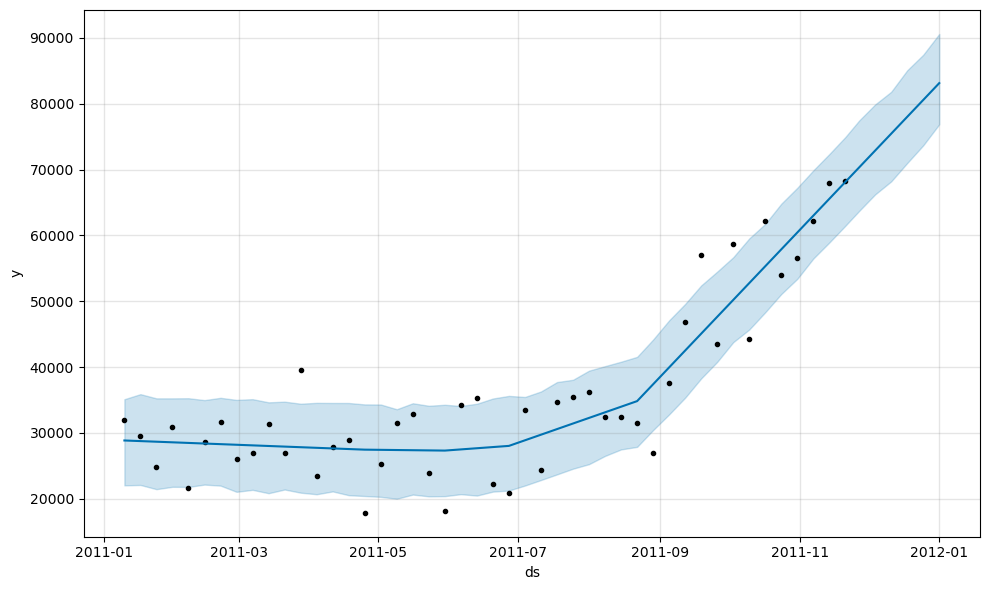

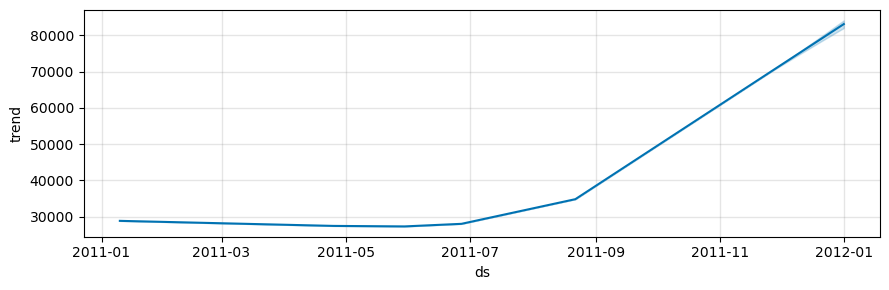

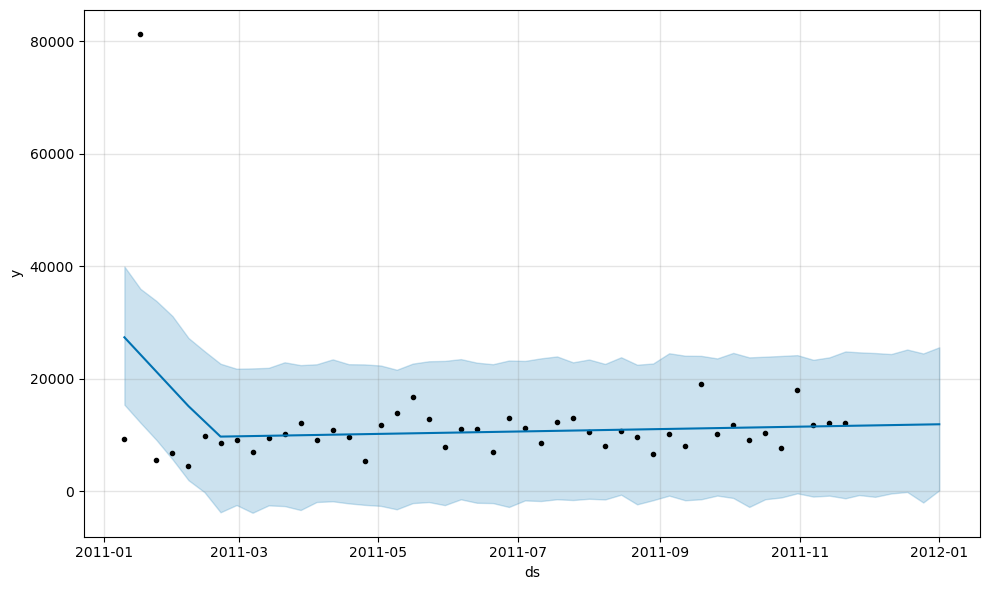

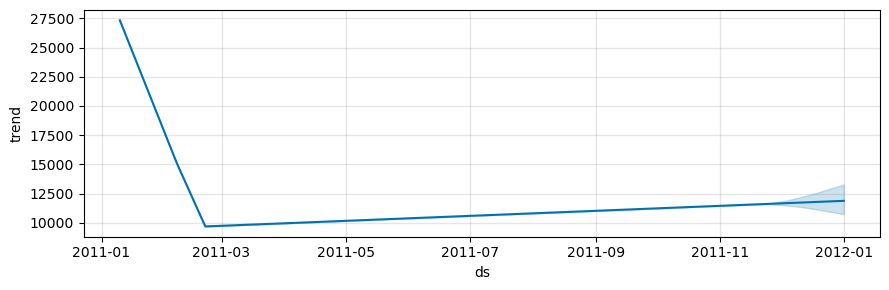

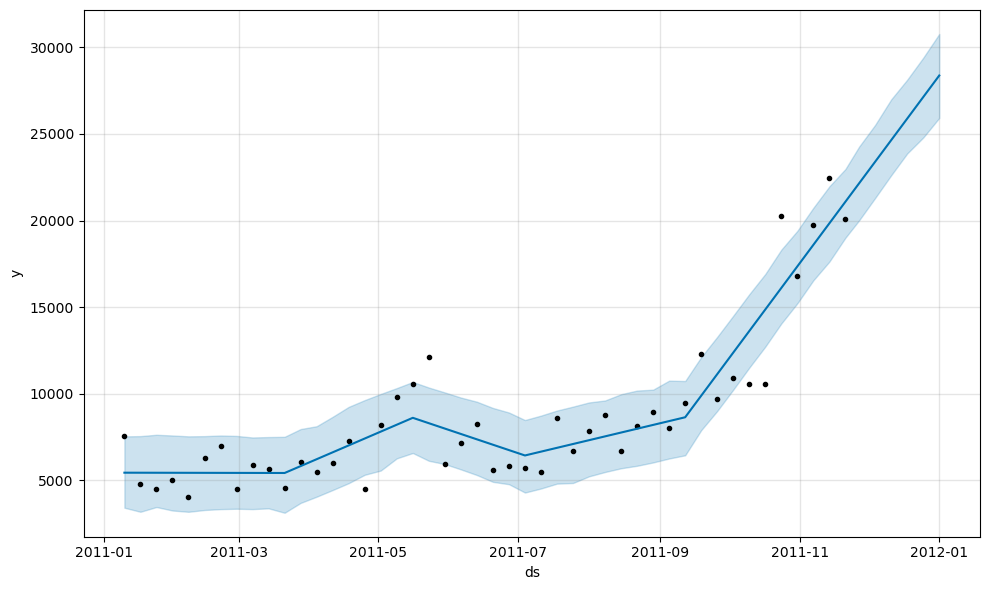

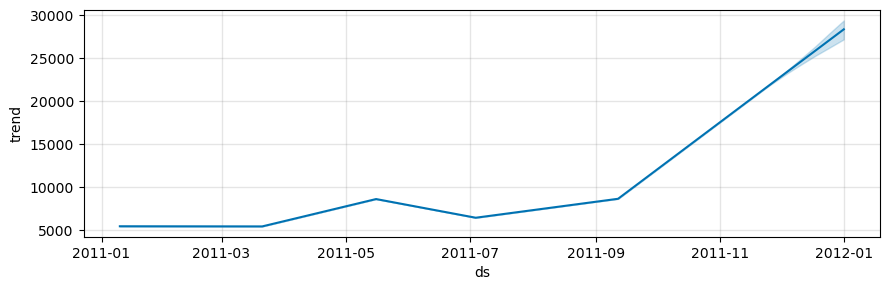

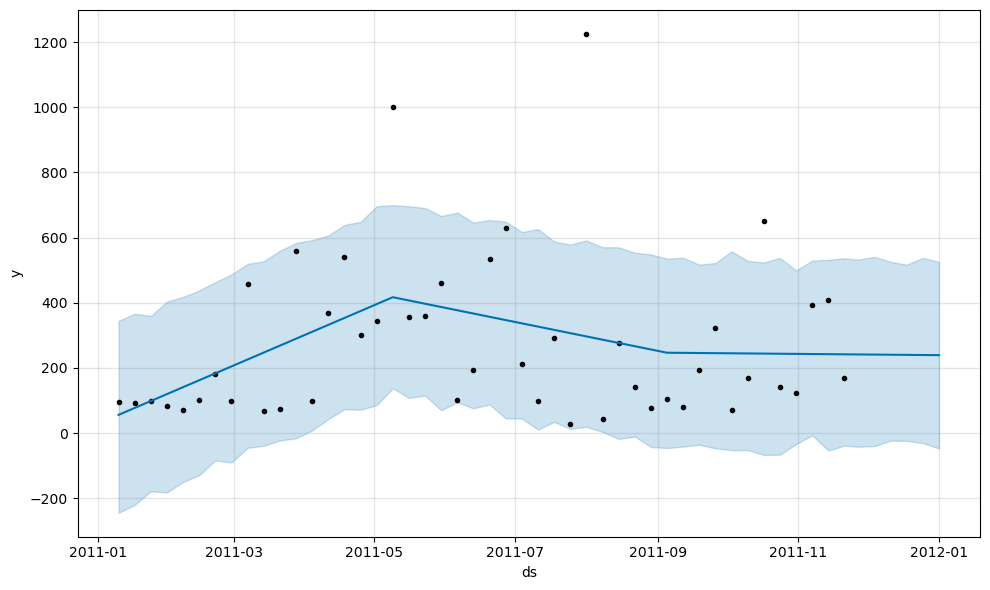

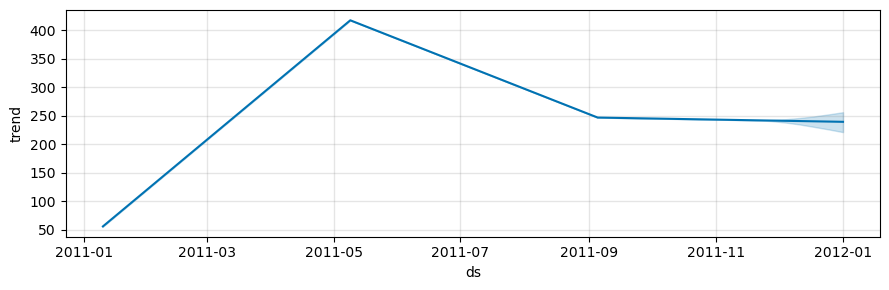

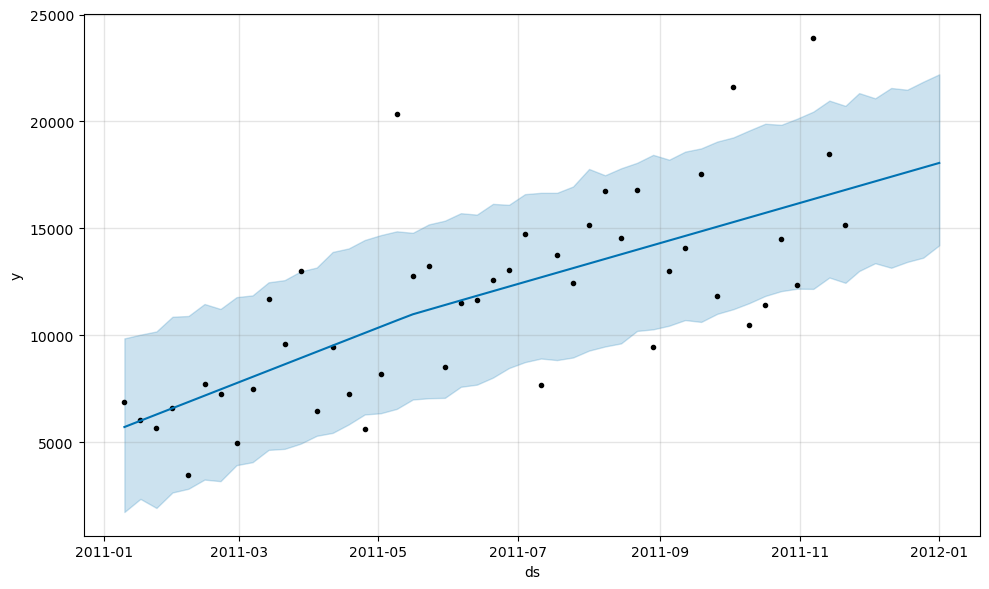

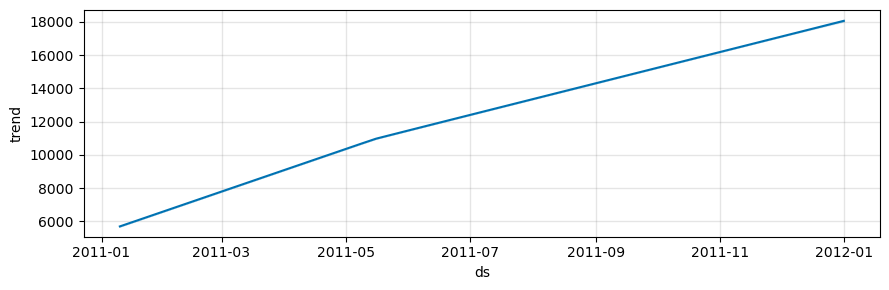

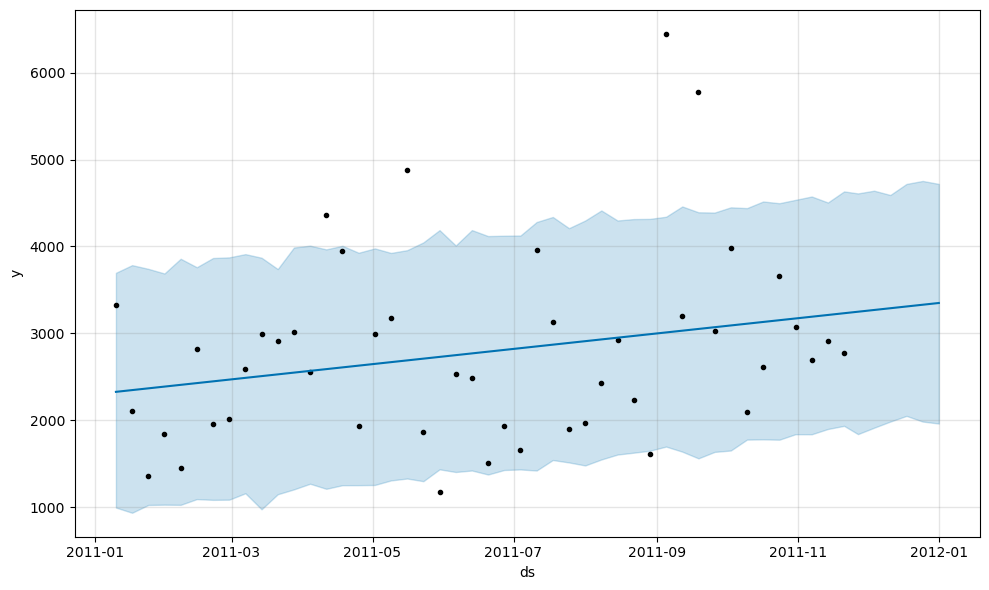

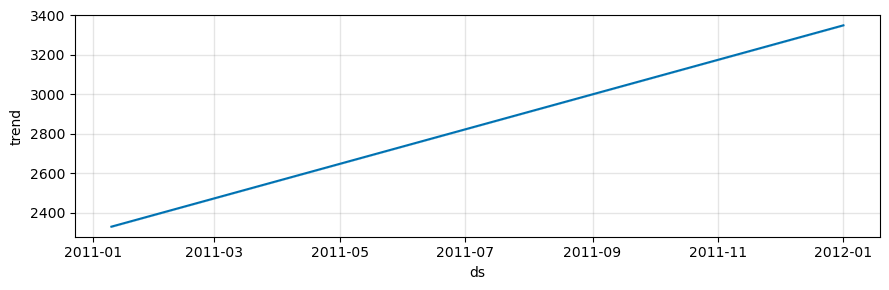

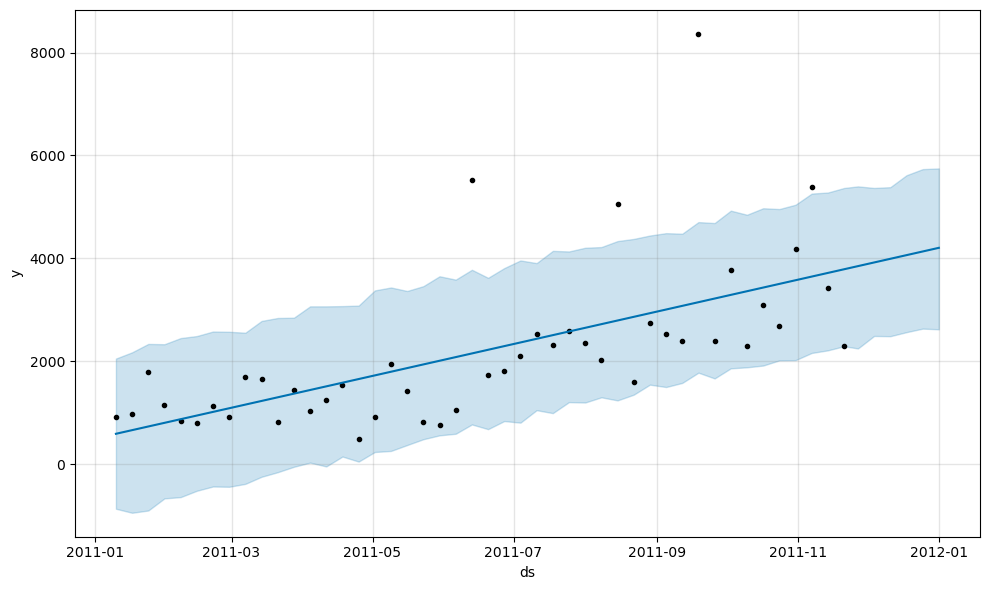

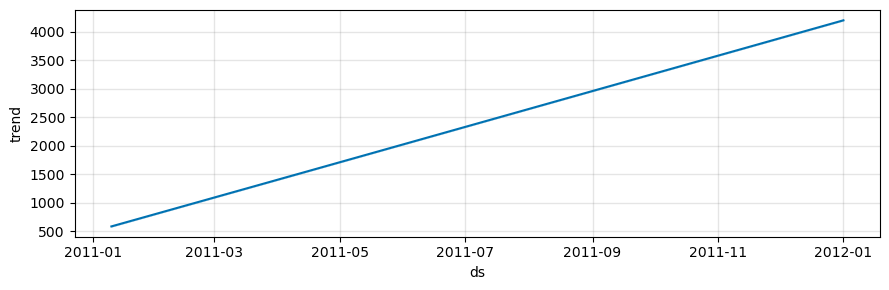

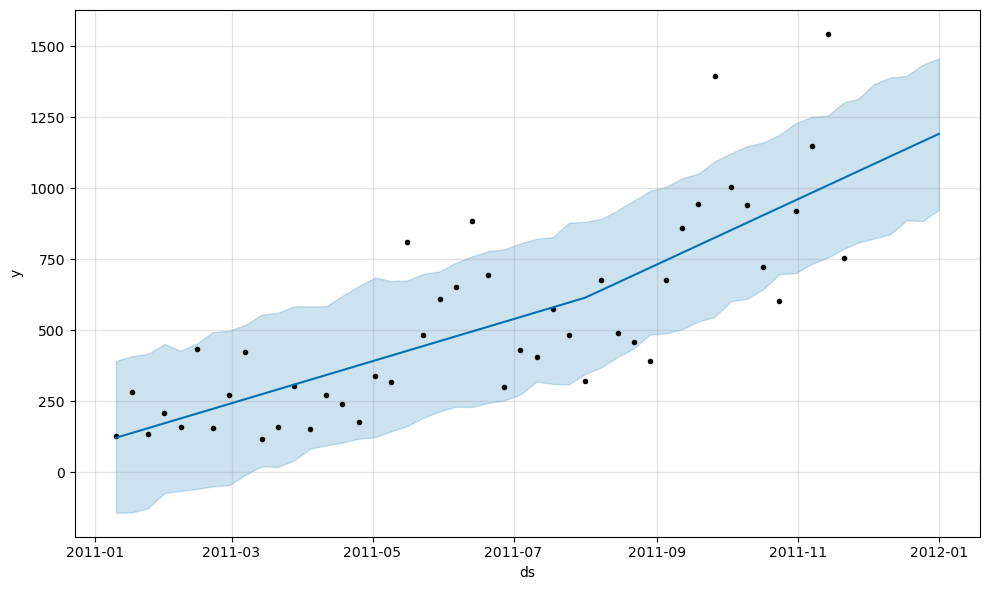

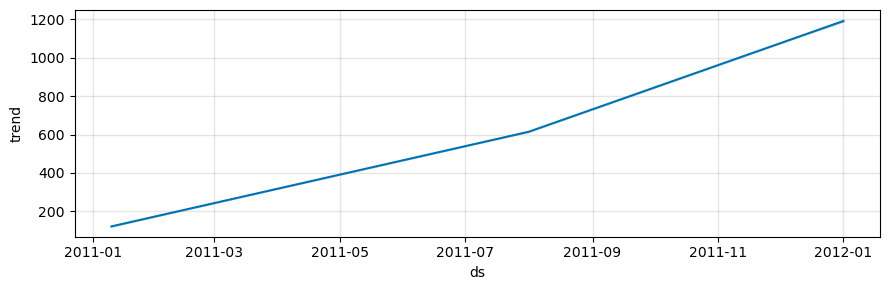

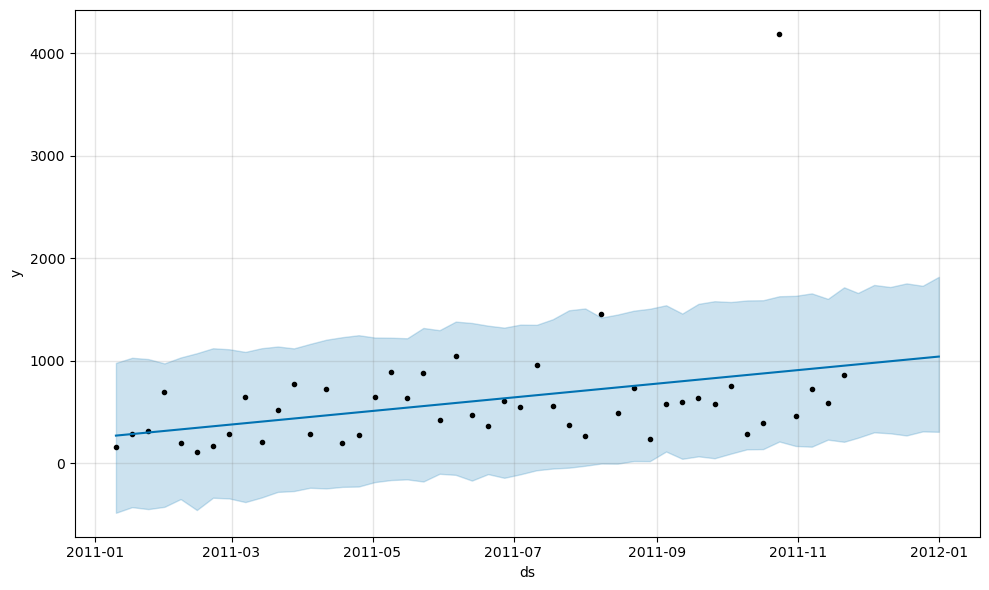

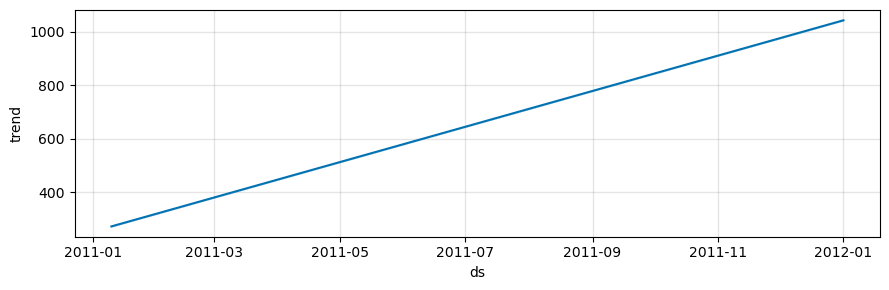

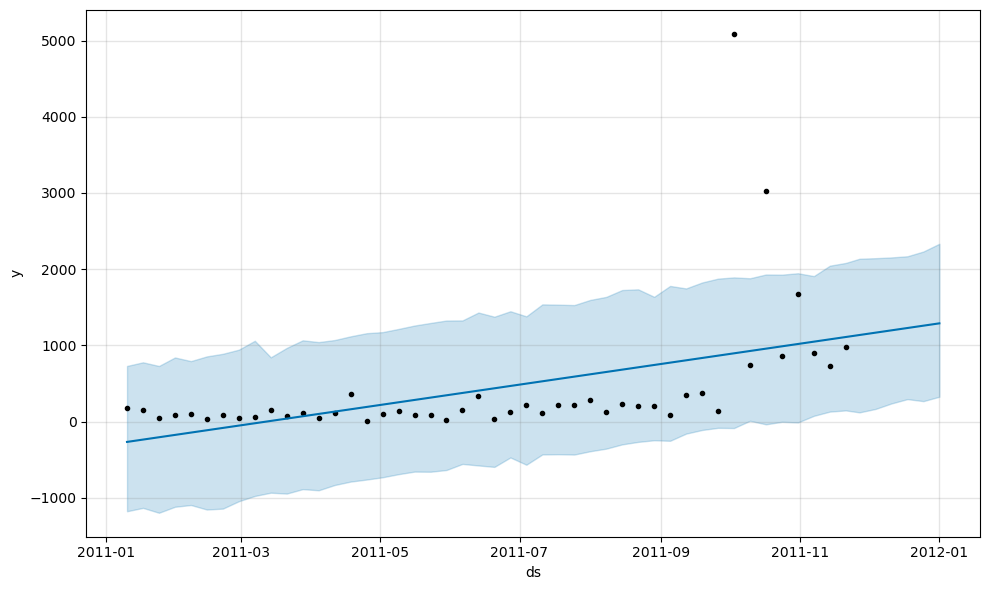

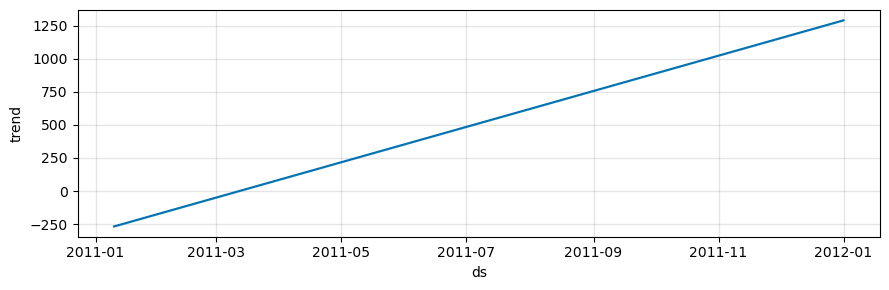

In [40]:
#PROPHET MODEL

forecasted_dfs = []

for category in Category_index:
    
    #formatting
    df_copy = sales_data[category].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for each category
    params_dict = dicts[category]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[category]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[category]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative'
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_weeks, freq = 'W')
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)
    

## 5.5. Summary

In this phase of Final Modeling, I performed an iterative process of hyperparameter tuning for each category to optimize the model's performance and improve the accuracy of the forecasting model. Mean Absolute Percentage Error (MAPE) was used as the model evaluation metric for the hyperparameter tuning as it is a reliable measure for gauging the accuracy of predictions especially in the context of time series forecasting. 
The hyperparameter tuning involved adjusting various parameters of the model, such as changepoint prior scale, seasonality prior scale, holidays prior scale and seasonality mode. These adjustments aimed to identify the combination of parameters that minimized the MAPE, resulting in a model that could provide more accurate predictions for each category.
After the rounds of hyperparameter tuning, the final model has demonstrated a good performance by accurately forecasting sales for 9 out of the 14 categories for which the Mean Absolute Percentage Error (MAPE) consistently remained below the threshold of 18%.


### Results

Let's look into the specific forecasts generated for each category:

**Miscellaneous (Category -1):**
Sales have been consistently low, around 30,000, but are showing an increasing trend since September. The forecast predicts a continued rise until the end of December.

**Home Decorations (Category 0):**
Starting high in January, sales surge in mid-February, stabilizing at around 10,000. The forecast indicates that these levels will be maintained throughout December.

**Kitchen Items (Category 1):**
Sales increased in May, dipped in July, and rose again after September. The forecast anticipates a further increase, reaching upwards of 25,000 in sales.

**Light Holders (Category 2):**
Experiencing a slight sales increase in mid-May, light holders have stabilized around 200 units. The forecast suggests these levels will be maintained.

**Bathroom Items (Category 4):**
Sales have shown a consistent increase, growing from 5,000 to nearly 18,000 by November. The forecast predicts a continued upward trajectory in December.

**Bags (Category 5):**
Steadily increasing since January, starting at 2,000 sales and reaching 3,500 by November. The forecast suggests a continued steady rise.

**Signs (Category 6):**
Similar to bags, signs have shown a consistent increase, going from 1,200 to over 4,000 in sales. The forecast anticipates this upward trend continuing.

**Children's Toys (Category 8):**
Sales have been increasing, with a brief stability in late August, followed by continued growth. The forecast predicts an increase in December, reaching up to 1,250 sales.

**Stationary Items (Category 10):**
Sales have remained relatively stable, reaching almost 1,000 items in November. The forecast indicates a slight increase to just over 1,000 in December.

**Gifts (Category 12):**
Sales have been consistently below 1,000 items each month but exhibit a notable increase starting mid-November. The forecast suggests this upward trend will persist in December.

**Category 7** has the highest MAPE, indicating a significant error of 46%. Similarly, Categories 11, 13, and 9 also has high MAPE values, exceeding 30%. Therefore, using the current model for forecasting Category 7 items is not recommended, as it may result in suboptimal inventory management, inefficient resource allocation, and other potential business decision inaccuracies.
To enhance the accuracy of predictions for these categories, it is advisable to delve deeper into their characteristics. This could involve acquiring more data, extending the observation period, or exploring alternative models in future research.